In [1]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________
import ERROR
import CONFIG
import DBPARSE
from PXPY import *
from ASYMMETRY import *
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
import CORRECTIONS
import CALCULATE
import GETFF
from joblib import Parallel, delayed
import importlib
#importlib.reload(ASYMMETRY)

Welcome to JupyROOT 6.26/06


In [2]:
###############################################################################
###############################################################################

#NEEDS INELASTIC ASYMMETRY, NITROGEN CONTAMINATION

###############################################################################
###############################################################################

In [3]:
Pass="2"
config="4a"
generic=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/Pass{Pass}/GEN{config}/He3/final_2_{1}.npz")


In [4]:
W2min=CONFIG.Function_JSON("W2min",f"../config/Pass{Pass}/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/Pass{Pass}/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/Pass{Pass}/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/Pass{Pass}/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/Pass{Pass}/cuts{config}.cfg")
hcalmin=CONFIG.Function_JSON("hcalmin",f"../config/Pass{Pass}/cuts{config}.cfg")

dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/Pass{Pass}/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/Pass{Pass}/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/Pass{Pass}/cuts{config}.cfg")
Q2=CONFIG.Function_JSON("Q2",f"../config/Pass{Pass}/cuts{config}.cfg")

#  "dxmin"	: -0.481,
#  "dxmax"	: 0.498, old gen2


print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Q2: {Q2}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

#W2min=-7
#dymin=-1
#W2max=2




W2min: -1
W2max: 1.9
dxmin: -0.403
dxmax: 0.406
dymin: -0.98
dymax: 0.98
dybgmin: -1.3
dybgmax: 1.2
Q2: 9.82
Coin Min: 117 Coin Max: 126


In [5]:
#in GeV^2
m=.939565
Mp=.938
muN=-1.9103
mup=2.793

if config=="2":
    Q2=3
    tau=Q2/(4*m**2)
    theta=29.5*pi/180
if config=="3":
    Q2=6.83
    #Q2=6.62 #seans number
    tau=Q2/(4*m**2)
    theta=36.5*pi/180
if config=="4":
    Q2=9.82
    tau=Q2/(4*m**2)
    theta=35*pi/180

# Target Spin Direction

In [6]:
if config=="2":
    spintheta=59.34
    spinphi=1.84
if config=="3":
    spintheta=70.94
    spinphi=.51
if config=="4a":
    spintheta=74.07
    spinphi=.55





In [7]:

fileNum=1
simconfig=config
if config=="4a" or config=="4b":
    simconfig="4"
genericSim=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpySim/GEN{simconfig}/simulation0.npz")
genericSimIN=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpySim/GEN4/insimulationNEW0.npz")

print(genericSim.files)
print(genericSimIN.files)



['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'ephi', 'trP', 'fnucl', 'weight']
['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'trP', 'fnucl', 'weight', 'mc_sig', 'mc_sigOld', 'mc_sigPol', 'mc_BETA', 'mc_THETA']


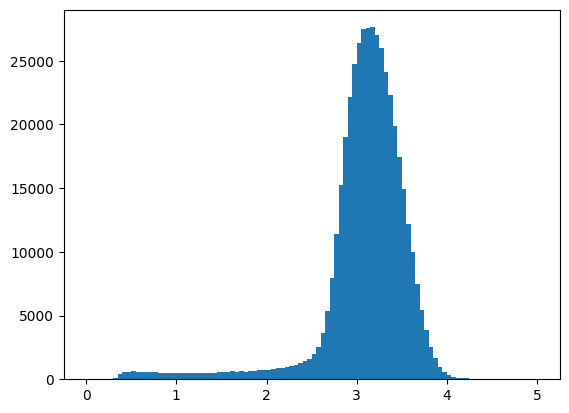

In [8]:
d=plt.hist(genericSim["trP"],bins=100,range=(0,5))

In [9]:
#%load_ext memory_profiler
#%memit doit()


In [10]:
dataTarget = pd.read_csv('../DB/ProcessedHe3Pol.csv')
dataBeam = pd.read_csv('../DB/ProcessedBeamPol.csv')
target_run_num = dataTarget['Run Number'].to_numpy()

target_pol = dataTarget['Polarization'].to_numpy()

target_polE=dataTarget['Error'].to_numpy()
target_pol=target_pol[~np.isnan(target_polE)]
target_polE=target_polE[~np.isnan(target_polE)]
beam_run_num = dataBeam['Run Number'].to_numpy()
beam_pol = dataBeam['Polarization'].to_numpy()
beam_polE=dataBeam['Error'].to_numpy()

In [11]:
target_pol/100

array([0.33784094, 0.34959488, 0.35102284, ..., 0.4057018 , 0.4051526 ,
       0.40446772])

In [12]:
target_polE/100

array([0.01700711, 0.01762116, 0.01779658, ..., 0.01706915, 0.01698182,
       0.01687292])

In [13]:
print("hehe")

hehe


In [14]:
%%time
if(len(generic["dx"])<3000000):
    
    useGrinch=False

    
    genericMaster = {}
    base_dir = f"/media/research/TOSHIBA EXT/GEn/NumpyData/Pass{Pass}/GEN{config}/He3"
    i = 0
    print(f"NumPy array directory = {base_dir}")
    while os.path.exists(f"{base_dir}/final_2_{i}.npz"):
        print(f"Loading in file {i}")
        if i>10:            #GPS
            break            #GPS
        file_path = f"{base_dir}/final_2_{i}.npz"
        data = np.load(file_path)

        cut=(data["ePS"]>0.2)
        if Pass=="2":
            grinchcut=(data["grinch_clus_size"]>=1)
            antigrinchcut=(data["grinch_clus_size"]<2)|(data["grinch_clus_trackindex"]!=0)
            pscut=(data["ePS"]>0) #GPS
            #pscut=(data["ePS"]>0.2)
            if useGrinch:
                print("using grinch cut")
                #cut=antigrinchcut  #ANTIG
                
                ################################################pion rejection##############################
                x = data["ePS"]
                y = data["grinch_clus_size"]
                thispscut=x>.1428
                xc, yc = .9, 7     
                a, b = .75, 7.20        
                theta = 0     
                                #clussize   #ps
                nocut_mask = (y > 8) | (x >.75)


                x_rot = (x - xc) * np.cos(theta) + (y - yc) * np.sin(theta)
                y_rot = -(x - xc) * np.sin(theta) + (y - yc) * np.cos(theta)
                ellipse_mask = (x_rot / a)**2 + (y_rot / b)**2 <= 1

                # Step 3: pioncut is True if either:
                #   - Outside the problematic region (nocut), or
                #   - Inside the ellipse (for low ePS and low clus size)
                pioncut = nocut_mask | ellipse_mask
                #gcut=(data["grinch_clus_trackindex"]==0)

                ################################################pion rejection##############################
                cut=(grinchcut&thispscut)
            else:
                print("using ps cut")
                cut=pscut
        for key in data.files:
            if key not in genericMaster:
                cut_data = data[key][cut]
                genericMaster[key] = cut_data

            else:
                cut_data = data[key][cut]
                genericMaster[key] = np.concatenate((genericMaster[key], cut_data))

        data.close()
        i += 1

    print(f"Loaded {i} files into genericMaster.")


NumPy array directory = /media/research/TOSHIBA EXT/GEn/NumpyData/Pass2/GEN4a/He3
Loading in file 0
using ps cut
Loading in file 1
using ps cut
Loading in file 2
using ps cut
Loading in file 3
using ps cut
Loading in file 4
using ps cut
Loading in file 5
using ps cut
Loading in file 6
using ps cut
Loading in file 7
using ps cut
Loading in file 8
using ps cut
Loading in file 9
using ps cut
Loaded 10 files into genericMaster.
CPU times: user 8.49 s, sys: 16.9 s, total: 25.4 s
Wall time: 56.2 s


In [15]:
generic=genericMaster

In [49]:
dyscale=20
dxscale=20
hcalscale=100
wscale=20
new_W2min=.87-11/wscale*2
new_W2max=.88+11/wscale
new_dxmin=-.1-4/dxscale
new_dxmax=.1+4/dxscale
new_dymin=-.1-8/dyscale
new_dymax=.1+8/dyscale
new_hcalmin=.025+20/hcalscale
new_coinmin=117
new_coinmax=126-2
new_psmin=.2
epmin=.8

In [92]:
wcut=(generic["W2"] < new_W2max)&(generic["W2"]>new_W2min) 
dycut=(generic["dy"]<new_dymax)&(generic["dy"]>new_dymin) 
dxcut=(generic["dx"] < new_dxmax)&(generic["dx"]>new_dxmin) 
coincut=(new_coinmin < generic["coin_time"])&(generic["coin_time"] < new_coinmax)
pscut=generic["ePS"]>new_psmin
bbcalE=generic["eSH"]+generic["ePS"]
gemP=generic["trP"]
epcut=bbcalE/gemP>epmin
hcalecut=(generic["eHCAL"])>new_hcalmin

fullcut=wcut&dycut&coincut&epcut&pscut&hcalecut


Text(0.5, 0, 'dx')

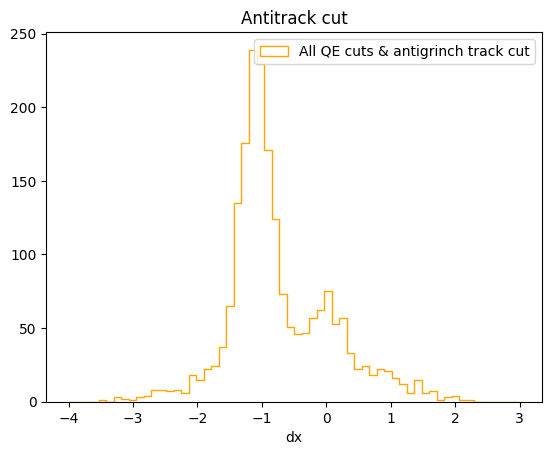

In [124]:
antigrinchcut=(generic["grinch_clus_trackindex"]!=0)
grinchcut=(generic["grinch_clus_trackindex"]==0)

d=plt.hist(generic["dx"][antigrinchcut&fullcut],bins=60,range=(-4,3),
          color='orange',histtype='step',label="All QE cuts & antigrinch track cut")
plt.legend(loc='upper right')
plt.title("Antitrack cut")
plt.xlabel("dx")

Text(0.5, 0, 'dx')

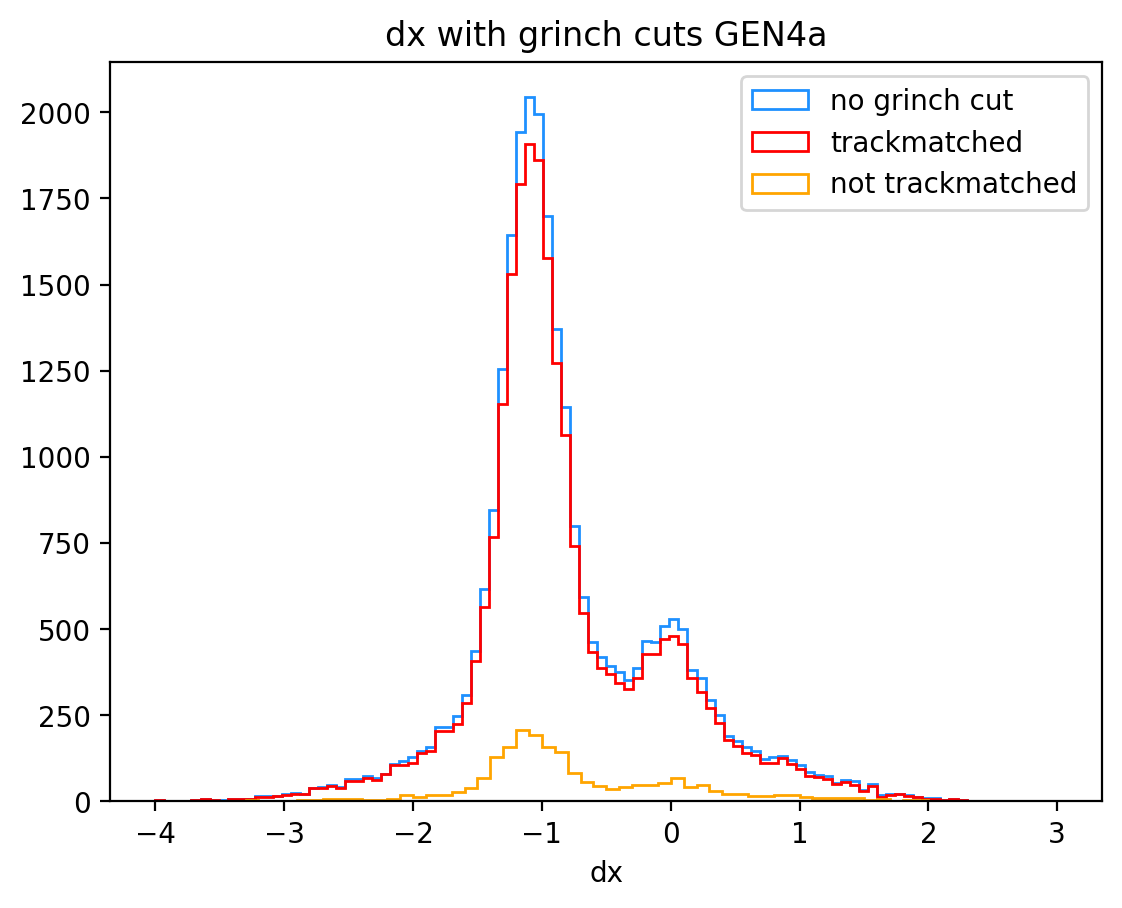

In [139]:
GrinchWeight=np.full_like(generic["dx"][antigrinchcut&fullcut],1)
plt.figure(dpi=200)
d=plt.hist(generic["dx"][fullcut],
           histtype='step',color='dodgerblue',bins=100,range=(-4,3),label="no grinch cut")
d=plt.hist(generic["dx"][grinchcut&fullcut],
           histtype='step',color='red',bins=100,range=(-4,3),label="trackmatched")
d=plt.hist(generic["dx"][antigrinchcut&fullcut],
           histtype='step',color='orange',
           weights=GrinchWeight,bins=70,range=(-4,3),label="not trackmatched")
#plt.yscale("log")
plt.title("dx with grinch cuts GEN4a")
plt.legend(loc='upper right')
plt.xlabel("dx")

In [132]:
NPLUS=np.sum(helicity[fullcut&grinchcut&dxcut]==1)
NMINUS=np.sum(helicity[fullcut&grinchcut&dxcut]==-1)

grinchantiA=(NPLUS-NMINUS)/(NPLUS+NMINUS)
grinchantiAE=2 * np.sqrt(NPLUS * NMINUS) / (NPLUS + NMINUS)**1.5

In [133]:
print(f"A = {grinchantiA:.4f}+-{grinchantiAE:.4f}")

A = 0.0540+-0.0171


In [101]:
np.sum(helicity[fullcut&grinchcut]==1)

12437

Text(0.5, 1.0, 'GEN4a')

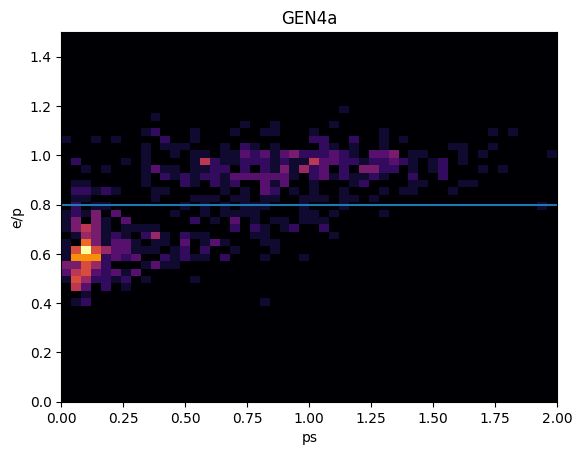

In [58]:
bbcalE=generic["eSH"]+generic["ePS"]
gemP=generic["trP"]

wcut=(generic["W2"] < new_W2max)&(generic["W2"]>new_W2min) 
dycut=(generic["dy"]<new_dymax)&(generic["dy"]>new_dymin) 
dxcut=(generic["dx"] < new_dxmax)&(generic["dx"]>new_dxmin) 
coincut=(new_coinmin < generic["coin_time"])&(generic["coin_time"] < new_coinmax)


fullcut=wcut & dycut & dxcut & coincut&hcalecut&antigrinchcut
d=plt.hist2d(generic["ePS"][fullcut],bbcalE[fullcut]/gemP[fullcut],
             bins=(50,50),range=((0,2),(0,1.5)),cmap='inferno')
plt.axhline(.8)
#plt.axvline(.2)
#plt.axhline(1.05)
plt.ylabel("e/p")
plt.xlabel("ps")
plt.title("GEN4a")

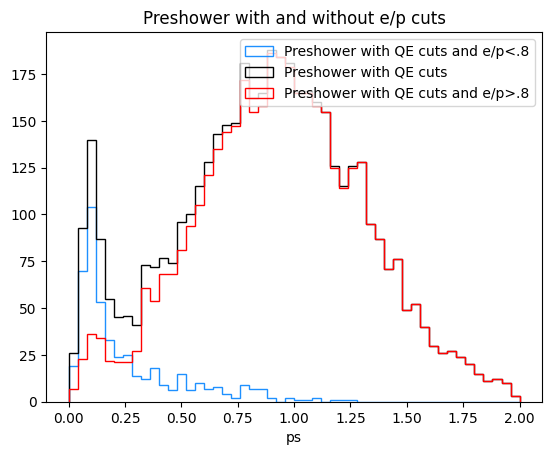

In [133]:
epcut=bbcalE/gemP>.7

d=plt.hist(generic["ePS"][fullcut&~epcut],color='dodgerblue',
           label='Preshower with QE cuts and e/p<.8',histtype='step',bins=50,range=(0,2))
d=plt.hist(generic["ePS"][fullcut],histtype='step',color='black',
           label='Preshower with QE cuts',bins=50,range=(0,2))
d=plt.hist(generic["ePS"][fullcut&epcut],histtype='step',color='red',
           label='Preshower with QE cuts and e/p>.8',bins=50,range=(0,2))
plt.title("Preshower with and without e/p cuts")
plt.xlabel("ps")
plt.legend(loc='upper right')

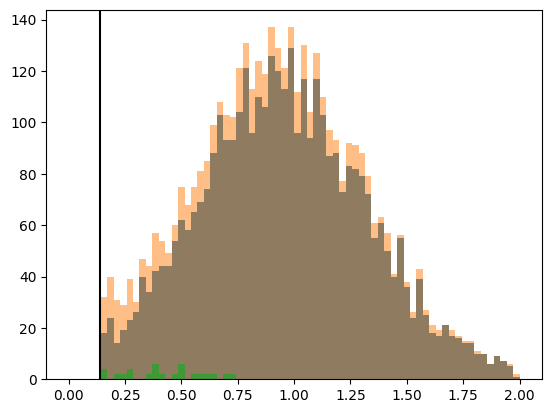

In [115]:
antigcut=~(generic["grinch_clus_trackindex"]==0)
gcut=(generic["grinch_clus_trackindex"]==0)

antigrinchcut=(generic["grinch_clus_size"]<3)
grinchcut=(generic["grinch_clus_size"]>=1)

#d=plt.hist(generic["ePS"],bins=100,range=(0,1))
plt.axvline(7/50,color='black')
pscut2=generic["ePS"]>0
d=plt.hist(generic["ePS"][fullcut&pscut2&grinchcut&gcut],bins=70,range=(0,2))
d=plt.hist(generic["ePS"][fullcut&pscut2&grinchcut],bins=70,range=(0,2),alpha=.5)

weights = np.full_like(generic["ePS"][fullcut&pscut2 & antigrinchcut&antigcut],2)
d=plt.hist(generic["ePS"][fullcut&pscut2&antigrinchcut&antigcut],bins=70,range=(0,2),alpha=.8,weights=weights)
#plt.yscale("log")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define bins
bins = np.linspace(0, 2, 70)  # 100 bins from 0 to 2

# Compute histograms
counts1, _ = np.histogram(generic["ePS"][fullcut&pscut2], bins=bins)
counts2, _ = np.histogram(generic["ePS"][fullcut&pscut2&antigrinchcut&antigcut], bins=bins,weights=weights)

# Subtract histograms
diff_counts = counts1 - counts2

# Compute bin centers for plotting
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Plot the subtracted histogram
plt.figure()
plt.bar(bin_centers, diff_counts, width=(bins[1] - bins[0]), color='gray', alpha=0.7)
plt.xlabel('ePS')
plt.ylabel('Difference in Counts')
plt.title('Subtracted Histogram')
plt.grid(True)
plt.show()
np.sum(counts2)/np.sum(counts1)

In [ ]:
import matplotlib.colors as colors
d=plt.hist2d(generic["ePS"][fullcut],generic["grinch_clus_size"][fullcut],
             bins=(100,14),range=((0,2),(0,15)),cmap='inferno')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
# Example data
x = generic["ePS"]
y = generic["grinch_clus_size"]

# Ellipse parameters
xc, yc = .9, 7     
a, b = .75*1.05, 7.20*1.05        
theta = 0              

# Elliptical mask: (x', y') in rotated coords
x_rot = (x - xc) * np.cos(theta) + (y - yc) * np.sin(theta)
y_rot = -(x - xc) * np.sin(theta) + (y - yc) * np.cos(theta)

ellipse_mask = (x_rot / a)**2 + (y_rot / b)**2 <= 1

# Apply mask
x_in = x[ellipse_mask]
y_in = y[ellipse_mask]

# Plot histogram of selected region
#plt.hist2d(x_in, y_in, bins=[100, 15], range=[[0, 2], [0, 15]], cmap='Blues',norm=colors.LogNorm(),alpha=1)
# Generate theta values for 180° to 270° (bottom-left quadrant)
t = np.linspace(np.pi, 1.5 * np.pi, 100)
t = np.linspace(0, 2 * np.pi, 500)
# Parametric ellipse
x = xc + a * np.cos(t) * np.cos(theta) - b * np.sin(t) * np.sin(theta)
y = yc + a * np.cos(t) * np.sin(theta) + b * np.sin(t) * np.cos(theta)

# Plot it
#lt.plot(x, y, color='magenta', linewidth=4, label='Ellipse lower-left')
plt.xlabel("ePS")
plt.ylabel("grinch_clus_size")
plt.axvline(.1428,color="white")
plt.axhline(1,color="white")
plt.title("GEN4a")
plt.show()



In [ ]:
bbcalE=generic["eSH"]+generic["ePS"]
gemP=generic["trP"]

d=plt.hist2d(generic["ePS"][fullcut],bbcalE[fullcut]/gemP[fullcut],
             bins=(50,50),range=((0,2),(0,2)),cmap='inferno',norm=colors.LogNorm())
plt.axhline(.8)
plt.axvline(.15)
#plt.axhline(1.05)

In [ ]:
x = generic["ePS"]
y = generic["grinch_clus_size"]
thispscut=x>7/50
xc, yc = .9, 7     
a, b = .75, 7.20        
theta = 0     
                #clussize   #ps
nocut_mask = (y > 8) | (x >.75)

x_rot = (x - xc) * np.cos(theta) + (y - yc) * np.sin(theta)
y_rot = -(x - xc) * np.sin(theta) + (y - yc) * np.cos(theta)
ellipse_mask = (x_rot / a)**2 + (y_rot / b)**2 <= 1

# Step 3: pioncut is True if either:
#   - Outside the problematic region (nocut), or
#   - Inside the ellipse (for low ePS and low clus size)
pioncut = nocut_mask | ellipse_mask
#gcut=(generic["grinch_clus_trackindex"]==0)

################################################pion rejection##############################
cut=pioncut&gcut&thispscut

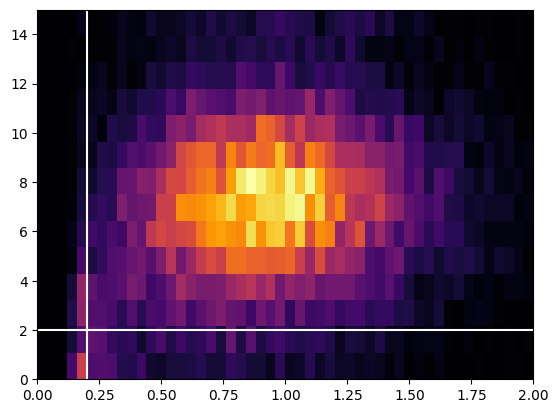

In [108]:
d=plt.hist2d(generic["ePS"][fullcut],generic["grinch_clus_size"][fullcut],
             bins=(50,14),range=((0,2),(0,15)),cmap='inferno',)
plt.axvline(.2,color='white')
plt.axhline(2,color='white')



In [ ]:
d=plt.hist(generic["ePS"][fullcut],bins=70,range=(0,2))
plt.axvline(7/50,color='black')

In [ ]:
d=plt.hist(generic["helicity"][fullcut],bins=100,range=(-2,2))
p=np.sum(helicity[fullcut]==1)
n=np.sum(helicity[fullcut]==-1)
(p-n)/(p+n)

In [ ]:
d=plt.hist(x[fullcut&cut],bins=100,range=(0,2))

# Cuts

### Making the correct helicity

In [36]:
IHWP_IN=np.where(generic["IHWP"]==1)
helicity=generic["helicity"]
helicity[IHWP_IN]*=-1
hpluscut=helicity==1
hminuscut=helicity==-1
protoncut=genericSim["fnucl"]==1
neutroncut=genericSim["fnucl"]==0
weight=genericSim["weight"]

bbcalE=generic["eSH"]+generic["ePS"]
gemP=generic["trP"]
epcut=bbcalE/gemP>0

runnumcut=generic["runnum"]>2165

sigma=genericSimIN["mc_sig"]
goodsigmacut=sigma<.4e-38


In [13]:
antibgcut=(abs(generic["dy"])>1.2)&(generic["W2"] < W2max)&(generic["W2"]>W2min)&(coinmin < generic["coin_time"])&(generic["coin_time"] < coinmax)


In [14]:
new_hcalmin=.225

### Cuts for data, bgsim, np sim 

In [15]:


wcut=(generic["W2"] < W2max)&(generic["W2"]>W2min) 
dycut=(generic["dy"]<dymax)&(generic["dy"]>dymin) 
dxcut=(generic["dx"] < dxmax)&(generic["dx"]>dxmin) 
coincut=(coinmin < generic["coin_time"])&(generic["coin_time"] < coinmax)

hcalecut=(generic["eHCAL"])>new_hcalmin
fullcut=wcut & dycut & dxcut & coincut&runnumcut&epcut&hcalecut
fullcutfordx=wcut&dycut&coincut&runnumcut#&epcut
accidentalcut=wcut&dycut&dxcut&runnumcut#&epcut


anticoincut=(coinmin-8 > generic["coin_time"])|(generic["coin_time"] > coinmax+5)



bgcut=(genericSimIN["W2"] < W2max)&(genericSimIN["W2"]>W2min)
antibgcut=(abs(generic["dy"])>1.2)&wcut&coincut
antibgAcut=(abs(generic["dy"])>1.2)
Simwcut=(genericSim["W2"] < W2max)&(genericSim["W2"]>W2min) 
Simdycut=(abs(genericSim["dy"]) < 0.5) 
Simdxcut=(genericSim["dx"] < dxmax)&(genericSim["dx"]>dxmin) 
Simfullcut=Simwcut & Simdycut & Simdxcut

InSimdxcut=(genericSimIN["dx"] < dxmax)&(genericSimIN["dx"]>dxmin)
InSimdycut=(genericSimIN["dy"] < dymax)&(genericSimIN["dy"]>dymin)

protoncut=genericSim["fnucl"]==1
neutroncut=genericSim["fnucl"]==0
weight=genericSim["weight"]



sigma=genericSimIN["mc_sig"]
sigmaold=genericSimIN["mc_sigOld"]
sigmapol=genericSimIN["mc_sigPol"]
THETA=genericSimIN["mc_THETA"]
BETA=genericSimIN["mc_BETA"]
Q2_in=genericSimIN["Q2"]
nu_in=genericSimIN["nu"]
W2_in=genericSimIN["W2"]
x_in  = Q2_in/(2.0*Mp*nu_in)
dy_in=genericSimIN["dy"]
dx_in=genericSimIN["dx"]

dy_incut=(dy_in<dymax)&(dy_in>dymin)
bgcut=(W2_in<W2max)&(W2_in>W2min)#&(abs(dy_in) < 0.5)#&(sigma<1e-39)##&(Q2<6.1)#
sigmacut=(sigma>6e-39)
goodsigmacut=sigma<.4e-38

In [16]:
antidycut=abs(generic["dy"]>1.2)

Text(0.5, 0, 'dx')

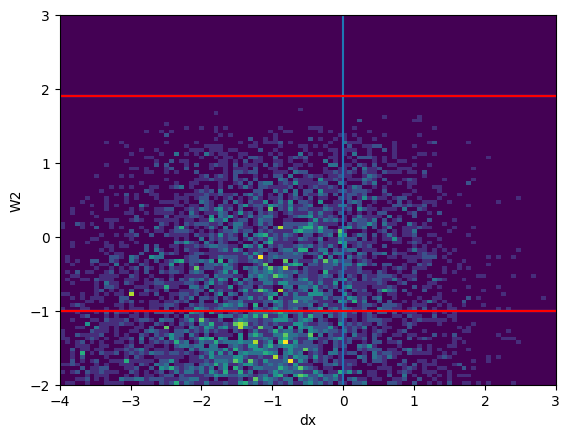

In [17]:
d=plt.hist2d(generic["dx"][coincut&antidycut],generic["W2"][coincut&antidycut],bins=(100,100),range=((-4,3),(-2,3)))
plt.axvline(0)
#plt.axvline(-1.1)
plt.axhline(W2max,color='white')
plt.axhline(W2min,color='white')

plt.axhline(W2max,color='red')
plt.axhline(W2min,color='red')
plt.ylabel("W2")
plt.xlabel("dx")



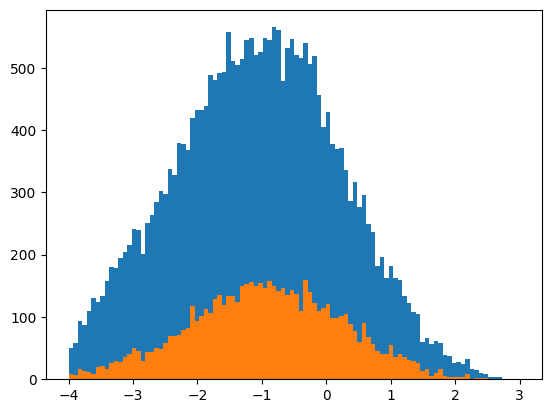

In [18]:
d=plt.hist(generic["dx"][(abs(generic["dy"])>1.2)&wcut],bins=100,range=(-4,3))
d=plt.hist(generic["dx"][antibgcut],bins=100,range=(-4,3))

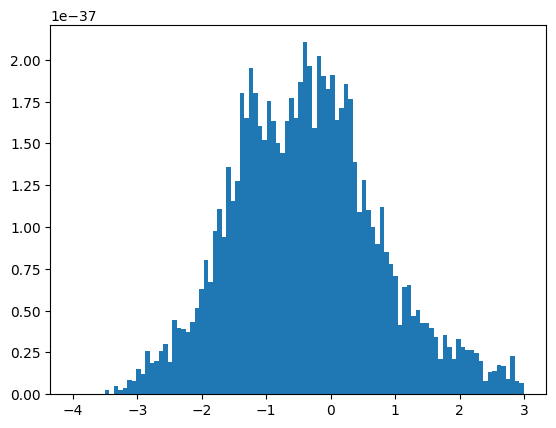

In [19]:
d=plt.hist(dx_in[bgcut&goodsigmacut],weights=sigma[bgcut&goodsigmacut],bins=100,range=(-4,3))

# Peak at Cut Variables

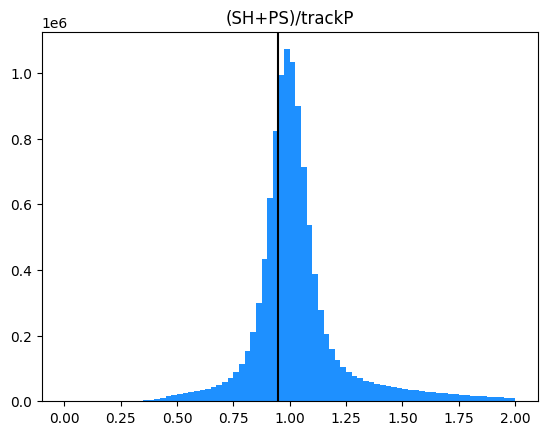

In [20]:
d=plt.hist(bbcalE/gemP,bins=80,range=(0,2),color='dodgerblue')
plt.axvline(.95,color='black')
plt.title("(SH+PS)/trackP")
epcut=bbcalE/gemP>0
d=plt.hist(bbcalE[epcut&fullcut]/gemP[epcut&fullcut],bins=80,range=(0,2),color='red')
#plt.yscale("log")

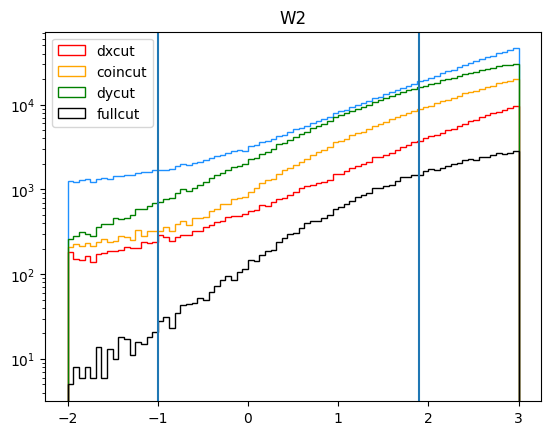

In [21]:
d=plt.hist(generic["W2"],bins=80,range=(-2,3),color='dodgerblue',histtype='step')
d=plt.hist(generic["W2"][dxcut],bins=80,range=(-2,3),color='red',label='dxcut',histtype='step')
d=plt.hist(generic["W2"][coincut],bins=80,range=(-2,3),color='orange',label='coincut',histtype='step')
d=plt.hist(generic["W2"][dycut],bins=80,range=(-2,3),color='green',label='dycut',histtype='step')
d=plt.hist(generic["W2"][dxcut&coincut&dycut],bins=80,range=(-2,3),color='black',label='fullcut',histtype='step')
plt.legend(loc='upper left')
plt.title("W2")
plt.yscale("log")
plt.axvline(W2min)
plt.axvline(W2max)

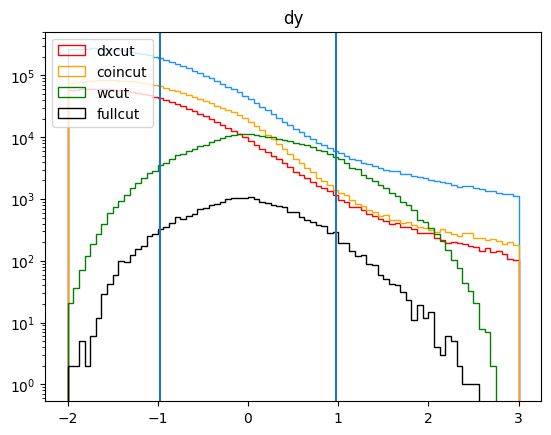

In [22]:
d=plt.hist(generic["dy"],bins=80,range=(-2,3),color='dodgerblue',histtype='step')
d=plt.hist(generic["dy"][dxcut],bins=80,range=(-2,3),color='red',label='dxcut',histtype='step')
d=plt.hist(generic["dy"][coincut],bins=80,range=(-2,3),color='orange',label='coincut',histtype='step')
d=plt.hist(generic["dy"][wcut],bins=80,range=(-2,3),color='green',label='wcut',histtype='step')
d=plt.hist(generic["dy"][dxcut&coincut&wcut],bins=80,range=(-2,3),color='black',label='fullcut',histtype='step')
plt.legend(loc='upper left')
plt.title("dy")
plt.yscale("log")
plt.axvline(dymin)
plt.axvline(dymax)

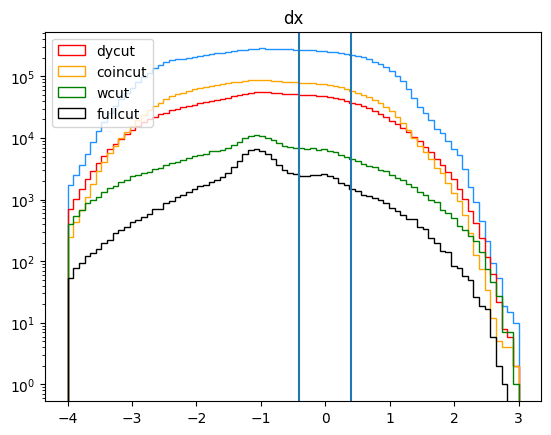

In [23]:
d=plt.hist(generic["dx"],bins=80,range=(-4,3),color='dodgerblue',histtype='step')
d=plt.hist(generic["dx"][dycut],bins=80,range=(-4,3),color='red',label='dycut',histtype='step')
d=plt.hist(generic["dx"][coincut],bins=80,range=(-4,3),color='orange',label='coincut',histtype='step')
d=plt.hist(generic["dx"][wcut],bins=80,range=(-4,3),color='green',label='wcut',histtype='step')
d=plt.hist(generic["dx"][dycut&coincut&wcut],bins=80,range=(-4,3),color='black',label='fullcut',histtype='step')
plt.legend(loc='upper left')
plt.title("dx")
plt.yscale("log")
plt.axvline(dxmin)
plt.axvline(dxmax)

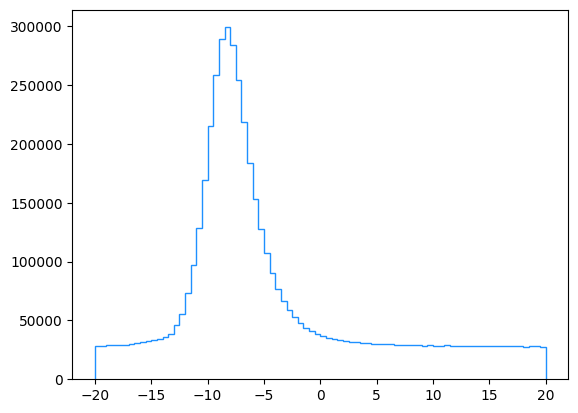

In [24]:
d=plt.hist(generic["coin_time"]-130,bins=80,range=(-20,20),color='dodgerblue',histtype='step')


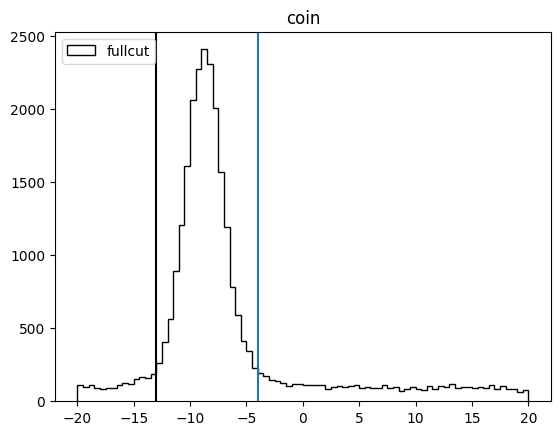

In [29]:
#d=plt.hist(generic["coin_time"]-130,bins=80,range=(-20,20),color='dodgerblue',histtype='step')
#d=plt.hist(generic["coin_time"][dycut]-130,bins=80,range=(-20,20),color='red',label='dycut',histtype='step')
#d=plt.hist(generic["coin_time"][dxcut]-130,bins=80,range=(-20,20),color='orange',label='dxcut',histtype='step')
#d=plt.hist(generic["coin_time"][wcut]-130,bins=80,range=(-20,20),color='green',label='wcut',histtype='step')
d=plt.hist(generic["coin_time"][dycut&wcut&dxcut]-130,bins=80,range=(-20,20),color='black',label='fullcut',histtype='step')
plt.legend(loc='upper left')
plt.title("coin")
#plt.yscale("log")
plt.axvline(coinmin-130,color='black')
plt.axvline(coinmax-130)



# Entire Analysis

In [30]:

def weighted_avg(values, errors):
    values = np.asarray(values)
    errors = np.asarray(errors)
    
    mask = (errors > 0) & np.isfinite(errors)
    if not np.any(mask):
        raise ValueError("No valid data points: all errors are zero, negative, or non-finite.")

    weights = 1 / errors[mask]**2
    avg = np.sum(values[mask] * weights) / np.sum(weights)
    err = np.sqrt(1 / np.sum(weights))
    
    return avg, err


In [31]:
def calculate_Aphys_with_error(epsilon_bar, tau_bar, Lambda, Px_bar, Pz_bar, dLambda):
    """
    Calculate A_phys and its uncertainty from Lambda.

    Parameters:
    epsilon_bar : float
    tau_bar : float
    Lambda : float
    Px_bar : float
    Pz_bar : float
    dLambda : float
        Uncertainty in Lambda

    Returns:
    A_phys : float
    dA_phys : float
        Uncertainty in A_phys
    """
    E = epsilon_bar
    T = tau_bar
    L = Lambda
    Px = Px_bar
    Pz = Pz_bar

    sqrt_term = np.sqrt((2 * E * (1 - E)) / T)
    denom = 1 + (E / T) * L**2
    num = L * sqrt_term * Px + np.sqrt(1 - E**2) * Pz

    A_phys = -num / denom

    # Derivatives for error propagation
    d_num_dL = sqrt_term * Px
    d_denom_dL = 2 * (E / T) * L

    dA_dLambda = -(d_num_dL * denom - num * d_denom_dL) / denom**2
    dA_phys = abs(dA_dLambda) * dLambda

    return A_phys, dA_phys

    mup=2.793
    Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
def load_data(file_path):
    """
    Load the data from the given file path into a pandas DataFrame.
    """
    columns = ["Q2", "GEp/GD", "dGEp/GD", "dGEp_Par/GD", "GMp/mu_p/GD", "dGMp/mu_p/GD", "dGMp_Par/mu_p/GD"]
    data = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=columns)
    return data
def find_closest_row(data, input_Q2):
    """
    Find the row in the data with the Q2 value closest to the input_Q2.
    """
    closest_row = data.iloc[(data['Q2'] - input_Q2).abs().argmin()]
    return closest_row
def main(input_Q2):
    file_path = '../DB/proton_lookup.dat'
    data = load_data(file_path)
    closest_row = find_closest_row(data, input_Q2)
    return closest_row

def propagate_errorAP(Ap, dAp, Pp, dPp, P_beam, dP_beam, P_target, dP_target):
    f = (Ap * Pp * P_beam * P_target) 
    rel_error_squared = (
        (dAp / Ap)**2 +
        (dPp / Pp)**2 +
        (dP_beam / P_beam)**2 +
        (dP_target / P_target)**2
    )
    df = f * np.sqrt(rel_error_squared)
    return f, df

In [84]:

if config=="2":
    Lower=-5
    Upper=2

else:
    Lower=-4.5
    Upper=3

def Function_Fitdx(wcut,dycut,dxcut,coincut,gcut,epcut,fullcutfordx,protoncut,
                  neutroncut,Simwcut,Simdycut,bgcut,weight,dxmin,dxmax,hcalmin,psmin,extracut=False):
    
    wcut=(generic["W2"] < W2max)&(generic["W2"]>W2min) 
    coincut=(coinmin < generic["coin_time"])&(generic["coin_time"] < coinmax)
    hcalcut=generic["eHCAL"]>hcalmin
    pscut=(generic["ePS"]>psmin)
    #epcut=bbcalE/gemP>.8
    #grinchcut
    if extracut:
        antibgcut=(abs(generic["dy"])>1.2)&(generic["W2"] < 2)&(generic["W2"]>-1)&coincut&pscut&hcalcut&epcut&gcut
    else:
        antibgcut=(abs(generic["dy"])>1.2)&(generic["W2"] < 2)&(generic["W2"]>-1)&coincut&pscut&hcalcut&epcut
        #antibgcut=(abs(generic["dy"])>1.2)
    #antibgAcut=(abs(generic["dy"])>1.2)

    counts_p, bin_edges = np.histogram(genericSim["dx"][protoncut&Simwcut&Simdycut],   ####.065
                                       bins=100, range=(Lower, Upper),
                                       weights=weight[protoncut&Simwcut&Simdycut])

    counts_n, _         = np.histogram(genericSim["dx"][neutroncut&Simwcut&Simdycut],
                                       bins=bin_edges,
                                       weights=weight[neutroncut&Simwcut&Simdycut])
    #bgcut:  [bgcut&(goodsigmacut)]
    #counts_bg,_         = np.histogram(dx_in[bgcut&(goodsigmacut)],
    #                                   bins=bin_edges,weights=sigma[bgcut&(goodsigmacut)])
    #counts_bg,_         = np.histogram(dx_in[bgcut&(goodsigmacut)],
    #                                   bins=bin_edges,weights=sigmaold[bgcut&(goodsigmacut)])
    
    counts_bg,_         = np.histogram(generic["dx"][antibgcut],
                                       bins=bin_edges)

    counts_data, _      = np.histogram(generic["dx"][fullcutfordx], bins=bin_edges)

    
    counts_p = counts_p.astype(float)
    counts_n = counts_n.astype(float)
    counts_bg = counts_bg.astype(float)
    #counts_acc = counts_acc.astype(float)
    counts_data = counts_data.astype(float)
    #print(counts_data)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    shape=("from data")
    if config=="2":
        shape=("from data")
    fit_obj = DistributionFits(bg_shape_option=shape)
    fit_obj.hdx_data = [bin_centers, counts_data]
    fit_obj.hdx_sim_p = [bin_centers, counts_p]
    fit_obj.hdx_sim_n = [bin_centers, counts_n]
    fit_obj.hdx_bg_data = [bin_centers, counts_bg] 
    #fit_obj.hdx_acc_data = [bin_centers, counts_acc] 


    if shape=="from data+acc":
        bg_fit, total_fit, sim_p_scaled, sim_n_scaled,pop0,pop1,pop2,pop3,scale,acc_fit= fit_obj.He3_fit_dists(True)
    else:
        bg_fit, total_fit, sim_p_scaled, sim_n_scaled,pop0,pop1,pop2,scale= fit_obj.He3_fit_dists(True)

    return bg_fit,total_fit,sim_p_scaled,sim_n_scaled,bin_centers,counts_data
def Function_Plotdx(bg_fit,total_fit,sim_p_scaled,sim_n_scaled,bin_centers,counts_data,dxmin,dxmax):
    # Style config
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    fig, ax = plt.subplots(figsize=(10, 8))
    lw = 1.4
    l = 3
    fs = 16
    fw = 'bold'
    a = 1  # transparency for bars
    bin_width = bin_centers[1] - bin_centers[0]

    # Optional override
    if config == "2":
        lw = 1
        l = 3
        typ = "4th Order Poly"
    else:
        typ = "Background Data"



    # --------- Total Fit ---------hatch='///',
    ax.bar(bin_centers, total_fit, width=bin_width, align='center', alpha=0.7, color='orange', label="MC Fit = MC + Background")
    ax.plot(bin_centers, total_fit, '--', color='black', linewidth=lw)

    # --------- Inelastic ---------
    ax.bar(bin_centers, bg_fit, width=bin_width, align='center', alpha=0.7, color='magenta', label="MC Inelastic")
    ax.plot(bin_centers, bg_fit, '--', color='black', linewidth=lw)

    # --------- Accidental ---------
    #ax.bar(bin_centers, acc_fit, width=bin_width, align='center', alpha=0.5, color='magenta', label="MC Inelastic")
    #ax.plot(bin_centers, acc_fit, '--', color='black', linewidth=lw)

    # --------- Sim Proton ---------
    ax.bar(bin_centers, sim_p_scaled, width=bin_width, align='center', alpha=0.7, color='red', label="MC Proton")
    ax.plot(bin_centers, sim_p_scaled, '--', color='black', linewidth=lw)

    # --------- Sim Neutron ---------
    ax.bar(bin_centers, sim_n_scaled, width=bin_width, align='center', alpha=0.7, color='dodgerblue', label="MC Neutron")
    ax.plot(bin_centers, sim_n_scaled, '--', color='black', linewidth=lw)

    # --------- Data Line ---------
    ax.bar(bin_centers, counts_data, width=bin_width, align='center', alpha=.01, color='white',label="Data")
    ax.plot(bin_centers, counts_data, '-', color='grey',alpha=.8, linewidth=l, label='Data')

    # --------- Custom Legend ---------
    legend_elements = [
        Line2D([0], [0], color='grey', linewidth=3, linestyle='-', label='Data'),
        Patch(facecolor='orange', edgecolor='black', linestyle='--', label='MC Fit = MC + Background', alpha=a),
        Patch(facecolor='magenta', edgecolor='black', linestyle='--', label='Background Data', alpha=a),
        Patch(facecolor='red', edgecolor='black', linestyle='--', label='MC Proton', alpha=a),
        Patch(facecolor='dodgerblue', edgecolor='black', linestyle='--', label='MC Neutron', alpha=a)
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=fs)
    # --------- Labels, ticks, etc. ---------
    ax.set_title(f'Data/Simulation Comparison for GEN{config}: Δx (m)', fontsize=fs, fontweight=fw)
    ax.set_xlabel(r'$\Delta x$ (m)', fontsize=fs, fontweight=fw)
    ax.set_ylabel('Entries', fontsize=fs, fontweight=fw)
    ax.tick_params(axis='both', labelsize=fs-4)
    plt.xticks(fontsize=fs-4, fontweight=fw)
    plt.yticks(fontsize=fs-4, fontweight=fw)
    plt.tight_layout()
    #plt.yscale("log")
    plt.axvline(dxmin,color='black')
    plt.axvline(dxmax,color='black')
    # --------- Save and show ---------
    #plt.savefig(f'../plots/DataSimPass{pas}GEN{config}.png')
    plt.show()

    # Optional: Check total counts
    print("Total entries in fit:", np.sum(total_fit))


In [85]:

def Function_Acc(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin,psmin,gcut,epcut,ShowPlots=False):
    wcut=(generic["W2"] < W2max)&(generic["W2"]>W2min) 
    dycut=(generic["dy"]<dymax)&(generic["dy"]>dymin) 
    dxcut=(generic["dx"] < dxmax)&(generic["dx"]>dxmin) 
    hcalcut=generic["eHCAL"]>hcalmin
    pscut=(generic["ePS"]>psmin)

    accidentalcut=wcut&dycut&dxcut&epcut&runnumcut&hcalcut&pscut&gcut
    anticoincut=(coinmin-8 > generic["coin_time"])|(generic["coin_time"] > coinmax+5)
    coincut=(coinmin<generic["coin_time"])&(coinmax>generic["coin_time"])
    accBinRange=40
    #plt.figure(figsize=(8,6),dpi=200)
    coin_hist,coin_edges=np.histogram(generic["coin_time"][accidentalcut],
                                      bins=100,range=(coinmin-accBinRange,coinmax+accBinRange))
    coin_centers= (coin_edges[:-1] + coin_edges[1:]) / 2
    if ShowPlots:
        plt.figure(dpi=200)
        d=plt.hist(generic["coin_time"][accidentalcut],
                   bins=100,range=(coinmin-accBinRange,coinmax+accBinRange),color='orange',alpha=.4)
        plt.plot(coin_centers, coin_hist,'--',color='black',linewidth=1)

        plt.title(f"Cointime HCal-BBCal (ADC) GEN{config}")

        plt.axvline(coinmin,color='black')
        plt.axvline(coinmax,color='black')
        plt.axvspan(coinmin, coinmax, color='red', alpha=0.2)

        plt.axvline(coinmin+20,color='black')
        plt.axvline(coinmax+20,color='black')
        plt.axvspan(coinmin+20, coinmax+20, color='dodgerblue', alpha=0.3)

        plt.axvline(coinmin-20,color='black')
        plt.axvline(coinmax-20,color='black')
        plt.axvspan(coinmin-20, coinmax-20, color='dodgerblue', alpha=0.3)
        plt.xlabel("[ns]")

        #plt.yscale("log")
    outside_coin_right=(coin_centers >= coinmin+25) & (coin_centers <= coinmax+25)
    outside_coin_left=(coin_centers >= coinmin-25) & (coin_centers <= coinmax-25)
    inside_coin=(coin_centers >= coinmin) & (coin_centers <= coinmax)

    outside_number=(np.sum(coin_hist[outside_coin_right])+np.sum(coin_hist[outside_coin_left]))/2
    inside_number=(np.sum(coin_hist[inside_coin]))

    f_acc=outside_number/inside_number
    f_acc_error=f_acc * math.sqrt(1 / outside_number + 1 / inside_number)

    plus_coin_hist,plus_coin_edges=np.histogram(generic["coin_time"][anticoincut&accidentalcut&hpluscut],bins=100,range=(coinmin-30,coinmax+60))
    minus_coin_hist,minus_coin_edges=np.histogram(generic["coin_time"][anticoincut&accidentalcut&hminuscut],bins=100,range=(coinmin-30,coinmax+60))
    if ShowPlots:
        deez_hist,deez_edges=np.histogram(generic["coin_time"][wcut&dycut&dxcut&hcalcut&anticoincut],bins=100,
                range=(coinmin-30,coinmax+60))
        deez_centers= (deez_edges[:-1] + deez_edges[1:]) / 2
        plt.figure(dpi=200)
        plt.yscale("log")
        plt.title(f"Cointime HCal-BBCal (ADC) GEN{config}")
        plt.hist(generic["coin_time"][wcut&dycut&dxcut&hcalcut&anticoincut],bins=100,
                range=(coinmin-30,coinmax+60),color="dodgerblue",alpha=.5,label="Asymmetry Region")
        plt.plot(deez_centers, deez_hist,'--',color='black',linewidth=1)
        plt.xlabel("[ns]")
        deez_hist,deez_edges=np.histogram(generic["coin_time"][wcut&dycut&dxcut&hcalcut&coincut],bins=100,
                range=(coinmin-30,coinmax+60))
        deez_centers= (deez_edges[:-1] + deez_edges[1:]) / 2
        plt.hist(generic["coin_time"][wcut&dycut&dxcut&hcalcut&coincut],bins=100,
                range=(coinmin-30,coinmax+60),color="orange",alpha=.5,label="Coincidence Region")
        plt.plot(deez_centers, deez_hist,'--',color='black',linewidth=1)
        plt.legend(loc='upper right')
        
        plt.figure(dpi=200)
        plt.title(f"Cointime HCal-BBCal (ADC) GEN{config}")
        plt.xlabel("[ns]")
        deez_hist,deez_edges=np.histogram(generic["coin_time"][wcut&dycut&dxcut&hcalcut],bins=100,
                range=(coinmin-15,coinmax+15))
        deez_centers= (deez_edges[:-1] + deez_edges[1:]) / 2
        plt.hist(generic["coin_time"][wcut&dycut&dxcut&hcalcut],bins=100,
                range=(coinmin-15,coinmax+15),color="orange",alpha=.5)
        plt.plot(deez_centers, deez_hist,'--',color='black',linewidth=1)
    coin_plus_total = np.sum(plus_coin_hist)
    coin_minus_total = np.sum(minus_coin_hist)

    A_acc=(coin_plus_total-coin_minus_total)/(coin_plus_total+coin_minus_total)
    A_acc_error=2*math.sqrt(coin_plus_total * coin_minus_total) / (coin_plus_total + coin_minus_total)**(3/2)
    #print(f"N_plus: {coin_plus_total} N_minus: {coin_minus_total}")
    #print(f"f_acc: {f_acc:.4f}+={f_acc_error:.4f} A_acc: {A_acc:.6f}+-{A_acc_error:.4f}")
    return f_acc,f_acc_error,A_acc,A_acc_error

In [86]:
def Function_Inelastic(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin,psmin):
    wcut=(generic["W2"] < W2max)&(generic["W2"]>W2min) 
    coincut=(coinmin < generic["coin_time"])&(generic["coin_time"] < coinmax)
    hcalcut=generic["eHCAL"]>hcalmin
    pscut=(generic["ePS"]>psmin)
    
    antibgcut=(abs(generic["dy"])>1.2)&wcut&coincut&pscut&hcalcut
    antibgAcut=(abs(generic["dy"])>2)
    accBinRange=100
    #plt.figure(figsize=(8,6),dpi=200)
    inhist,coin_edges=np.histogram(generic["dx"][antibgcut],
                                      bins=200,range=(-4,3))
    coin_centers= (coin_edges[:-1] + coin_edges[1:]) / 2
    d=plt.hist(generic["dx"][antibgcut],
                                      bins=200,range=(-4,3))
    """d=plt.hist(generic["coin_time"][accidentalcut],
               bins=200,range=(coinmin-accBinRange,coinmax+accBinRange),color='orange',alpha=.4)
    plt.plot(coin_centers, coin_hist,'--',color='black',linewidth=2)

    plt.title("Cointime hcal-bbcal (ADC)")

    plt.axvline(coinmin,color='black')
    plt.axvline(coinmax,color='black')
    plt.axvspan(coinmin, coinmax, color='red', alpha=0.2)

    plt.axvline(coinmin+20,color='black')
    plt.axvline(coinmax+20,color='black')
    plt.axvspan(coinmin+20, coinmax+20, color='dodgerblue', alpha=0.3)

    plt.axvline(coinmin-20,color='black')
    plt.axvline(coinmax-20,color='black')
    plt.axvspan(coinmin-20, coinmax-20, color='dodgerblue', alpha=0.3)
"""

    plus_in_hist,plus_in_edges=np.histogram(generic["dx"][antibgAcut&hpluscut],bins=100,range=(dxmin,dxmax))
    minus_in_hist,minus_in_edges=np.histogram(generic["dx"][antibgAcut&hminuscut],bins=100,range=(dxmin,dxmax))
    """plt.hist(generic["coin_time"][wcut&dycut&dxcut&anticoincut],bins=100,
            range=(coinmin-30,coinmax+60))
    plt.hist(generic["coin_time"][wcut&dycut&dxcut&coincut],bins=100,
            range=(coinmin-30,coinmax+60))"""
    in_plus_total = np.sum(plus_in_hist)
    in_minus_total = np.sum(minus_in_hist)
    print(in_plus_total,in_minus_total)
    A_in=(in_plus_total-in_minus_total)/(in_plus_total+in_minus_total)
    A_in_error=2*math.sqrt(in_plus_total * in_minus_total) / (in_plus_total + in_minus_total)**(3/2)
    #print(f"N_plus: {coin_plus_total} N_minus: {coin_minus_total}")
    #print(f"f_acc: {f_acc:.4f}+={f_acc_error:.4f} A_acc: {A_acc:.6f}+-{A_acc_error:.4f}")
    return A_in,A_in_error

In [87]:
def Function_Proton(f_p,f_p_error):
    mup=2.793
    Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
    def load_data(file_path):
        """
        Load the data from the given file path into a pandas DataFrame.
        """
        columns = ["Q2", "GEp/GD", "dGEp/GD", "dGEp_Par/GD", "GMp/mu_p/GD", "dGMp/mu_p/GD", "dGMp_Par/mu_p/GD"]
        data = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=columns)
        return data
    def find_closest_row(data, input_Q2):
        """
        Find the row in the data with the Q2 value closest to the input_Q2.
        """
        closest_row = data.iloc[(data['Q2'] - input_Q2).abs().argmin()]
        return closest_row
    def main(input_Q2):
        file_path = '../DB/proton_lookup.dat'
        data = load_data(file_path)
        closest_row = find_closest_row(data, input_Q2)
        return closest_row
    row=main(Q2)
    R=np.round(row[1]/row[4]/mup,4)


    #in GeV^2

    def Aperp(R, tau, theta):
        tan_half_theta = np.tan(np.radians(theta) / 2)
        numerator = -R * 2 * np.sqrt(tau * (tau + 1)) * tan_half_theta
        denominator = R**2 + (tau + 2 * tau * (1 + tau) * tan_half_theta**2)
        A_perp = numerator / denominator
        return A_perp

    Ap=Aperp(R,tau,theta)
    P_p=-.04 # seamus thesis
    P_beam=CONFIG.Function_JSON("Pbeam",f"../config/cuts{config}.cfg")
    P_target=CONFIG.Function_JSON("Ptarget",f"../config/cuts{config}.cfg")

    A_p=Ap*P_p*P_beam*P_target/100/100
    #Aphys_p=Ap*P_p*P_beam*P_target/100/100
    #print(f"f_p: {f_p:.4f}+={f_p_error:.4f} A_p: {A_p:.7f}")
    return A_p

In [88]:
def Function_N2():
    hdx_sim_n=np.histogram(genericSim["dx"],range=(-.4,.4),
                       bins=100)
    he3simfrac=np.sum(hdx_sim_n[0])/len(genericSim["dx"])


    #the sim fraction
    n2simfrac=135874/268774

    n2overhe3counts=n2simfrac/he3simfrac/14 # divide by 14 because nitrogen molecule has 14 times n

    n2overhe3counts

    1.5*14*n2overhe3counts
    98.5

    nAtoms=100
    nN2=.015
    nHe3=.985

    f_n2=nN2*14/(14*nN2+nHe3)*n2overhe3counts
    f_n2=.0248
    f_n2_error=.02*f_n2
    return f_n2,f_n2_error

In [89]:
def ShowW2(dxcut,dycut,coincut,Simdycut,Simdxcut,InSimdycut,InSimdxcut,f_n,f_bg,f_p,W2min,W2max,hcalmin,psmin):
    hcalecut=(generic["eHCAL"])>hcalmin
    pscut=(generic["ePS"]>psmin)
    neutronW2=neutroncut&Simdycut&Simdxcut
    protonW2=protoncut&Simdycut&Simdxcut
    bgW2=InSimdycut&InSimdxcut&goodsigmacut
    dataW2=dycut&dxcut&coincut&hcalecut&pscut
    # Data (no scaling/normalization for raw data)
    hist_data = plt.hist(generic["W2"][dataW2], bins=100, range=(W2min, W2max), color='black')
    counts_data, bins_data = hist_data[0], hist_data[1]
    scale=np.sum(counts_data)

    # Sim proton
    hist_p = plt.hist(genericSim["W2"][protonW2], bins=100,weights=weight[protonW2], range=(W2min, W2max), color='dodgerblue', alpha=0.5)
    counts_p, bins_p = hist_p[0], hist_p[1]
    norm_counts_p = counts_p / np.sum(counts_p)
    scaled_counts_p = norm_counts_p *f_p

    # Sim neutron
    hist_n = plt.hist(genericSim["W2"][neutronW2], bins=100, weights=weight[neutronW2],range=(W2min, W2max), color='red', alpha=0.5)
    counts_n, bins_n = hist_n[0], hist_n[1]
    norm_counts_n = counts_n / np.sum(counts_n)
    scaled_counts_n = norm_counts_n * (f_n)

    # Background
    hist_bg = plt.hist(genericSimIN["W2"][goodsigmacut], bins=100,weights=sigma[goodsigmacut], range=(W2min, W2max), color='orange', alpha=0.5)
    counts_bg, bins_bg = hist_bg[0], hist_bg[1]
    norm_counts_bg = counts_bg / np.sum(counts_bg)
    scaled_counts_bg = norm_counts_bg * (f_bg)


    # Bin centers
    bin_centers_p = 0.5 * (bins_p[1:] + bins_p[:-1])
    bin_centers_n = 0.5 * (bins_n[1:] + bins_n[:-1])
    bin_centers_bg = 0.5 * (bins_bg[1:] + bins_bg[:-1])
    bin_centers_data = 0.5 * (bins_data[1:] + bins_data[:-1])

    # Plot
    plt.figure(dpi=200)
    plt.step(bin_centers_p, scaled_counts_p*scale, where='mid', color='red', label='Proton Sim')
    plt.step(bin_centers_n, scaled_counts_n*scale, where='mid', color='dodgerblue', label='Neutron Sim')
    plt.step(bin_centers_bg, scaled_counts_bg*scale, where='mid', color='orange', label='BG Distribution')
    plt.step(bin_centers_data, counts_data, where='mid', color='black', label='Data')
    plt.step(bin_centers_data, scaled_counts_p*scale+scaled_counts_n*scale+scaled_counts_bg*scale, where='mid', color='grey', label='Sum of Sim')
    
    plt.title(f"W$^2$ GEN{config}")
    plt.xlabel(r"W$^2$ [GeV$^2$]")
    plt.ylabel("Counts (scaled)")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, np.max(counts_data)*1.1)
    plt.show()
    return

In [90]:
def DoItAll(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin,psmin,epmin,printStats=True,
            printPlot=True,extracut=False,cluscut=0):
    
    
    bbcalE=generic["eSH"]+generic["ePS"]
    gemP=generic["trP"]
    wcut=(generic["W2"] < W2max)&(generic["W2"]>W2min) 
    dycut=(generic["dy"]<dymax)&(generic["dy"]>dymin) 
    dxcut=(generic["dx"] < dxmax)&(generic["dx"]>dxmin) 
    coincut=(coinmin < generic["coin_time"])&(generic["coin_time"] < coinmax)
    epcut=bbcalE/gemP>epmin
    runnumcut=generic["runnum"]>2165
    hcalecut=(generic["eHCAL"])>hcalmin
    pscut=(generic["ePS"]>psmin)
    
    fullcut=wcut&dycut&dxcut&coincut&epcut&runnumcut&hcalecut&pscut
    fullcutfordx=wcut&dycut&coincut&epcut&runnumcut&hcalecut&pscut
    
    #print(np.unique(fullcutfordx))
    
    accidentalcut=wcut&dycut&dxcut&epcut&runnumcut&hcalecut
    
    if extracut:
        gcut=(generic["grinch_clus_size"]>=cluscut)#&(generic["grinch_clus_trackindex"]==0)
        fullcut=fullcut&gcut
        fullcutfordx=fullcutfordx&gcut
        accidentalcut=accidentalcut&gcut
    else:
        gcut=(generic["grinch_clus_size"]>=-1)#&(generic["grinch_clus_trackindex"]==0)
        fullcut=fullcut&gcut
        fullcutfordx=fullcutfordx&gcut
        accidentalcut=accidentalcut&gcut
    weight=genericSim["weight"]
    #bgcut=(W2_in<W2max)&(W2_in>W2min)
    Simwcut=(genericSim["W2"] < W2max)&(genericSim["W2"]>W2min) 
    Simdycut=(genericSim["dy"]<dymax)&(genericSim["dy"]>dymin)
    Simdxcut=(genericSim["dx"]<dxmax)&(genericSim["dx"]>dxmin)

    InSimdxcut=(genericSimIN["dx"] < dxmax)&(genericSimIN["dx"]>dxmin)
    InSimdycut=(genericSimIN["dy"] < dymax)&(genericSimIN["dy"]>dymin)
    FitResult=Function_Fitdx(wcut,dycut,dxcut,
                            coincut,gcut,epcut,fullcutfordx,protoncut,
                            neutroncut,Simwcut,Simdycut,0,weight,dxmin,dxmax,hcalmin,psmin,extracut=extracut)
      
    
    bg_fit=FitResult[0]
    total_fit=FitResult[1]
    sim_p_scaled=FitResult[2]
    sim_n_scaled=FitResult[3]
    bin_centers=FitResult[4]
    counts_data=FitResult[5]#use data
    mask = (bin_centers >= dxmin) & (bin_centers <= dxmax)

    # Sum the corresponding bin contents
    N_p  = np.sum(sim_p_scaled[mask])
    N_n  = np.sum(sim_n_scaled[mask])
    N_bg = np.sum(bg_fit[mask])
    N_total = np.sum(total_fit[mask])
    N_total = np.sum(counts_data[mask])

    


    f_p=N_p/N_total
    f_bg=N_bg/N_total
    f_n=N_n/N_total
    f_p_error=f_p * math.sqrt(1 / N_p + 1 / N_total)
    f_bg_error=f_bg* math.sqrt(1 / N_bg + 1 / N_total)
    f_n_error=f_n* math.sqrt(1 / N_n + 1 / N_total)
    f_acc,f_acc_error,A_acc,A_acc_error=Function_Acc(W2min,W2max,coinmin,coinmax,dymin,dymax,
                                                     dxmin,dxmax,hcalmin,psmin,gcut,epcut)
    f_pion=0
    f_acc=f_acc+f_pion
    #A_p=Function_Proton(f_p,f_p_error)
    f_nitrogen,f_nitrogen_error=Function_N2()
    if printPlot:
        Function_Plotdx(FitResult[0],FitResult[1],FitResult[2],FitResult[3],FitResult[4],FitResult[5],dxmin,dxmax)
        ShowW2(dxcut,dycut,coincut,Simdycut,Simdxcut,InSimdycut,InSimdxcut,f_n,f_bg,f_p,W2min,W2max,hcalmin,psmin)
    

    #temp below
    A_inelastic=0
    A_inelastic_error=.0005 
    
    #A_inelastic,A_inelastic_error=Function_Inelastic(W2min,W2max,coinmin,coinmax,dymin,dymax,
    #                                                 dxmin,dxmax,hcalmin,psmin)
    print("INELASTIC: ",A_inelastic,A_inelastic_error)
    
#ARAW
    N_minus_raw=len(np.where(helicity[fullcut]==-1)[0])
    N_plus_raw=len(np.where(helicity[fullcut]==1)[0])
    #SEAN JEFFAS KIN3: N_minus_raw=20336
    #SEAN JEFFAS KIN3: N_plus_raw=21224
    #SEAN JEFFAS fN=.29
    #SEAN JEFFAS NEUTRONS: 12052.4
    NEUTRONSSSSS=f_n*(N_minus_raw+N_plus_raw)
    A_raw=(N_plus_raw-N_minus_raw)/(N_plus_raw+N_minus_raw)
    A_raw_error=2*math.sqrt(N_plus_raw * N_minus_raw) / (N_plus_raw + N_minus_raw)**(3/2)
    
    
    
#FILTER HELICITY    
    runs_filtered = generic["runnum"][fullcut]
    helicity_filtered = helicity[fullcut]
    # Now apply the run number cut:
    valid_runs = runs_filtered > 2165
    runs_filtered = runs_filtered[valid_runs]
    helicity_filtered = helicity_filtered[valid_runs]
    
#ARAW PER RUN
    pluscut = helicity_filtered == 1
    minuscut = helicity_filtered == -1
    unique_runnum, run_idx = np.unique(runs_filtered, return_inverse=True)
    N_plus_per_run = np.bincount(run_idx, weights=pluscut.astype(int))
    N_minus_per_run = np.bincount(run_idx, weights=minuscut.astype(int))
    
   #CHECK FOR SAFE N VALUES
    A_raw_per_run = np.full_like(N_plus_per_run, np.nan, dtype=float)
    A_raw_error_per_run = np.full_like(N_plus_per_run, np.nan, dtype=float)
    valid = (N_plus_per_run > 0) & (N_minus_per_run > 0)
    denominator = (N_plus_per_run + N_minus_per_run)[valid]
    A_raw_per_run[valid] = (N_plus_per_run[valid] - N_minus_per_run[valid]) / denominator
    A_raw_error_per_run[valid] = 2 * np.sqrt(N_plus_per_run[valid] * N_minus_per_run[valid]) / denominator**1.5
    #print(A_raw_per_run[valid])
    
    A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
    A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5
    A_raw_error_per_run=A_raw_error_per_run[~np.isnan(A_raw_per_run)]
    unique_runnum=unique_runnum[~np.isnan(A_raw_per_run)]
    A_raw_per_run=A_raw_per_run[~np.isnan(A_raw_per_run)]
    matching_pol_runs_i = np.searchsorted(target_run_num, unique_runnum)    
    P_beam_per_run = beam_pol[matching_pol_runs_i]/100
    P_beamE_per_run = beam_polE[matching_pol_runs_i]/100
    P_target_per_run = target_pol[matching_pol_runs_i]/100
    P_targetE_per_run = target_polE[matching_pol_runs_i]/100
    weightedaverage,weightedaverageE=weighted_avg(A_raw_per_run,A_raw_error_per_run)
    #print(P_target_per_run)
    #print(P_targetE_per_run)
    
    
    P_neutron = 0.95
#PROTON+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    statistical_error_per_run=A_raw_error_per_run
    P_target_avg,_ =weighted_avg(P_target_per_run,statistical_error_per_run)
    P_beam_avg,_ =weighted_avg(P_beam_per_run,statistical_error_per_run)
    P_target_error_avg,_ =weighted_avg(P_targetE_per_run,statistical_error_per_run)
    P_beam_error_avg,_ =weighted_avg(P_beamE_per_run,statistical_error_per_run)
    goodhel=(helicity[fullcut]==1) | (helicity[fullcut]==-1)

    Q2_avg=np.mean(generic["Q2"][fullcut][goodhel])
    etheta_avg=np.mean(generic["etheta"][fullcut][goodhel])

    tau_avg=Q2_avg/(4*m**2)

    epsilon_avg=1/(1+2*(1+tau_avg)*math.tan(etheta_avg/2)**2)

    
    trPx = generic["trPx"][fullcut][goodhel]
    trPy = generic["trPy"][fullcut][goodhel]
    trPz = generic["trPz"][fullcut][goodhel]
    ebeam = generic["ebeam"][fullcut][goodhel]

    Px,Pz=compute_Px_Pz(trPx,trPy,trPz,ebeam,spintheta,spinphi)
    Px_avg=np.mean(Px)
    Pz_avg=np.mean(Pz)
   





    row=main(Q2_avg)
    R=np.round(row[1]/row[4]/mup,4)
    RE=R/mup*np.sqrt((row[2]/row[1])**2+(row[5]/row[4])**2)
    Ap,A_p_e=calculate_Aphys_with_error(epsilon_avg, tau_avg, R, Px_avg, Pz_avg,RE)
    P_p=-.03 # seamus thesis


    #A_p=Ap*P_p*P_beam_avg*P_target_avg
    A_p,A_p_sig=propagate_errorAP(Ap, A_p_e, P_p, 0, P_beam_avg, P_beam_error_avg, P_target_avg, P_target_error_avg)
    
#PROTON+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++    
    
#APHYS 
    f_inelastic=f_bg-f_acc-f_nitrogen
    f_inelastic_error=np.sqrt(f_acc_error**2+f_bg_error**2)
    fA=f_acc*A_acc + f_inelastic*A_inelastic + f_p*A_p
    f=f_acc+f_nitrogen+f_p+f_inelastic
     
    A_corrected_per_run = (A_raw_per_run - fA) / (1 - f)
    f_neutron=(1-f)
    A_phys_per_run = A_corrected_per_run / (P_beam_per_run * P_target_per_run * P_neutron)
    statistical_error_per_run=A_raw_error_per_run/(P_beam_per_run * P_target_per_run * P_neutron*f_neutron)
    A_Phys_wavg,A_Phys_wavgE=weighted_avg(A_phys_per_run,statistical_error_per_run)
    
    
#Target and Beam
    P_target_avg,_ =weighted_avg(P_target_per_run,statistical_error_per_run)
    P_beam_avg,_ =weighted_avg(P_beam_per_run,statistical_error_per_run)
    P_target_error_avg,_ =weighted_avg(P_targetE_per_run,statistical_error_per_run)
    P_beam_error_avg,_ =weighted_avg(P_beamE_per_run,statistical_error_per_run)
    
    #plt.hist(P_targetE_per_run/P_target_per_run*100,bins=30)
    
    

#Error prop

    f1=f_acc
    sig_f1=f_acc_error

    A1=A_acc
    sig_A1=A_acc_error

    f2=f_p
    sig_f2=f_p_error

    A2=A_p
    sig_A2=A_p_sig

    f3=f_inelastic
    sig_f3=f_inelastic_error
    #print(f_inelastic)
    A3=A_inelastic
    sig_A3=A_inelastic_error

    f4=f_nitrogen
    sig_f4=f_nitrogen_error

    Pb=P_beam_avg
    sig_Pb=P_beam_error_avg
    Pt=P_target_avg
    sig_Pt=P_target_error_avg
    #sig_Pt=0
    Pn=P_neutron

    P_total=Pb*Pt*Pn
    sig_P_total = ((sig_Pb / Pb)**2 + (sig_Pt / Pt)**2)**0.5

    fn=1-f1-f2-f3-f4
    #print(fn)
    A = A_Phys_wavg
    P=P_total
    
    dAdf1=((A*P-A1)/(P*fn)*sig_f1)**2
    dAdf2=((A*P-A2)/(P*fn)*sig_f2)**2
    dAdf3=((A*P-A3)/(P*fn)*sig_f3)**2
    dAdf4=((A*P)/(P*fn)*sig_f4)**2

    dAdA1=(f1/(P*fn)*sig_A1)**2
    dAdA2=(f2/(P*fn)*sig_A2)**2
    dAdA3=(f3/(P*fn)*sig_A3)**2

    #dAdP=(A/P**2*sig_P_total)**2
    dAdP=(A*sig_P_total)**2

    A_phys_sys_error=(dAdf1+dAdf2+dAdf3+dAdf4+dAdA1+dAdA2+dAdA3+dAdP)**(1/2)
    A_phys_stat_error=A_Phys_wavgE
    A_phys_comb_error=np.sqrt(A_phys_sys_error**2+A_phys_stat_error**2)

    
    total_var = dAdf1 + dAdf2 + dAdf3 + dAdf4 + dAdA1 + dAdA2 + dAdA3 + dAdP
    rel_contribs = {
        "f_acc": 100*dAdf1 / total_var,
        "f_p": 100*dAdf2 / total_var,
        "f_inelastic": 100*dAdf3 / total_var,
        "f_N2": 100*dAdf4 / total_var,
        "A_acc": 100*dAdA1 / total_var,
        "A_p": 100*dAdA2 / total_var,
        "A_inelastic": 100*dAdA3 / total_var,
        "P": 100*dAdP / total_var
    }

    """    print("A =", A)
    print("P =", P)
    print("σ_P =", sig_P_total)
    print("term =", (A / P**2) * sig_P_total)"""

    
    
    goodhel=(helicity[fullcut]==1) | (helicity[fullcut]==-1)
    Q2_avg=np.mean(generic["Q2"][fullcut][goodhel])
    etheta_avg=np.mean(generic["etheta"][fullcut][goodhel])
    tau_avg=Q2_avg/(4*m**2)
    epsilon_avg=1/(1+2*(1+tau_avg)*math.tan(etheta_avg/2)**2)
    
    
    trPx = generic["trPx"][fullcut][goodhel]
    trPy = generic["trPy"][fullcut][goodhel]
    trPz = generic["trPz"][fullcut][goodhel]
    ebeam = generic["ebeam"][fullcut][goodhel]
    Px,Pz=compute_Px_Pz(trPx,trPy,trPz,ebeam,spintheta,spinphi)
    Px_avg=np.mean(Px)
    Pz_avg=np.mean(Pz)
    
    
    
    A=epsilon_avg/tau_avg*A_Phys_wavg
    B=np.sqrt((2*epsilon_avg)*(1-epsilon_avg)/tau_avg)*Px_avg
    C=A_Phys_wavg+np.sqrt(1-epsilon_avg**2)*Pz_avg

    A_error_stat = (epsilon_avg / tau_avg) * A_phys_stat_error
    C_error_stat = A_phys_stat_error
    A_error_sys = (epsilon_avg / tau_avg) * A_phys_sys_error
    C_error_sys = A_phys_sys_error

    # Results
    
    ratio=(-B+np.sqrt(B**2-4*A*C))/(2*A)

    discriminant = B**2 - 4*A*C
    ratio_error_stat = np.sqrt(((C / (A * np.sqrt(discriminant)) + ratio / A)**2) * A_error_stat**2 + (C_error_stat**2 / discriminant))
    ratio_error_sys = np.sqrt(((C / (A * np.sqrt(discriminant)) + ratio / A)**2) * A_error_sys**2 + (C_error_sys**2 / discriminant))
    
    if printStats:
        print(f"Total events in range ({dxmin}, {dxmax}):")
        print(f"  Sim Proton:   {N_p:.2f}")
        print(f"  Sim Neutron:  {N_n:.2f}")
        print(f"  Background:   {N_bg:.2f}")
        print(f"  Total:        {N_total:.2f}")
        print(f"Fraction of events in range ({dxmin}, {dxmax}):")
        print(f"   Proton Fraction: {f_p:.2f}")
        print(f"   Background Fraction: {f_bg:.2f}")
        print(f"   Neutron Fraction from fit: {f_n:.2f}") 
        print(f"   Neutron Fraction: {f_neutron:.2f}") 
        print("__________________________________________________")
        print(f"Target Weighted Avg: {P_target_avg:.3}+-{P_target_error_avg:.4f}  {100*P_target_error_avg/P_target_avg:.4f}%")
        print(f"Beam Weighted Avg: {P_beam_avg:.3}+-{P_beam_error_avg:.4f}  {100*P_beam_error_avg/P_beam_avg:.4f}%")

        print("__________________________________________________")
        print(f"epsilon = {epsilon_avg:.4f}")
        print(f"tau_avg = {tau_avg:.4f}")
        print(f"Q2 = {Q2_avg:.4f}")
        print(f"Px: {Px_avg:.4f} Pz: {Pz_avg:.4f}")
        print(f"A = {A:.5f} ± {A_error_stat:.5f} ± {A_error_sys:.5f}")
        print(f"B = {B:.5f} (no propagated error)")
        print(f"C = {C:.5f} ± {C_error_stat:.5f} ± {C_error_sys:.5f}")

        print("__________________________________________________")

        print(f"N_plus: {N_plus_raw} N_minus: {N_minus_raw}")
        print(f"A_raw: {A_raw:.4f}+={A_raw_error:.4f}")
        print(f"A_raw_weighted: {weightedaverage:.3}+-{weightedaverageE:.4f}  {100*weightedaverageE/weightedaverage:.4f}%")

        print("__________________________________________________")
        print(f"A_phys_weighted: {A_Phys_wavg:.3}")
        print(f"A_phys_stat_error: {A_Phys_wavgE:.4f}  {A_Phys_wavgE/A_Phys_wavg*100:.4f}%")
        print(f"A_phys_sys_error: {A_phys_sys_error:.4f}  {A_phys_sys_error/A_Phys_wavg*100:.4}%")

        print(f"GEn/GMn*muN: {ratio*muN:.5f}+-{ratio_error_stat*muN:.5f}+-{ratio_error_sys*muN:.5f}")
        print(f"Relative Error: {abs((ratio_error_stat**2+ratio_error_sys**2)**(1/2)/ratio*100):.4f}%")

    statdict = {
        "N_p": N_p,
        "N_n": N_n,
        "N_bg": N_bg,
        "N_total": N_total,
        "f_p": f_p,
        "f_p_e":f_p_error,
        "f_bg": f_bg,
        "f_bg_e": f_bg_error,
        "f_n": f_n,
        "f_n_e":f_n_error,
        "f_nitrogen":f_nitrogen,
        "f_nitrogen_e":f_nitrogen_error,
        "f_acc":f_acc,
        "f_acc_e":f_acc_error,
        "A_acc": A_acc,
        "A_acc_e":A_acc_error,
        "A_p":A_p,
        "A_p_e":A_p_sig,
        "A_inelastic":A_inelastic,
        "A_inelastic_e":A_inelastic_error,
        "P_beam":P_beam_avg,
        "P_beam_e":P_beam_error_avg,
        "P_target":P_target_avg,
        "P_target_e":P_target_error_avg,
        "N_plus_raw": N_plus_raw,
        "N_minus_raw": N_minus_raw,
        "A_raw": A_raw,
        "A_raw_rel_error": A_raw_error / A_raw,
        "A_Phys_wavg": A_Phys_wavg,
        "A_phys_rel_sys_error": A_phys_sys_error / A_Phys_wavg,
        "A_phys_rel_sat_error": A_Phys_wavgE / A_Phys_wavg,
        "etheta":etheta_avg,
        "tau":tau_avg,
        "epsilon":epsilon_avg,
        "Q2":Q2_avg,
        "Px":Px_avg,
        "Pz":Pz_avg,
        "GE/GM * muN": ratio * muN,
        "GE/GM_stat_error": abs(ratio_error_stat * muN),
        "GE/GM_sys_error": abs(ratio_error_sys * muN)
    }

    save_dir = "kin4saves"
    os.makedirs(save_dir, exist_ok=True)

    # Use a variable name like kin="kin4a" earlier in your script
    np.savez(f"{save_dir}/kin4a.npz",
        A_phys_per_run=A_phys_per_run,
        statistical_error_per_run=statistical_error_per_run,
        P_beam_per_run=P_beam_per_run,
        P_target_per_run=P_target_per_run,
        P_beamE_per_run=P_beamE_per_run,
        P_targetE_per_run=P_targetE_per_run,
        A_raw_per_run=A_raw_per_run,
        A_raw_error_per_run=A_raw_error_per_run,
        N_plus_raw=N_plus_raw,
        N_minus_raw=N_minus_raw,
        N_total=N_total,
        N_p=N_p,
        N_n=N_n,
        N_bg=N_bg,
        f_acc=f_acc, f_acc_error=f_acc_error,
        f_p=f_p, f_p_error=f_p_error,
        f_bg=f_bg, f_bg_error=f_bg_error,
        f_n=f_n, f_n_error=f_n_error,
        f_inelastic=f_inelastic, f_inelastic_error=f_inelastic_error,
        f_nitrogen=f_nitrogen, f_nitrogen_error=f_nitrogen_error,
        A_acc=A_acc, A_acc_error=A_acc_error,
        A_p=A_p, A_p_error=A_p_sig,
        A_inelastic=A_inelastic, A_inelastic_error=A_inelastic_error,
        P_beam_avg=P_beam_avg, P_beam_error_avg=P_beam_error_avg,
        P_target_avg=P_target_avg, P_target_error_avg=P_target_error_avg,
        A_Phys_wavg=A_Phys_wavg, A_Phys_wavgE=A_Phys_wavgE,
        A_raw=A_raw, A_raw_error=A_raw_error,
        Q2_avg=Q2_avg, tau_avg=tau_avg, epsilon_avg=epsilon_avg, etheta_avg=etheta_avg,
        Px_avg=Px_avg, Pz_avg=Pz_avg,
        ratio=ratio,
        ratio_error_stat=ratio_error_stat,
        ratio_error_sys=ratio_error_sys,
        muN=muN
    )

    return rel_contribs,total_var, statdict,Q2_avg
    

In [91]:
dyscale=20
dxscale=20
hcalscale=100
wscale=20


#USING GRINCH CUT
new_W2min=.87-11/wscale*2
new_W2max=.88+11/wscale
new_dxmin=-.1-4/dxscale
new_dxmax=.1+4/dxscale
new_dymin=-.1-8/dyscale
new_dymax=.1+8/dyscale
new_hcalmin=.025+2/hcalscale
new_coinmin=coinmin
new_coinmax=coinmax-2

#USING PS CUT
new_W2min=.87-11/wscale*2
new_W2max=.88+11/wscale
new_dxmin=-.1-4/dxscale
new_dxmax=.1+4/dxscale
new_dymin=-.1-8/dyscale
new_dymax=.1+8/dyscale
new_hcalmin=.025+20/hcalscale
new_coinmin=117
new_coinmax=126-2
new_psmin=.2
#new_W2min=-1
#new_W2max=2
"""W2min=new_W2min
W2max=new_W2max
dxmin=new_dxmin
dxmax=new_dxmax
dymin=new_dymin
dymax=new_dymax"""


'W2min=new_W2min\nW2max=new_W2max\ndxmin=new_dxmin\ndxmax=new_dxmax\ndymin=new_dymin\ndymax=new_dymax'

In [100]:
print(f"W2min: {new_W2min:.4f}")
print(f"W2max: {new_W2max:.4f}")
print(f"dxmin: {new_dxmin:.4f}")
print(f"dxmax: {new_dxmax:.4f}")
print(f"dymin: {new_dymin:.4f}")
print(f"dymax: {new_dymax:.4f}")
print(f"coinmin: {new_coinmin:.4f}")
print(f"coinmax: {new_coinmax:.4f}")
print(f"hcalmin: {new_hcalmin:.4f}")
new_psmin=7/50
epmin=.8

W2min: -0.2300
W2max: 1.4300
dxmin: -0.3000
dxmax: 0.3000
dymin: -0.5000
dymax: 0.5000
coinmin: 117.0000
coinmax: 124.0000
hcalmin: 0.2250


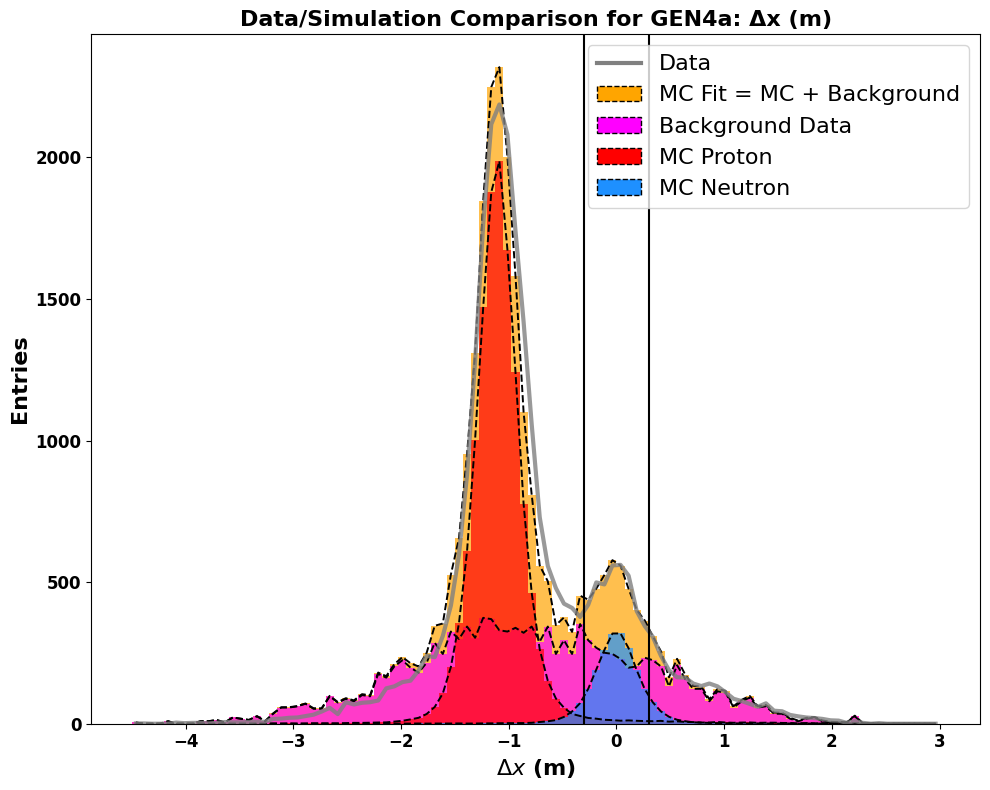

Total entries in fit: 27293.492221989305


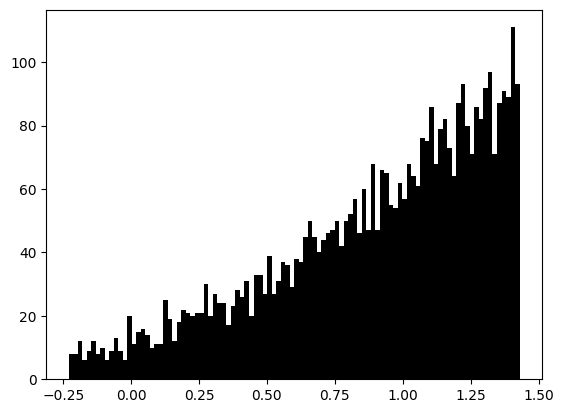

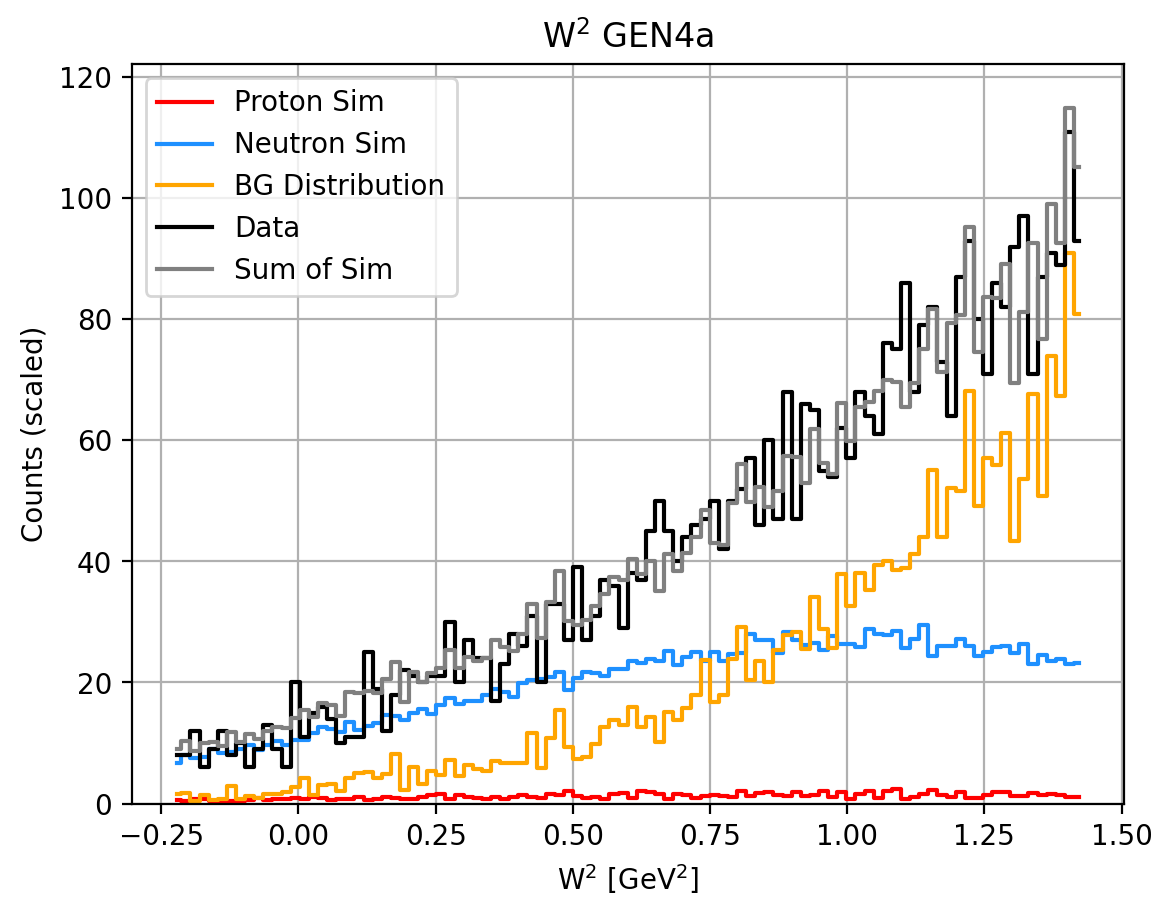

INELASTIC:  0 0.0005
Total events in range (-0.30000000000000004, 0.30000000000000004):
  Sim Proton:   107.02
  Sim Neutron:  1790.54
  Background:   1922.43
  Total:        3797.00
Fraction of events in range (-0.30000000000000004, 0.30000000000000004):
   Proton Fraction: 0.03
   Background Fraction: 0.51
   Neutron Fraction from fit: 0.47
   Neutron Fraction: 0.47
__________________________________________________
Target Weighted Avg: 0.534+-0.0198  3.7008%
Beam Weighted Avg: 0.838+-0.0010  0.1247%
__________________________________________________
epsilon = 0.5752
tau_avg = 2.7613
Q2 = 9.7506
Px: 0.9915 Pz: -0.0288
A = 0.05035 ± 0.01692 ± 0.00251
B = 0.41713 (no propagated error)
C = 0.21816 ± 0.08121 ± 0.01207
__________________________________________________
N_plus: 1954 N_minus: 1778
A_raw: 0.0472+=0.0164
A_raw_weighted: 0.0437+-0.0156  35.6634%
__________________________________________________
A_phys_weighted: 0.242
A_phys_stat_error: 0.0812  33.6020%
A_phys_sys_error: 0.012

In [113]:
#rel_contribs,_,statdict,Q2_avg=DoItAll(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin)
rel_contribs,_,statdict,Q2_avg=DoItAll(new_W2min,new_W2max,new_coinmin,new_coinmax,
                                       new_dymin,new_dymax,new_dxmin,new_dxmax,new_hcalmin,.15,epmin,extracut=False,
                                       cluscut=0)

for key in statdict:
    print(key,statdict[key])


In [45]:
gen=[]
gensys=[]
genstat=[]
araw=[]
arawerror=[]
aphysstaterror=[]
aphyssyserror=[]
cutindex=[]
jindex=[]
stepsize=30
print("Starting ps")
for i in range(0,stepsize):
    for j in range(0,1):
        #print(i)
        try: _,_,stats1,_=DoItAll(new_W2min,new_W2max,new_coinmin,new_coinmax,new_dymin,new_dymax,
                                  new_dxmin,new_dxmax,new_hcalmin,.15,.5+i/60,False,False,extracut=False,
                                  cluscut=j)
        except:
            continue
        cutindex.append(i)
        jindex.append(j)
        A=stats1['GE/GM * muN']
        B=stats1['GE/GM_stat_error']
        C=stats1['GE/GM_sys_error']
        D=stats1['A_raw']
        E=stats1['A_raw_rel_error']
        F=stats1["A_phys_rel_sys_error"]
        G=stats1["A_phys_rel_sat_error"]
        
        gen.append(A)
        gensys.append(C)
        genstat.append(B)
        araw.append(D)
        arawerror.append(E)
        aphysstaterror.append(G)
        aphyssyserror.append(F)


Starting ps
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005
INELASTIC:  0 0.0005


/tmp/ipykernel_24673/3567663407.py:124: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_24673/3567663407.py:125: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


INELASTIC:  0 0.0005


/tmp/ipykernel_24673/3567663407.py:124: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_24673/3567663407.py:125: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


INELASTIC:  0 0.0005


/tmp/ipykernel_24673/3567663407.py:124: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_24673/3567663407.py:125: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


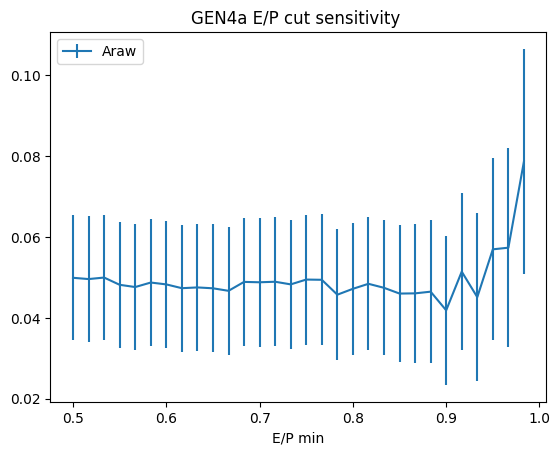

In [110]:
plt.errorbar(np.array(cutindex)/60+.5,np.array(araw),np.array(arawerror)*np.array(araw),label='Araw')
#plt.errorbar(np.array(cutindex)/30+.5,np.array(gen),np.array(genstat),label='Araw')
#plt.plot(np.array(cutindex)/30+.5,genstat,'.',label='Statistical uncertainty')
#plt.plot(np.array(cutindex)/70,araw,'.',label='araw')
#plt.plot(np.array(cutindex)/20,np.array(gensys)*5,'.')
#plt.plot(np.array(cutindex)/20,(np.array(gensys)**2+np.array(genstat)**2)**(1/2),'.')
plt.legend(loc='upper left')
plt.title("GEN4a E/P cut sensitivity ")
plt.xlabel("E/P min")
minx=np.where(genstat==np.min(genstat))
miny=np.min(genstat)
#plt.plot(np.array(int(minx[0])//4/70),[miny],'.',markersize=15)
#plt.ylim(.03,.07)

In [114]:
araw

[0.04988009592326139,
 0.04956689124157844,
 0.04993968636911942,
 0.048149044277764334,
 0.047595920349684316,
 0.04870920603994155,
 0.04824883663972569,
 0.04731394775751602,
 0.0475012370113805,
 0.04728720756595321,
 0.04666332162568992,
 0.048866498740554154,
 0.04877432398281526,
 0.0489047376464595,
 0.048254620123203286,
 0.04944343774268703,
 0.049385941991115755,
 0.04570673712021136,
 0.04715969989281887,
 0.048395867319195214,
 0.04740781813141114,
 0.045986860896886604,
 0.04603504603504603,
 0.04645323289391086,
 0.041850969717591016,
 0.05139833711262283,
 0.045099739809193407,
 0.056910569105691054,
 0.05731707317073171,
 0.07859922178988327]

In [76]:
np.array(arawerror)*np.array(araw)

array([0.01625787, 0.01626021, 0.01627975, 0.0163072 , 0.01633363,
       0.01636259, 0.01638689, 0.01641288, 0.01643097, 0.0164665 ,
       0.01654318, 0.01663592, 0.01673289, 0.01686144, 0.01697433,
       0.01711213, 0.01727617, 0.01746701, 0.01769272, 0.01792483,
       0.01820502, 0.01856093, 0.01891867, 0.01931332, 0.01979862,
       0.02026364, 0.02085356, 0.0215003 , 0.02219172, 0.02297527])

Text(0, 0.5, 'Araw')

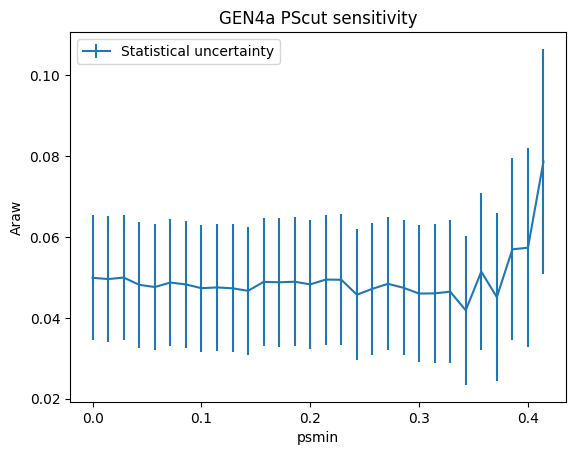

In [61]:
#plt.plot(np.array(cutindex)/70,np.array(gen),'.',label='Scaled GEn/GMn')
#plt.plot(np.array(cutindex)/70,genstat,'.',label='Statistical uncertainty')
plt.errorbar(np.array(cutindex)/70,araw,np.array(arawerror)*np.array(araw),label='Statistical uncertainty')
#plt.plot(np.array(cutindex)/20,np.array(gensys)*5,'.')
#plt.plot(np.array(cutindex)/20,(np.array(gensys)**2+np.array(genstat)**2)**(1/2),'.')
plt.legend(loc='upper left')
plt.title("GEN4a PScut sensitivity")
plt.xlabel("psmin")
minx=np.where(genstat==np.min(genstat))
miny=np.min(genstat)
plt.ylabel("Araw")
#plt.plot(np.array(int(minx[0])//5/70),[miny],'.',markersize=15)


In [602]:
minx

(array([30]),)

In [607]:
30//3

10

In [397]:
int(44)%5

4

Text(0.5, 0, 'psmin')

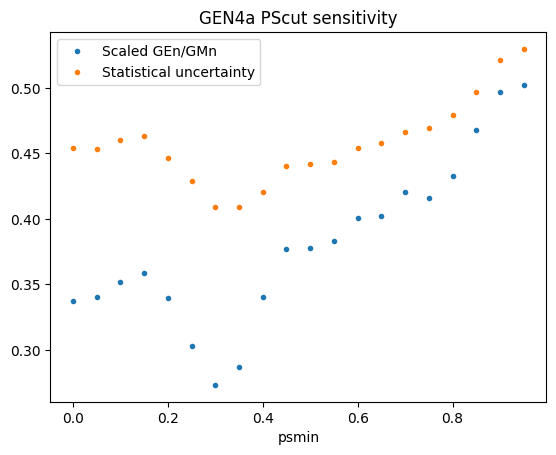

In [214]:
plt.plot(np.array(cutindex)/20,np.array(gen)/3,'.',label='Scaled GEn/GMn')
plt.plot(np.array(cutindex)/20,genstat,'.',label='Statistical uncertainty')
#plt.plot(np.array(cutindex)/20,np.array(gensys)*5,'.')
#plt.plot(np.array(cutindex)/20,(np.array(gensys)**2+np.array(genstat)**2)**(1/2),'.')
plt.legend(loc='upper left')
plt.title("GEN4a PScut sensitivity")
plt.xlabel("psmin")

Starting W2
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  1.  1.  3.
  2.  0.  0.  1.  0.  1.  0.  1.  0.  2.  3.  4.  2.  2.  2.  4.  2.  4.
  1.  6.  5.  6. 13. 12. 15. 17. 32. 29. 27. 18. 17. 14.  6.  9.  7.  5.
 10.  4.  8. 11.  6.  4.  6.  9.  5.  7.  6.  5.  3.  2.  4.  4.  0.  3.
  2.  1.  1.  1.  2.  1.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
389332 387284
INELASTIC:  0.0026370819040555434 0.001134737279714401
[  0.   1.   1.   1.   0.   1.   2.   3.   0.   3.   3.   6.   3.   9.
   8.   9.  10.  13.  12.  10.  14.  14.  14.  21.  22.  23.  27.  41.
  52.  34.  49.  46.  52.  67.  63.  69.  79.  93.  92. 112. 146. 203.
 262. 343. 399. 392. 392. 310. 254. 222. 157. 143. 113. 108. 112.  92.
  96. 105. 127. 102. 118. 110.  88.  73.  68.  64.  53.  49.  52.  46.
  36.  42.  49.  31.  33.  24.  18.  25.  16.  16.  16.   9.  10.  13.
   2.   8.   2.   2.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]


/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


389332 387284
INELASTIC:  0.0026370819040555434 0.001134737279714401


/tmp/ipykernel_6988/194937838.py:289: RuntimeWarning: invalid value encountered in sqrt
  ratio=(-B+np.sqrt(B**2-4*A*C))/(2*A)
/tmp/ipykernel_6988/194937838.py:292: RuntimeWarning: invalid value encountered in sqrt
  ratio_error_stat = np.sqrt(((C / (A * np.sqrt(discriminant)) + ratio / A)**2) * A_error_stat**2 + (C_error_stat**2 / discriminant))
/tmp/ipykernel_6988/194937838.py:293: RuntimeWarning: invalid value encountered in sqrt
  ratio_error_sys = np.sqrt(((C / (A * np.sqrt(discriminant)) + ratio / A)**2) * A_error_sys**2 + (C_error_sys**2 / discriminant))


[  0.   2.   2.   2.   1.   3.   3.   7.   4.   6.   6.  12.   7.  15.
  12.  16.  18.  22.  18.  30.  27.  28.  32.  36.  48.  41.  62.  67.
  89.  78.  85.  80.  95. 119. 122. 118. 144. 159. 182. 202. 275. 374.
 474. 622. 787. 752. 731. 604. 485. 429. 286. 286. 230. 209. 209. 183.
 201. 202. 236. 228. 208. 202. 163. 149. 133. 114. 111.  81.  93.  83.
  76.  77.  88.  65.  55.  50.  36.  39.  33.  32.  28.  25.  16.  21.
   9.  12.   5.   4.   1.   4.   4.   1.   1.   1.   1.   0.   0.   0.
   0.   0.]
[1.000e+00 4.000e+00 2.000e+00 3.000e+00 1.000e+00 1.000e+01 6.000e+00
 1.000e+01 5.000e+00 6.000e+00 1.000e+01 1.300e+01 1.000e+01 1.900e+01
 2.100e+01 1.800e+01 2.700e+01 2.300e+01 2.800e+01 3.600e+01 4.400e+01
 5.200e+01 4.300e+01 5.600e+01 6.600e+01 5.500e+01 8.500e+01 8.200e+01
 1.250e+02 1.070e+02 1.110e+02 1.040e+02 1.330e+02 1.690e+02 1.700e+02
 1.750e+02 2.150e+02 2.310e+02 2.630e+02 2.950e+02 3.960e+02 5.500e+02
 6.890e+02 8.920e+02 1.117e+03 1.092e+03 1.059e+03 8.690e+02 7.21

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[1.000e+00 4.000e+00 2.000e+00 3.000e+00 2.000e+00 1.500e+01 1.000e+01
 1.000e+01 8.000e+00 7.000e+00 1.300e+01 1.600e+01 1.200e+01 2.400e+01
 2.600e+01 2.300e+01 3.700e+01 2.900e+01 3.200e+01 5.100e+01 5.500e+01
 6.500e+01 5.800e+01 7.600e+01 8.700e+01 6.700e+01 1.060e+02 1.020e+02
 1.460e+02 1.320e+02 1.340e+02 1.400e+02 1.740e+02 2.170e+02 2.290e+02
 2.200e+02 2.880e+02 2.880e+02 3.450e+02 3.800e+02 5.170e+02 7.230e+02
 9.130e+02 1.198e+03 1.428e+03 1.419e+03 1.370e+03 1.136e+03 9.470e+02
 7.610e+02 5.350e+02 4.920e+02 4.240e+02 3.790e+02 3.840e+02 3.620e+02
 3.660e+02 3.810e+02 3.960e+02 4.280e+02 4.050e+02 3.890e+02 3.180e+02
 2.820e+02 2.480e+02 2.230e+02 2.000e+02 1.490e+02 1.610e+02 1.570e+02
 1.510e+02 1.480e+02 1.540e+02 1.270e+02 1.010e+02 8.700e+01 7.600e+01
 7.900e+01 6.400e+01 6.000e+01 4.800e+01 4.100e+01 3.300e+01 4.200e+01
 2.000e+01 2.200e+01 1.100e+01 1.300e+01 3.000e+00 1.000e+01 6.000e+00
 2.000e+00 2.000e+00 2.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


389332 387284
INELASTIC:  0.0026370819040555434 0.001134737279714401


/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[2.000e+00 4.000e+00 3.000e+00 4.000e+00 3.000e+00 1.600e+01 1.100e+01
 1.200e+01 1.200e+01 1.400e+01 1.500e+01 2.300e+01 1.600e+01 3.000e+01
 4.000e+01 3.300e+01 4.700e+01 4.600e+01 4.100e+01 7.100e+01 7.700e+01
 8.800e+01 9.000e+01 1.060e+02 1.180e+02 1.020e+02 1.470e+02 1.490e+02
 1.930e+02 1.900e+02 2.040e+02 2.210e+02 2.570e+02 3.010e+02 3.340e+02
 3.320e+02 4.020e+02 4.140e+02 4.650e+02 5.340e+02 7.540e+02 9.970e+02
 1.298e+03 1.690e+03 1.970e+03 2.008e+03 1.919e+03 1.600e+03 1.351e+03
 1.057e+03 7.980e+02 6.870e+02 6.130e+02 5.590e+02 5.460e+02 4.950e+02
 5.180e+02 5.490e+02 5.890e+02 5.930e+02 6.030e+02 5.580e+02 4.560e+02
 4.140e+02 3.640e+02 3.270e+02 2.870e+02 2.300e+02 2.430e+02 2.270e+02
 2.170e+02 2.090e+02 2.090e+02 1.830e+02 1.300e+02 1.290e+02 9.700e+01
 1.120e+02 1.050e+02 9.300e+01 7.700e+01 5.900e+01 4.400e+01 5.300e+01
 3.100e+01 3.600e+01 1.900e+01 1.900e+01 6.000e+00 1.200e+01 1.500e+01
 3.000e+00 2.000e+00 3.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 5.000e+00 3.000e+00 6.000e+00 3.000e+00 1.600e+01 1.200e+01
 1.400e+01 1.400e+01 1.600e+01 1.800e+01 2.900e+01 2.200e+01 3.600e+01
 4.400e+01 3.700e+01 5.200e+01 5.200e+01 5.300e+01 8.100e+01 8.800e+01
 1.010e+02 1.070e+02 1.190e+02 1.340e+02 1.200e+02 1.640e+02 1.650e+02
 2.180e+02 2.120e+02 2.390e+02 2.620e+02 3.110e+02 3.560e+02 3.750e+02
 3.810e+02 4.590e+02 4.750e+02 5.400e+02 6.110e+02 8.750e+02 1.123e+03
 1.494e+03 1.907e+03 2.249e+03 2.280e+03 2.170e+03 1.828e+03 1.567e+03
 1.206e+03 9.030e+02 7.730e+02 7.110e+02 6.430e+02 6.300e+02 5.570e+02
 6.160e+02 6.330e+02 6.660e+02 6.940e+02 6.850e+02 6.350e+02 5.110e+02
 4.710e+02 4.160e+02 3.720e+02 3.250e+02 2.740e+02 2.750e+02 2.580e+02
 2.390e+02 2.350e+02 2.440e+02 2.050e+02 1.460e+02 1.460e+02 1.210e+02
 1.250e+02 1.210e+02 1.020e+02 8.900e+01 7.000e+01 5.000e+01 5.700e+01
 3.600e+01 3.900e+01 2.200e+01 2.200e+01 8.000e+00 1.200e+01 1.600e+01
 3.000e+00 2.000e+00 3.000e+00 2.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 6.000e+00 4.000e+00 6.000e+00 3.000e+00 1.600e+01 1.300e+01
 1.400e+01 1.400e+01 2.000e+01 2.300e+01 3.200e+01 2.500e+01 3.900e+01
 4.700e+01 4.600e+01 5.800e+01 6.000e+01 5.700e+01 8.800e+01 9.900e+01
 1.120e+02 1.190e+02 1.320e+02 1.530e+02 1.310e+02 1.860e+02 1.970e+02
 2.400e+02 2.390e+02 2.820e+02 3.010e+02 3.500e+02 4.040e+02 4.170e+02
 4.310e+02 5.290e+02 5.350e+02 6.060e+02 6.910e+02 9.740e+02 1.237e+03
 1.677e+03 2.127e+03 2.462e+03 2.529e+03 2.443e+03 2.022e+03 1.790e+03
 1.361e+03 1.035e+03 8.570e+02 8.080e+02 7.290e+02 7.180e+02 6.340e+02
 6.910e+02 7.240e+02 7.350e+02 7.810e+02 7.560e+02 7.050e+02 5.790e+02
 5.310e+02 4.710e+02 4.180e+02 3.600e+02 3.060e+02 3.100e+02 3.040e+02
 2.750e+02 2.690e+02 2.680e+02 2.220e+02 1.700e+02 1.690e+02 1.420e+02
 1.430e+02 1.430e+02 1.140e+02 9.900e+01 8.200e+01 5.700e+01 6.200e+01
 3.900e+01 4.200e+01 2.400e+01 2.700e+01 9.000e+00 1.200e+01 1.700e+01
 3.000e+00 2.000e+00 4.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


389332 387284
INELASTIC:  0.0026370819040555434 0.001134737279714401


/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 6.000e+00 6.000e+00 7.000e+00 4.000e+00 1.800e+01 1.400e+01
 1.700e+01 1.700e+01 2.400e+01 2.500e+01 3.400e+01 3.400e+01 4.500e+01
 6.300e+01 5.600e+01 7.300e+01 7.400e+01 7.500e+01 1.030e+02 1.150e+02
 1.290e+02 1.510e+02 1.590e+02 1.850e+02 1.620e+02 2.360e+02 2.470e+02
 3.010e+02 2.990e+02 3.360e+02 3.720e+02 4.350e+02 5.140e+02 5.110e+02
 5.510e+02 6.510e+02 6.500e+02 7.430e+02 8.580e+02 1.180e+03 1.499e+03
 1.960e+03 2.542e+03 2.918e+03 3.024e+03 2.909e+03 2.407e+03 2.138e+03
 1.650e+03 1.279e+03 1.050e+03 9.860e+02 8.860e+02 8.750e+02 7.900e+02
 8.500e+02 9.010e+02 9.040e+02 9.680e+02 9.180e+02 8.910e+02 7.120e+02
 6.470e+02 5.820e+02 5.160e+02 4.400e+02 4.020e+02 3.810e+02 3.710e+02
 3.380e+02 3.350e+02 3.270e+02 2.610e+02 2.110e+02 2.060e+02 1.910e+02
 1.700e+02 1.720e+02 1.360e+02 1.180e+02 9.700e+01 7.100e+01 6.900e+01
 4.700e+01 5.100e+01 3.400e+01 3.300e+01 1.500e+01 1.800e+01 1.700e+01
 4.000e+00 3.000e+00 5.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


389332 387284
INELASTIC:  0.0026370819040555434 0.001134737279714401


/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 7.000e+00 8.000e+00 7.000e+00 5.000e+00 2.000e+01 1.500e+01
 1.700e+01 2.100e+01 2.700e+01 3.400e+01 3.600e+01 3.800e+01 5.100e+01
 7.400e+01 7.100e+01 8.800e+01 9.400e+01 1.010e+02 1.190e+02 1.380e+02
 1.540e+02 1.780e+02 1.930e+02 2.340e+02 2.040e+02 2.800e+02 2.980e+02
 3.560e+02 3.890e+02 4.130e+02 4.490e+02 5.210e+02 5.900e+02 6.220e+02
 6.620e+02 7.790e+02 7.710e+02 9.000e+02 1.046e+03 1.394e+03 1.738e+03
 2.274e+03 2.898e+03 3.359e+03 3.465e+03 3.363e+03 2.856e+03 2.480e+03
 1.929e+03 1.530e+03 1.256e+03 1.174e+03 1.055e+03 1.039e+03 9.830e+02
 1.042e+03 1.071e+03 1.072e+03 1.161e+03 1.088e+03 1.058e+03 8.510e+02
 7.820e+02 7.150e+02 6.110e+02 5.460e+02 4.740e+02 4.630e+02 4.390e+02
 4.090e+02 4.020e+02 4.010e+02 3.280e+02 2.650e+02 2.480e+02 2.290e+02
 1.990e+02 2.110e+02 1.540e+02 1.480e+02 1.190e+02 8.800e+01 7.700e+01
 6.100e+01 6.000e+01 4.200e+01 3.300e+01 1.900e+01 2.500e+01 2.000e+01
 8.000e+00 4.000e+00 7.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


389332 387284
INELASTIC:  0.0026370819040555434 0.001134737279714401
[4.000e+00 8.000e+00 8.000e+00 7.000e+00 7.000e+00 2.200e+01 1.800e+01
 1.900e+01 2.400e+01 3.000e+01 3.900e+01 4.800e+01 4.600e+01 5.500e+01
 8.200e+01 8.400e+01 1.020e+02 1.110e+02 1.220e+02 1.450e+02 1.660e+02
 1.860e+02 2.030e+02 2.210e+02 2.710e+02 2.310e+02 3.340e+02 3.410e+02
 4.190e+02 4.570e+02 4.870e+02 5.560e+02 6.050e+02 7.120e+02 7.300e+02
 7.920e+02 9.100e+02 9.170e+02 1.085e+03 1.233e+03 1.592e+03 2.001e+03
 2.560e+03 3.281e+03 3.800e+03 3.914e+03 3.818e+03 3.278e+03 2.889e+03
 2.250e+03 1.816e+03 1.503e+03 1.396e+03 1.244e+03 1.223e+03 1.181e+03
 1.199e+03 1.257e+03 1.243e+03 1.335e+03 1.257e+03 1.220e+03 1.004e+03
 9.100e+02 8.190e+02 7.130e+02 6.640e+02 5.870e+02 5.490e+02 5.230e+02
 4.850e+02 4.830e+02 4.540e+02 3.930e+02 3.220e+02 2.860e+02 2.670e+02
 2.330e+02 2.460e+02 1.940e+02 1.750e+02 1.310e+02 1.000e+02 9.200e+01
 6.700e+01 6.900e+01 4.600e+01 4.300e+01 2.300e+01 3.100e+01 2.200e+01
 1.000e+

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5
/tmp/ipykernel_6988/1771388183.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(dpi=200)


143068 141537
INELASTIC:  0.005379385464064229 0.0018744439273916686
[3.000e+00 7.000e+00 8.000e+00 7.000e+00 5.000e+00 2.000e+01 1.500e+01
 1.700e+01 2.100e+01 2.700e+01 3.400e+01 3.600e+01 3.800e+01 5.100e+01
 7.400e+01 7.100e+01 8.800e+01 9.400e+01 1.010e+02 1.190e+02 1.380e+02
 1.540e+02 1.780e+02 1.930e+02 2.340e+02 2.040e+02 2.800e+02 2.980e+02
 3.560e+02 3.890e+02 4.130e+02 4.490e+02 5.210e+02 5.900e+02 6.220e+02
 6.620e+02 7.790e+02 7.710e+02 9.000e+02 1.046e+03 1.394e+03 1.738e+03
 2.274e+03 2.898e+03 3.359e+03 3.465e+03 3.363e+03 2.856e+03 2.480e+03
 1.929e+03 1.530e+03 1.256e+03 1.174e+03 1.055e+03 1.039e+03 9.830e+02
 1.042e+03 1.071e+03 1.072e+03 1.161e+03 1.088e+03 1.058e+03 8.510e+02
 7.820e+02 7.150e+02 6.110e+02 5.460e+02 4.740e+02 4.630e+02 4.390e+02
 4.090e+02 4.020e+02 4.010e+02 3.280e+02 2.650e+02 2.480e+02 2.290e+02
 1.990e+02 2.110e+02 1.540e+02 1.480e+02 1.190e+02 8.800e+01 7.700e+01
 6.100e+01 6.000e+01 4.200e+01 3.300e+01 1.900e+01 2.500e+01 2.000e+01
 8.000e+

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 7.000e+00 8.000e+00 7.000e+00 5.000e+00 2.000e+01 1.500e+01
 1.700e+01 2.100e+01 2.700e+01 3.400e+01 3.600e+01 3.800e+01 5.100e+01
 7.400e+01 7.100e+01 8.800e+01 9.400e+01 1.010e+02 1.190e+02 1.380e+02
 1.540e+02 1.780e+02 1.930e+02 2.340e+02 2.040e+02 2.800e+02 2.980e+02
 3.560e+02 3.890e+02 4.130e+02 4.490e+02 5.210e+02 5.900e+02 6.220e+02
 6.620e+02 7.790e+02 7.710e+02 9.000e+02 1.046e+03 1.394e+03 1.738e+03
 2.274e+03 2.898e+03 3.359e+03 3.465e+03 3.363e+03 2.856e+03 2.480e+03
 1.929e+03 1.530e+03 1.256e+03 1.174e+03 1.055e+03 1.039e+03 9.830e+02
 1.042e+03 1.071e+03 1.072e+03 1.161e+03 1.088e+03 1.058e+03 8.510e+02
 7.820e+02 7.150e+02 6.110e+02 5.460e+02 4.740e+02 4.630e+02 4.390e+02
 4.090e+02 4.020e+02 4.010e+02 3.280e+02 2.650e+02 2.480e+02 2.290e+02
 1.990e+02 2.110e+02 1.540e+02 1.480e+02 1.190e+02 8.800e+01 7.700e+01
 6.100e+01 6.000e+01 4.200e+01 3.300e+01 1.900e+01 2.500e+01 2.000e+01
 8.000e+00 4.000e+00 7.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403


/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 7.000e+00 8.000e+00 7.000e+00 5.000e+00 2.000e+01 1.500e+01
 1.700e+01 2.100e+01 2.700e+01 3.400e+01 3.600e+01 3.800e+01 5.100e+01
 7.400e+01 7.100e+01 8.800e+01 9.400e+01 1.010e+02 1.190e+02 1.380e+02
 1.540e+02 1.780e+02 1.930e+02 2.340e+02 2.040e+02 2.800e+02 2.980e+02
 3.560e+02 3.890e+02 4.130e+02 4.490e+02 5.210e+02 5.900e+02 6.220e+02
 6.620e+02 7.790e+02 7.710e+02 9.000e+02 1.046e+03 1.394e+03 1.738e+03
 2.274e+03 2.898e+03 3.359e+03 3.465e+03 3.363e+03 2.856e+03 2.480e+03
 1.929e+03 1.530e+03 1.256e+03 1.174e+03 1.055e+03 1.039e+03 9.830e+02
 1.042e+03 1.071e+03 1.072e+03 1.161e+03 1.088e+03 1.058e+03 8.510e+02
 7.820e+02 7.150e+02 6.110e+02 5.460e+02 4.740e+02 4.630e+02 4.390e+02
 4.090e+02 4.020e+02 4.010e+02 3.280e+02 2.650e+02 2.480e+02 2.290e+02
 1.990e+02 2.110e+02 1.540e+02 1.480e+02 1.190e+02 8.800e+01 7.700e+01
 6.100e+01 6.000e+01 4.200e+01 3.300e+01 1.900e+01 2.500e+01 2.000e+01
 8.000e+00 4.000e+00 7.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 7.000e+00 8.000e+00 7.000e+00 5.000e+00 2.000e+01 1.500e+01
 1.700e+01 2.100e+01 2.700e+01 3.400e+01 3.600e+01 3.800e+01 5.100e+01
 7.400e+01 7.100e+01 8.800e+01 9.400e+01 1.010e+02 1.190e+02 1.380e+02
 1.540e+02 1.780e+02 1.930e+02 2.340e+02 2.040e+02 2.800e+02 2.980e+02
 3.560e+02 3.890e+02 4.130e+02 4.490e+02 5.210e+02 5.900e+02 6.220e+02
 6.620e+02 7.790e+02 7.710e+02 9.000e+02 1.046e+03 1.394e+03 1.738e+03
 2.274e+03 2.898e+03 3.359e+03 3.465e+03 3.363e+03 2.856e+03 2.480e+03
 1.929e+03 1.530e+03 1.256e+03 1.174e+03 1.055e+03 1.039e+03 9.830e+02
 1.042e+03 1.071e+03 1.072e+03 1.161e+03 1.088e+03 1.058e+03 8.510e+02
 7.820e+02 7.150e+02 6.110e+02 5.460e+02 4.740e+02 4.630e+02 4.390e+02
 4.090e+02 4.020e+02 4.010e+02 3.280e+02 2.650e+02 2.480e+02 2.290e+02
 1.990e+02 2.110e+02 1.540e+02 1.480e+02 1.190e+02 8.800e+01 7.700e+01
 6.100e+01 6.000e+01 4.200e+01 3.300e+01 1.900e+01 2.500e+01 2.000e+01
 8.000e+00 4.000e+00 7.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 7.000e+00 8.000e+00 7.000e+00 5.000e+00 2.000e+01 1.500e+01
 1.700e+01 2.100e+01 2.700e+01 3.400e+01 3.600e+01 3.800e+01 5.100e+01
 7.400e+01 7.100e+01 8.800e+01 9.400e+01 1.010e+02 1.190e+02 1.380e+02
 1.540e+02 1.780e+02 1.930e+02 2.340e+02 2.040e+02 2.800e+02 2.980e+02
 3.560e+02 3.890e+02 4.130e+02 4.490e+02 5.210e+02 5.900e+02 6.220e+02
 6.620e+02 7.790e+02 7.710e+02 9.000e+02 1.046e+03 1.394e+03 1.738e+03
 2.274e+03 2.898e+03 3.359e+03 3.465e+03 3.363e+03 2.856e+03 2.480e+03
 1.929e+03 1.530e+03 1.256e+03 1.174e+03 1.055e+03 1.039e+03 9.830e+02
 1.042e+03 1.071e+03 1.072e+03 1.161e+03 1.088e+03 1.058e+03 8.510e+02
 7.820e+02 7.150e+02 6.110e+02 5.460e+02 4.740e+02 4.630e+02 4.390e+02
 4.090e+02 4.020e+02 4.010e+02 3.280e+02 2.650e+02 2.480e+02 2.290e+02
 1.990e+02 2.110e+02 1.540e+02 1.480e+02 1.190e+02 8.800e+01 7.700e+01
 6.100e+01 6.000e+01 4.200e+01 3.300e+01 1.900e+01 2.500e+01 2.000e+01
 8.000e+00 4.000e+00 7.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 7.000e+00 8.000e+00 7.000e+00 5.000e+00 2.000e+01 1.500e+01
 1.700e+01 2.100e+01 2.700e+01 3.400e+01 3.600e+01 3.800e+01 5.100e+01
 7.400e+01 7.100e+01 8.800e+01 9.400e+01 1.010e+02 1.190e+02 1.380e+02
 1.540e+02 1.780e+02 1.930e+02 2.340e+02 2.040e+02 2.800e+02 2.980e+02
 3.560e+02 3.890e+02 4.130e+02 4.490e+02 5.210e+02 5.900e+02 6.220e+02
 6.620e+02 7.790e+02 7.710e+02 9.000e+02 1.046e+03 1.394e+03 1.738e+03
 2.274e+03 2.898e+03 3.359e+03 3.465e+03 3.363e+03 2.856e+03 2.480e+03
 1.929e+03 1.530e+03 1.256e+03 1.174e+03 1.055e+03 1.039e+03 9.830e+02
 1.042e+03 1.071e+03 1.072e+03 1.161e+03 1.088e+03 1.058e+03 8.510e+02
 7.820e+02 7.150e+02 6.110e+02 5.460e+02 4.740e+02 4.630e+02 4.390e+02
 4.090e+02 4.020e+02 4.010e+02 3.280e+02 2.650e+02 2.480e+02 2.290e+02
 1.990e+02 2.110e+02 1.540e+02 1.480e+02 1.190e+02 8.800e+01 7.700e+01
 6.100e+01 6.000e+01 4.200e+01 3.300e+01 1.900e+01 2.500e+01 2.000e+01
 8.000e+00 4.000e+00 7.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


716183 712600
INELASTIC:  0.002507728605393541 0.0008365954481774188


/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 7.000e+00 8.000e+00 7.000e+00 5.000e+00 2.000e+01 1.500e+01
 1.700e+01 2.100e+01 2.700e+01 3.400e+01 3.600e+01 3.800e+01 5.100e+01
 7.400e+01 7.100e+01 8.800e+01 9.400e+01 1.010e+02 1.190e+02 1.380e+02
 1.540e+02 1.780e+02 1.930e+02 2.340e+02 2.040e+02 2.800e+02 2.980e+02
 3.560e+02 3.890e+02 4.130e+02 4.490e+02 5.210e+02 5.900e+02 6.220e+02
 6.620e+02 7.790e+02 7.710e+02 9.000e+02 1.046e+03 1.394e+03 1.738e+03
 2.274e+03 2.898e+03 3.359e+03 3.465e+03 3.363e+03 2.856e+03 2.480e+03
 1.929e+03 1.530e+03 1.256e+03 1.174e+03 1.055e+03 1.039e+03 9.830e+02
 1.042e+03 1.071e+03 1.072e+03 1.161e+03 1.088e+03 1.058e+03 8.510e+02
 7.820e+02 7.150e+02 6.110e+02 5.460e+02 4.740e+02 4.630e+02 4.390e+02
 4.090e+02 4.020e+02 4.010e+02 3.280e+02 2.650e+02 2.480e+02 2.290e+02
 1.990e+02 2.110e+02 1.540e+02 1.480e+02 1.190e+02 8.800e+01 7.700e+01
 6.100e+01 6.000e+01 4.200e+01 3.300e+01 1.900e+01 2.500e+01 2.000e+01
 8.000e+00 4.000e+00 7.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 7.000e+00 8.000e+00 7.000e+00 5.000e+00 2.000e+01 1.500e+01
 1.700e+01 2.100e+01 2.700e+01 3.400e+01 3.600e+01 3.800e+01 5.100e+01
 7.400e+01 7.100e+01 8.800e+01 9.400e+01 1.010e+02 1.190e+02 1.380e+02
 1.540e+02 1.780e+02 1.930e+02 2.340e+02 2.040e+02 2.800e+02 2.980e+02
 3.560e+02 3.890e+02 4.130e+02 4.490e+02 5.210e+02 5.900e+02 6.220e+02
 6.620e+02 7.790e+02 7.710e+02 9.000e+02 1.046e+03 1.394e+03 1.738e+03
 2.274e+03 2.898e+03 3.359e+03 3.465e+03 3.363e+03 2.856e+03 2.480e+03
 1.929e+03 1.530e+03 1.256e+03 1.174e+03 1.055e+03 1.039e+03 9.830e+02
 1.042e+03 1.071e+03 1.072e+03 1.161e+03 1.088e+03 1.058e+03 8.510e+02
 7.820e+02 7.150e+02 6.110e+02 5.460e+02 4.740e+02 4.630e+02 4.390e+02
 4.090e+02 4.020e+02 4.010e+02 3.280e+02 2.650e+02 2.480e+02 2.290e+02
 1.990e+02 2.110e+02 1.540e+02 1.480e+02 1.190e+02 8.800e+01 7.700e+01
 6.100e+01 6.000e+01 4.200e+01 3.300e+01 1.900e+01 2.500e+01 2.000e+01
 8.000e+00 4.000e+00 7.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 7.000e+00 8.000e+00 7.000e+00 5.000e+00 2.000e+01 1.500e+01
 1.700e+01 2.100e+01 2.700e+01 3.400e+01 3.600e+01 3.800e+01 5.100e+01
 7.400e+01 7.100e+01 8.800e+01 9.400e+01 1.010e+02 1.190e+02 1.380e+02
 1.540e+02 1.780e+02 1.930e+02 2.340e+02 2.040e+02 2.800e+02 2.980e+02
 3.560e+02 3.890e+02 4.130e+02 4.490e+02 5.210e+02 5.900e+02 6.220e+02
 6.620e+02 7.790e+02 7.710e+02 9.000e+02 1.046e+03 1.394e+03 1.738e+03
 2.274e+03 2.898e+03 3.359e+03 3.465e+03 3.363e+03 2.856e+03 2.480e+03
 1.929e+03 1.530e+03 1.256e+03 1.174e+03 1.055e+03 1.039e+03 9.830e+02
 1.042e+03 1.071e+03 1.072e+03 1.161e+03 1.088e+03 1.058e+03 8.510e+02
 7.820e+02 7.150e+02 6.110e+02 5.460e+02 4.740e+02 4.630e+02 4.390e+02
 4.090e+02 4.020e+02 4.010e+02 3.280e+02 2.650e+02 2.480e+02 2.290e+02
 1.990e+02 2.110e+02 1.540e+02 1.480e+02 1.190e+02 8.800e+01 7.700e+01
 6.100e+01 6.000e+01 4.200e+01 3.300e+01 1.900e+01 2.500e+01 2.000e+01
 8.000e+00 4.000e+00 7.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 7.000e+00 8.000e+00 7.000e+00 5.000e+00 2.000e+01 1.500e+01
 1.700e+01 2.100e+01 2.700e+01 3.400e+01 3.600e+01 3.800e+01 5.100e+01
 7.400e+01 7.100e+01 8.800e+01 9.400e+01 1.010e+02 1.190e+02 1.380e+02
 1.540e+02 1.780e+02 1.930e+02 2.340e+02 2.040e+02 2.800e+02 2.980e+02
 3.560e+02 3.890e+02 4.130e+02 4.490e+02 5.210e+02 5.900e+02 6.220e+02
 6.620e+02 7.790e+02 7.710e+02 9.000e+02 1.046e+03 1.394e+03 1.738e+03
 2.274e+03 2.898e+03 3.359e+03 3.465e+03 3.363e+03 2.856e+03 2.480e+03
 1.929e+03 1.530e+03 1.256e+03 1.174e+03 1.055e+03 1.039e+03 9.830e+02
 1.042e+03 1.071e+03 1.072e+03 1.161e+03 1.088e+03 1.058e+03 8.510e+02
 7.820e+02 7.150e+02 6.110e+02 5.460e+02 4.740e+02 4.630e+02 4.390e+02
 4.090e+02 4.020e+02 4.010e+02 3.280e+02 2.650e+02 2.480e+02 2.290e+02
 1.990e+02 2.110e+02 1.540e+02 1.480e+02 1.190e+02 8.800e+01 7.700e+01
 6.100e+01 6.000e+01 4.200e+01 3.300e+01 1.900e+01 2.500e+01 2.000e+01
 8.000e+00 4.000e+00 7.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 7.000e+00 8.000e+00 7.000e+00 5.000e+00 2.000e+01 1.500e+01
 1.700e+01 2.100e+01 2.700e+01 3.400e+01 3.600e+01 3.800e+01 5.100e+01
 7.400e+01 7.100e+01 8.800e+01 9.400e+01 1.010e+02 1.190e+02 1.380e+02
 1.540e+02 1.780e+02 1.930e+02 2.340e+02 2.040e+02 2.800e+02 2.980e+02
 3.560e+02 3.890e+02 4.130e+02 4.490e+02 5.210e+02 5.900e+02 6.220e+02
 6.620e+02 7.790e+02 7.710e+02 9.000e+02 1.046e+03 1.394e+03 1.738e+03
 2.274e+03 2.898e+03 3.359e+03 3.465e+03 3.363e+03 2.856e+03 2.480e+03
 1.929e+03 1.530e+03 1.256e+03 1.174e+03 1.055e+03 1.039e+03 9.830e+02
 1.042e+03 1.071e+03 1.072e+03 1.161e+03 1.088e+03 1.058e+03 8.510e+02
 7.820e+02 7.150e+02 6.110e+02 5.460e+02 4.740e+02 4.630e+02 4.390e+02
 4.090e+02 4.020e+02 4.010e+02 3.280e+02 2.650e+02 2.480e+02 2.290e+02
 1.990e+02 2.110e+02 1.540e+02 1.480e+02 1.190e+02 8.800e+01 7.700e+01
 6.100e+01 6.000e+01 4.200e+01 3.300e+01 1.900e+01 2.500e+01 2.000e+01
 8.000e+00 4.000e+00 7.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403
[2.000e+00 3.000e+00 2.000e+00 1.000e+00 0.000e+00 7.000e+00 4.000e+00
 6.000e+00 7.000e+00 9.000e+00 5.000e+00 9.000e+00 9.000e+00 1.000e+01
 1.600e+01 1.800e+01 1.900e+01 2.900e+01 2.300e+01 3.500e+01 2.700e+01
 5.200e+01 5.500e+01 4.500e+01 6.900e+01 6.200e+01 8.800e+01 7.500e+01
 1.080e+02 1.050e+02 1.010e+02 1.170e+02 1.400e+02 1.680e+02 1.660e+02
 1.680e+02 2.250e+02 2.340e+02 2.810e+02 3.530e+02 4.950e+02 7.310e+02
 9.640e+02 1.373e+03 1.602e+03 1.638e+03 1.629e+03 1.297e+03 1.067e+03
 7.630e+02 5.500e+02 4.170e+02 3.460e+02 2.990e+02 3.040e+02 2.710e+02
 3.080e+02 3.730e+02 3.590e+02 4.270e+02 4.080e+02 3.980e+02 3.020e+02
 2.600e+02 2.130e+02 1.780e+02 1.500e+02 1.210e+02 1.120e+02 1.240e+02
 1.080e+02 1.040e+02 1.080e+02 1.110e+02 6.100e+01 5.800e+01 6.600e+01
 5.200e+01 6.500e+01 4.400e+01 4.100e+01 2.700e+01 2.400e+01 2.800e+01
 1.400e+01 1.100e+01 9.000e+00 4.000e+00 6.000e+00 8.000e+00 3.000e+00
 0.000e

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403
[2.000e+00 4.000e+00 2.000e+00 1.000e+00 3.000e+00 8.000e+00 5.000e+00
 7.000e+00 7.000e+00 1.000e+01 1.000e+01 1.300e+01 1.300e+01 1.500e+01
 1.900e+01 2.200e+01 2.600e+01 3.800e+01 2.800e+01 4.200e+01 3.700e+01
 6.300e+01 6.300e+01 5.500e+01 8.600e+01 7.500e+01 1.010e+02 9.900e+01
 1.330e+02 1.320e+02 1.380e+02 1.500e+02 1.820e+02 2.030e+02 2.060e+02
 2.120e+02 2.670e+02 2.750e+02 3.470e+02 4.330e+02 6.000e+02 8.750e+02
 1.137e+03 1.624e+03 1.907e+03 1.937e+03 1.940e+03 1.551e+03 1.294e+03
 9.250e+02 6.720e+02 4.940e+02 4.170e+02 3.850e+02 3.820e+02 3.490e+02
 3.800e+02 4.480e+02 4.410e+02 5.140e+02 4.990e+02 4.690e+02 3.660e+02
 3.140e+02 2.640e+02 2.220e+02 1.810e+02 1.470e+02 1.400e+02 1.440e+02
 1.420e+02 1.360e+02 1.330e+02 1.200e+02 8.000e+01 8.100e+01 7.400e+01
 6.500e+01 7.400e+01 5.700e+01 5.100e+01 3.500e+01 2.500e+01 3.600e+01
 1.900e+01 1.800e+01 1.100e+01 5.000e+00 8.000e+00 1.000e+01 6.000e+00
 0.000e

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403
[2.000e+00 4.000e+00 3.000e+00 1.000e+00 4.000e+00 8.000e+00 6.000e+00
 9.000e+00 8.000e+00 1.000e+01 1.300e+01 1.600e+01 1.400e+01 1.800e+01
 2.300e+01 2.600e+01 3.100e+01 4.200e+01 3.500e+01 5.000e+01 4.800e+01
 6.900e+01 7.700e+01 7.100e+01 1.020e+02 8.700e+01 1.200e+02 1.240e+02
 1.490e+02 1.540e+02 1.600e+02 1.880e+02 2.160e+02 2.400e+02 2.480e+02
 2.560e+02 3.180e+02 3.150e+02 4.070e+02 5.040e+02 7.020e+02 9.860e+02
 1.301e+03 1.847e+03 2.171e+03 2.201e+03 2.189e+03 1.782e+03 1.485e+03
 1.071e+03 7.600e+02 6.050e+02 4.910e+02 4.630e+02 4.460e+02 4.180e+02
 4.570e+02 5.150e+02 4.930e+02 5.960e+02 5.800e+02 5.380e+02 4.360e+02
 3.700e+02 3.100e+02 2.580e+02 2.160e+02 1.800e+02 1.750e+02 1.690e+02
 1.720e+02 1.520e+02 1.590e+02 1.460e+02 9.400e+01 9.700e+01 8.900e+01
 7.300e+01 9.300e+01 6.400e+01 6.400e+01 4.100e+01 3.600e+01 4.000e+01
 2.000e+01 1.900e+01 1.400e+01 8.000e+00 1.000e+01 1.100e+01 6.000e+00
 0.000e

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403


/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[2.000e+00 4.000e+00 4.000e+00 1.000e+00 4.000e+00 1.000e+01 6.000e+00
 1.000e+01 9.000e+00 1.100e+01 1.300e+01 1.700e+01 1.800e+01 2.000e+01
 2.700e+01 3.000e+01 3.900e+01 4.300e+01 4.000e+01 5.800e+01 5.500e+01
 7.700e+01 8.300e+01 7.900e+01 1.160e+02 9.900e+01 1.370e+02 1.410e+02
 1.660e+02 1.860e+02 1.840e+02 2.160e+02 2.470e+02 2.810e+02 2.960e+02
 2.930e+02 3.670e+02 3.650e+02 4.620e+02 5.720e+02 7.950e+02 1.099e+03
 1.473e+03 2.032e+03 2.380e+03 2.437e+03 2.406e+03 1.973e+03 1.654e+03
 1.210e+03 8.510e+02 6.610e+02 5.630e+02 5.190e+02 5.060e+02 4.850e+02
 5.390e+02 5.740e+02 5.590e+02 6.610e+02 6.460e+02 6.020e+02 4.930e+02
 4.020e+02 3.580e+02 2.960e+02 2.610e+02 1.970e+02 2.050e+02 1.910e+02
 1.960e+02 1.790e+02 1.880e+02 1.640e+02 1.090e+02 1.100e+02 1.070e+02
 8.300e+01 1.040e+02 7.600e+01 7.500e+01 4.500e+01 4.000e+01 4.500e+01
 2.600e+01 2.700e+01 1.700e+01 1.200e+01 1.200e+01 1.400e+01 7.000e+00
 0.000e+00 2.000e+00 3.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[2.000e+00 4.000e+00 5.000e+00 1.000e+00 4.000e+00 1.100e+01 7.000e+00
 1.000e+01 9.000e+00 1.400e+01 1.500e+01 1.800e+01 1.800e+01 2.400e+01
 3.200e+01 3.500e+01 4.600e+01 4.700e+01 4.300e+01 6.200e+01 6.000e+01
 8.600e+01 8.800e+01 9.200e+01 1.280e+02 1.070e+02 1.560e+02 1.600e+02
 1.840e+02 2.040e+02 2.050e+02 2.320e+02 2.820e+02 3.200e+02 3.310e+02
 3.410e+02 4.200e+02 4.150e+02 5.070e+02 6.340e+02 8.780e+02 1.199e+03
 1.608e+03 2.169e+03 2.554e+03 2.650e+03 2.581e+03 2.111e+03 1.795e+03
 1.305e+03 9.390e+02 7.440e+02 6.450e+02 5.840e+02 5.810e+02 5.420e+02
 5.880e+02 6.390e+02 6.300e+02 7.310e+02 7.030e+02 6.670e+02 5.460e+02
 4.540e+02 4.050e+02 3.330e+02 2.920e+02 2.270e+02 2.330e+02 2.200e+02
 2.180e+02 1.990e+02 2.180e+02 1.830e+02 1.300e+02 1.240e+02 1.270e+02
 9.100e+01 1.120e+02 8.500e+01 8.000e+01 5.200e+01 4.200e+01 5.000e+01
 2.900e+01 3.400e+01 2.000e+01 1.400e+01 1.300e+01 1.500e+01 9.000e+00
 0.000e+00 4.000e+00 3.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[2.000e+00 5.000e+00 6.000e+00 1.000e+00 4.000e+00 1.200e+01 9.000e+00
 1.000e+01 1.000e+01 1.700e+01 1.900e+01 2.000e+01 1.900e+01 2.600e+01
 3.700e+01 3.700e+01 5.000e+01 5.000e+01 5.100e+01 6.900e+01 7.000e+01
 9.300e+01 9.700e+01 9.900e+01 1.410e+02 1.130e+02 1.700e+02 1.720e+02
 2.040e+02 2.250e+02 2.330e+02 2.550e+02 3.040e+02 3.500e+02 3.600e+02
 3.870e+02 4.600e+02 4.640e+02 5.670e+02 6.920e+02 9.570e+02 1.272e+03
 1.726e+03 2.303e+03 2.706e+03 2.807e+03 2.719e+03 2.249e+03 1.908e+03
 1.401e+03 1.017e+03 8.100e+02 7.120e+02 6.470e+02 6.360e+02 6.080e+02
 6.410e+02 7.000e+02 6.970e+02 7.820e+02 7.600e+02 7.200e+02 5.850e+02
 5.000e+02 4.470e+02 3.710e+02 3.280e+02 2.620e+02 2.640e+02 2.450e+02
 2.390e+02 2.320e+02 2.450e+02 2.010e+02 1.500e+02 1.430e+02 1.390e+02
 1.020e+02 1.220e+02 9.100e+01 8.700e+01 5.900e+01 4.800e+01 5.400e+01
 3.200e+01 3.900e+01 2.400e+01 1.500e+01 1.300e+01 1.700e+01 9.000e+00
 1.000e+00 4.000e+00 4.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 6.000e+00 6.000e+00 6.000e+00 4.000e+00 1.500e+01 1.100e+01
 1.600e+01 1.300e+01 2.200e+01 2.600e+01 2.900e+01 2.900e+01 3.600e+01
 6.100e+01 5.800e+01 7.100e+01 7.700e+01 8.100e+01 9.600e+01 1.130e+02
 1.330e+02 1.460e+02 1.500e+02 2.010e+02 1.600e+02 2.290e+02 2.470e+02
 2.960e+02 3.250e+02 3.470e+02 3.630e+02 4.350e+02 4.920e+02 5.070e+02
 5.500e+02 6.440e+02 6.380e+02 7.640e+02 9.040e+02 1.232e+03 1.565e+03
 2.074e+03 2.668e+03 3.154e+03 3.250e+03 3.166e+03 2.651e+03 2.281e+03
 1.733e+03 1.336e+03 1.079e+03 9.830e+02 8.780e+02 8.680e+02 8.280e+02
 8.610e+02 9.020e+02 9.230e+02 1.009e+03 9.540e+02 9.360e+02 7.310e+02
 6.700e+02 6.130e+02 5.160e+02 4.480e+02 3.930e+02 3.860e+02 3.500e+02
 3.350e+02 3.280e+02 3.450e+02 2.700e+02 2.220e+02 2.050e+02 1.830e+02
 1.540e+02 1.730e+02 1.220e+02 1.280e+02 9.800e+01 7.400e+01 6.900e+01
 4.800e+01 5.100e+01 3.600e+01 2.400e+01 1.600e+01 2.300e+01 1.700e+01
 5.000e+00 4.000e+00 6.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403


/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 6.000e+00 6.000e+00 7.000e+00 4.000e+00 1.800e+01 1.300e+01
 1.700e+01 1.700e+01 2.400e+01 2.900e+01 3.100e+01 3.300e+01 4.500e+01
 6.800e+01 6.400e+01 8.000e+01 8.100e+01 8.500e+01 1.040e+02 1.270e+02
 1.430e+02 1.550e+02 1.690e+02 2.080e+02 1.720e+02 2.420e+02 2.640e+02
 3.190e+02 3.500e+02 3.700e+02 4.030e+02 4.680e+02 5.390e+02 5.600e+02
 5.950e+02 7.130e+02 7.030e+02 8.190e+02 9.610e+02 1.303e+03 1.643e+03
 2.172e+03 2.785e+03 3.241e+03 3.340e+03 3.243e+03 2.737e+03 2.378e+03
 1.820e+03 1.431e+03 1.154e+03 1.058e+03 9.490e+02 9.390e+02 8.970e+02
 9.330e+02 9.640e+02 9.910e+02 1.082e+03 1.016e+03 9.840e+02 7.860e+02
 7.220e+02 6.490e+02 5.550e+02 4.850e+02 4.240e+02 4.180e+02 3.870e+02
 3.630e+02 3.570e+02 3.700e+02 2.960e+02 2.400e+02 2.220e+02 2.040e+02
 1.670e+02 1.900e+02 1.380e+02 1.360e+02 1.050e+02 8.200e+01 7.000e+01
 5.600e+01 5.500e+01 3.900e+01 2.900e+01 1.700e+01 2.300e+01 1.700e+01
 5.000e+00 4.000e+00 6.000e+00 2.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 6.000e+00 8.000e+00 7.000e+00 4.000e+00 1.900e+01 1.500e+01
 1.700e+01 1.700e+01 2.500e+01 3.000e+01 3.300e+01 3.500e+01 4.600e+01
 7.000e+01 6.600e+01 8.300e+01 8.400e+01 9.000e+01 1.060e+02 1.300e+02
 1.470e+02 1.600e+02 1.760e+02 2.210e+02 1.810e+02 2.520e+02 2.740e+02
 3.320e+02 3.590e+02 3.800e+02 4.200e+02 4.780e+02 5.540e+02 5.770e+02
 6.230e+02 7.310e+02 7.310e+02 8.360e+02 9.900e+02 1.328e+03 1.675e+03
 2.203e+03 2.816e+03 3.276e+03 3.385e+03 3.283e+03 2.782e+03 2.410e+03
 1.861e+03 1.469e+03 1.187e+03 1.094e+03 9.800e+02 9.720e+02 9.290e+02
 9.710e+02 9.870e+02 1.016e+03 1.101e+03 1.038e+03 1.009e+03 8.070e+02
 7.480e+02 6.730e+02 5.770e+02 5.060e+02 4.400e+02 4.350e+02 4.070e+02
 3.820e+02 3.700e+02 3.810e+02 3.040e+02 2.470e+02 2.300e+02 2.120e+02
 1.770e+02 1.990e+02 1.430e+02 1.400e+02 1.120e+02 8.500e+01 7.300e+01
 5.800e+01 5.700e+01 4.000e+01 3.100e+01 1.700e+01 2.400e+01 1.800e+01
 7.000e+00 4.000e+00 7.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403


/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 7.000e+00 8.000e+00 7.000e+00 4.000e+00 2.000e+01 1.500e+01
 1.700e+01 2.000e+01 2.700e+01 3.200e+01 3.600e+01 3.800e+01 5.000e+01
 7.200e+01 7.100e+01 8.700e+01 9.400e+01 9.900e+01 1.190e+02 1.380e+02
 1.540e+02 1.750e+02 1.900e+02 2.320e+02 1.970e+02 2.760e+02 2.940e+02
 3.530e+02 3.850e+02 4.030e+02 4.420e+02 5.110e+02 5.830e+02 6.060e+02
 6.560e+02 7.670e+02 7.580e+02 8.820e+02 1.037e+03 1.382e+03 1.726e+03
 2.262e+03 2.875e+03 3.344e+03 3.446e+03 3.344e+03 2.838e+03 2.470e+03
 1.911e+03 1.519e+03 1.237e+03 1.158e+03 1.042e+03 1.026e+03 9.750e+02
 1.022e+03 1.051e+03 1.055e+03 1.148e+03 1.079e+03 1.048e+03 8.400e+02
 7.760e+02 7.070e+02 6.040e+02 5.380e+02 4.690e+02 4.580e+02 4.310e+02
 4.040e+02 3.920e+02 3.950e+02 3.210e+02 2.630e+02 2.470e+02 2.260e+02
 1.970e+02 2.090e+02 1.520e+02 1.470e+02 1.180e+02 8.800e+01 7.600e+01
 6.000e+01 5.800e+01 4.100e+01 3.300e+01 1.800e+01 2.500e+01 1.900e+01
 8.000e+00 4.000e+00 7.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[3.000e+00 7.000e+00 8.000e+00 7.000e+00 5.000e+00 2.000e+01 1.500e+01
 1.700e+01 2.100e+01 2.700e+01 3.400e+01 3.700e+01 3.900e+01 5.200e+01
 7.400e+01 7.100e+01 8.900e+01 9.600e+01 1.020e+02 1.190e+02 1.390e+02
 1.540e+02 1.800e+02 1.950e+02 2.370e+02 2.080e+02 2.830e+02 3.010e+02
 3.590e+02 3.910e+02 4.180e+02 4.530e+02 5.270e+02 5.960e+02 6.250e+02
 6.690e+02 7.830e+02 7.760e+02 9.020e+02 1.058e+03 1.400e+03 1.747e+03
 2.278e+03 2.906e+03 3.368e+03 3.476e+03 3.371e+03 2.865e+03 2.493e+03
 1.935e+03 1.535e+03 1.261e+03 1.182e+03 1.060e+03 1.049e+03 9.940e+02
 1.046e+03 1.077e+03 1.084e+03 1.169e+03 1.090e+03 1.063e+03 8.590e+02
 7.920e+02 7.200e+02 6.170e+02 5.530e+02 4.770e+02 4.690e+02 4.420e+02
 4.140e+02 4.050e+02 4.050e+02 3.330e+02 2.670e+02 2.490e+02 2.320e+02
 2.000e+02 2.140e+02 1.550e+02 1.490e+02 1.200e+02 8.900e+01 7.700e+01
 6.200e+01 6.100e+01 4.200e+01 3.300e+01 1.900e+01 2.600e+01 2.000e+01
 8.000e+00 4.000e+00 7.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403
starting coin
[  1.   0.   0.   0.   0.   1.   2.   2.   1.   2.   2.   4.   4.   0.
   2.   4.   5.   6.   4.  10.   7.  14.  13.  13.  10.  11.  26.  27.
  18.  29.  22.  37.  48.  62.  63.  59.  77.  81. 114. 147. 233. 283.
 396. 585. 643. 674. 743. 584. 464. 352. 255. 183. 159. 145. 146. 115.
 131. 160. 141. 171. 158. 156. 124.  94.  97.  78.  73.  51.  44.  43.
  35.  37.  34.  33.  21.  16.  29.  14.  18.  18.  12.   4.   8.   3.
   0.   2.   1.   0.   0.   0.   2.   0.   0.   0.   1.   1.   0.   0.
   0.   0.]


/tmp/ipykernel_6988/1771388183.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  f_acc=outside_number/inside_number
/tmp/ipykernel_6988/1771388183.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  f_acc_error=f_acc * math.sqrt(1 / outside_number + 1 / inside_number)


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403
[1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 4.000e+00 2.000e+00
 4.000e+00 2.000e+00 4.000e+00 5.000e+00 7.000e+00 4.000e+00 0.000e+00
 4.000e+00 1.100e+01 1.100e+01 9.000e+00 1.000e+01 1.800e+01 1.300e+01
 2.200e+01 2.900e+01 2.500e+01 2.800e+01 2.600e+01 4.600e+01 4.900e+01
 3.200e+01 6.000e+01 5.200e+01 6.700e+01 9.200e+01 1.030e+02 1.220e+02
 1.330e+02 1.590e+02 1.690e+02 2.100e+02 2.630e+02 3.920e+02 5.590e+02
 7.830e+02 1.079e+03 1.233e+03 1.335e+03 1.367e+03 1.080e+03 9.220e+02
 6.770e+02 4.760e+02 3.470e+02 3.110e+02 2.880e+02 2.530e+02 2.480e+02
 2.600e+02 2.940e+02 2.680e+02 3.230e+02 3.160e+02 2.960e+02 2.340e+02
 1.870e+02 1.630e+02 1.530e+02 1.280e+02 9.800e+01 8.800e+01 9.400e+01
 7.300e+01 7.100e+01 7.400e+01 6.600e+01 4.600e+01 4.100e+01 5.600e+01
 3.300e+01 3.500e+01 3.500e+01 3.000e+01 1.200e+01 1.500e+01 9.000e+00
 5.000e+00 7.000e+00 3.000e+00 0.000e+00 2.000e+00 1.000e+00 5.000e+00
 0.000e

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5
/tmp/ipykernel_6988/194937838.py:168: RuntimeWarning: invalid value encountered in scalar add
  f=f_acc+f_nitrogen+f_p+f_inelastic


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403
[1.000e+00 1.000e+00 2.000e+00 0.000e+00 1.000e+00 6.000e+00 2.000e+00
 5.000e+00 4.000e+00 6.000e+00 6.000e+00 9.000e+00 6.000e+00 8.000e+00
 7.000e+00 1.500e+01 1.700e+01 1.400e+01 1.400e+01 2.700e+01 1.400e+01
 3.300e+01 4.200e+01 4.300e+01 4.700e+01 3.700e+01 6.500e+01 7.200e+01
 5.700e+01 8.800e+01 8.100e+01 1.070e+02 1.320e+02 1.560e+02 1.660e+02
 1.900e+02 2.310e+02 2.250e+02 2.800e+02 3.750e+02 5.450e+02 7.660e+02
 1.071e+03 1.488e+03 1.742e+03 1.865e+03 1.842e+03 1.440e+03 1.244e+03
 9.160e+02 6.480e+02 4.760e+02 4.190e+02 3.890e+02 3.750e+02 3.520e+02
 3.820e+02 3.990e+02 3.730e+02 4.500e+02 4.390e+02 4.290e+02 3.370e+02
 2.670e+02 2.360e+02 2.090e+02 1.720e+02 1.360e+02 1.240e+02 1.230e+02
 1.070e+02 1.030e+02 1.200e+02 9.400e+01 6.400e+01 5.900e+01 7.400e+01
 4.400e+01 5.700e+01 4.400e+01 3.400e+01 2.000e+01 2.300e+01 1.700e+01
 1.200e+01 1.100e+01 5.000e+00 4.000e+00 6.000e+00 1.000e+00 5.000e+00
 0.000e

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403


/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[1.000e+00 4.000e+00 5.000e+00 0.000e+00 3.000e+00 1.000e+01 4.000e+00
 8.000e+00 5.000e+00 1.000e+01 1.100e+01 1.400e+01 1.500e+01 1.400e+01
 2.100e+01 2.800e+01 3.800e+01 3.400e+01 3.400e+01 4.500e+01 4.600e+01
 6.300e+01 7.300e+01 7.300e+01 9.500e+01 7.200e+01 1.270e+02 1.210e+02
 1.440e+02 1.650e+02 1.690e+02 1.880e+02 2.330e+02 2.650e+02 2.770e+02
 3.070e+02 3.640e+02 3.650e+02 4.540e+02 5.680e+02 7.980e+02 1.105e+03
 1.498e+03 2.051e+03 2.419e+03 2.528e+03 2.469e+03 2.010e+03 1.705e+03
 1.237e+03 8.800e+02 6.910e+02 5.890e+02 5.280e+02 5.360e+02 4.970e+02
 5.520e+02 5.780e+02 5.630e+02 6.760e+02 6.440e+02 6.000e+02 4.910e+02
 4.070e+02 3.780e+02 3.040e+02 2.670e+02 1.950e+02 2.040e+02 1.910e+02
 1.940e+02 1.780e+02 1.860e+02 1.560e+02 1.140e+02 1.030e+02 1.130e+02
 7.500e+01 9.400e+01 7.100e+01 6.300e+01 4.100e+01 3.700e+01 3.500e+01
 2.000e+01 2.400e+01 1.400e+01 7.000e+00 9.000e+00 6.000e+00 8.000e+00
 0.000e+00 3.000e+00 2.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[2.000e+00 4.000e+00 5.000e+00 1.000e+00 3.000e+00 1.000e+01 7.000e+00
 9.000e+00 6.000e+00 1.000e+01 1.400e+01 1.700e+01 1.800e+01 1.600e+01
 2.300e+01 3.100e+01 4.100e+01 3.600e+01 3.600e+01 5.000e+01 5.300e+01
 6.700e+01 7.700e+01 8.300e+01 1.130e+02 8.200e+01 1.390e+02 1.350e+02
 1.600e+02 1.880e+02 1.880e+02 2.050e+02 2.510e+02 2.880e+02 3.020e+02
 3.220e+02 3.870e+02 3.920e+02 4.720e+02 5.960e+02 8.360e+02 1.149e+03
 1.551e+03 2.115e+03 2.491e+03 2.592e+03 2.531e+03 2.061e+03 1.747e+03
 1.270e+03 9.100e+02 7.210e+02 6.160e+02 5.580e+02 5.560e+02 5.190e+02
 5.710e+02 6.140e+02 5.910e+02 7.020e+02 6.720e+02 6.330e+02 5.130e+02
 4.270e+02 3.870e+02 3.180e+02 2.760e+02 2.080e+02 2.200e+02 2.050e+02
 2.040e+02 1.880e+02 2.000e+02 1.680e+02 1.220e+02 1.120e+02 1.200e+02
 8.300e+01 1.040e+02 7.700e+01 7.300e+01 4.800e+01 3.700e+01 3.900e+01
 2.300e+01 2.700e+01 1.600e+01 1.000e+01 1.100e+01 8.000e+00 9.000e+00
 0.000e+00 3.000e+00 2.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[2.000e+00 4.000e+00 5.000e+00 1.000e+00 4.000e+00 1.000e+01 7.000e+00
 1.000e+01 7.000e+00 1.100e+01 1.400e+01 1.800e+01 1.800e+01 2.100e+01
 2.900e+01 3.200e+01 4.400e+01 4.300e+01 3.900e+01 5.600e+01 5.700e+01
 8.200e+01 8.500e+01 8.800e+01 1.230e+02 9.700e+01 1.490e+02 1.470e+02
 1.730e+02 1.960e+02 1.980e+02 2.180e+02 2.700e+02 3.040e+02 3.210e+02
 3.330e+02 4.070e+02 4.050e+02 4.960e+02 6.220e+02 8.630e+02 1.179e+03
 1.586e+03 2.152e+03 2.533e+03 2.632e+03 2.565e+03 2.098e+03 1.775e+03
 1.293e+03 9.290e+02 7.340e+02 6.330e+02 5.750e+02 5.710e+02 5.350e+02
 5.830e+02 6.290e+02 6.140e+02 7.220e+02 6.950e+02 6.560e+02 5.320e+02
 4.420e+02 3.980e+02 3.260e+02 2.850e+02 2.200e+02 2.270e+02 2.110e+02
 2.090e+02 1.960e+02 2.120e+02 1.760e+02 1.270e+02 1.160e+02 1.250e+02
 9.000e+01 1.060e+02 8.200e+01 7.600e+01 4.900e+01 3.900e+01 4.400e+01
 2.600e+01 3.000e+01 1.700e+01 1.400e+01 1.200e+01 1.200e+01 9.000e+00
 0.000e+00 4.000e+00 2.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[2.000e+00 4.000e+00 5.000e+00 1.000e+00 4.000e+00 1.100e+01 7.000e+00
 1.000e+01 9.000e+00 1.400e+01 1.500e+01 1.800e+01 1.800e+01 2.400e+01
 3.200e+01 3.500e+01 4.600e+01 4.700e+01 4.300e+01 6.200e+01 6.000e+01
 8.600e+01 8.800e+01 9.200e+01 1.280e+02 1.070e+02 1.560e+02 1.600e+02
 1.840e+02 2.040e+02 2.050e+02 2.320e+02 2.820e+02 3.200e+02 3.310e+02
 3.410e+02 4.200e+02 4.150e+02 5.070e+02 6.340e+02 8.780e+02 1.199e+03
 1.608e+03 2.169e+03 2.554e+03 2.650e+03 2.581e+03 2.111e+03 1.795e+03
 1.305e+03 9.390e+02 7.440e+02 6.450e+02 5.840e+02 5.810e+02 5.420e+02
 5.880e+02 6.390e+02 6.300e+02 7.310e+02 7.030e+02 6.670e+02 5.460e+02
 4.540e+02 4.050e+02 3.330e+02 2.920e+02 2.270e+02 2.330e+02 2.200e+02
 2.180e+02 1.990e+02 2.180e+02 1.830e+02 1.300e+02 1.240e+02 1.270e+02
 9.100e+01 1.120e+02 8.500e+01 8.000e+01 5.200e+01 4.200e+01 5.000e+01
 2.900e+01 3.400e+01 2.000e+01 1.400e+01 1.300e+01 1.500e+01 9.000e+00
 0.000e+00 4.000e+00 3.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403
[2.000e+00 4.000e+00 5.000e+00 1.000e+00 4.000e+00 1.100e+01 1.000e+01
 1.100e+01 1.100e+01 1.700e+01 1.600e+01 2.200e+01 1.900e+01 2.700e+01
 3.500e+01 4.000e+01 5.000e+01 5.000e+01 4.500e+01 6.600e+01 6.600e+01
 9.200e+01 9.800e+01 1.020e+02 1.390e+02 1.150e+02 1.670e+02 1.690e+02
 1.940e+02 2.150e+02 2.200e+02 2.500e+02 2.960e+02 3.330e+02 3.430e+02
 3.540e+02 4.370e+02 4.340e+02 5.160e+02 6.520e+02 8.980e+02 1.214e+03
 1.633e+03 2.196e+03 2.574e+03 2.674e+03 2.605e+03 2.126e+03 1.811e+03
 1.332e+03 9.470e+02 7.570e+02 6.580e+02 5.950e+02 5.950e+02 5.560e+02
 6.000e+02 6.540e+02 6.440e+02 7.530e+02 7.160e+02 6.840e+02 5.630e+02
 4.630e+02 4.150e+02 3.440e+02 3.010e+02 2.350e+02 2.440e+02 2.300e+02
 2.220e+02 2.060e+02 2.260e+02 1.860e+02 1.380e+02 1.280e+02 1.350e+02
 9.400e+01 1.160e+02 8.800e+01 8.200e+01 5.700e+01 4.600e+01 5.400e+01
 3.000e+01 3.600e+01 2.100e+01 1.600e+01 1.400e+01 1.600e+01 9.000e+00
 1.000e

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403
[2.000e+00 4.000e+00 5.000e+00 3.000e+00 5.000e+00 1.100e+01 1.100e+01
 1.200e+01 1.100e+01 1.700e+01 1.700e+01 2.400e+01 1.900e+01 2.900e+01
 3.800e+01 4.200e+01 5.100e+01 5.100e+01 4.900e+01 6.900e+01 6.800e+01
 9.500e+01 1.010e+02 1.060e+02 1.410e+02 1.190e+02 1.720e+02 1.710e+02
 1.980e+02 2.170e+02 2.240e+02 2.570e+02 3.010e+02 3.390e+02 3.500e+02
 3.590e+02 4.420e+02 4.400e+02 5.230e+02 6.590e+02 9.050e+02 1.220e+03
 1.643e+03 2.202e+03 2.586e+03 2.682e+03 2.618e+03 2.134e+03 1.816e+03
 1.338e+03 9.550e+02 7.640e+02 6.610e+02 6.060e+02 6.030e+02 5.590e+02
 6.040e+02 6.610e+02 6.510e+02 7.570e+02 7.250e+02 6.860e+02 5.680e+02
 4.670e+02 4.160e+02 3.470e+02 3.070e+02 2.350e+02 2.470e+02 2.310e+02
 2.230e+02 2.090e+02 2.290e+02 1.860e+02 1.400e+02 1.290e+02 1.370e+02
 9.400e+01 1.180e+02 8.900e+01 8.200e+01 5.900e+01 4.800e+01 5.700e+01
 3.000e+01 3.600e+01 2.200e+01 1.700e+01 1.400e+01 1.700e+01 9.000e+00
 1.000e

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403


/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[2.000e+00 5.000e+00 5.000e+00 3.000e+00 7.000e+00 1.100e+01 1.100e+01
 1.300e+01 1.100e+01 1.800e+01 1.700e+01 2.400e+01 1.900e+01 2.900e+01
 4.000e+01 4.300e+01 5.900e+01 5.100e+01 5.200e+01 7.000e+01 7.000e+01
 9.600e+01 1.040e+02 1.100e+02 1.440e+02 1.210e+02 1.760e+02 1.750e+02
 2.020e+02 2.230e+02 2.250e+02 2.630e+02 3.050e+02 3.440e+02 3.560e+02
 3.660e+02 4.460e+02 4.460e+02 5.270e+02 6.630e+02 9.120e+02 1.226e+03
 1.652e+03 2.212e+03 2.598e+03 2.692e+03 2.622e+03 2.143e+03 1.820e+03
 1.343e+03 9.630e+02 7.690e+02 6.640e+02 6.080e+02 6.080e+02 5.650e+02
 6.120e+02 6.640e+02 6.540e+02 7.590e+02 7.290e+02 6.880e+02 5.710e+02
 4.730e+02 4.210e+02 3.500e+02 3.110e+02 2.410e+02 2.520e+02 2.320e+02
 2.260e+02 2.110e+02 2.320e+02 1.900e+02 1.430e+02 1.310e+02 1.370e+02
 9.800e+01 1.200e+02 9.100e+01 8.400e+01 6.000e+01 4.900e+01 5.700e+01
 3.000e+01 3.600e+01 2.200e+01 1.700e+01 1.500e+01 1.700e+01 9.000e+00
 1.000e+00 7.000e+00 3.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[2.000e+00 5.000e+00 6.000e+00 3.000e+00 7.000e+00 1.100e+01 1.100e+01
 1.300e+01 1.100e+01 1.800e+01 1.800e+01 2.400e+01 2.000e+01 2.900e+01
 4.100e+01 4.300e+01 6.000e+01 5.200e+01 5.400e+01 7.000e+01 7.100e+01
 9.700e+01 1.070e+02 1.120e+02 1.470e+02 1.210e+02 1.800e+02 1.790e+02
 2.040e+02 2.270e+02 2.280e+02 2.650e+02 3.070e+02 3.520e+02 3.620e+02
 3.670e+02 4.510e+02 4.470e+02 5.300e+02 6.690e+02 9.220e+02 1.229e+03
 1.656e+03 2.223e+03 2.611e+03 2.700e+03 2.633e+03 2.151e+03 1.828e+03
 1.350e+03 9.690e+02 7.760e+02 6.690e+02 6.110e+02 6.140e+02 5.680e+02
 6.140e+02 6.690e+02 6.560e+02 7.630e+02 7.320e+02 6.920e+02 5.760e+02
 4.740e+02 4.250e+02 3.520e+02 3.130e+02 2.450e+02 2.540e+02 2.380e+02
 2.290e+02 2.160e+02 2.330e+02 1.930e+02 1.440e+02 1.330e+02 1.400e+02
 9.800e+01 1.210e+02 9.300e+01 8.500e+01 6.200e+01 5.200e+01 5.800e+01
 3.000e+01 3.700e+01 2.200e+01 1.800e+01 1.500e+01 1.800e+01 9.000e+00
 3.000e+00 8.000e+00 3.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403
[2.000e+00 7.000e+00 6.000e+00 3.000e+00 8.000e+00 1.100e+01 1.100e+01
 1.500e+01 1.200e+01 1.900e+01 2.000e+01 2.500e+01 2.100e+01 3.000e+01
 4.100e+01 4.300e+01 6.100e+01 5.500e+01 5.500e+01 7.000e+01 7.400e+01
 1.020e+02 1.150e+02 1.150e+02 1.490e+02 1.280e+02 1.870e+02 1.840e+02
 2.060e+02 2.330e+02 2.330e+02 2.650e+02 3.130e+02 3.570e+02 3.710e+02
 3.720e+02 4.620e+02 4.540e+02 5.390e+02 6.790e+02 9.310e+02 1.242e+03
 1.664e+03 2.239e+03 2.630e+03 2.712e+03 2.642e+03 2.156e+03 1.841e+03
 1.360e+03 9.790e+02 7.790e+02 6.790e+02 6.180e+02 6.240e+02 5.770e+02
 6.230e+02 6.760e+02 6.610e+02 7.680e+02 7.390e+02 7.000e+02 5.850e+02
 4.760e+02 4.280e+02 3.590e+02 3.200e+02 2.520e+02 2.580e+02 2.400e+02
 2.320e+02 2.220e+02 2.370e+02 1.970e+02 1.470e+02 1.370e+02 1.440e+02
 9.900e+01 1.220e+02 9.700e+01 8.600e+01 6.200e+01 5.300e+01 5.900e+01
 3.000e+01 3.900e+01 2.200e+01 1.800e+01 1.500e+01 1.800e+01 1.200e+01
 3.000e

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403


/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[2.000e+00 7.000e+00 6.000e+00 3.000e+00 8.000e+00 1.100e+01 1.100e+01
 1.500e+01 1.300e+01 1.900e+01 2.000e+01 2.600e+01 2.400e+01 3.100e+01
 4.100e+01 4.400e+01 6.100e+01 5.700e+01 5.700e+01 7.100e+01 7.600e+01
 1.030e+02 1.160e+02 1.170e+02 1.500e+02 1.300e+02 1.910e+02 1.850e+02
 2.080e+02 2.340e+02 2.350e+02 2.670e+02 3.140e+02 3.600e+02 3.710e+02
 3.750e+02 4.670e+02 4.570e+02 5.420e+02 6.830e+02 9.370e+02 1.248e+03
 1.666e+03 2.244e+03 2.635e+03 2.717e+03 2.649e+03 2.165e+03 1.849e+03
 1.364e+03 9.840e+02 7.830e+02 6.810e+02 6.250e+02 6.270e+02 5.790e+02
 6.280e+02 6.780e+02 6.620e+02 7.730e+02 7.450e+02 7.030e+02 5.860e+02
 4.780e+02 4.290e+02 3.600e+02 3.220e+02 2.530e+02 2.610e+02 2.430e+02
 2.340e+02 2.220e+02 2.400e+02 1.980e+02 1.500e+02 1.390e+02 1.460e+02
 9.900e+01 1.240e+02 9.800e+01 8.800e+01 6.300e+01 5.400e+01 6.200e+01
 3.100e+01 3.900e+01 2.200e+01 1.800e+01 1.500e+01 1.800e+01 1.400e+01
 3.000e+00 9.000e+00 3.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[2.000e+00 7.000e+00 6.000e+00 3.000e+00 8.000e+00 1.100e+01 1.100e+01
 1.500e+01 1.400e+01 1.900e+01 2.100e+01 2.600e+01 2.400e+01 3.100e+01
 4.100e+01 4.400e+01 6.300e+01 5.900e+01 6.200e+01 7.100e+01 7.800e+01
 1.050e+02 1.160e+02 1.200e+02 1.530e+02 1.310e+02 1.930e+02 1.860e+02
 2.110e+02 2.370e+02 2.350e+02 2.680e+02 3.160e+02 3.630e+02 3.730e+02
 3.800e+02 4.680e+02 4.580e+02 5.440e+02 6.850e+02 9.390e+02 1.255e+03
 1.669e+03 2.247e+03 2.636e+03 2.719e+03 2.653e+03 2.166e+03 1.852e+03
 1.366e+03 9.860e+02 7.870e+02 6.850e+02 6.270e+02 6.290e+02 5.820e+02
 6.300e+02 6.810e+02 6.680e+02 7.790e+02 7.500e+02 7.050e+02 5.900e+02
 4.790e+02 4.300e+02 3.630e+02 3.250e+02 2.540e+02 2.650e+02 2.450e+02
 2.350e+02 2.240e+02 2.400e+02 1.990e+02 1.500e+02 1.420e+02 1.480e+02
 1.000e+02 1.280e+02 1.000e+02 8.800e+01 6.300e+01 5.600e+01 6.200e+01
 3.200e+01 3.900e+01 2.300e+01 1.900e+01 1.500e+01 1.800e+01 1.400e+01
 3.000e+00 9.000e+00 3.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[2.000e+00 7.000e+00 6.000e+00 3.000e+00 8.000e+00 1.100e+01 1.100e+01
 1.600e+01 1.500e+01 1.900e+01 2.100e+01 2.600e+01 2.400e+01 3.200e+01
 4.100e+01 4.500e+01 6.300e+01 6.000e+01 6.300e+01 7.100e+01 7.900e+01
 1.050e+02 1.170e+02 1.220e+02 1.540e+02 1.320e+02 1.970e+02 1.870e+02
 2.130e+02 2.400e+02 2.370e+02 2.710e+02 3.180e+02 3.640e+02 3.770e+02
 3.820e+02 4.730e+02 4.600e+02 5.470e+02 6.880e+02 9.400e+02 1.261e+03
 1.672e+03 2.250e+03 2.643e+03 2.722e+03 2.653e+03 2.168e+03 1.857e+03
 1.367e+03 9.890e+02 7.880e+02 6.890e+02 6.310e+02 6.320e+02 5.860e+02
 6.340e+02 6.840e+02 6.690e+02 7.860e+02 7.520e+02 7.070e+02 5.910e+02
 4.800e+02 4.320e+02 3.650e+02 3.290e+02 2.560e+02 2.710e+02 2.460e+02
 2.380e+02 2.260e+02 2.400e+02 2.010e+02 1.510e+02 1.440e+02 1.490e+02
 1.010e+02 1.290e+02 1.020e+02 9.100e+01 6.400e+01 5.700e+01 6.200e+01
 3.200e+01 3.900e+01 2.300e+01 1.900e+01 1.600e+01 1.800e+01 1.400e+01
 3.000e+00 9.000e+00 3.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403
starting hcale


/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[1.000e+00 3.000e+00 4.000e+00 0.000e+00 3.000e+00 9.000e+00 4.000e+00
 7.000e+00 5.000e+00 8.000e+00 1.000e+01 1.200e+01 1.200e+01 1.200e+01
 1.700e+01 2.400e+01 3.200e+01 2.800e+01 2.900e+01 3.900e+01 3.300e+01
 5.300e+01 6.400e+01 6.400e+01 8.400e+01 5.800e+01 1.060e+02 1.080e+02
 1.190e+02 1.440e+02 1.440e+02 1.650e+02 2.080e+02 2.350e+02 2.510e+02
 2.860e+02 3.320e+02 3.310e+02 4.120e+02 5.180e+02 7.350e+02 1.033e+03
 1.426e+03 1.952e+03 2.313e+03 2.409e+03 2.351e+03 1.929e+03 1.617e+03
 1.182e+03 8.260e+02 6.400e+02 5.600e+02 5.050e+02 4.980e+02 4.630e+02
 5.110e+02 5.510e+02 5.240e+02 6.320e+02 6.070e+02 5.530e+02 4.640e+02
 3.790e+02 3.390e+02 2.800e+02 2.430e+02 1.810e+02 1.830e+02 1.700e+02
 1.720e+02 1.630e+02 1.700e+02 1.430e+02 1.030e+02 9.800e+01 1.030e+02
 6.600e+01 8.800e+01 6.100e+01 5.700e+01 2.900e+01 3.400e+01 2.800e+01
 1.700e+01 1.800e+01 1.000e+01 5.000e+00 9.000e+00 5.000e+00 7.000e+00
 0.000e+00 3.000e+00 2.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[1.000e+00 3.000e+00 4.000e+00 0.000e+00 3.000e+00 9.000e+00 4.000e+00
 7.000e+00 5.000e+00 8.000e+00 1.000e+01 1.200e+01 1.200e+01 1.200e+01
 1.700e+01 2.400e+01 3.200e+01 2.700e+01 2.900e+01 3.900e+01 3.300e+01
 5.200e+01 6.400e+01 6.400e+01 8.400e+01 5.800e+01 1.060e+02 1.080e+02
 1.180e+02 1.420e+02 1.430e+02 1.650e+02 2.080e+02 2.330e+02 2.510e+02
 2.840e+02 3.320e+02 3.310e+02 4.110e+02 5.170e+02 7.340e+02 1.033e+03
 1.425e+03 1.951e+03 2.311e+03 2.409e+03 2.350e+03 1.929e+03 1.613e+03
 1.182e+03 8.250e+02 6.370e+02 5.600e+02 5.050e+02 4.970e+02 4.620e+02
 5.100e+02 5.510e+02 5.240e+02 6.300e+02 6.070e+02 5.530e+02 4.640e+02
 3.780e+02 3.390e+02 2.780e+02 2.430e+02 1.810e+02 1.820e+02 1.700e+02
 1.700e+02 1.620e+02 1.650e+02 1.430e+02 1.030e+02 9.400e+01 1.010e+02
 6.600e+01 8.700e+01 6.100e+01 5.700e+01 2.800e+01 3.400e+01 2.800e+01
 1.700e+01 1.800e+01 1.000e+01 5.000e+00 9.000e+00 5.000e+00 7.000e+00
 0.000e+00 3.000e+00 2.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[1.000e+00 3.000e+00 4.000e+00 0.000e+00 3.000e+00 9.000e+00 4.000e+00
 7.000e+00 5.000e+00 7.000e+00 1.000e+01 1.200e+01 1.200e+01 1.200e+01
 1.700e+01 2.400e+01 3.200e+01 2.700e+01 2.900e+01 3.900e+01 3.300e+01
 5.200e+01 6.400e+01 6.400e+01 8.300e+01 5.800e+01 1.050e+02 1.070e+02
 1.170e+02 1.420e+02 1.430e+02 1.650e+02 2.080e+02 2.330e+02 2.500e+02
 2.830e+02 3.310e+02 3.300e+02 4.090e+02 5.150e+02 7.330e+02 1.031e+03
 1.424e+03 1.950e+03 2.309e+03 2.407e+03 2.349e+03 1.926e+03 1.613e+03
 1.182e+03 8.220e+02 6.360e+02 5.570e+02 5.050e+02 4.960e+02 4.620e+02
 5.090e+02 5.490e+02 5.240e+02 6.300e+02 6.040e+02 5.520e+02 4.630e+02
 3.750e+02 3.380e+02 2.780e+02 2.430e+02 1.790e+02 1.820e+02 1.690e+02
 1.680e+02 1.610e+02 1.650e+02 1.410e+02 1.030e+02 9.400e+01 1.000e+02
 6.400e+01 8.600e+01 6.100e+01 5.500e+01 2.800e+01 3.400e+01 2.800e+01
 1.700e+01 1.800e+01 1.000e+01 5.000e+00 9.000e+00 5.000e+00 7.000e+00
 0.000e+00 3.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403


/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[1.000e+00 3.000e+00 4.000e+00 0.000e+00 3.000e+00 9.000e+00 4.000e+00
 7.000e+00 5.000e+00 7.000e+00 1.000e+01 1.200e+01 1.200e+01 1.100e+01
 1.700e+01 2.300e+01 2.900e+01 2.600e+01 2.900e+01 3.800e+01 3.300e+01
 5.000e+01 6.300e+01 6.300e+01 8.200e+01 5.800e+01 1.030e+02 1.050e+02
 1.150e+02 1.420e+02 1.400e+02 1.630e+02 2.050e+02 2.310e+02 2.490e+02
 2.800e+02 3.290e+02 3.250e+02 4.080e+02 5.110e+02 7.290e+02 1.030e+03
 1.420e+03 1.943e+03 2.306e+03 2.403e+03 2.345e+03 1.921e+03 1.602e+03
 1.180e+03 8.190e+02 6.320e+02 5.530e+02 5.000e+02 4.920e+02 4.590e+02
 5.050e+02 5.450e+02 5.230e+02 6.290e+02 6.000e+02 5.510e+02 4.610e+02
 3.720e+02 3.340e+02 2.760e+02 2.420e+02 1.770e+02 1.790e+02 1.670e+02
 1.650e+02 1.590e+02 1.630e+02 1.400e+02 1.020e+02 9.300e+01 9.900e+01
 6.300e+01 8.500e+01 6.000e+01 5.400e+01 2.600e+01 3.400e+01 2.700e+01
 1.700e+01 1.600e+01 1.000e+01 5.000e+00 9.000e+00 5.000e+00 6.000e+00
 0.000e+00 3.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[1.000e+00 2.000e+00 4.000e+00 0.000e+00 2.000e+00 9.000e+00 4.000e+00
 7.000e+00 4.000e+00 7.000e+00 1.000e+01 1.100e+01 1.200e+01 1.100e+01
 1.700e+01 2.300e+01 2.900e+01 2.600e+01 2.700e+01 3.800e+01 3.300e+01
 4.900e+01 6.200e+01 6.200e+01 8.000e+01 5.700e+01 1.030e+02 1.050e+02
 1.150e+02 1.390e+02 1.390e+02 1.590e+02 2.030e+02 2.300e+02 2.450e+02
 2.780e+02 3.270e+02 3.230e+02 4.040e+02 5.090e+02 7.260e+02 1.028e+03
 1.418e+03 1.938e+03 2.302e+03 2.397e+03 2.339e+03 1.918e+03 1.595e+03
 1.175e+03 8.160e+02 6.310e+02 5.520e+02 4.990e+02 4.900e+02 4.580e+02
 5.020e+02 5.420e+02 5.210e+02 6.280e+02 5.990e+02 5.510e+02 4.570e+02
 3.710e+02 3.330e+02 2.750e+02 2.410e+02 1.740e+02 1.790e+02 1.660e+02
 1.640e+02 1.590e+02 1.610e+02 1.380e+02 1.020e+02 9.300e+01 9.900e+01
 6.100e+01 8.400e+01 6.000e+01 5.400e+01 2.600e+01 3.400e+01 2.600e+01
 1.700e+01 1.600e+01 1.000e+01 5.000e+00 9.000e+00 5.000e+00 6.000e+00
 0.000e+00 3.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[1.000e+00 2.000e+00 4.000e+00 0.000e+00 2.000e+00 9.000e+00 4.000e+00
 7.000e+00 4.000e+00 7.000e+00 1.000e+01 1.100e+01 1.200e+01 1.000e+01
 1.700e+01 2.300e+01 2.900e+01 2.500e+01 2.700e+01 3.800e+01 3.300e+01
 4.900e+01 6.200e+01 6.000e+01 7.900e+01 5.700e+01 1.030e+02 1.050e+02
 1.130e+02 1.350e+02 1.390e+02 1.580e+02 2.010e+02 2.250e+02 2.410e+02
 2.760e+02 3.220e+02 3.210e+02 3.990e+02 5.050e+02 7.210e+02 1.027e+03
 1.415e+03 1.931e+03 2.296e+03 2.390e+03 2.333e+03 1.914e+03 1.593e+03
 1.171e+03 8.150e+02 6.280e+02 5.500e+02 4.980e+02 4.870e+02 4.560e+02
 5.010e+02 5.410e+02 5.170e+02 6.260e+02 5.980e+02 5.480e+02 4.550e+02
 3.700e+02 3.300e+02 2.720e+02 2.370e+02 1.730e+02 1.780e+02 1.660e+02
 1.620e+02 1.570e+02 1.590e+02 1.380e+02 1.020e+02 9.300e+01 9.800e+01
 6.000e+01 8.400e+01 6.000e+01 5.300e+01 2.400e+01 3.400e+01 2.600e+01
 1.700e+01 1.600e+01 1.000e+01 5.000e+00 9.000e+00 4.000e+00 6.000e+00
 0.000e+00 3.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[1.000e+00 2.000e+00 3.000e+00 0.000e+00 2.000e+00 8.000e+00 3.000e+00
 7.000e+00 4.000e+00 7.000e+00 9.000e+00 1.100e+01 1.200e+01 9.000e+00
 1.700e+01 2.200e+01 2.800e+01 2.500e+01 2.500e+01 3.700e+01 3.200e+01
 4.800e+01 6.000e+01 5.900e+01 7.700e+01 5.500e+01 1.010e+02 1.040e+02
 1.110e+02 1.340e+02 1.370e+02 1.570e+02 1.980e+02 2.230e+02 2.360e+02
 2.720e+02 3.190e+02 3.170e+02 3.980e+02 5.040e+02 7.180e+02 1.020e+03
 1.412e+03 1.923e+03 2.291e+03 2.377e+03 2.326e+03 1.907e+03 1.590e+03
 1.166e+03 8.130e+02 6.260e+02 5.460e+02 4.930e+02 4.830e+02 4.540e+02
 4.970e+02 5.380e+02 5.170e+02 6.200e+02 5.950e+02 5.440e+02 4.530e+02
 3.680e+02 3.280e+02 2.710e+02 2.320e+02 1.720e+02 1.750e+02 1.630e+02
 1.620e+02 1.560e+02 1.590e+02 1.350e+02 1.010e+02 9.200e+01 9.700e+01
 6.000e+01 8.200e+01 5.900e+01 5.200e+01 2.400e+01 3.400e+01 2.600e+01
 1.700e+01 1.600e+01 9.000e+00 5.000e+00 9.000e+00 4.000e+00 6.000e+00
 0.000e+00 3.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[1.000e+00 2.000e+00 3.000e+00 0.000e+00 2.000e+00 7.000e+00 3.000e+00
 7.000e+00 4.000e+00 6.000e+00 9.000e+00 1.100e+01 1.100e+01 9.000e+00
 1.600e+01 2.000e+01 2.600e+01 2.500e+01 2.500e+01 3.700e+01 3.200e+01
 4.500e+01 6.000e+01 5.800e+01 7.500e+01 5.400e+01 9.900e+01 1.010e+02
 1.100e+02 1.300e+02 1.350e+02 1.540e+02 1.960e+02 2.160e+02 2.320e+02
 2.690e+02 3.150e+02 3.140e+02 3.920e+02 5.020e+02 7.130e+02 1.013e+03
 1.405e+03 1.913e+03 2.280e+03 2.364e+03 2.322e+03 1.896e+03 1.584e+03
 1.158e+03 8.080e+02 6.190e+02 5.410e+02 4.920e+02 4.810e+02 4.490e+02
 4.930e+02 5.340e+02 5.150e+02 6.170e+02 5.920e+02 5.410e+02 4.480e+02
 3.650e+02 3.200e+02 2.660e+02 2.290e+02 1.690e+02 1.730e+02 1.610e+02
 1.610e+02 1.550e+02 1.580e+02 1.320e+02 9.800e+01 9.000e+01 9.500e+01
 5.600e+01 8.000e+01 5.900e+01 5.100e+01 2.400e+01 3.300e+01 2.600e+01
 1.500e+01 1.600e+01 9.000e+00 5.000e+00 9.000e+00 4.000e+00 6.000e+00
 0.000e+00 3.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403
[1.000e+00 2.000e+00 2.000e+00 0.000e+00 2.000e+00 7.000e+00 3.000e+00
 5.000e+00 3.000e+00 5.000e+00 9.000e+00 1.100e+01 1.000e+01 6.000e+00
 1.400e+01 1.700e+01 2.400e+01 2.400e+01 2.400e+01 3.600e+01 3.100e+01
 4.300e+01 5.600e+01 5.600e+01 7.300e+01 5.200e+01 9.700e+01 9.400e+01
 1.040e+02 1.250e+02 1.300e+02 1.510e+02 1.900e+02 2.110e+02 2.240e+02
 2.580e+02 3.050e+02 3.010e+02 3.830e+02 4.840e+02 6.980e+02 9.920e+02
 1.389e+03 1.899e+03 2.240e+03 2.328e+03 2.296e+03 1.877e+03 1.563e+03
 1.145e+03 7.920e+02 6.090e+02 5.280e+02 4.750e+02 4.710e+02 4.370e+02
 4.820e+02 5.260e+02 5.110e+02 6.080e+02 5.840e+02 5.310e+02 4.400e+02
 3.540e+02 3.120e+02 2.600e+02 2.250e+02 1.600e+02 1.690e+02 1.590e+02
 1.580e+02 1.500e+02 1.520e+02 1.280e+02 9.500e+01 8.600e+01 9.100e+01
 5.500e+01 7.800e+01 5.200e+01 5.000e+01 2.200e+01 3.000e+01 2.500e+01
 1.500e+01 1.400e+01 9.000e+00 5.000e+00 9.000e+00 4.000e+00 6.000e+00
 0.000e

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403


/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[1.000e+00 2.000e+00 2.000e+00 0.000e+00 2.000e+00 7.000e+00 3.000e+00
 5.000e+00 3.000e+00 5.000e+00 8.000e+00 1.100e+01 1.000e+01 6.000e+00
 1.100e+01 1.600e+01 2.300e+01 2.400e+01 2.300e+01 3.500e+01 3.100e+01
 4.000e+01 5.400e+01 5.400e+01 7.200e+01 5.200e+01 9.300e+01 9.400e+01
 9.900e+01 1.180e+02 1.270e+02 1.490e+02 1.890e+02 2.040e+02 2.180e+02
 2.500e+02 2.990e+02 2.960e+02 3.790e+02 4.770e+02 6.870e+02 9.800e+02
 1.378e+03 1.884e+03 2.218e+03 2.312e+03 2.288e+03 1.864e+03 1.553e+03
 1.137e+03 7.840e+02 5.990e+02 5.230e+02 4.740e+02 4.670e+02 4.350e+02
 4.730e+02 5.200e+02 5.050e+02 5.980e+02 5.790e+02 5.260e+02 4.360e+02
 3.520e+02 3.090e+02 2.580e+02 2.210e+02 1.590e+02 1.670e+02 1.580e+02
 1.540e+02 1.490e+02 1.490e+02 1.240e+02 9.200e+01 8.400e+01 8.900e+01
 5.300e+01 7.700e+01 5.100e+01 4.900e+01 2.200e+01 2.900e+01 2.400e+01
 1.500e+01 1.400e+01 8.000e+00 5.000e+00 6.000e+00 4.000e+00 6.000e+00
 0.000e+00 2.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[1.000e+00 2.000e+00 1.000e+00 0.000e+00 2.000e+00 7.000e+00 3.000e+00
 5.000e+00 3.000e+00 4.000e+00 8.000e+00 1.000e+01 9.000e+00 6.000e+00
 1.000e+01 1.100e+01 2.000e+01 2.400e+01 2.300e+01 3.200e+01 3.000e+01
 4.000e+01 5.200e+01 5.100e+01 7.200e+01 4.900e+01 8.800e+01 9.000e+01
 9.700e+01 1.120e+02 1.230e+02 1.440e+02 1.800e+02 2.010e+02 2.100e+02
 2.460e+02 2.920e+02 2.890e+02 3.710e+02 4.620e+02 6.770e+02 9.670e+02
 1.369e+03 1.869e+03 2.207e+03 2.292e+03 2.270e+03 1.852e+03 1.537e+03
 1.129e+03 7.730e+02 5.910e+02 5.200e+02 4.700e+02 4.600e+02 4.280e+02
 4.670e+02 5.130e+02 4.950e+02 5.880e+02 5.740e+02 5.220e+02 4.340e+02
 3.470e+02 3.030e+02 2.540e+02 2.140e+02 1.540e+02 1.650e+02 1.540e+02
 1.510e+02 1.480e+02 1.450e+02 1.230e+02 9.000e+01 8.400e+01 8.600e+01
 5.200e+01 7.300e+01 4.900e+01 4.800e+01 2.100e+01 2.800e+01 2.400e+01
 1.500e+01 1.400e+01 8.000e+00 4.000e+00 6.000e+00 4.000e+00 5.000e+00
 0.000e+00 2.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[1.000e+00 2.000e+00 1.000e+00 0.000e+00 2.000e+00 7.000e+00 2.000e+00
 5.000e+00 3.000e+00 4.000e+00 7.000e+00 1.000e+01 8.000e+00 6.000e+00
 1.000e+01 1.100e+01 1.500e+01 2.400e+01 2.300e+01 3.100e+01 2.900e+01
 3.800e+01 5.100e+01 4.900e+01 7.100e+01 4.700e+01 8.700e+01 8.500e+01
 9.400e+01 1.070e+02 1.150e+02 1.410e+02 1.710e+02 1.950e+02 2.040e+02
 2.440e+02 2.860e+02 2.810e+02 3.650e+02 4.500e+02 6.680e+02 9.580e+02
 1.346e+03 1.849e+03 2.185e+03 2.264e+03 2.248e+03 1.844e+03 1.521e+03
 1.120e+03 7.640e+02 5.780e+02 5.130e+02 4.640e+02 4.570e+02 4.140e+02
 4.510e+02 5.060e+02 4.860e+02 5.820e+02 5.590e+02 5.150e+02 4.290e+02
 3.410e+02 2.990e+02 2.530e+02 2.080e+02 1.500e+02 1.620e+02 1.500e+02
 1.460e+02 1.470e+02 1.400e+02 1.190e+02 8.600e+01 8.200e+01 8.500e+01
 5.200e+01 7.100e+01 4.800e+01 4.700e+01 2.000e+01 2.700e+01 2.200e+01
 1.500e+01 1.300e+01 8.000e+00 4.000e+00 6.000e+00 4.000e+00 5.000e+00
 0.000e+00 2.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[1.000e+00 2.000e+00 0.000e+00 0.000e+00 2.000e+00 7.000e+00 2.000e+00
 5.000e+00 2.000e+00 2.000e+00 7.000e+00 1.000e+01 7.000e+00 4.000e+00
 1.000e+01 1.100e+01 1.300e+01 2.200e+01 2.300e+01 3.100e+01 2.800e+01
 3.700e+01 4.600e+01 4.600e+01 7.100e+01 4.500e+01 8.400e+01 8.200e+01
 9.000e+01 1.030e+02 1.110e+02 1.360e+02 1.670e+02 1.860e+02 1.990e+02
 2.400e+02 2.790e+02 2.690e+02 3.540e+02 4.410e+02 6.560e+02 9.370e+02
 1.330e+03 1.833e+03 2.161e+03 2.241e+03 2.216e+03 1.827e+03 1.503e+03
 1.105e+03 7.500e+02 5.710e+02 5.080e+02 4.590e+02 4.530e+02 4.030e+02
 4.430e+02 4.960e+02 4.800e+02 5.690e+02 5.510e+02 5.060e+02 4.230e+02
 3.310e+02 2.950e+02 2.480e+02 2.030e+02 1.460e+02 1.600e+02 1.470e+02
 1.420e+02 1.430e+02 1.400e+02 1.170e+02 8.500e+01 7.600e+01 8.200e+01
 5.100e+01 7.000e+01 4.800e+01 4.500e+01 1.900e+01 2.400e+01 2.000e+01
 1.500e+01 1.300e+01 8.000e+00 4.000e+00 4.000e+00 4.000e+00 5.000e+00
 0.000e+00 2.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403


/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[1.000e+00 2.000e+00 0.000e+00 0.000e+00 1.000e+00 7.000e+00 2.000e+00
 5.000e+00 2.000e+00 2.000e+00 5.000e+00 9.000e+00 7.000e+00 3.000e+00
 8.000e+00 1.000e+01 1.100e+01 2.000e+01 2.300e+01 2.900e+01 2.100e+01
 3.400e+01 4.400e+01 4.400e+01 6.500e+01 4.300e+01 8.000e+01 7.700e+01
 8.400e+01 9.600e+01 1.030e+02 1.290e+02 1.550e+02 1.770e+02 1.880e+02
 2.230e+02 2.670e+02 2.440e+02 3.380e+02 4.230e+02 6.170e+02 8.880e+02
 1.290e+03 1.787e+03 2.116e+03 2.194e+03 2.161e+03 1.781e+03 1.461e+03
 1.081e+03 7.230e+02 5.530e+02 4.850e+02 4.340e+02 4.360e+02 3.860e+02
 4.270e+02 4.810e+02 4.500e+02 5.530e+02 5.360e+02 4.920e+02 4.040e+02
 3.170e+02 2.820e+02 2.320e+02 1.880e+02 1.380e+02 1.480e+02 1.390e+02
 1.340e+02 1.310e+02 1.280e+02 1.090e+02 7.800e+01 6.900e+01 7.600e+01
 4.900e+01 6.700e+01 4.500e+01 3.700e+01 1.700e+01 2.300e+01 1.600e+01
 1.400e+01 1.300e+01 8.000e+00 4.000e+00 3.000e+00 4.000e+00 5.000e+00
 0.000e+00 2.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


481793 478715
INELASTIC:  0.0032045542567058264 0.0010203455549601403


/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[1.000e+00 2.000e+00 0.000e+00 0.000e+00 1.000e+00 6.000e+00 2.000e+00
 4.000e+00 2.000e+00 1.000e+00 5.000e+00 7.000e+00 6.000e+00 3.000e+00
 8.000e+00 8.000e+00 9.000e+00 1.800e+01 2.200e+01 2.600e+01 2.000e+01
 3.100e+01 3.900e+01 4.300e+01 6.100e+01 4.000e+01 7.500e+01 7.200e+01
 7.700e+01 8.400e+01 9.600e+01 1.240e+02 1.430e+02 1.650e+02 1.730e+02
 2.030e+02 2.510e+02 2.300e+02 3.190e+02 3.980e+02 5.890e+02 8.510e+02
 1.249e+03 1.720e+03 2.049e+03 2.133e+03 2.096e+03 1.721e+03 1.400e+03
 1.052e+03 6.970e+02 5.320e+02 4.660e+02 4.140e+02 4.140e+02 3.670e+02
 3.970e+02 4.700e+02 4.300e+02 5.220e+02 5.170e+02 4.770e+02 3.890e+02
 3.080e+02 2.670e+02 2.170e+02 1.760e+02 1.300e+02 1.400e+02 1.260e+02
 1.260e+02 1.210e+02 1.160e+02 9.900e+01 7.100e+01 6.600e+01 6.700e+01
 4.800e+01 6.300e+01 3.800e+01 3.500e+01 1.500e+01 2.200e+01 1.500e+01
 1.400e+01 1.100e+01 8.000e+00 4.000e+00 3.000e+00 4.000e+00 5.000e+00
 0.000e+00 2.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


[1.000e+00 2.000e+00 0.000e+00 0.000e+00 1.000e+00 6.000e+00 2.000e+00
 3.000e+00 2.000e+00 1.000e+00 5.000e+00 7.000e+00 6.000e+00 2.000e+00
 8.000e+00 5.000e+00 9.000e+00 1.400e+01 1.800e+01 2.400e+01 1.900e+01
 2.900e+01 3.800e+01 4.100e+01 5.900e+01 3.900e+01 7.400e+01 7.000e+01
 7.100e+01 8.100e+01 9.200e+01 1.210e+02 1.370e+02 1.570e+02 1.650e+02
 1.960e+02 2.360e+02 2.200e+02 3.070e+02 3.900e+02 5.700e+02 8.320e+02
 1.229e+03 1.695e+03 2.015e+03 2.090e+03 2.068e+03 1.685e+03 1.379e+03
 1.035e+03 6.830e+02 5.180e+02 4.520e+02 4.040e+02 3.930e+02 3.600e+02
 3.810e+02 4.600e+02 4.230e+02 5.130e+02 5.060e+02 4.690e+02 3.750e+02
 3.030e+02 2.620e+02 2.130e+02 1.650e+02 1.230e+02 1.380e+02 1.150e+02
 1.170e+02 1.150e+02 1.110e+02 9.200e+01 6.700e+01 6.100e+01 6.300e+01
 4.700e+01 6.100e+01 3.700e+01 3.500e+01 1.500e+01 2.200e+01 1.300e+01
 1.400e+01 1.100e+01 6.000e+00 4.000e+00 3.000e+00 4.000e+00 4.000e+00
 0.000e+00 2.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

/tmp/ipykernel_6988/194937838.py:106: RuntimeWarning: invalid value encountered in divide
  A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
/tmp/ipykernel_6988/194937838.py:107: RuntimeWarning: invalid value encountered in divide
  A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


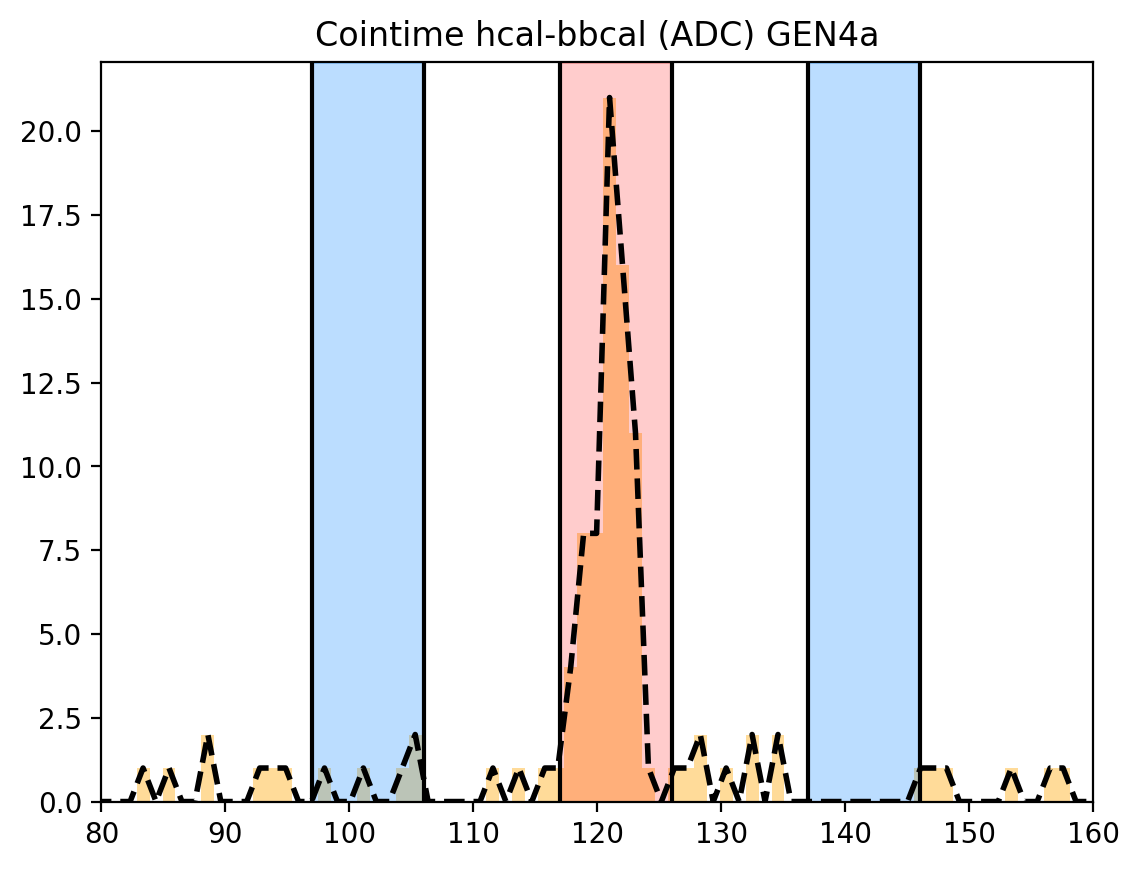

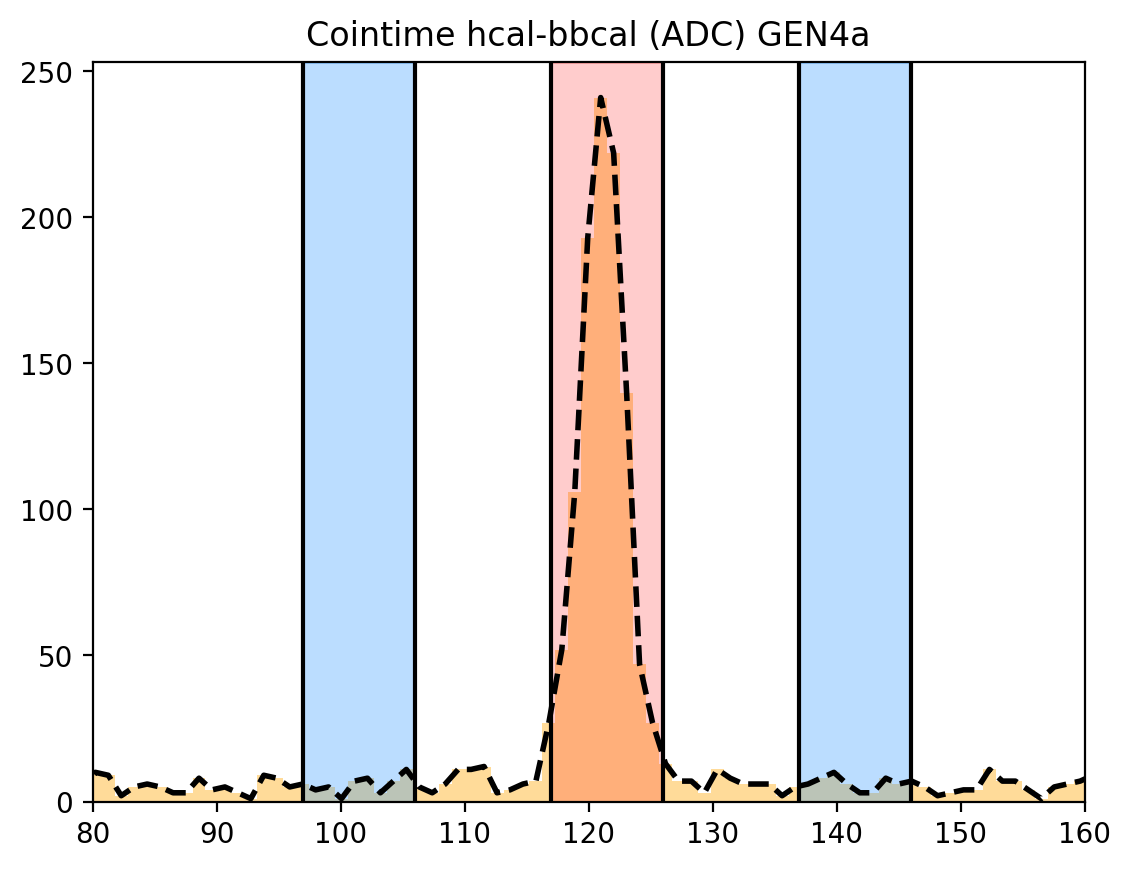

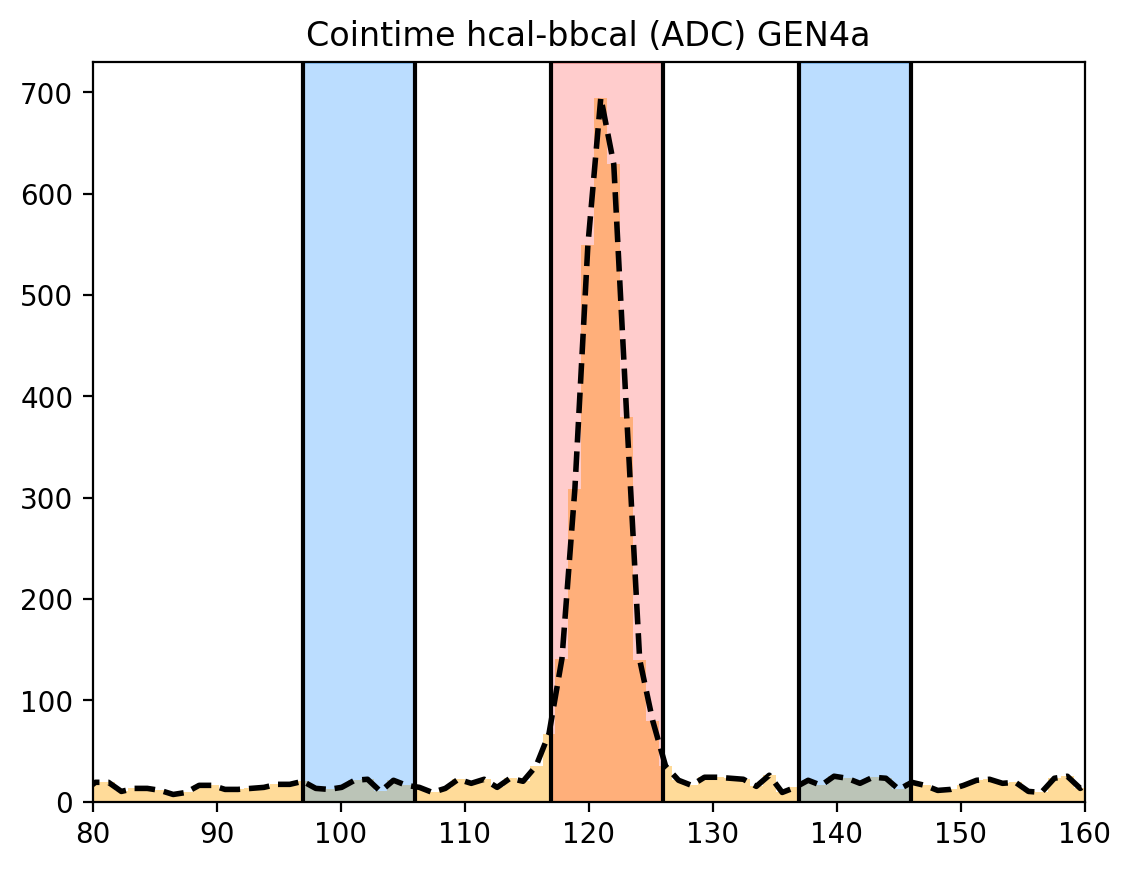

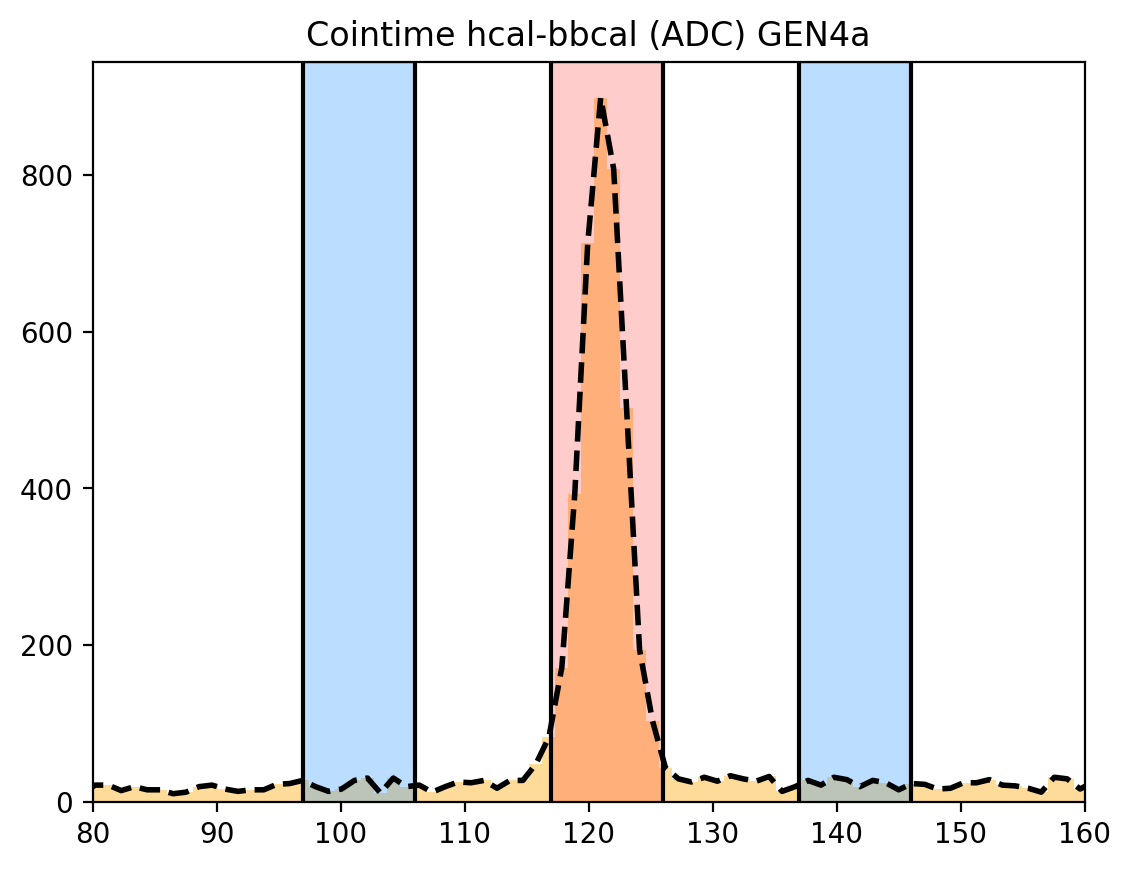

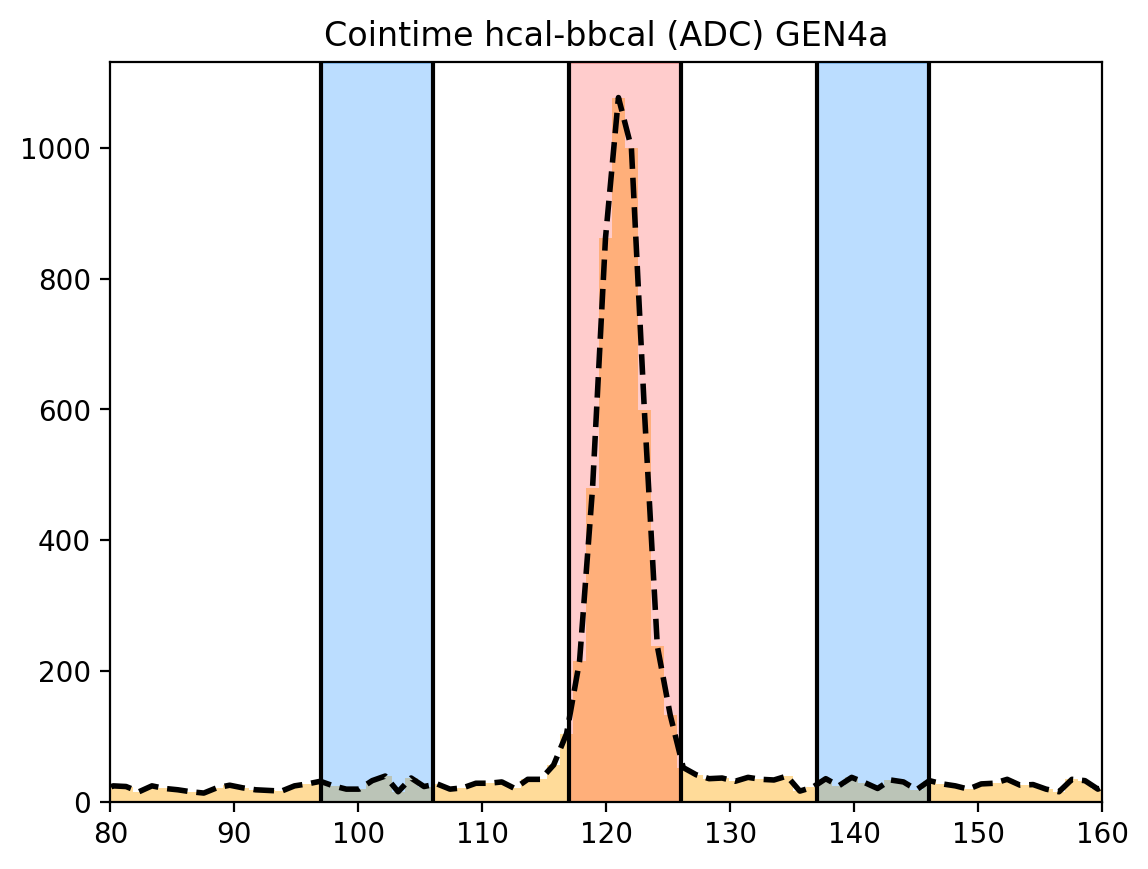

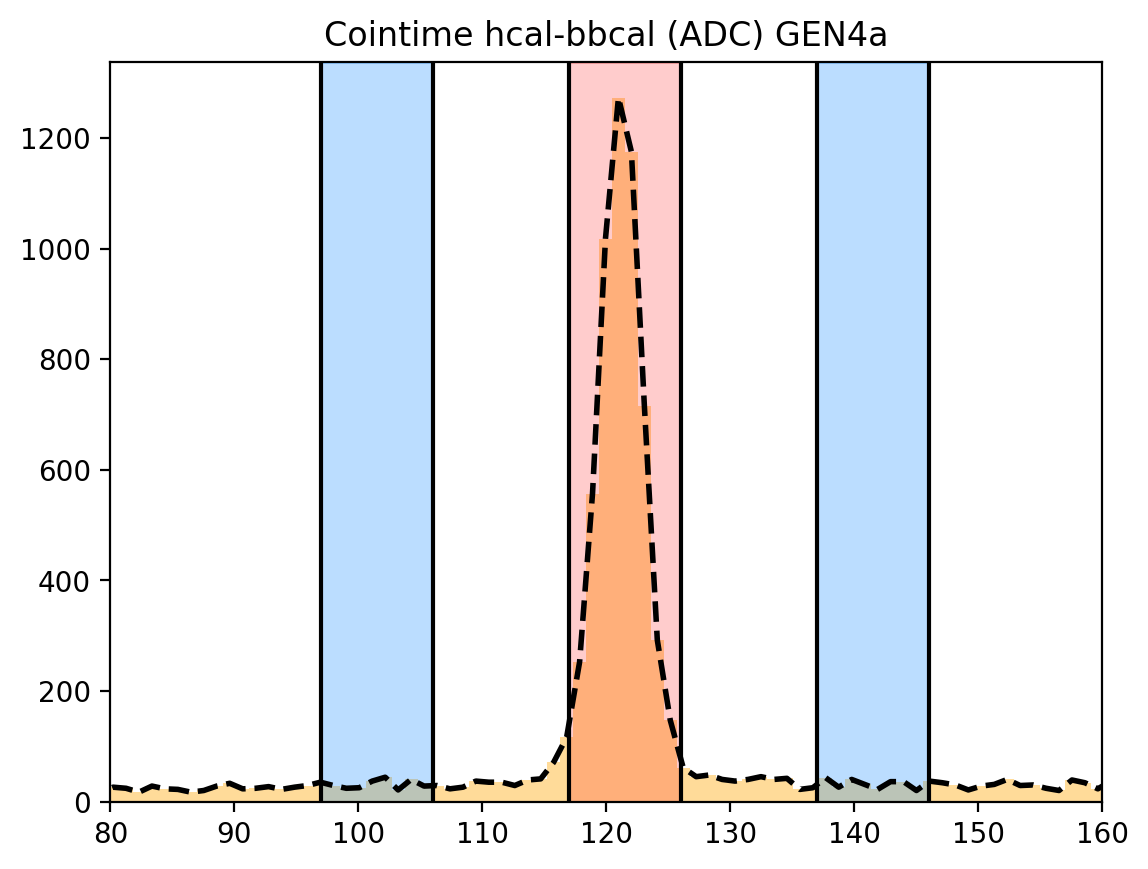

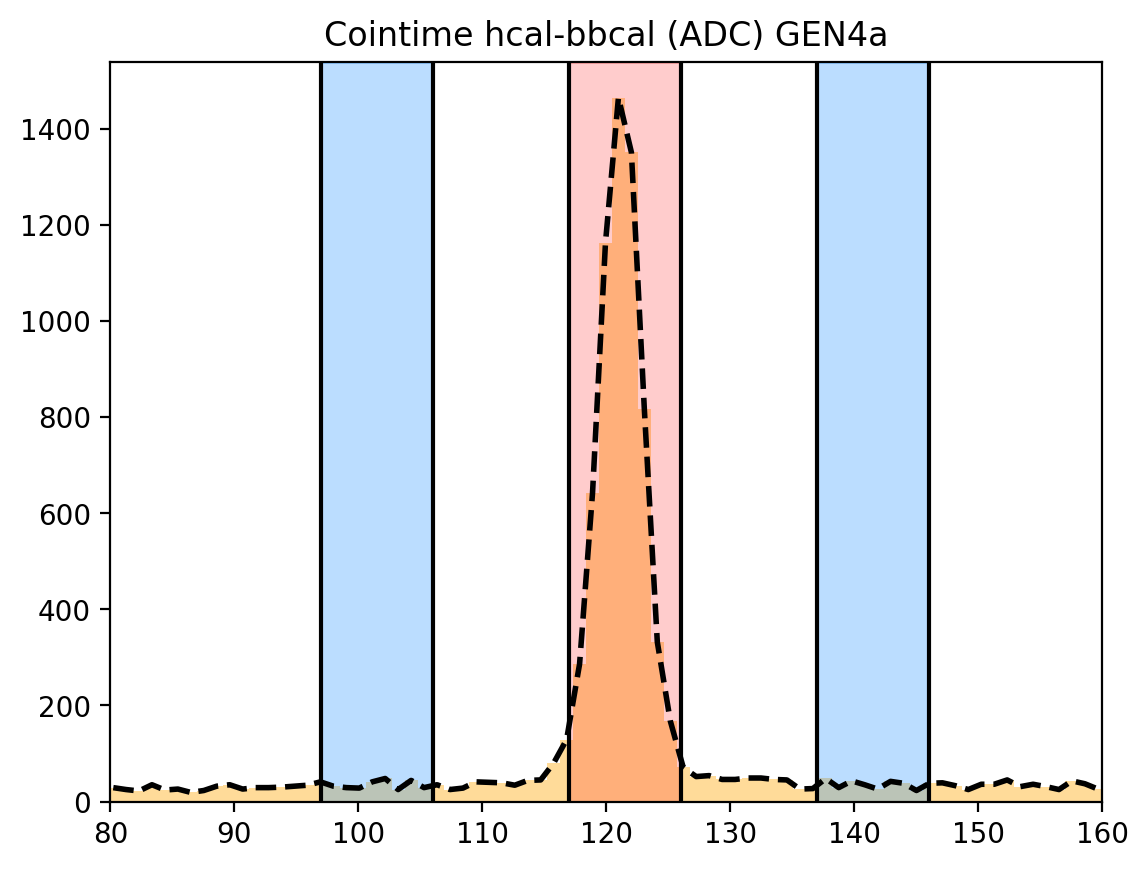

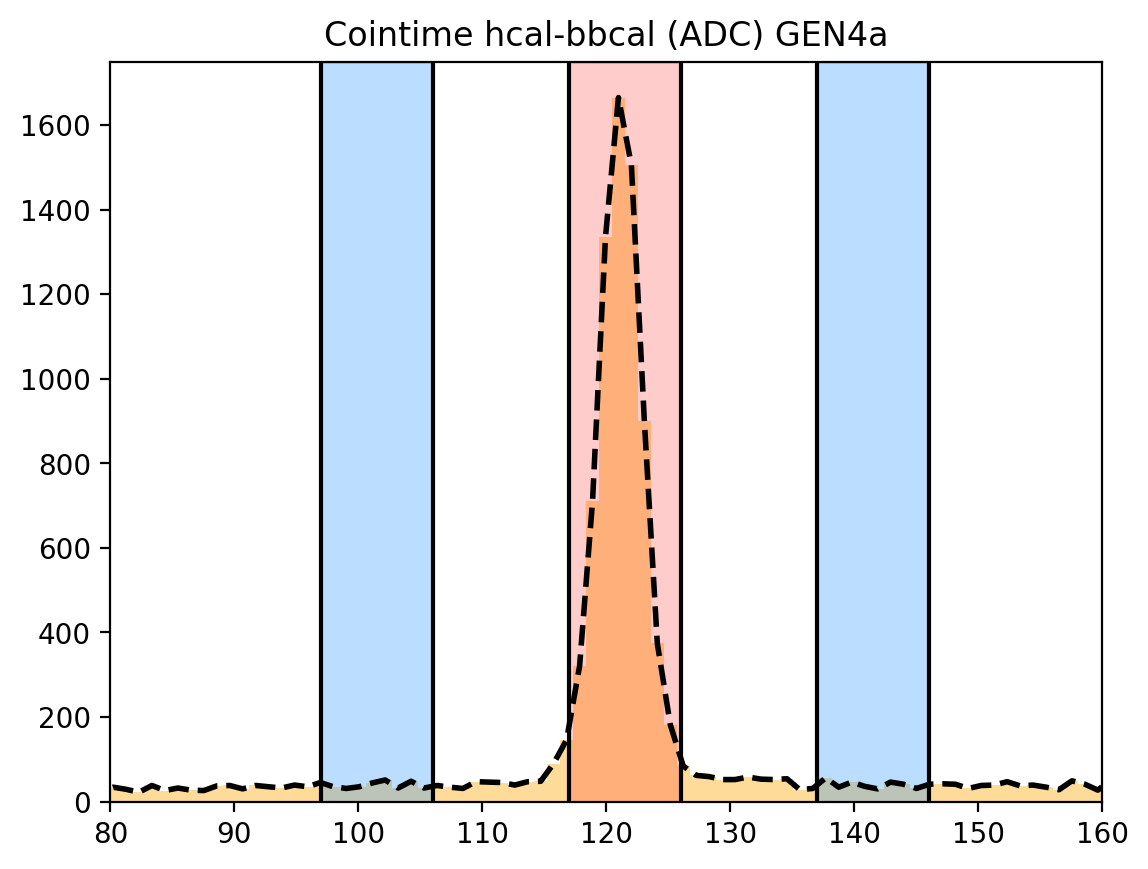

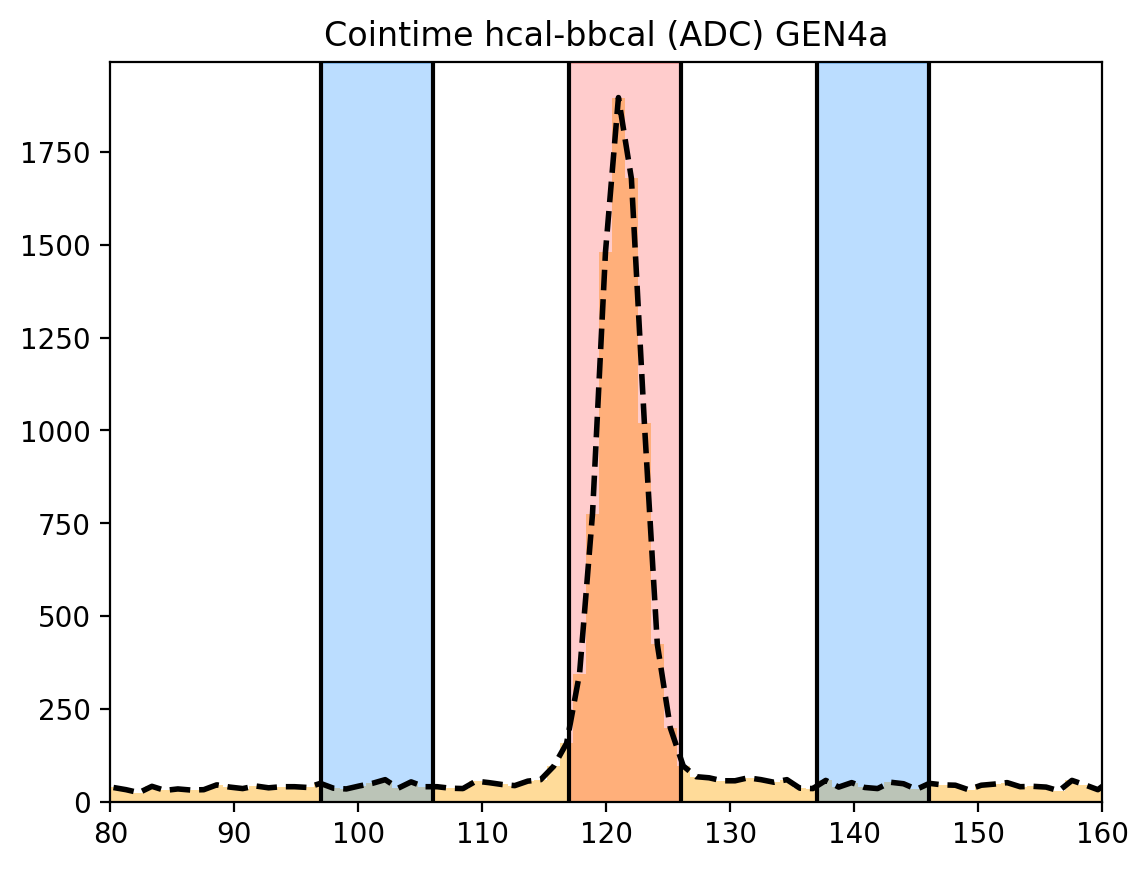

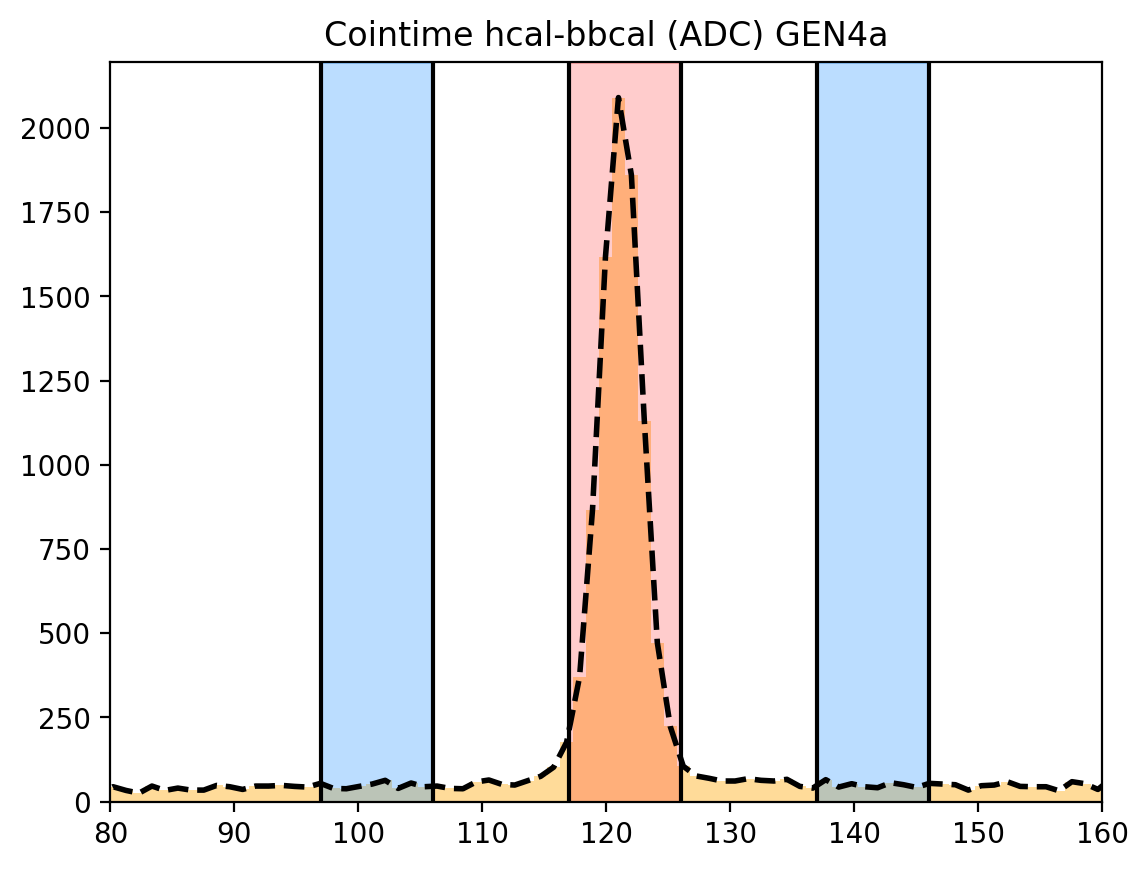

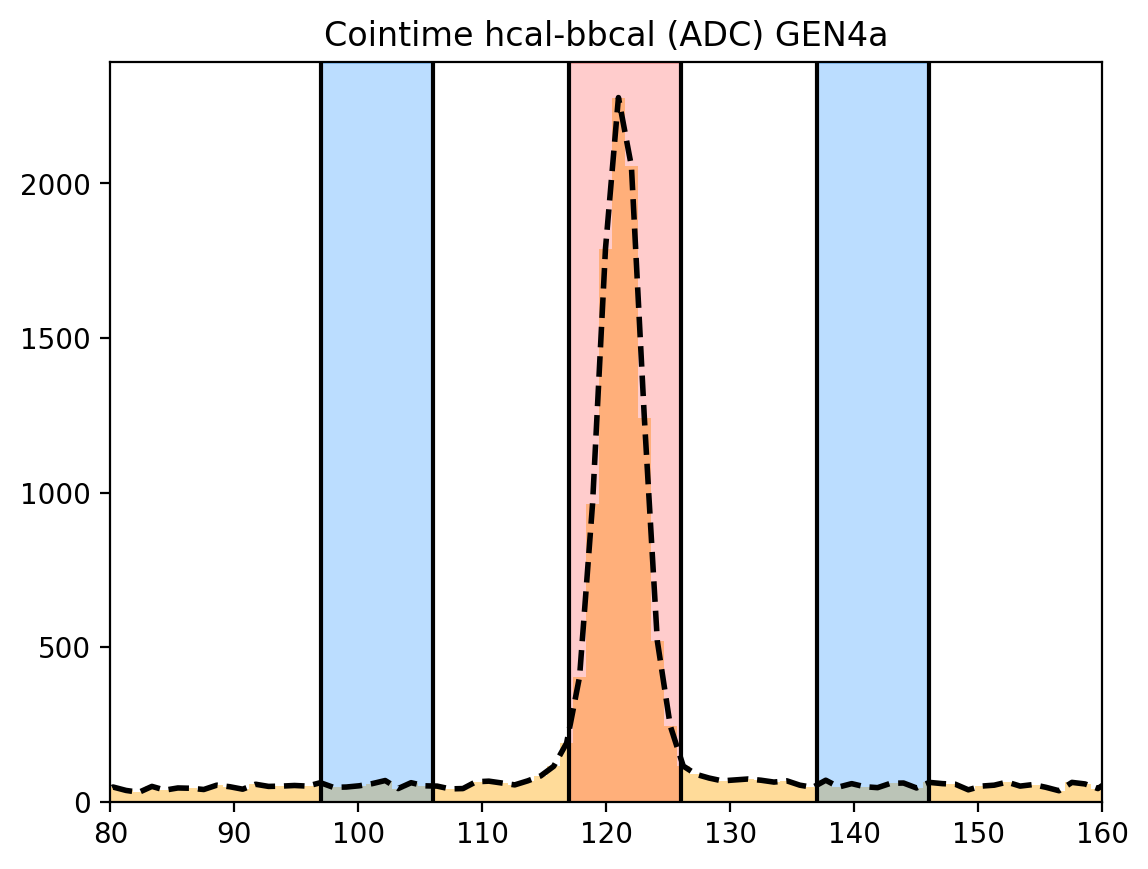

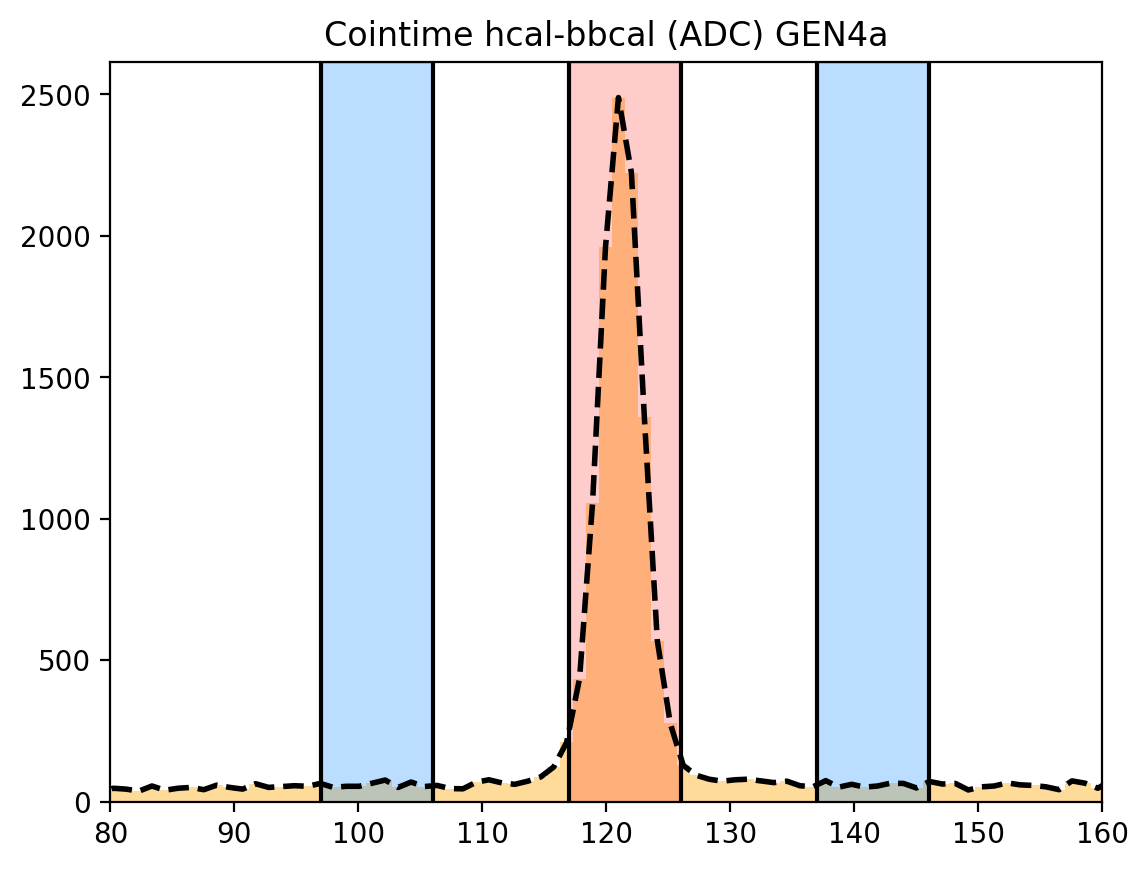

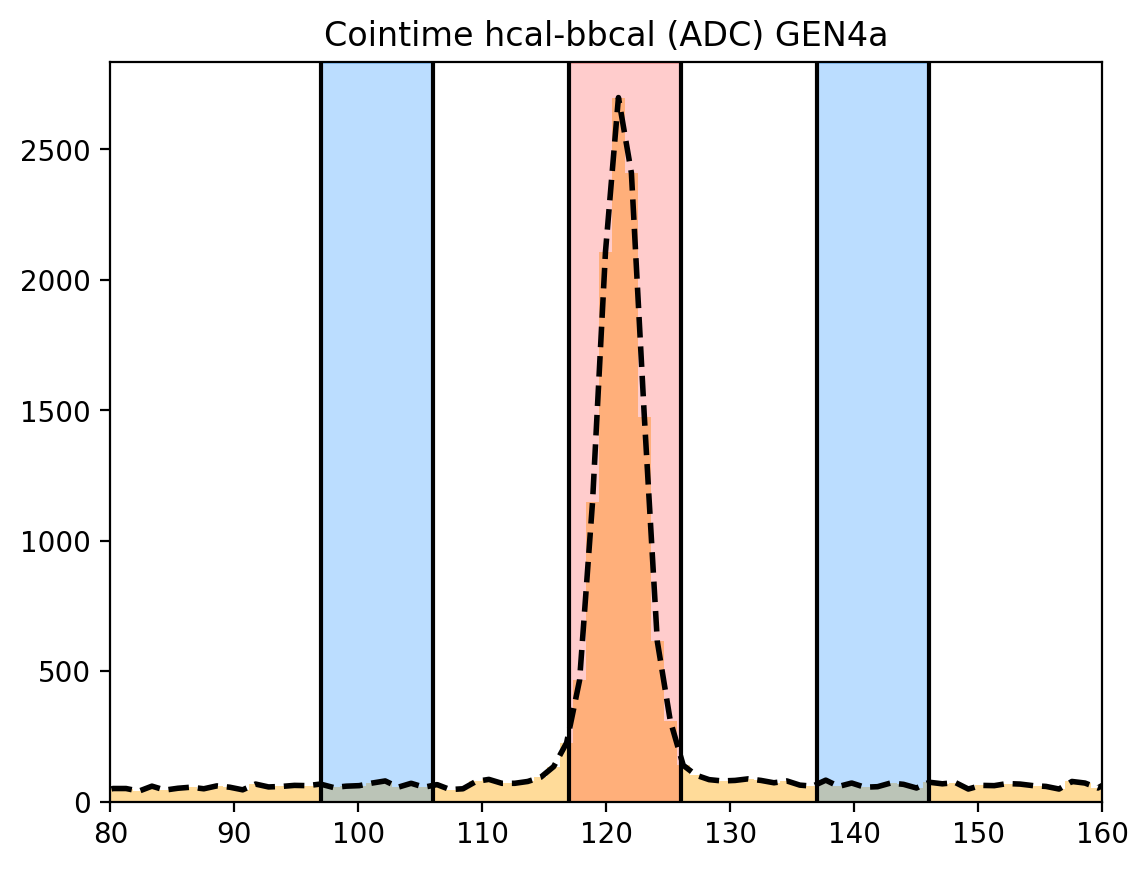

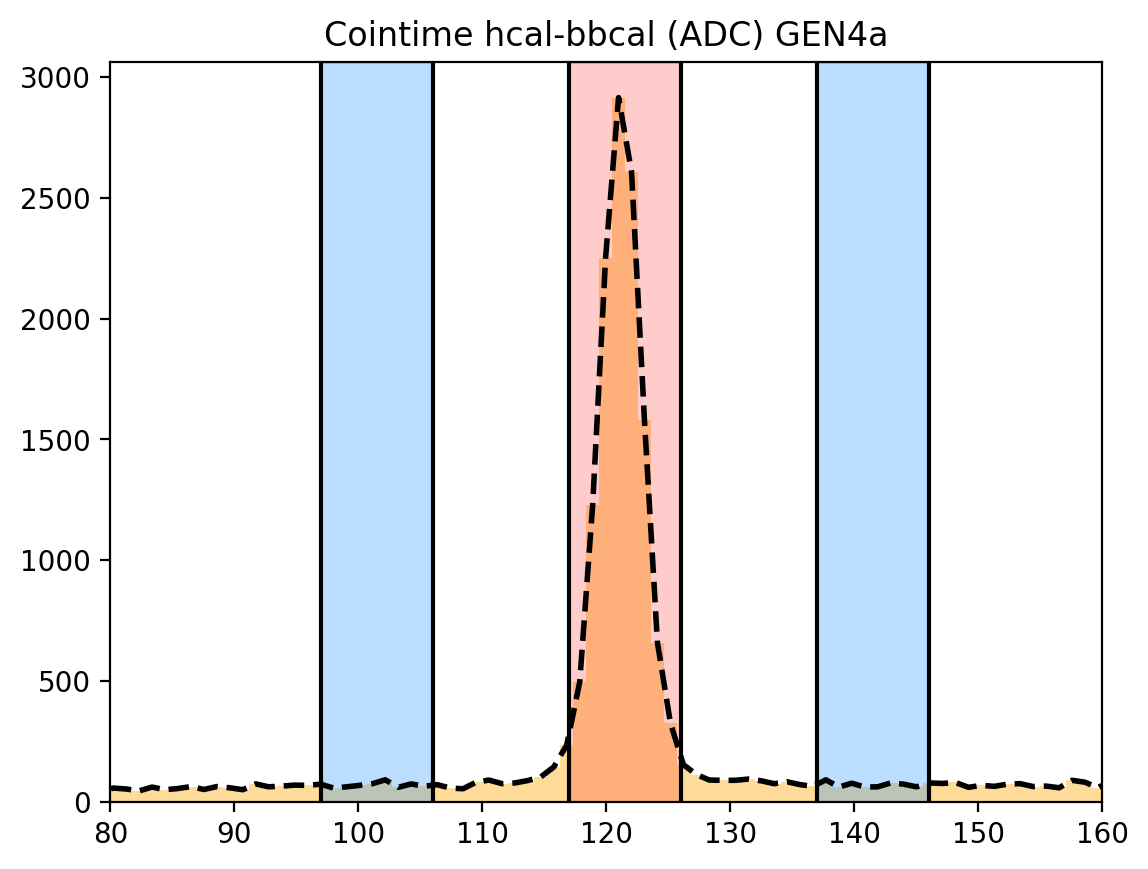

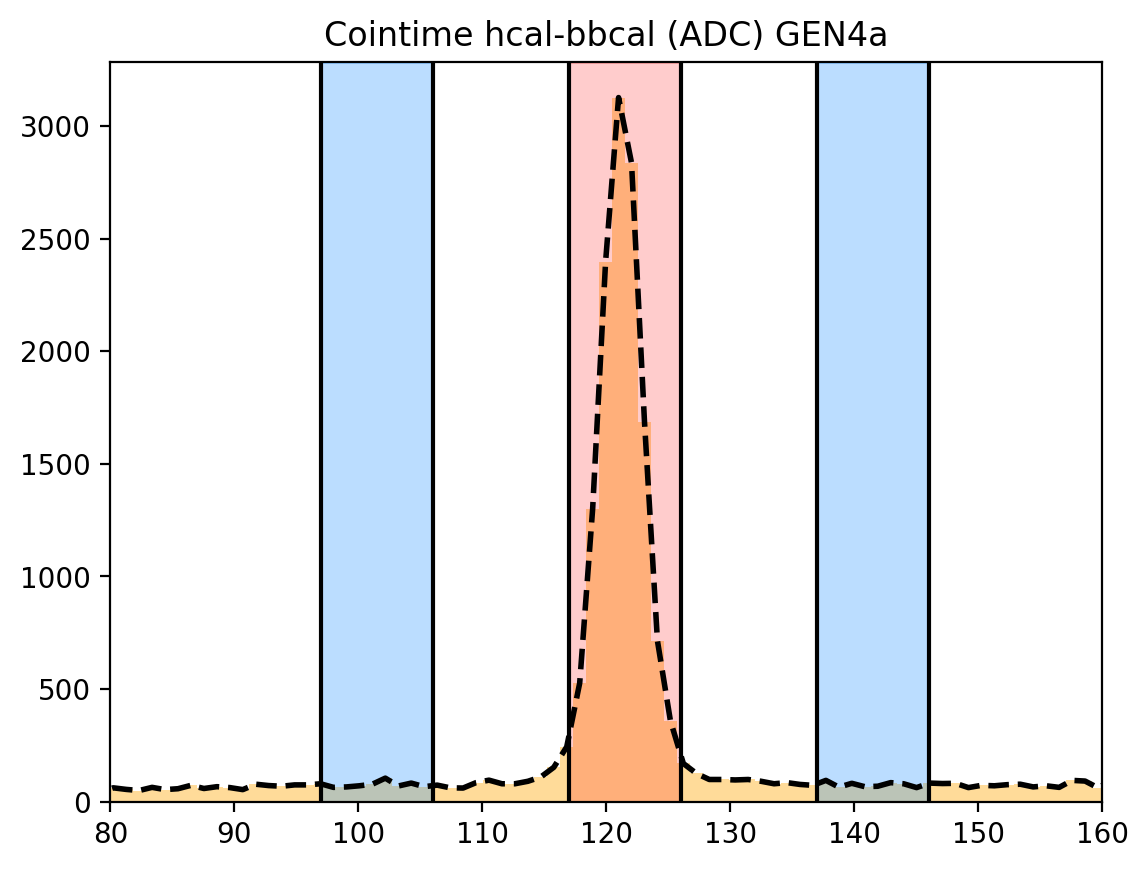

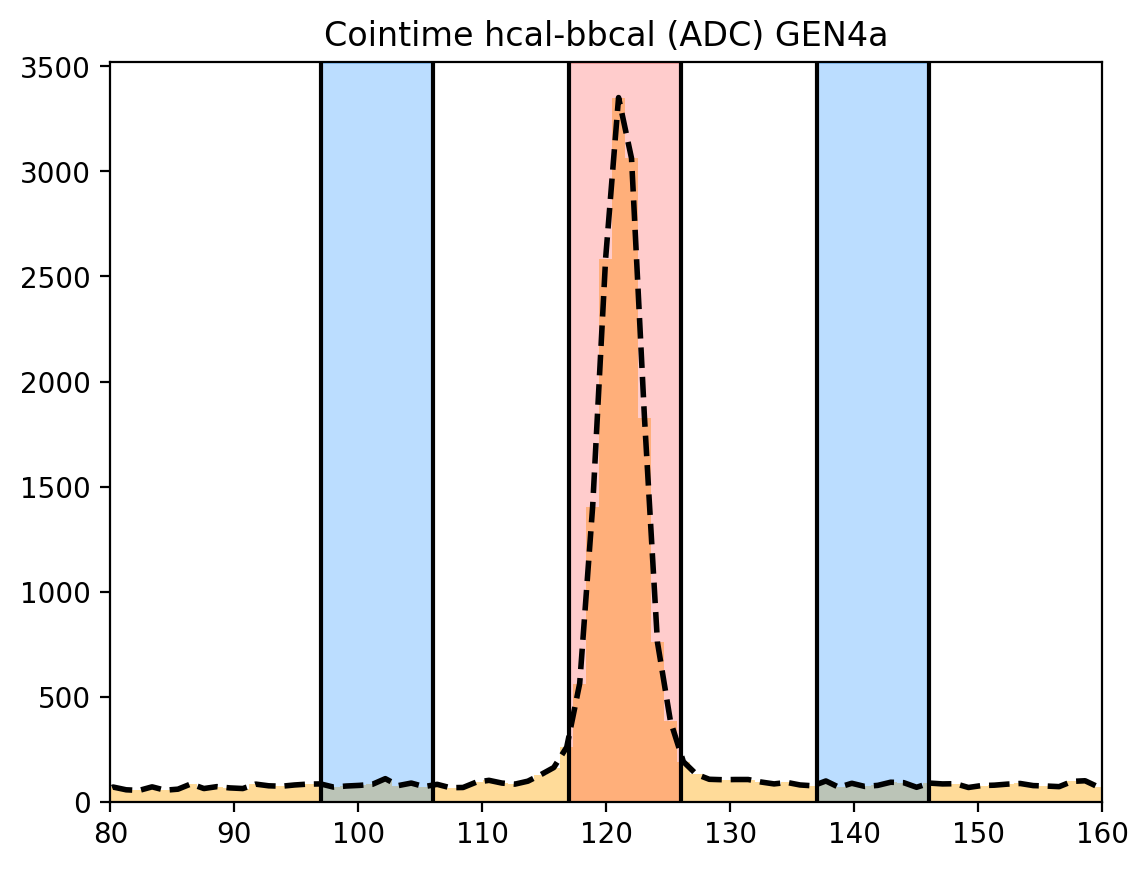

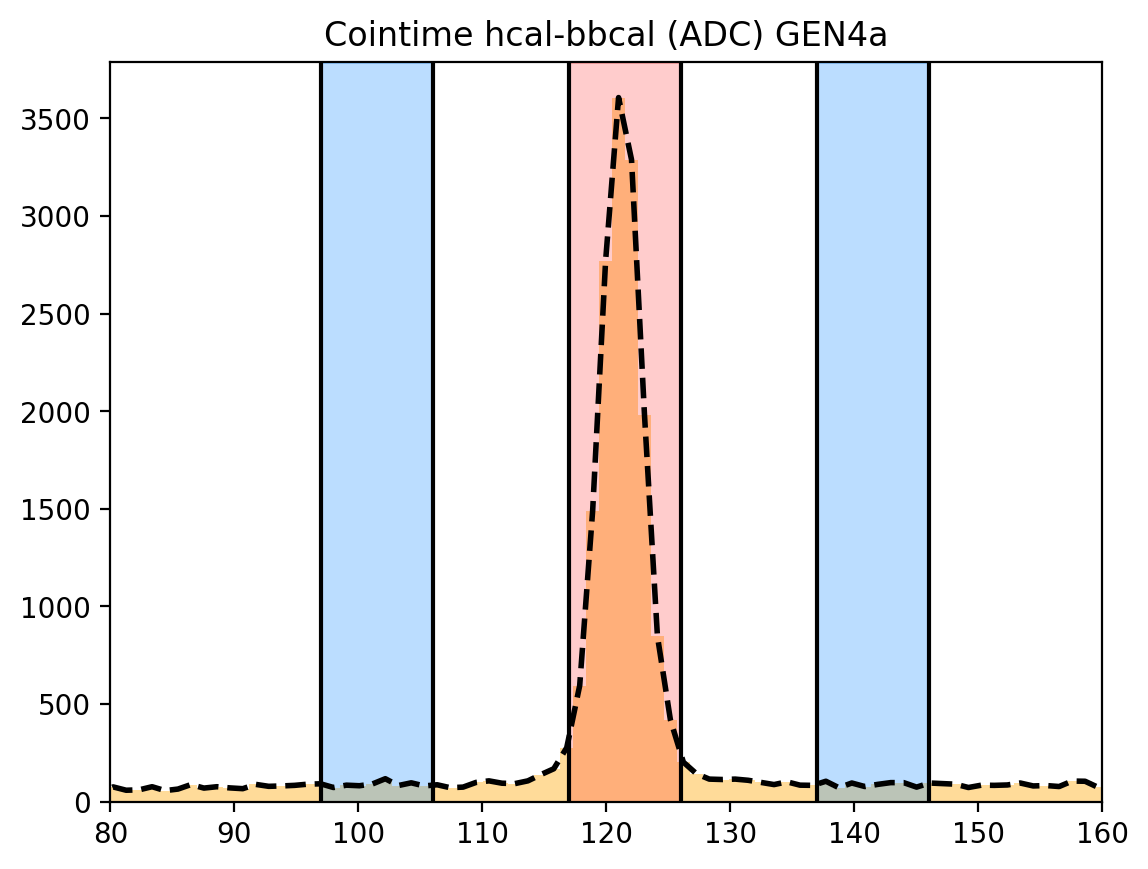

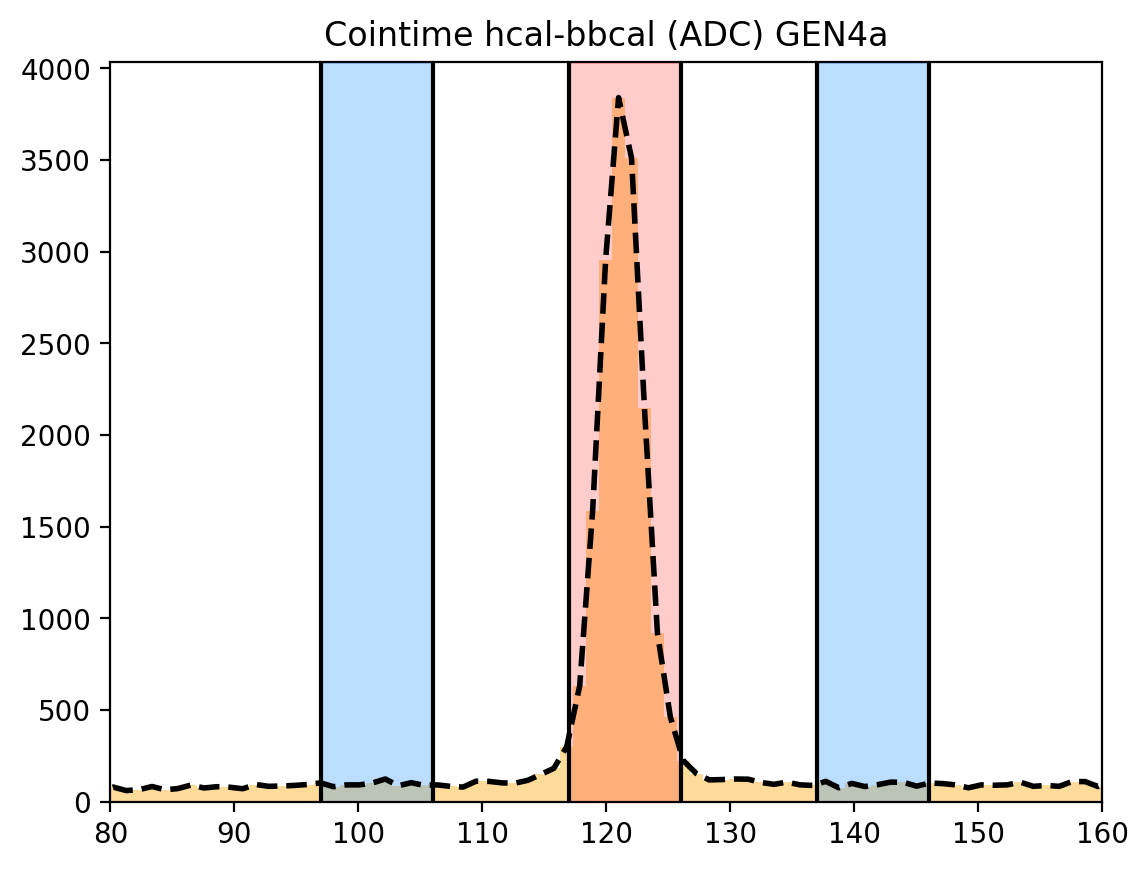

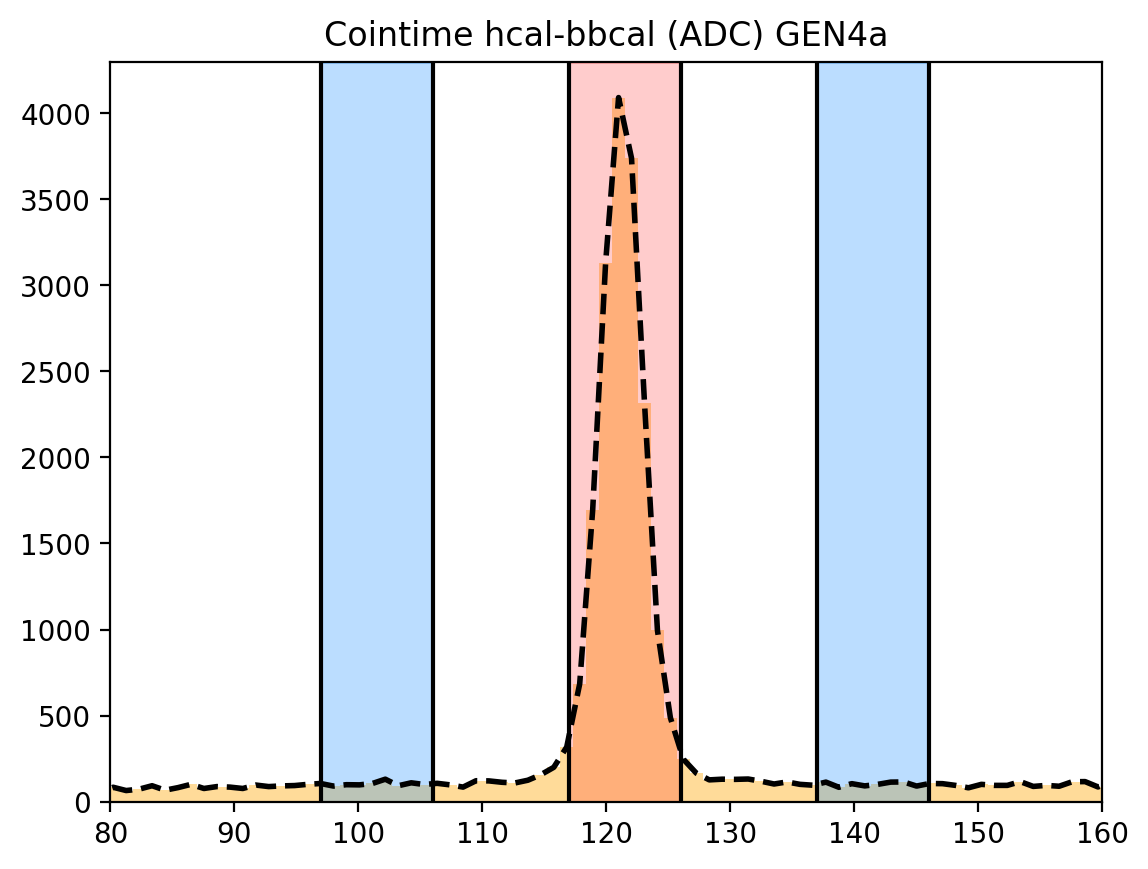

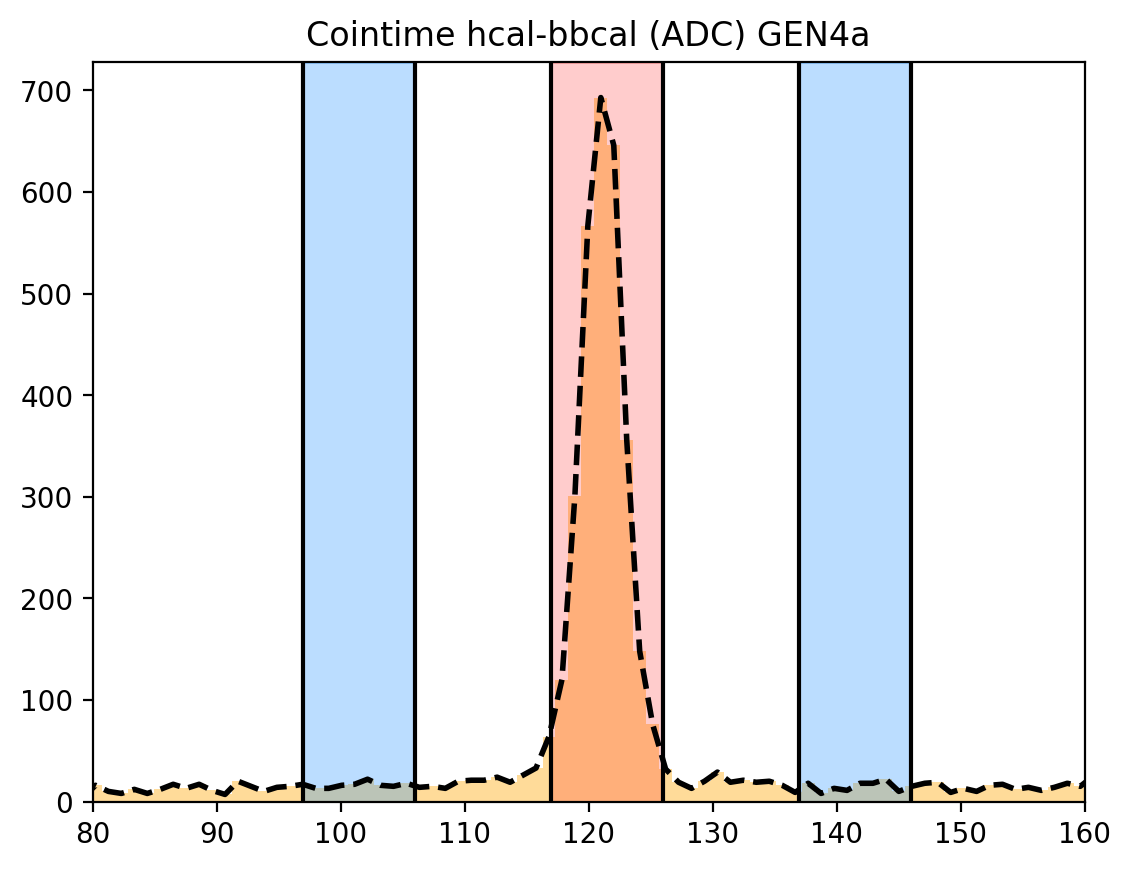

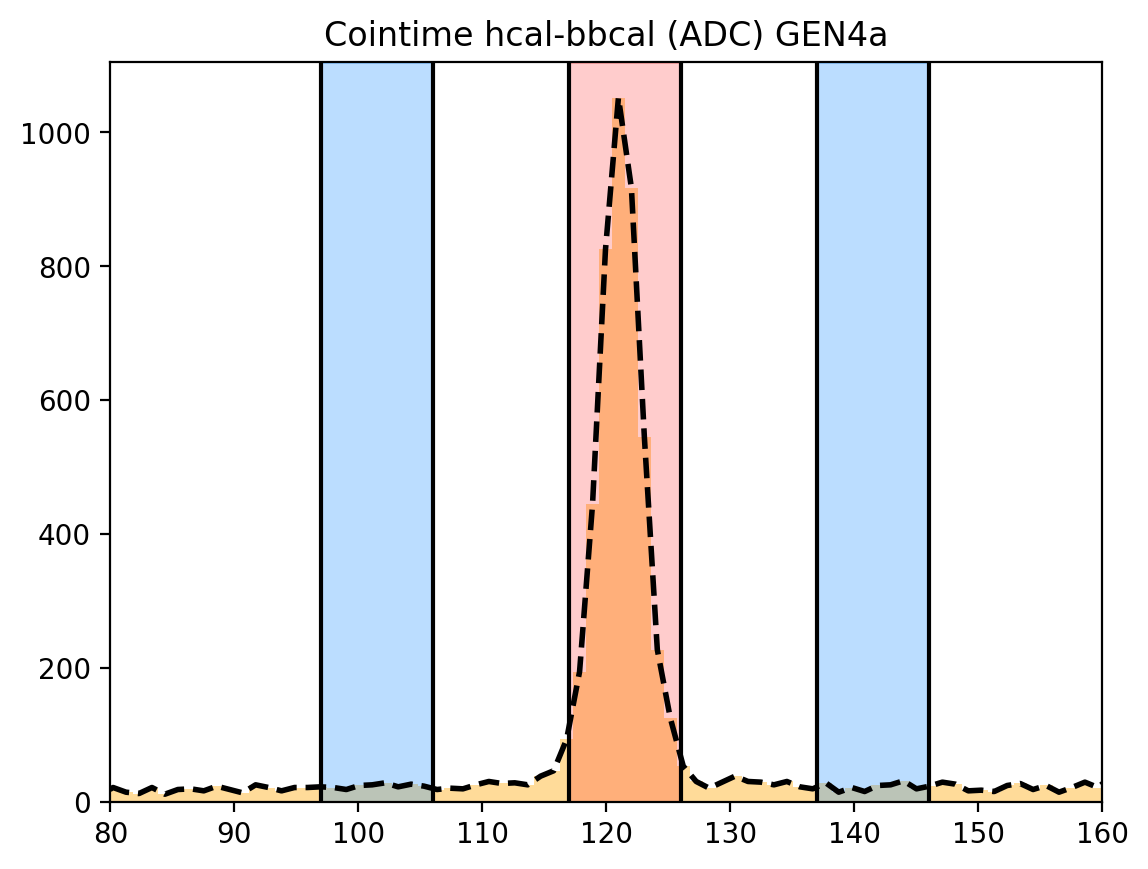

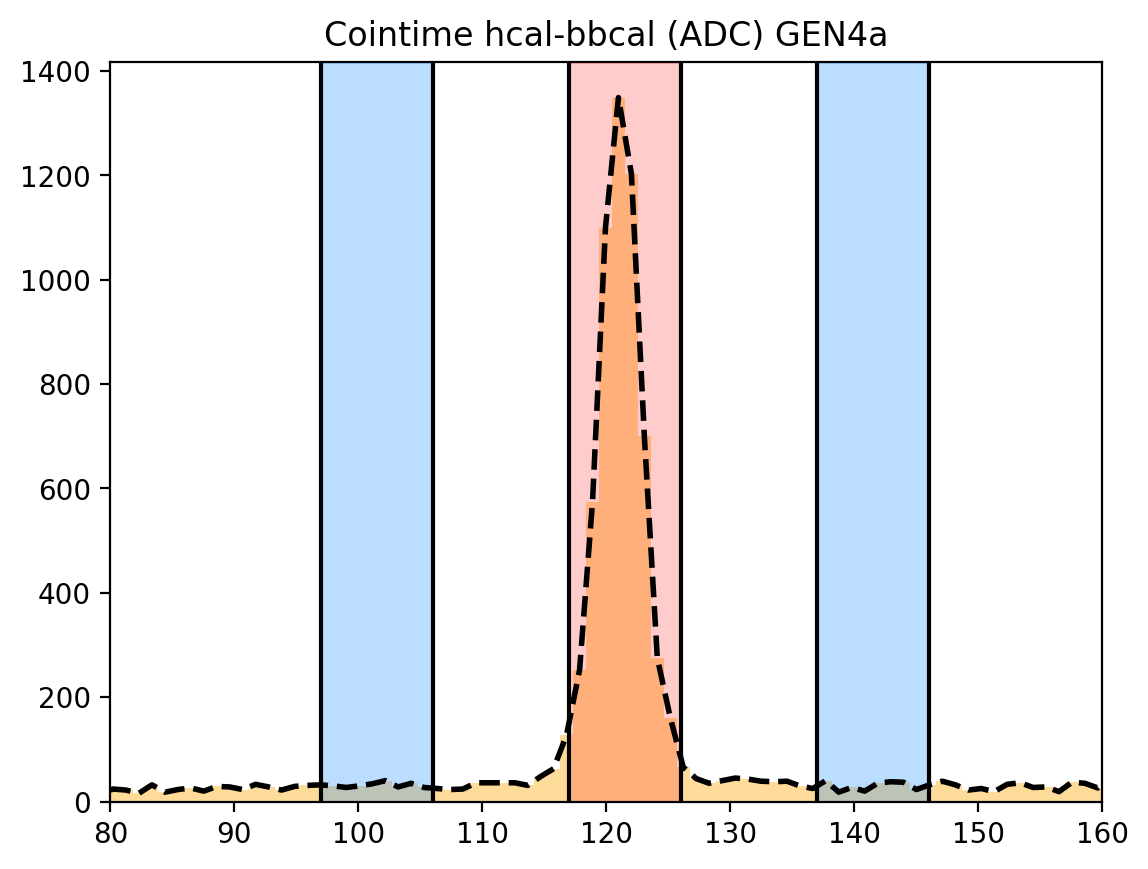

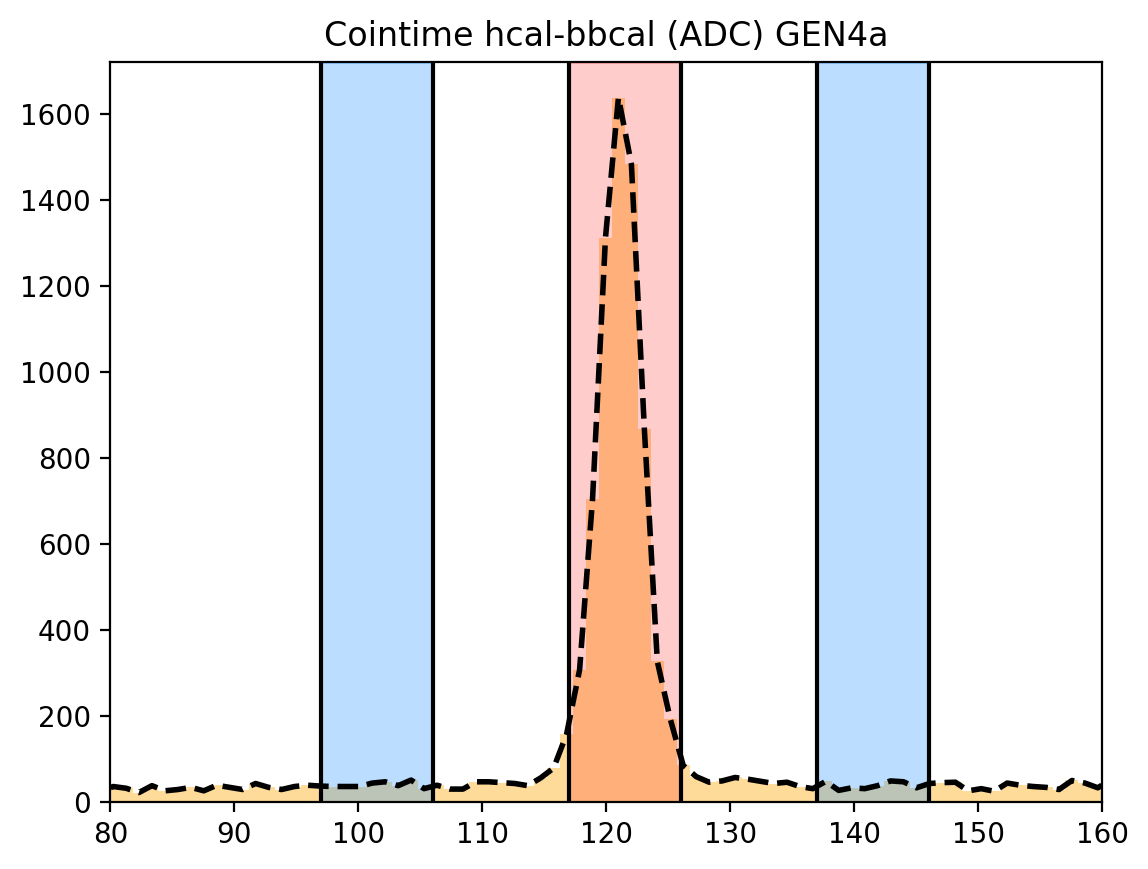

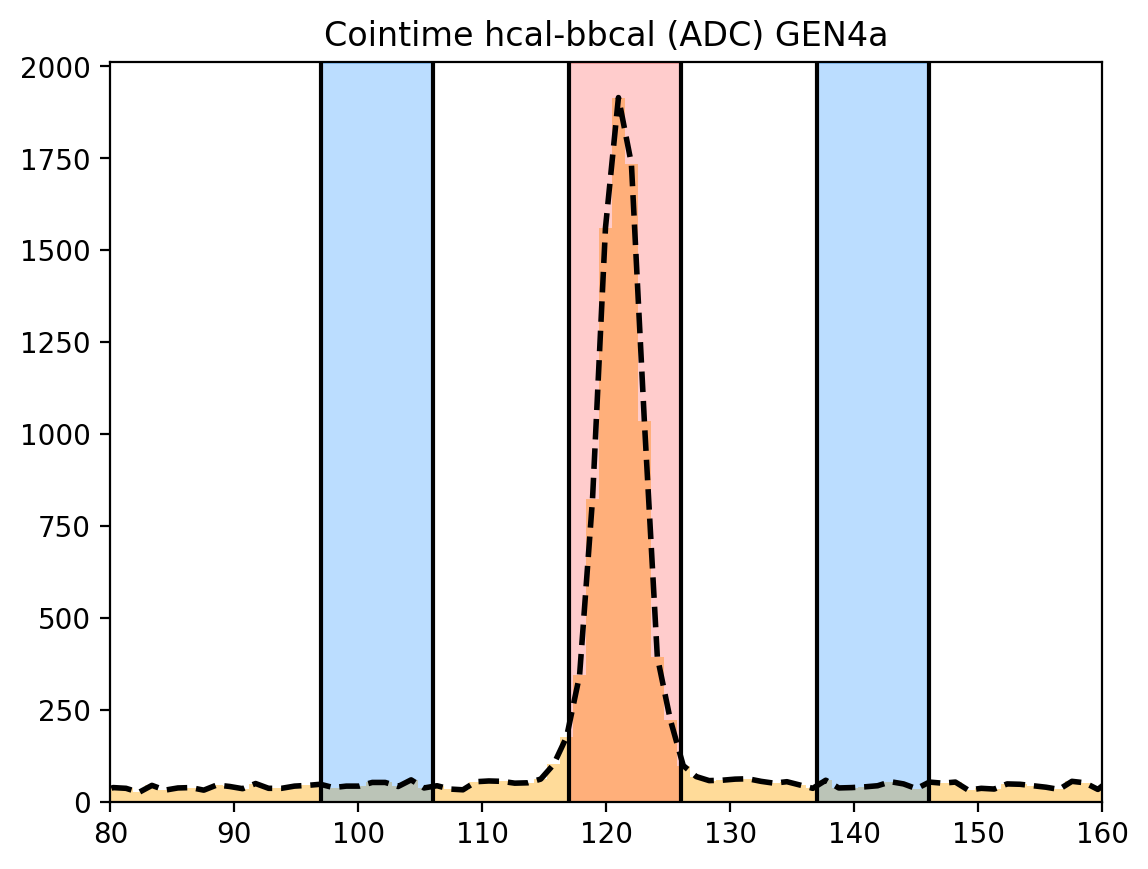

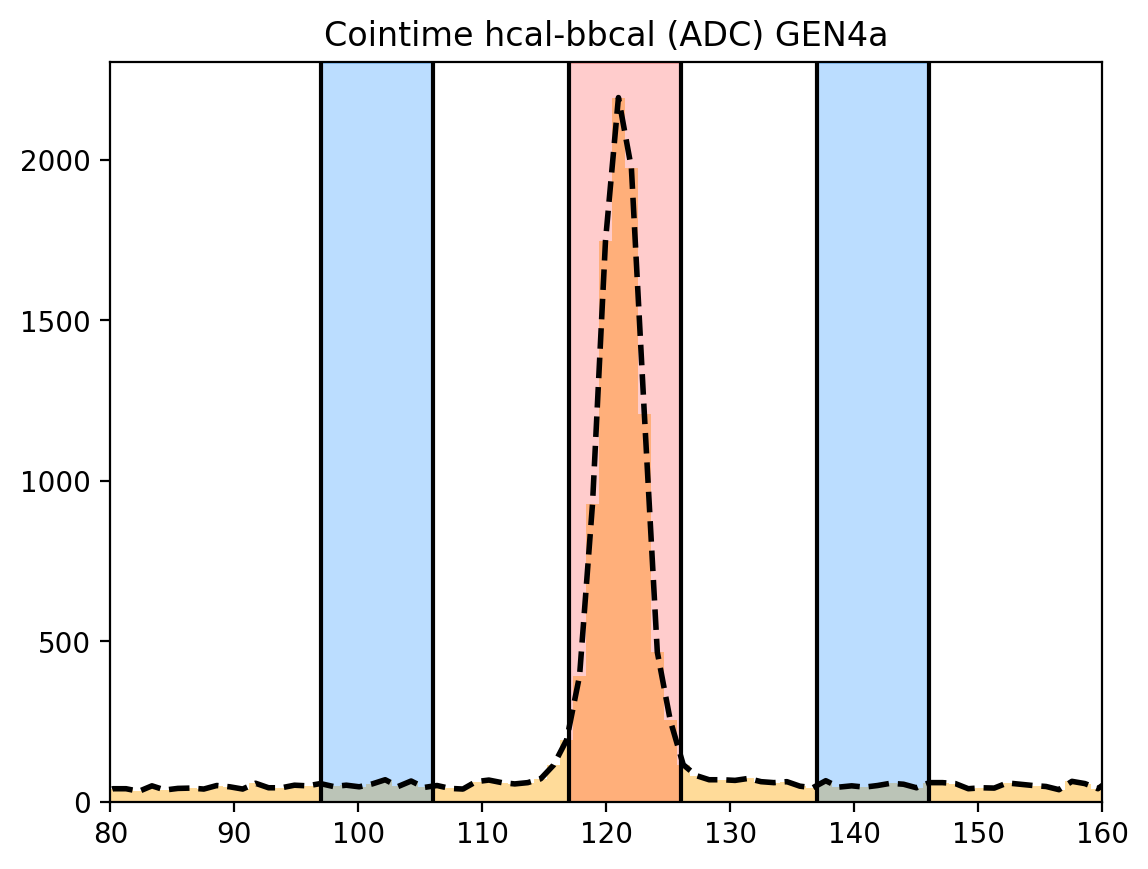

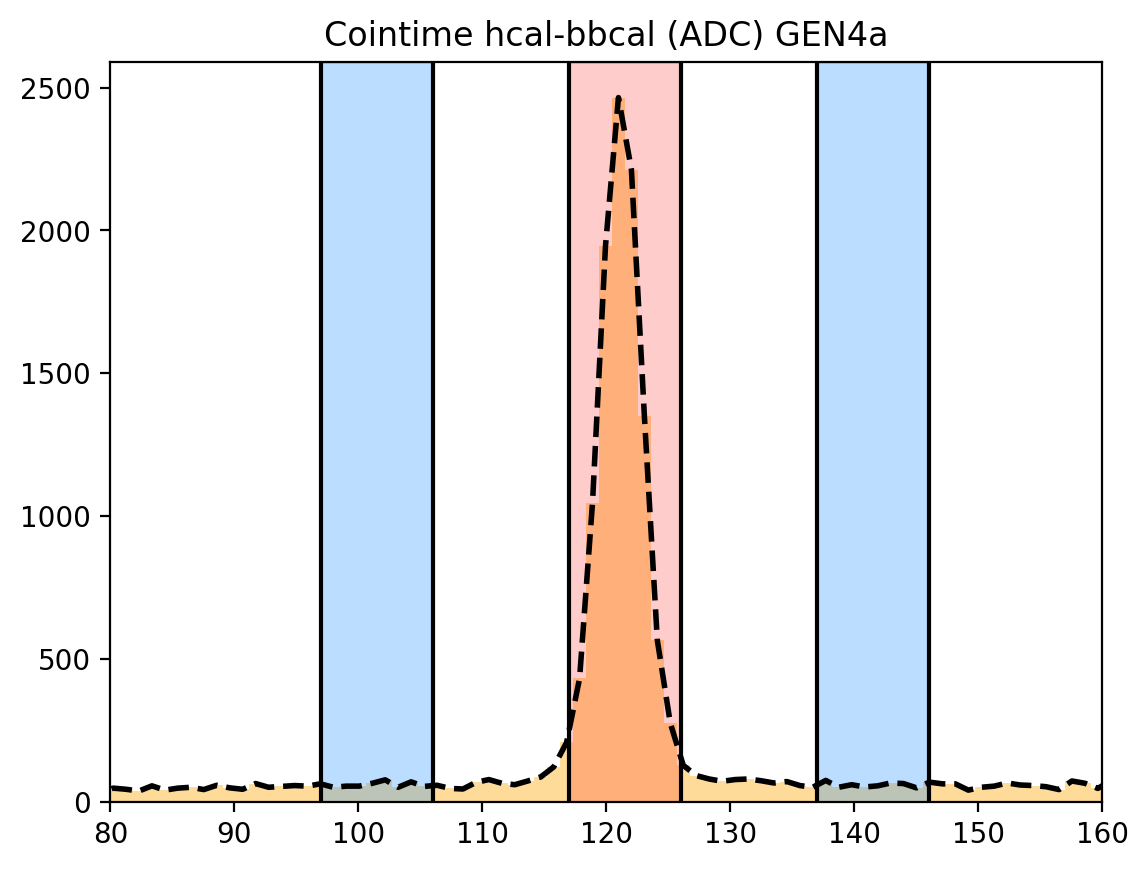

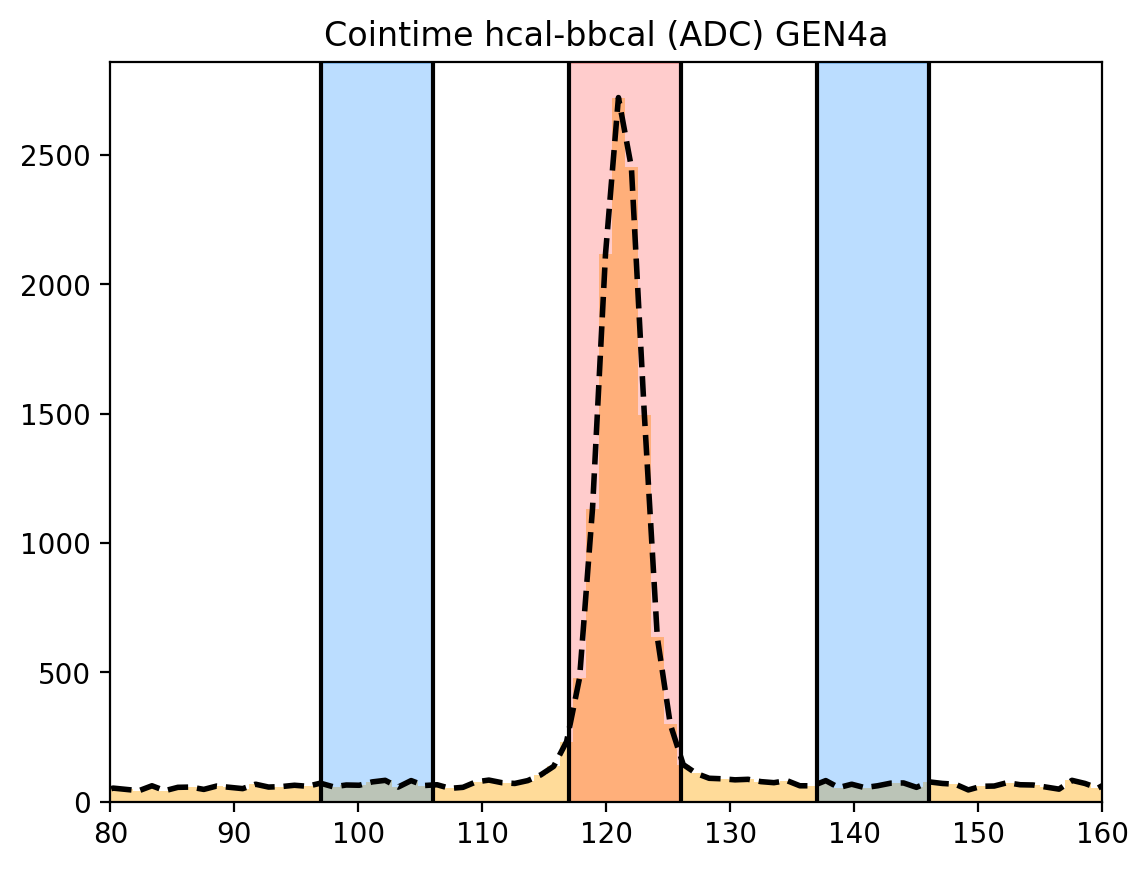

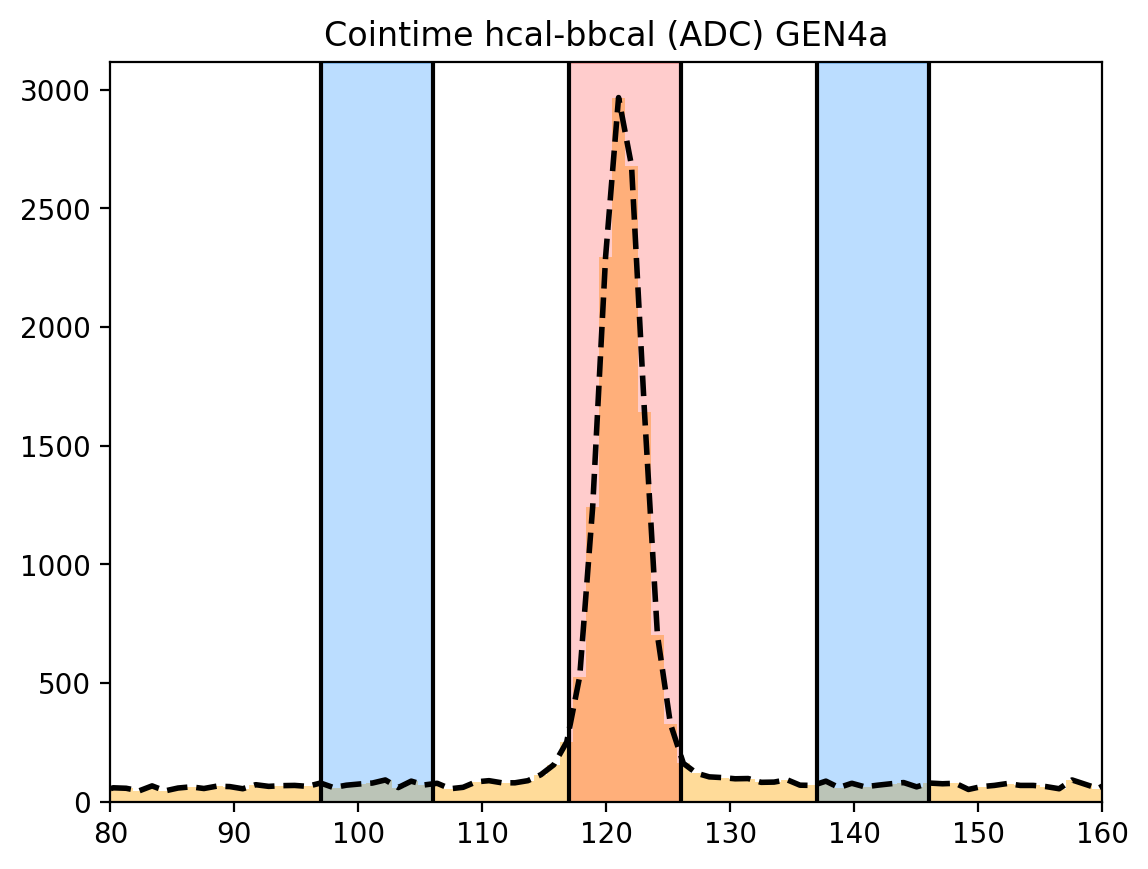

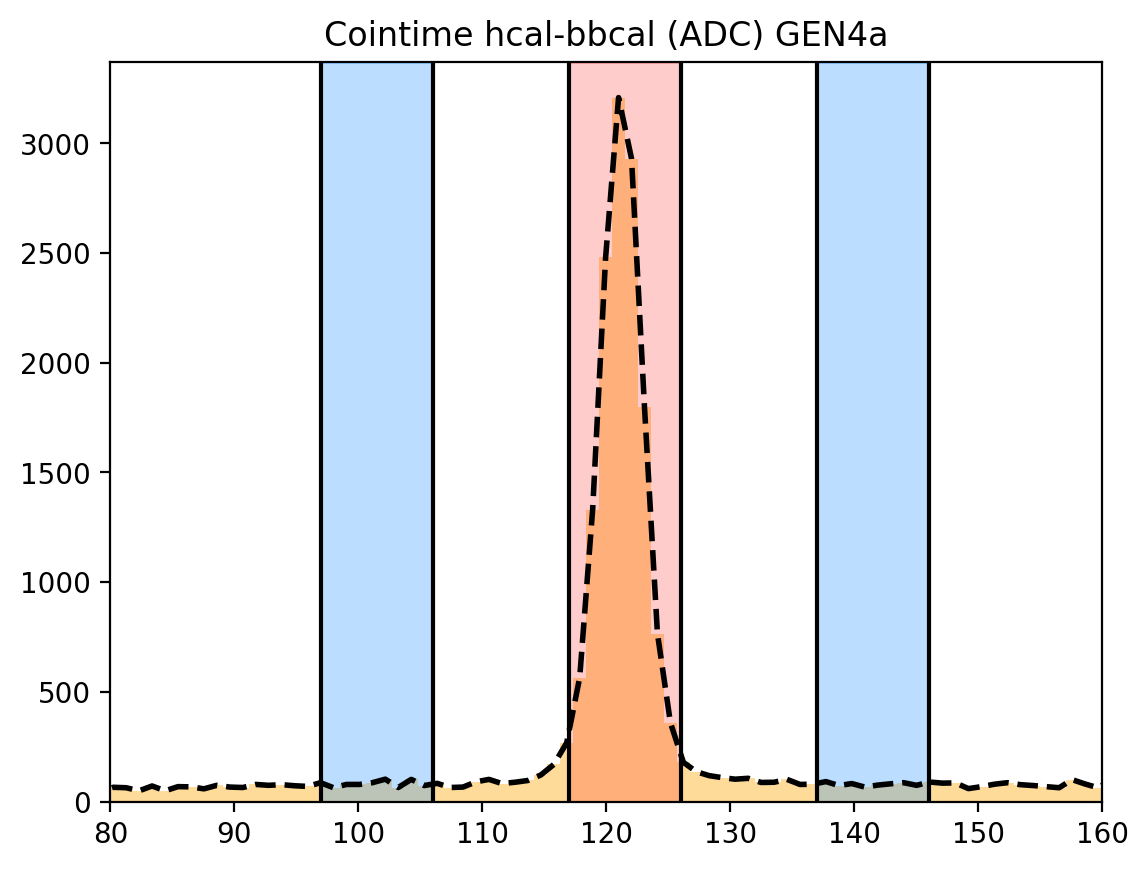

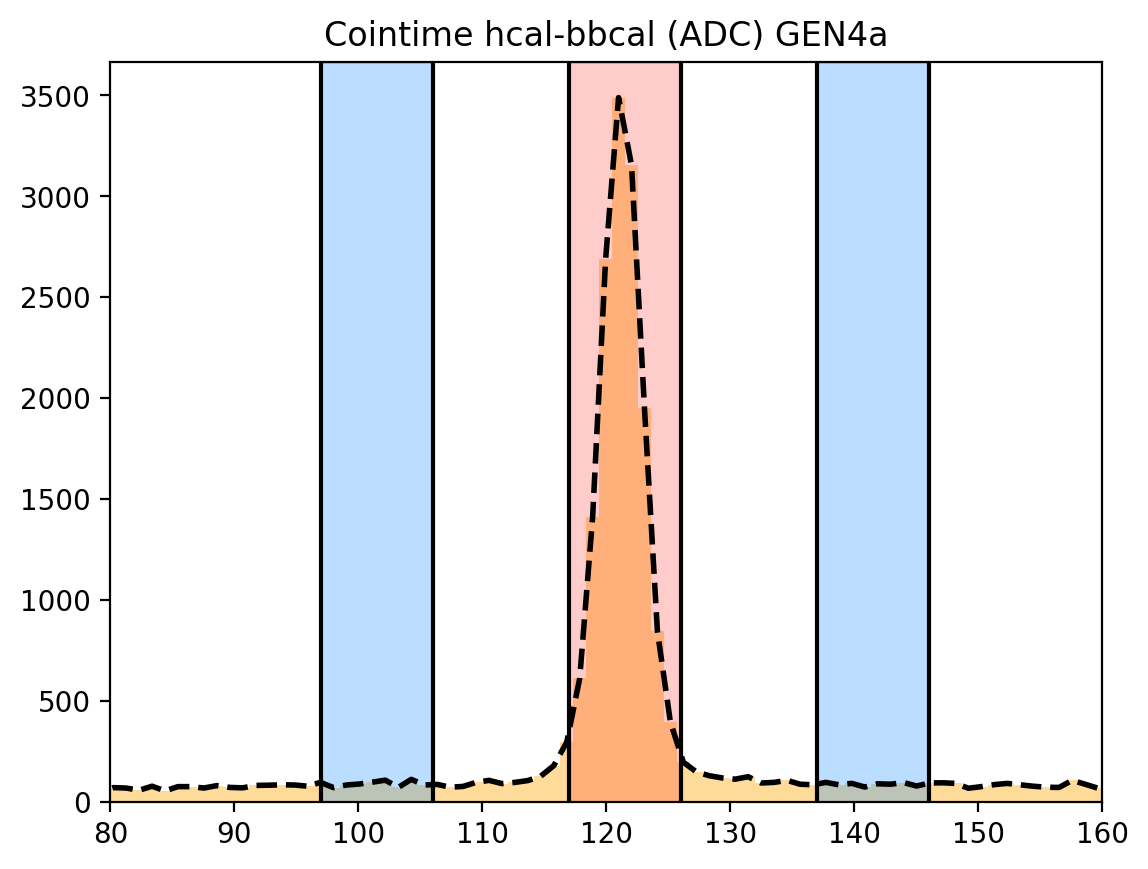

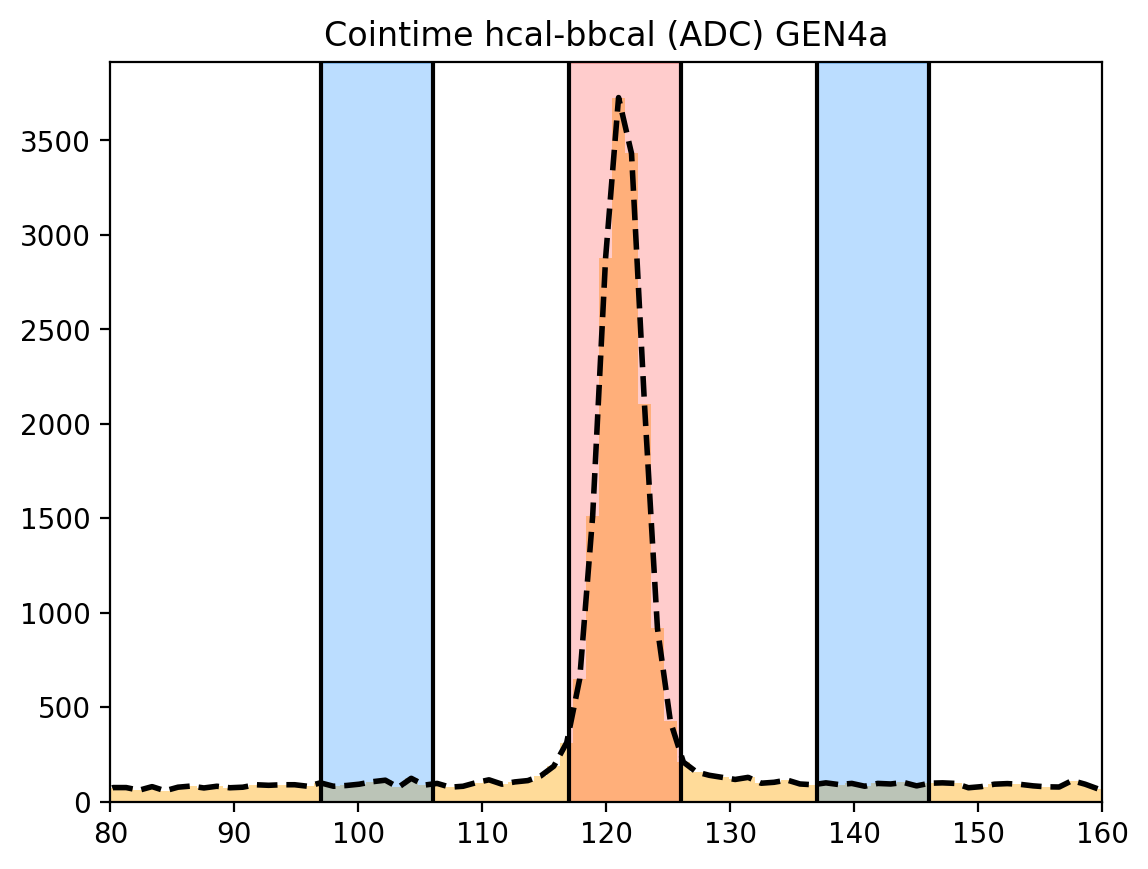

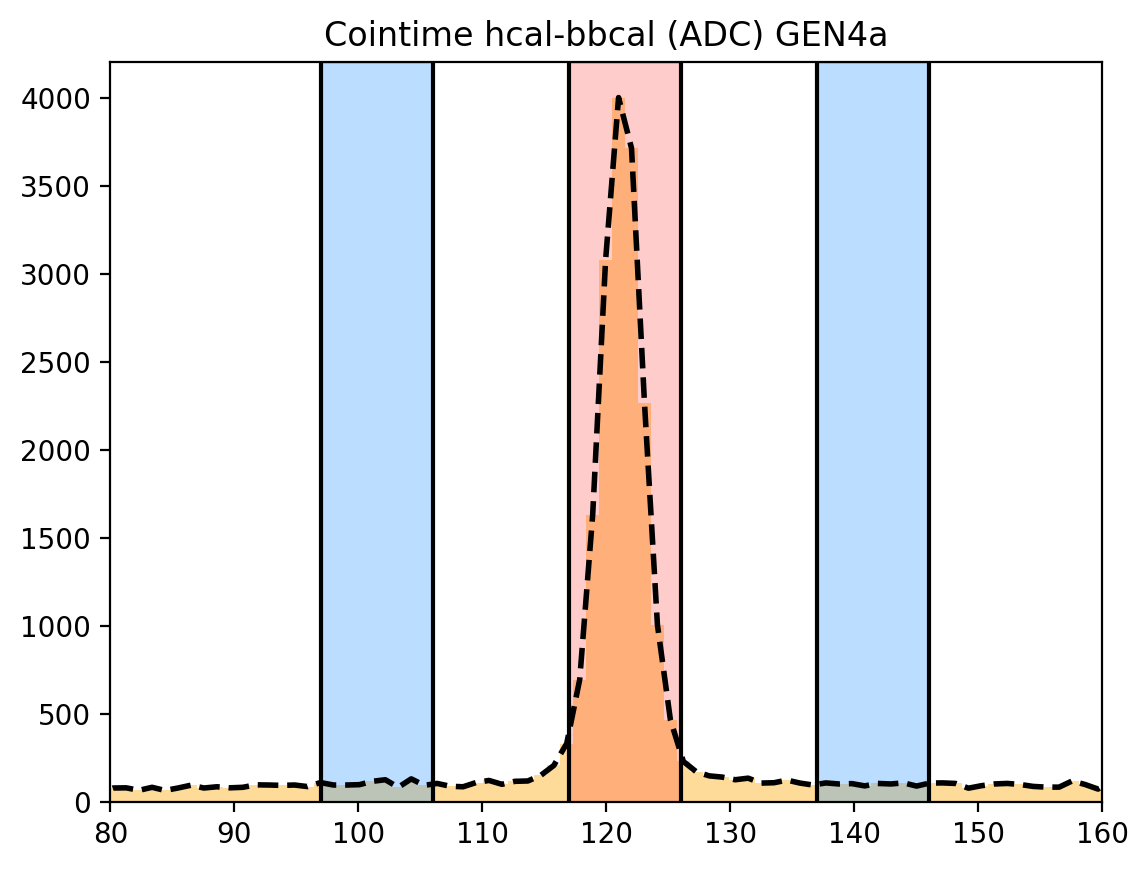

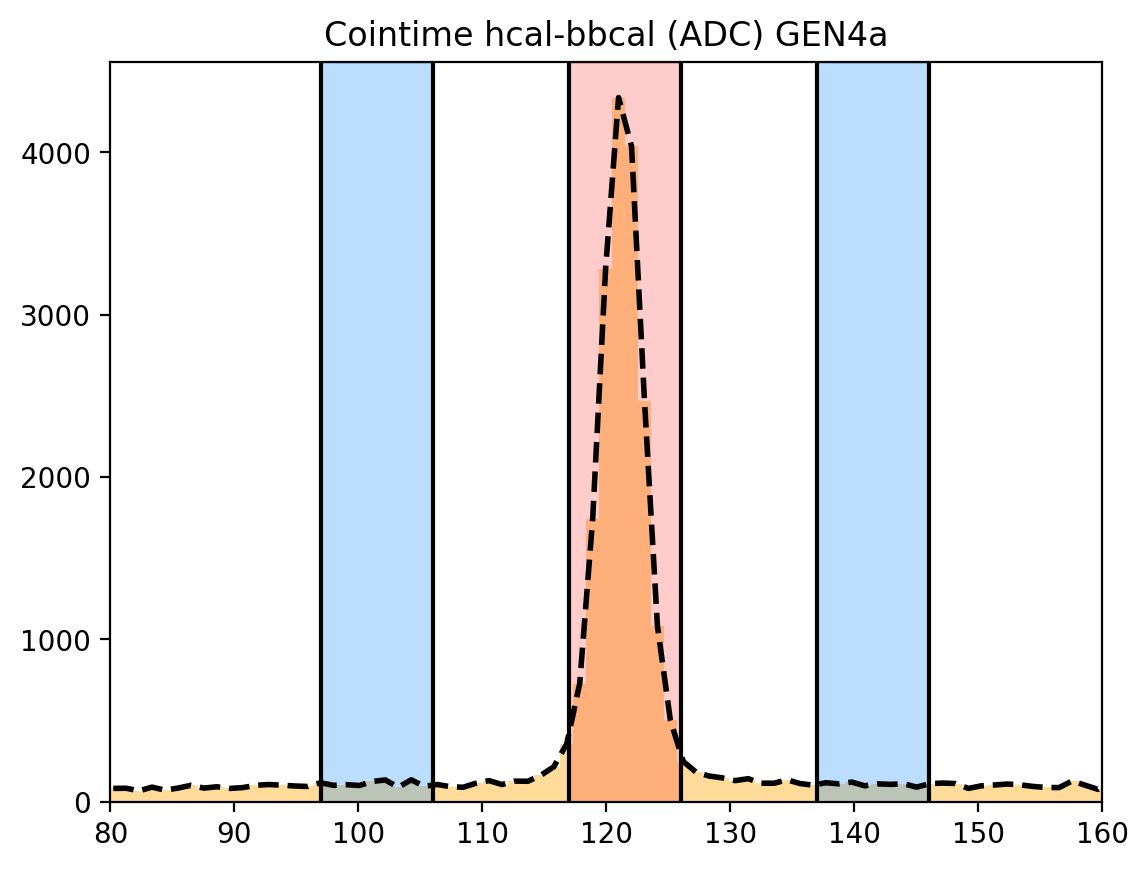

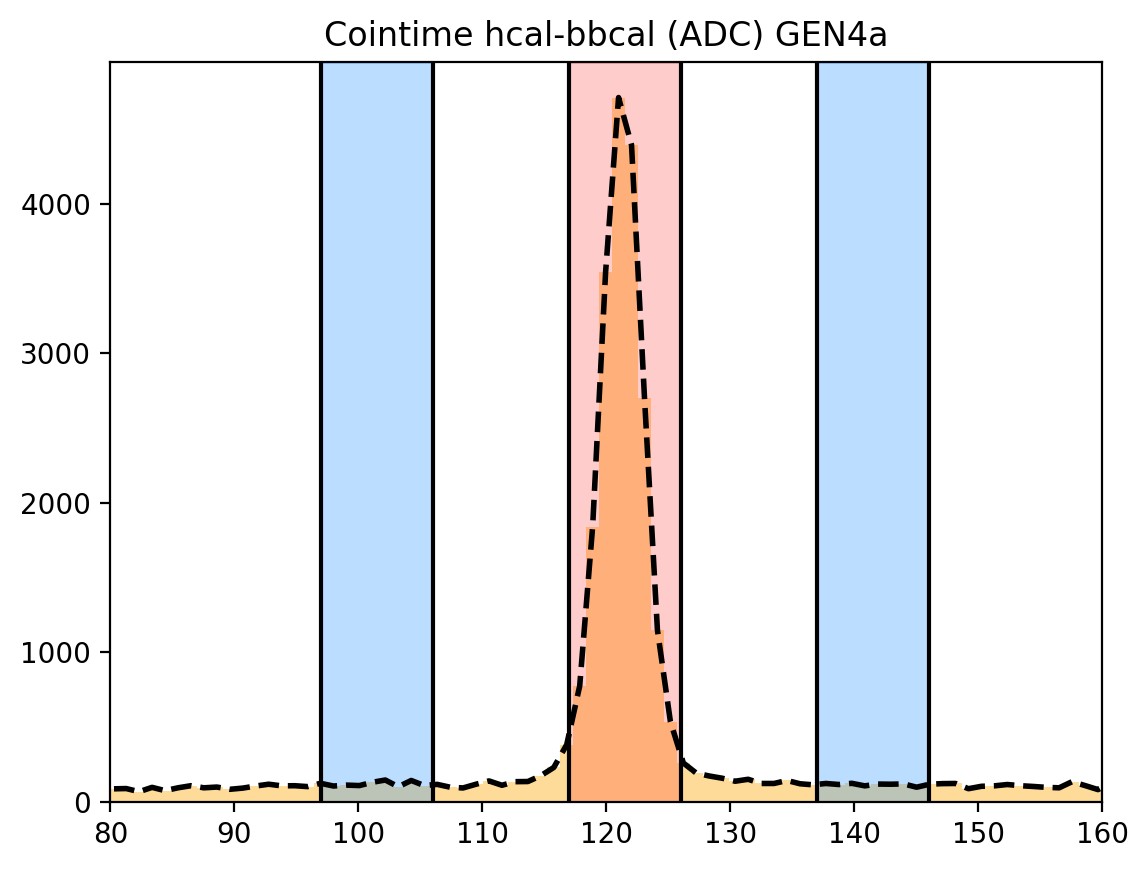

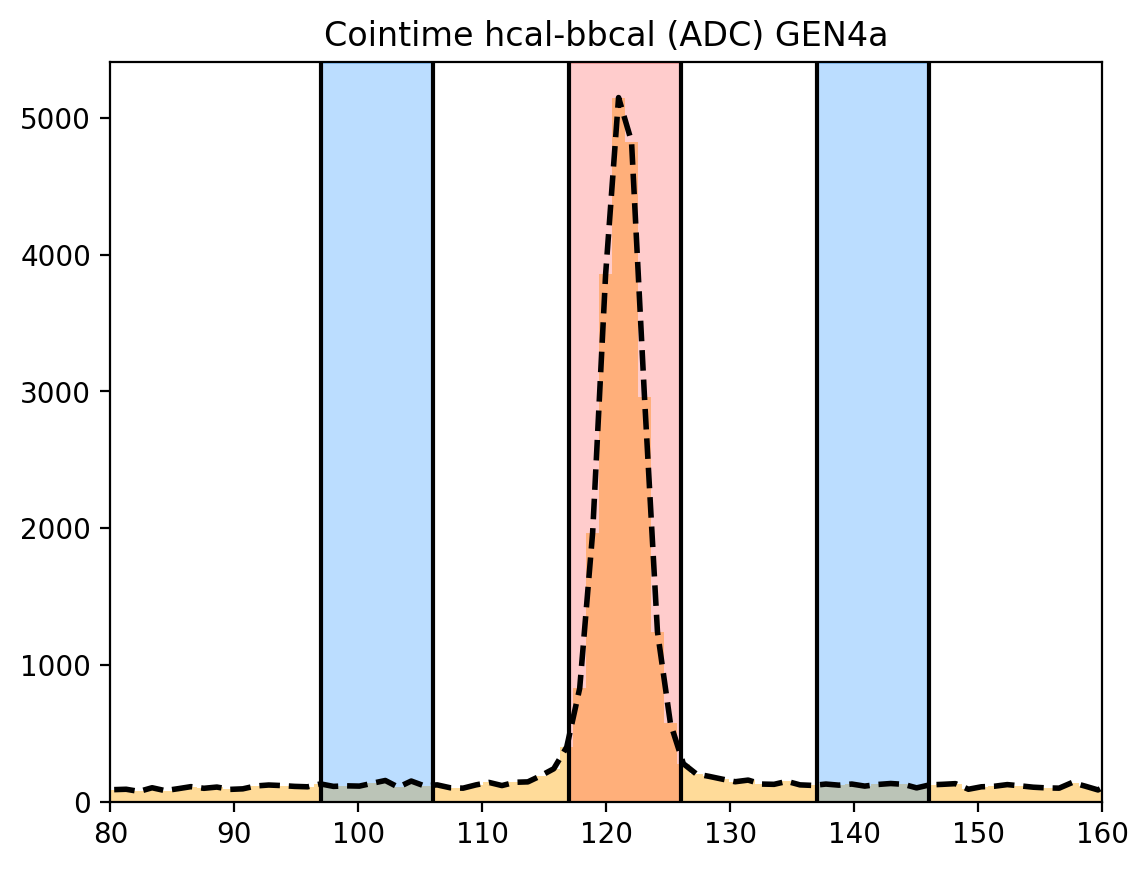

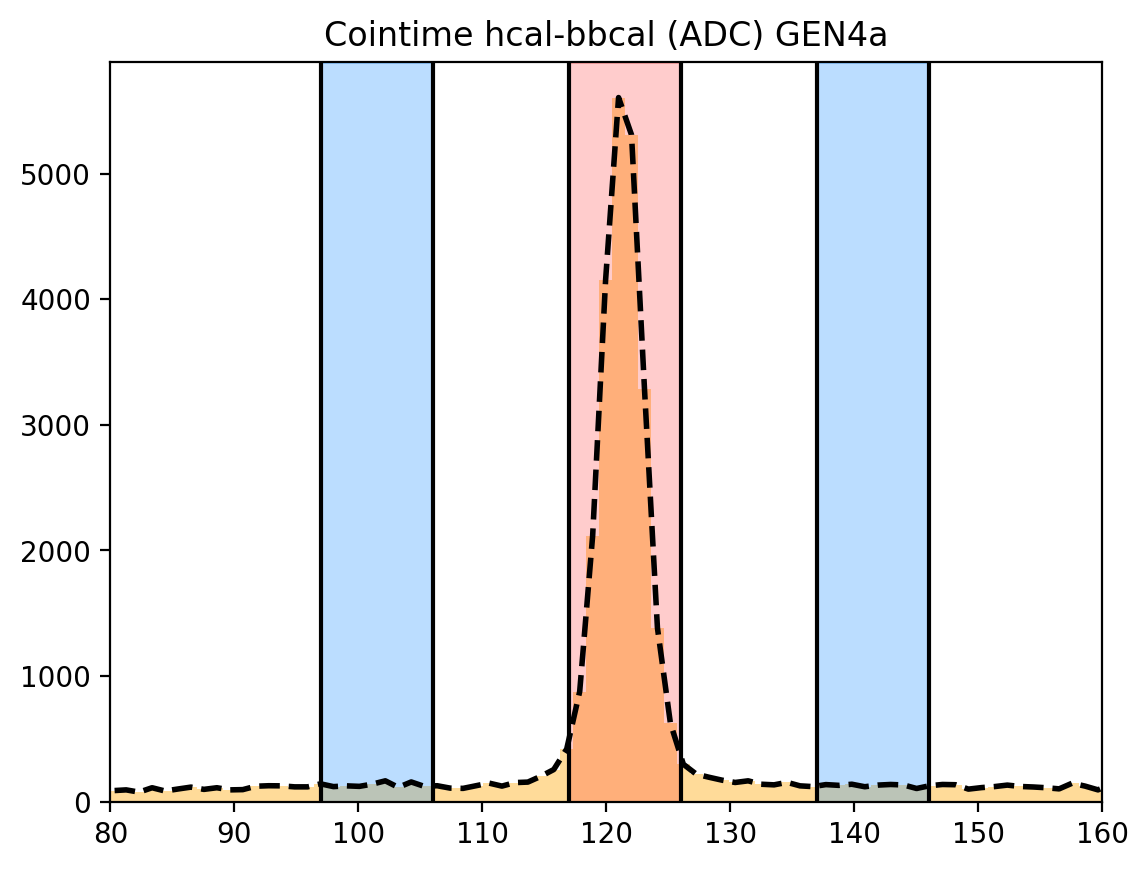

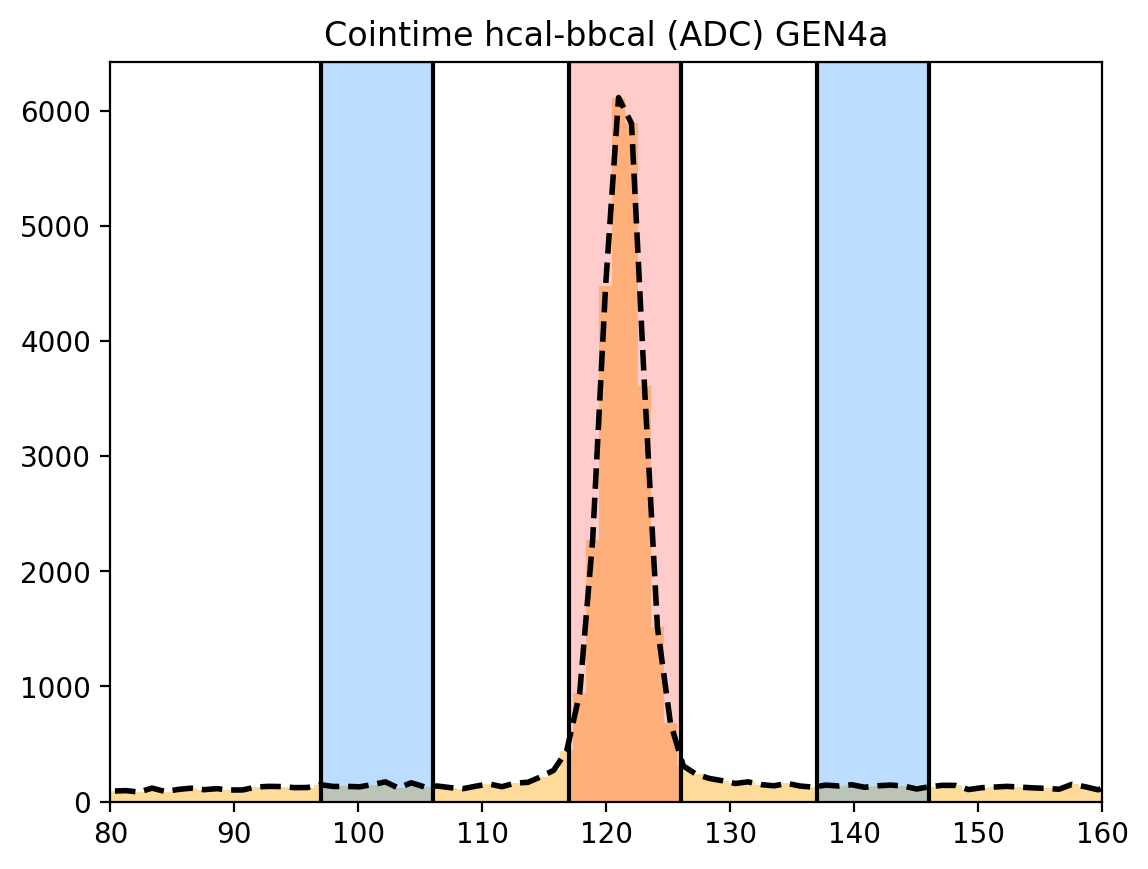

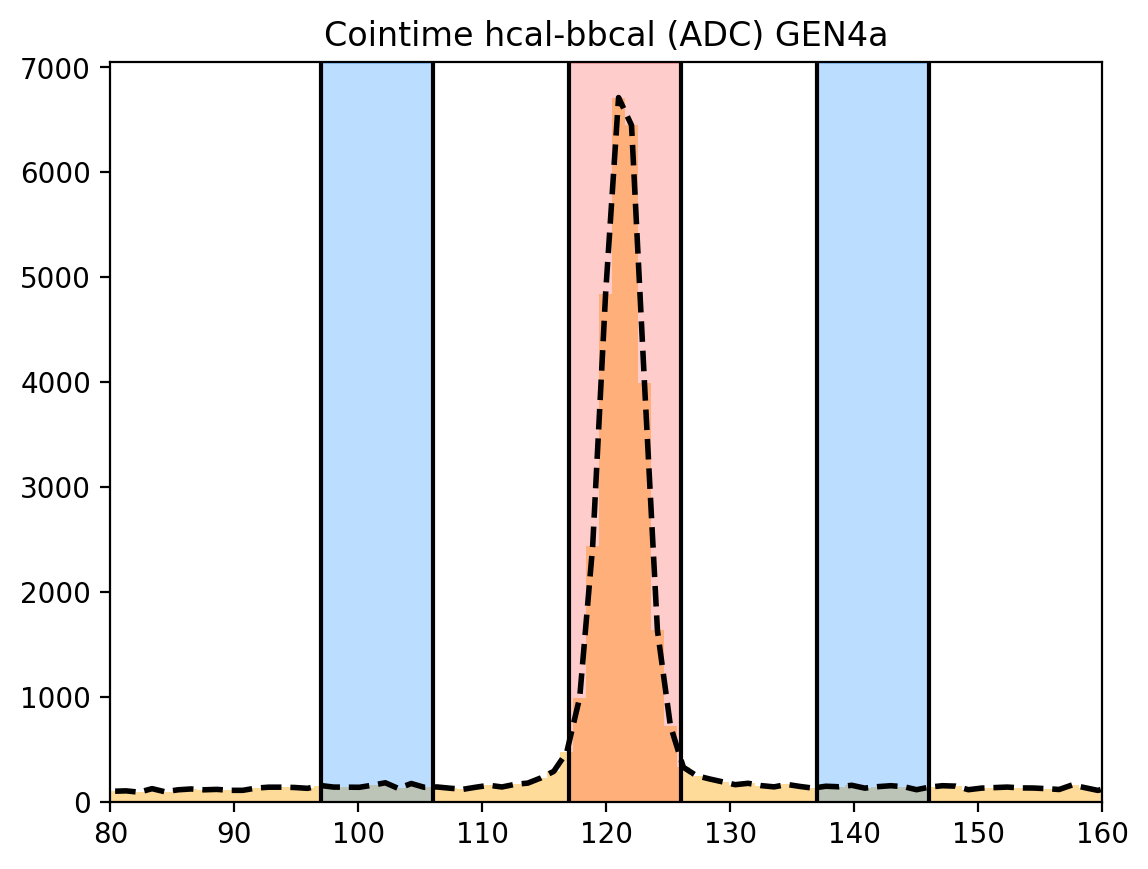

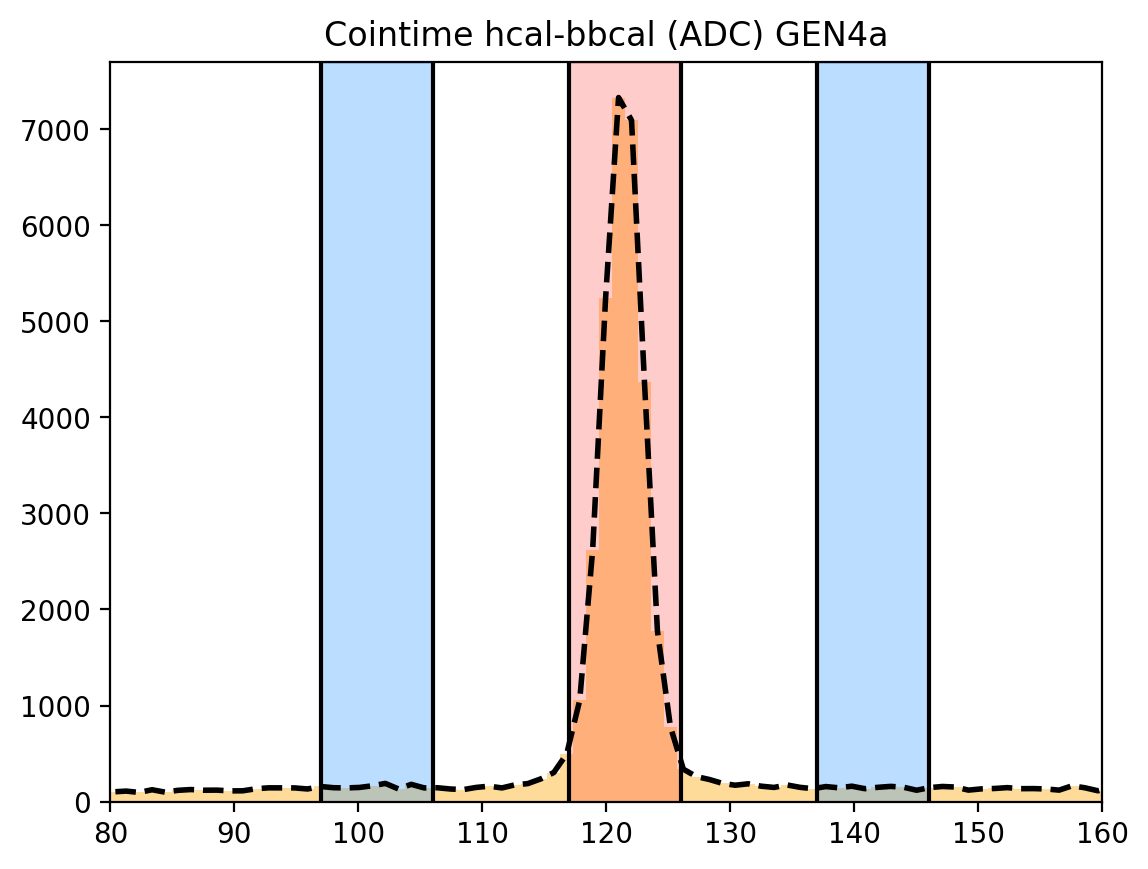

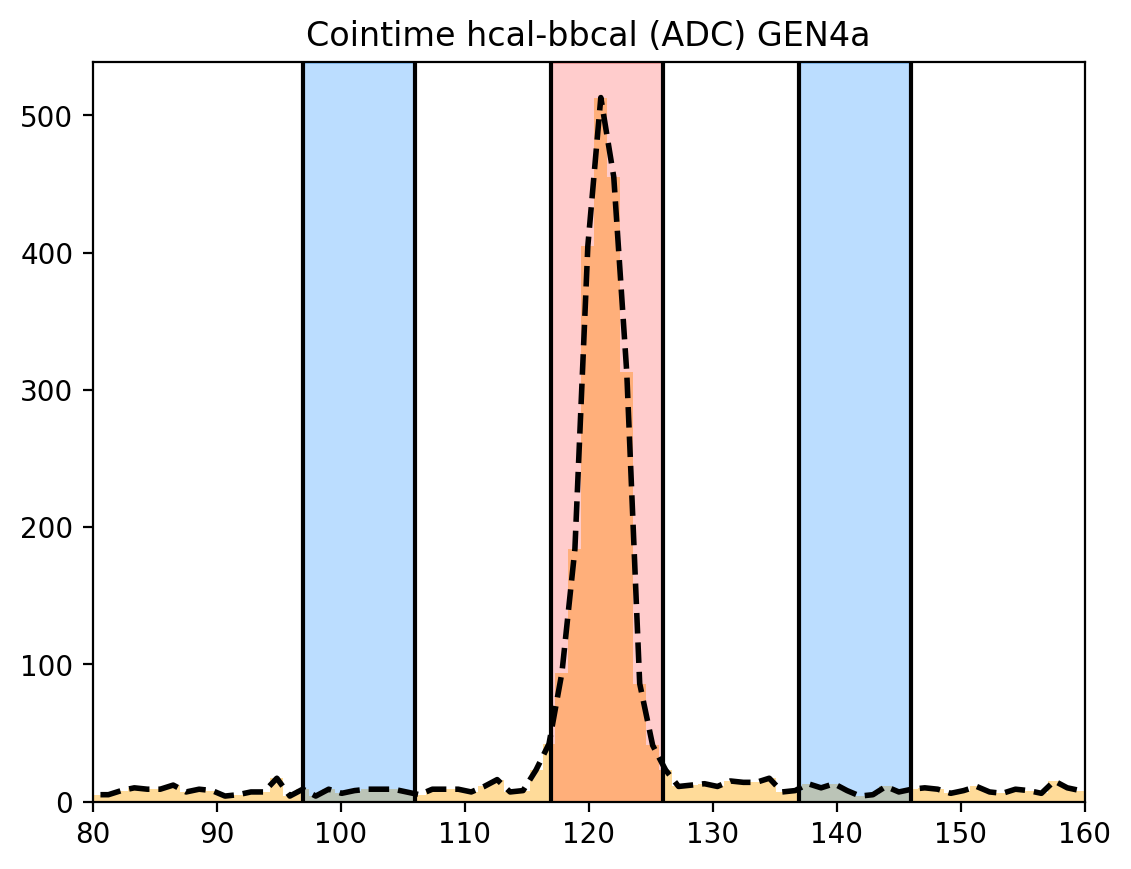

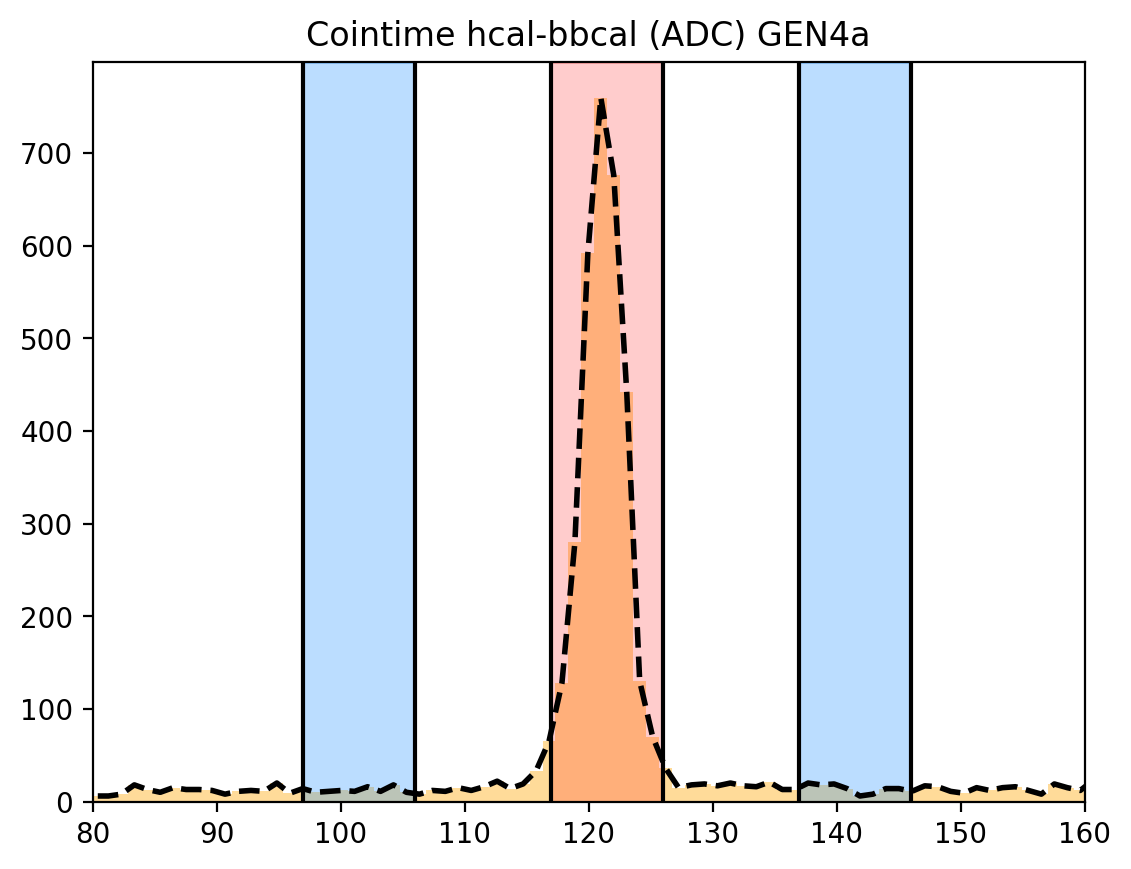

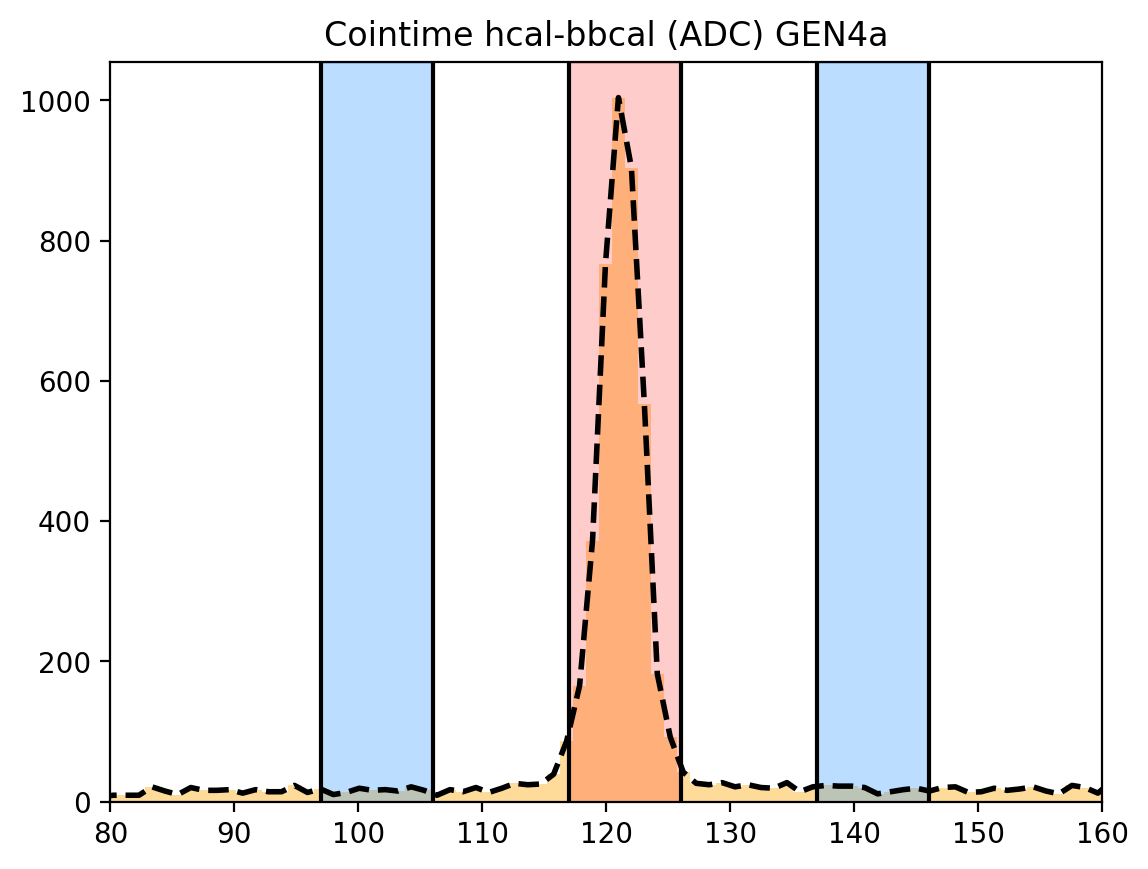

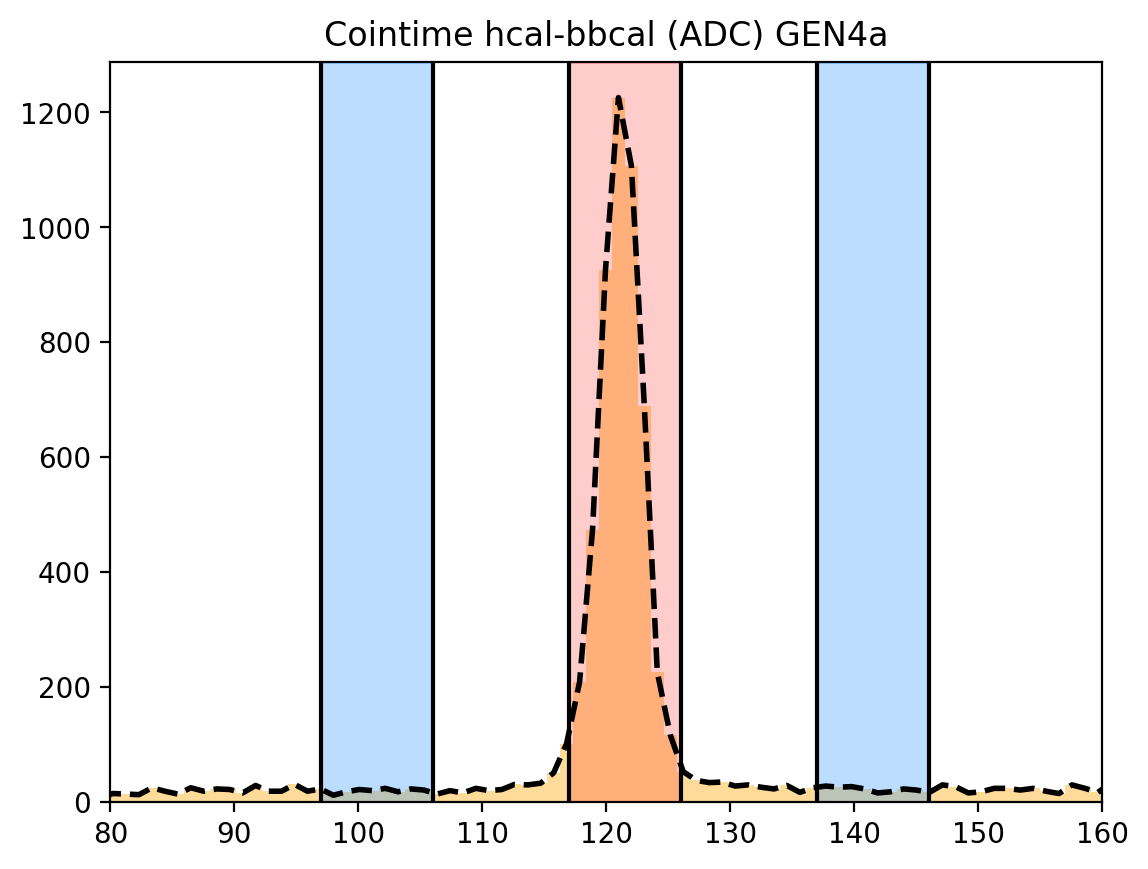

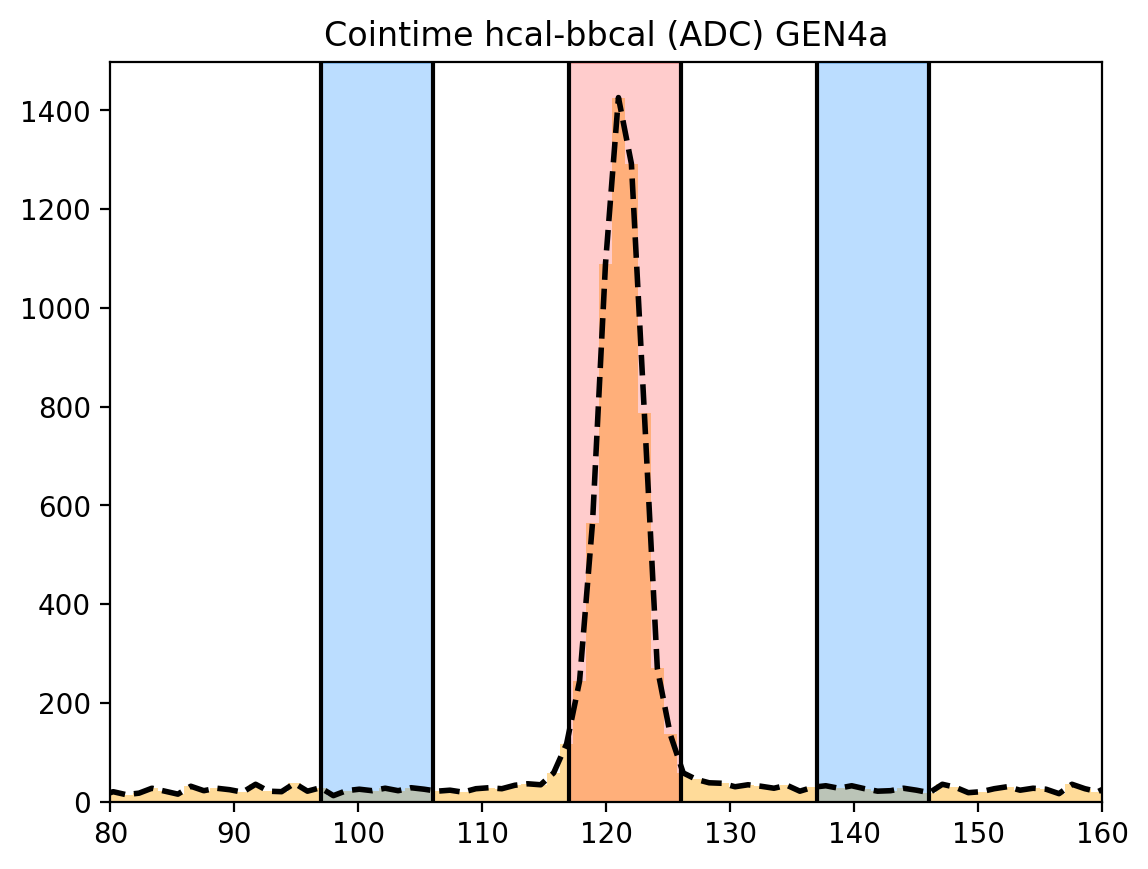

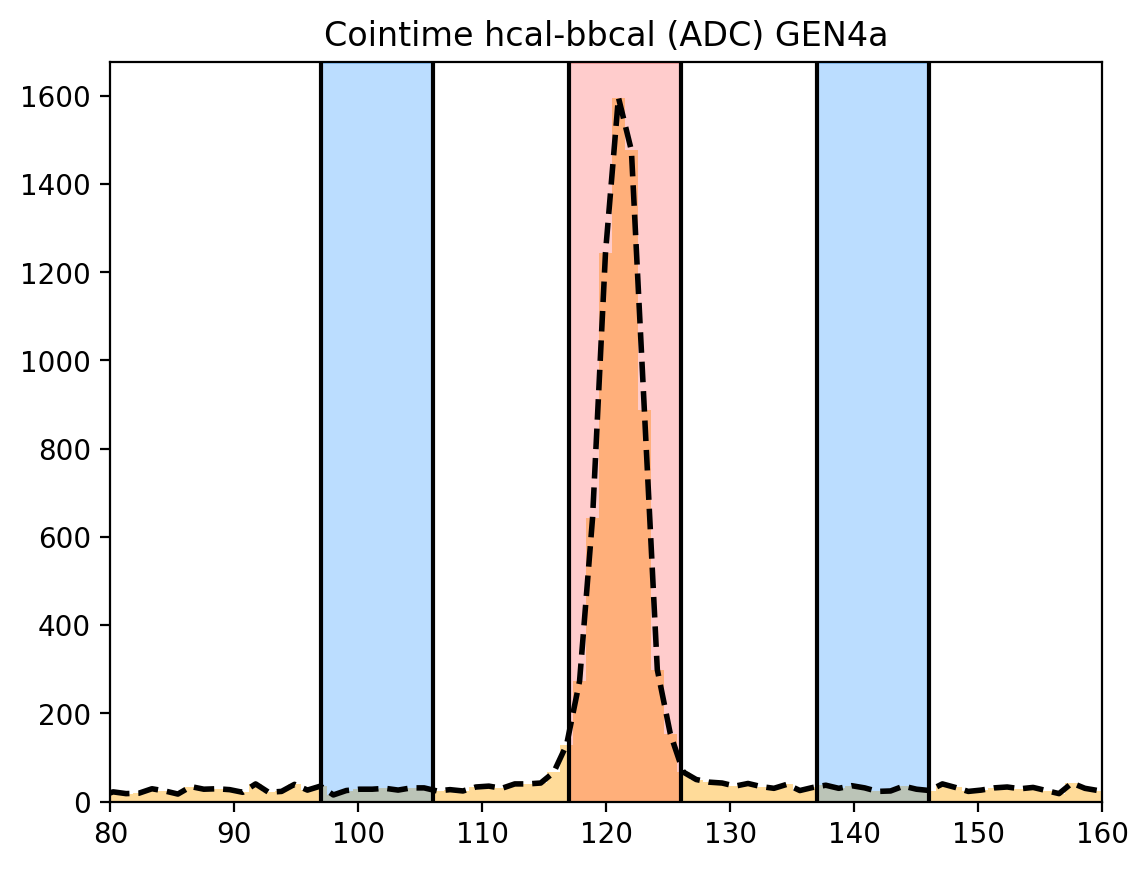

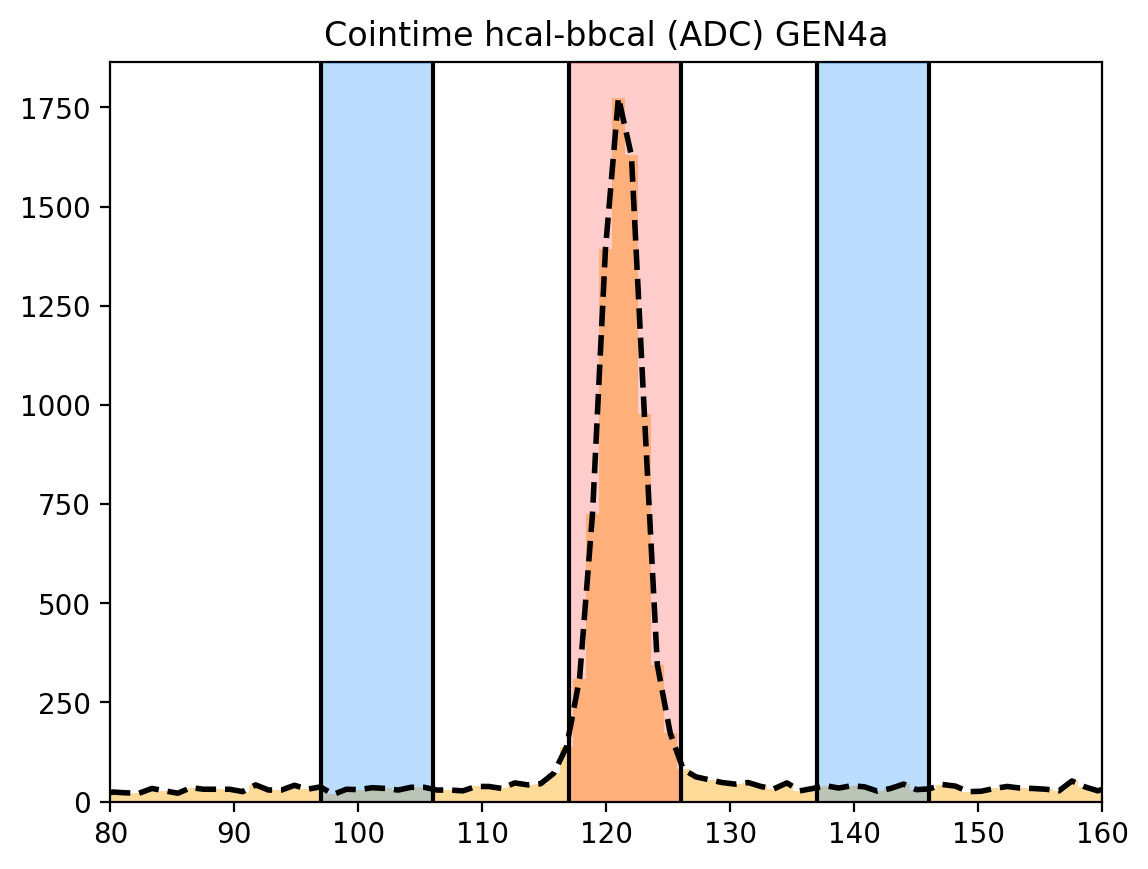

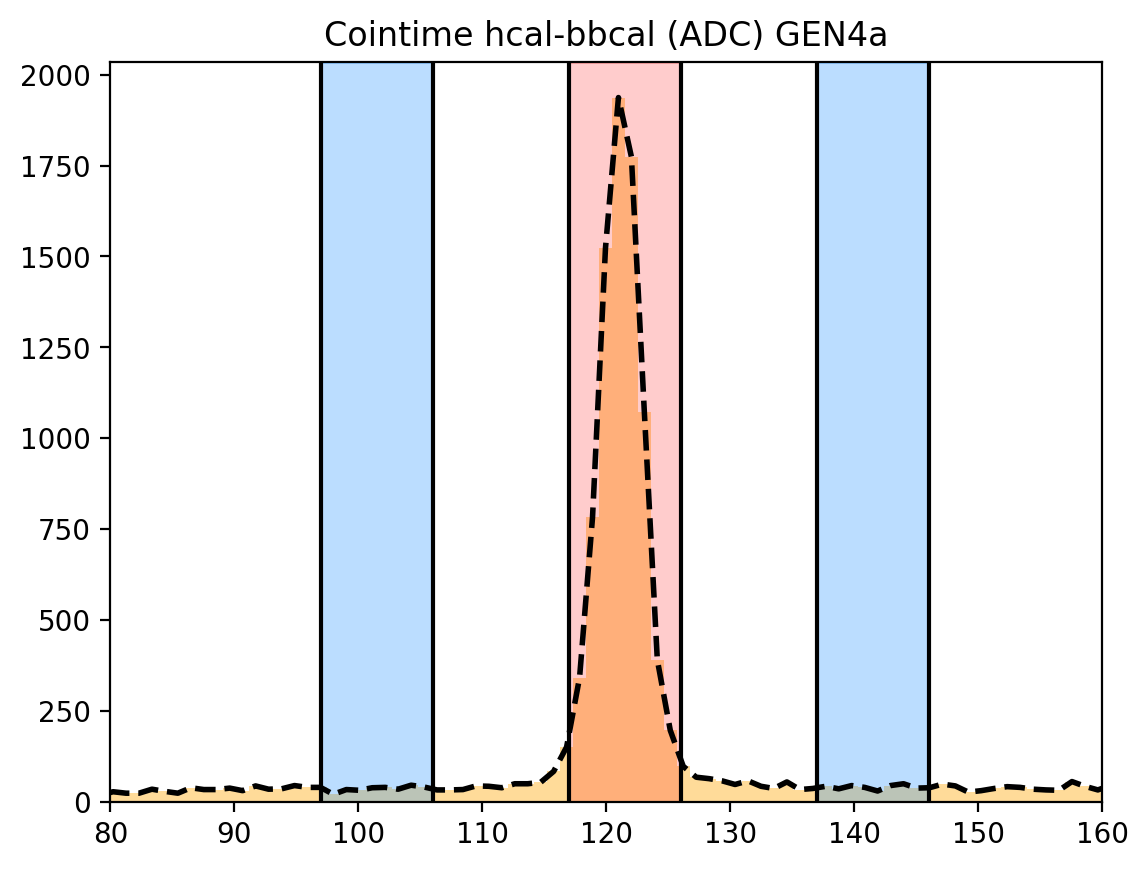

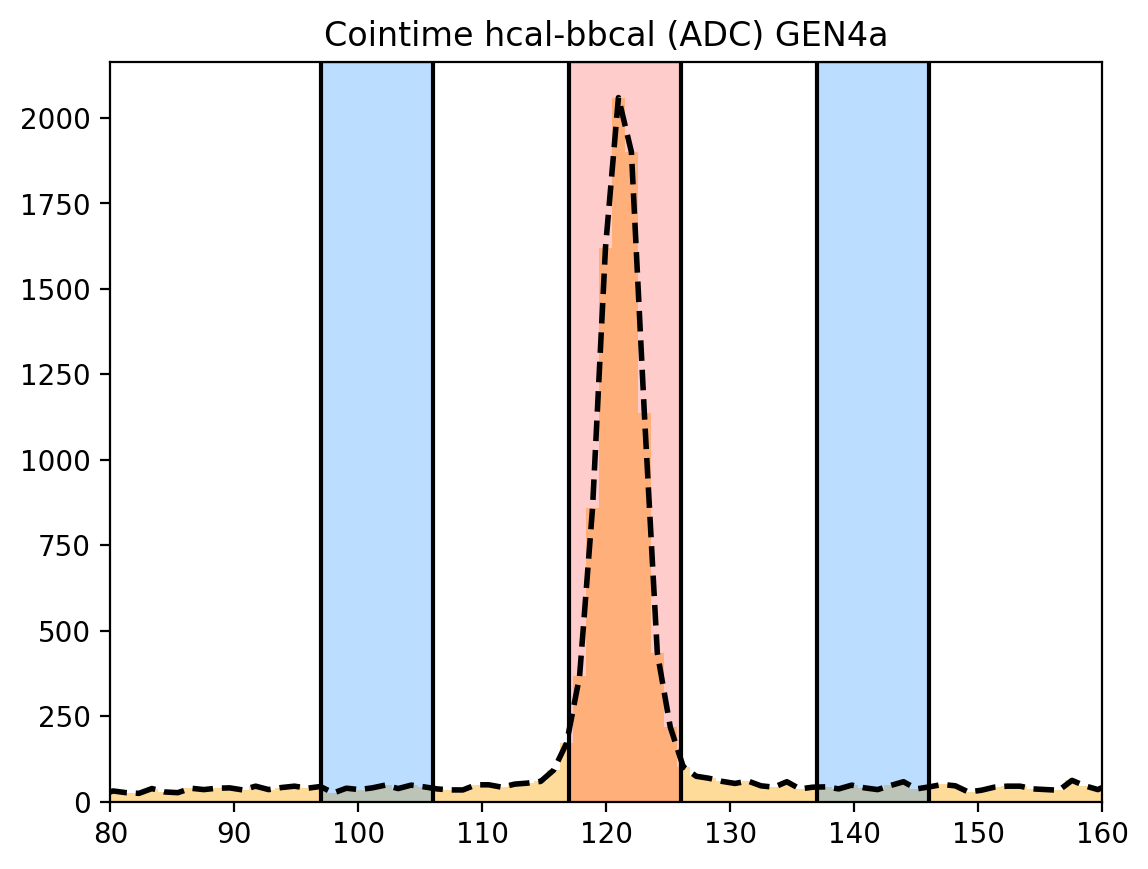

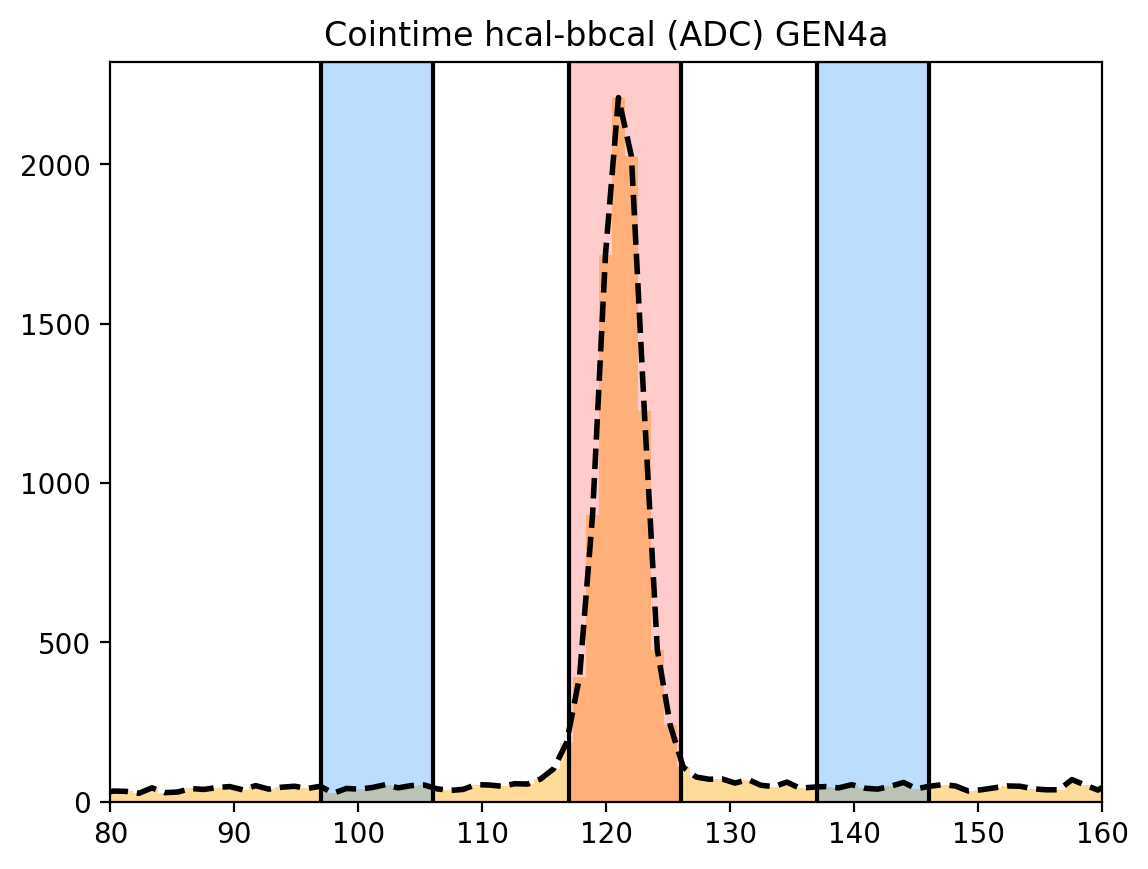

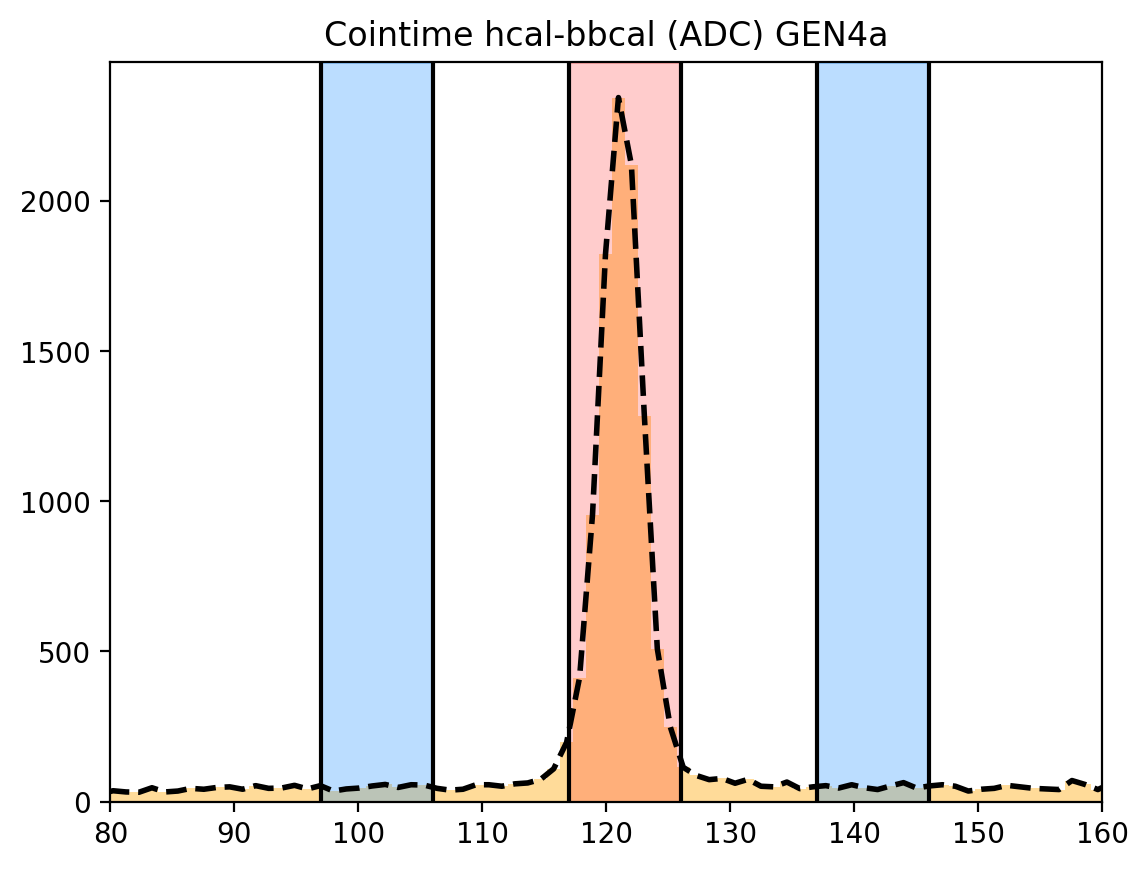

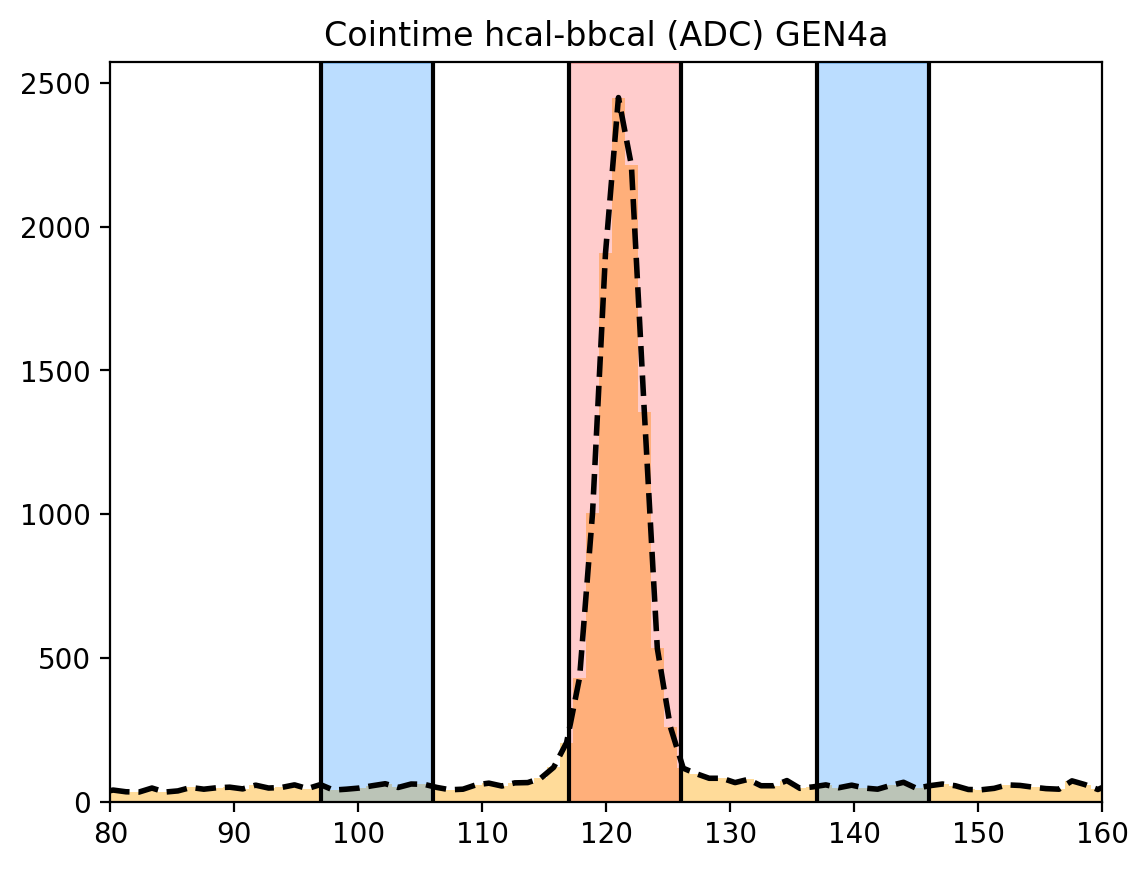

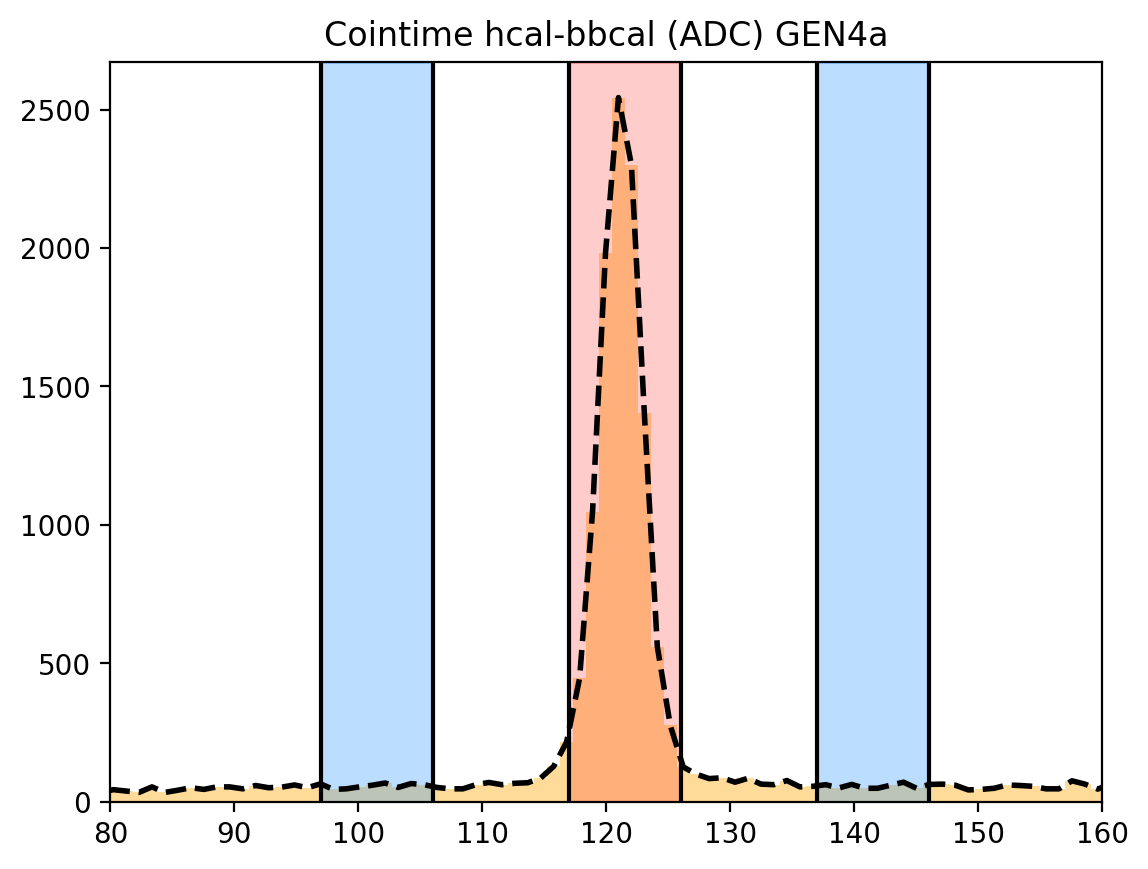

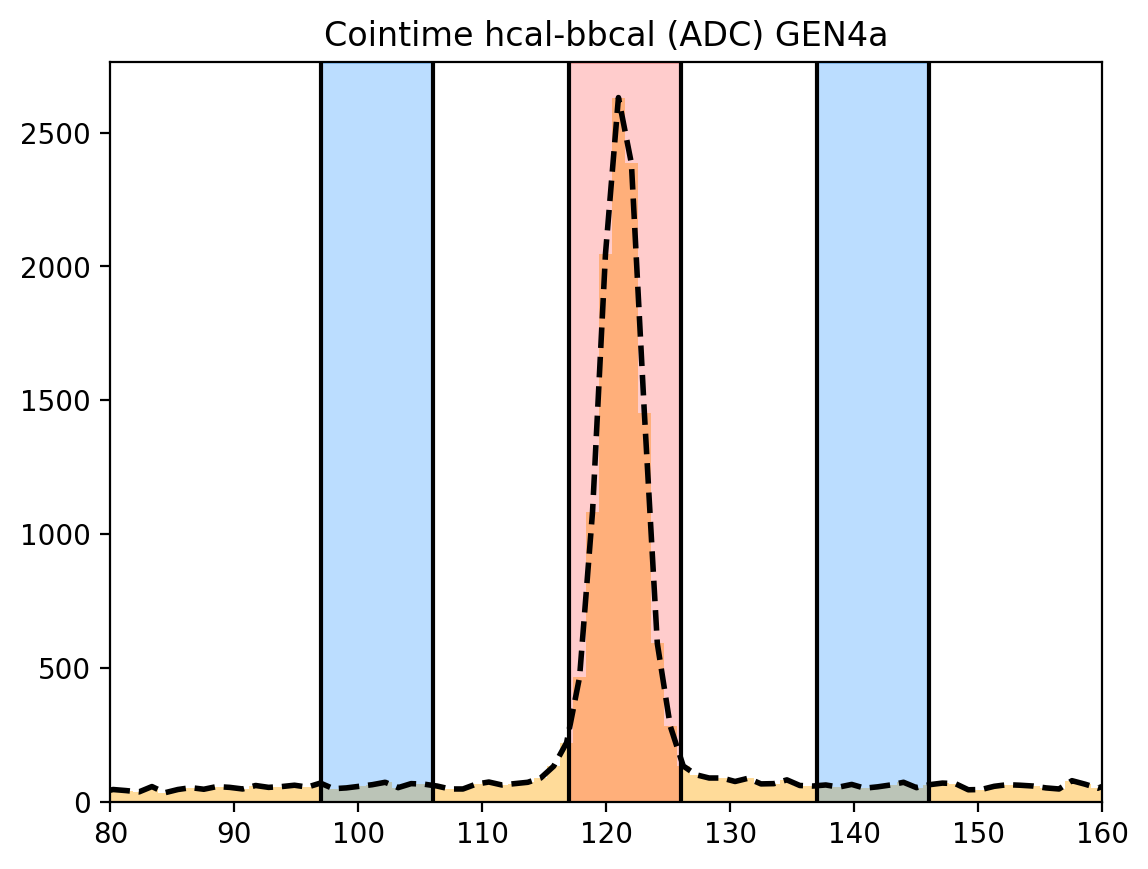

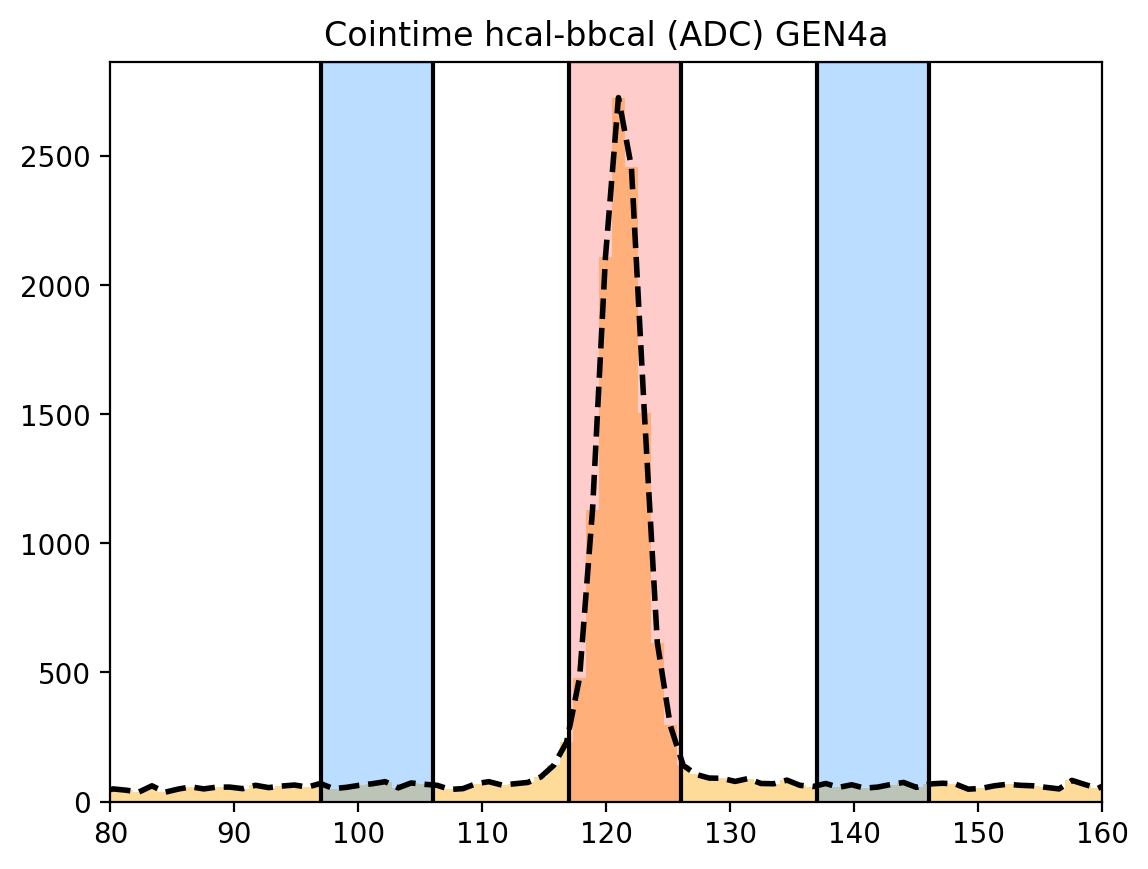

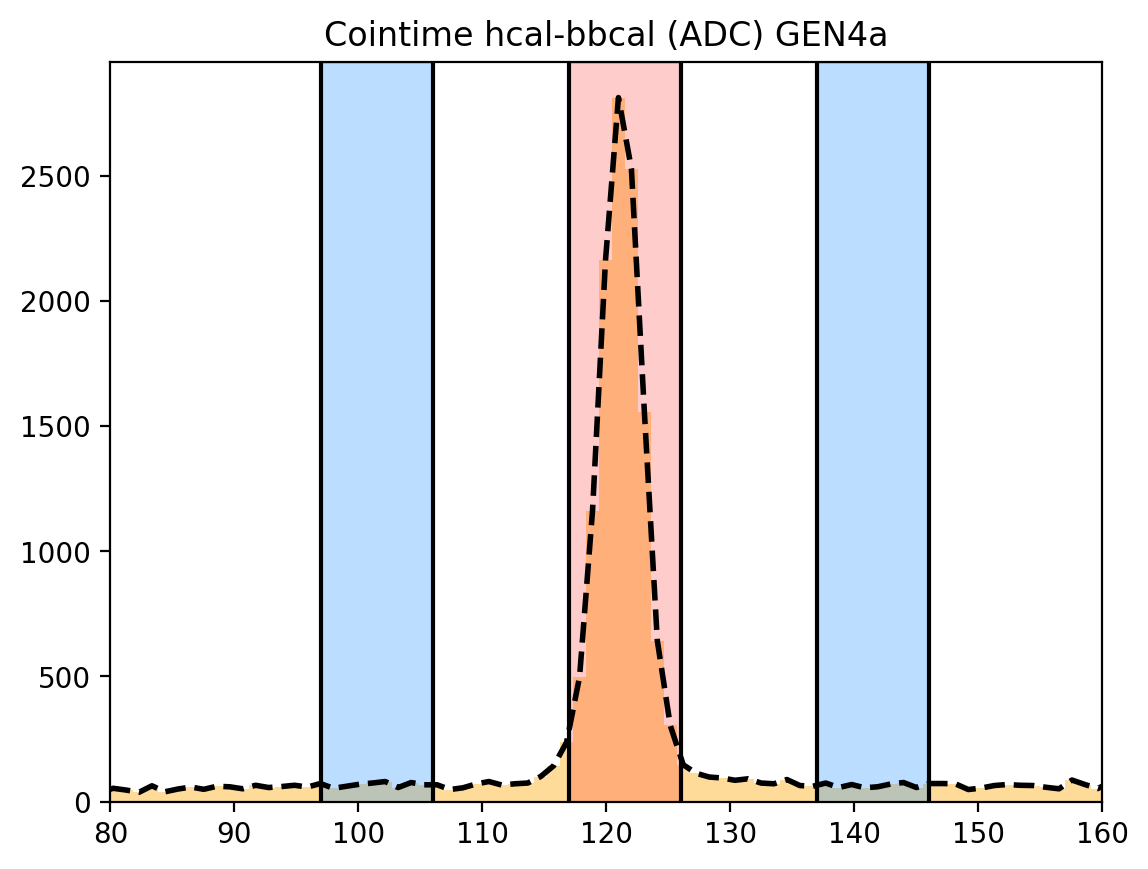

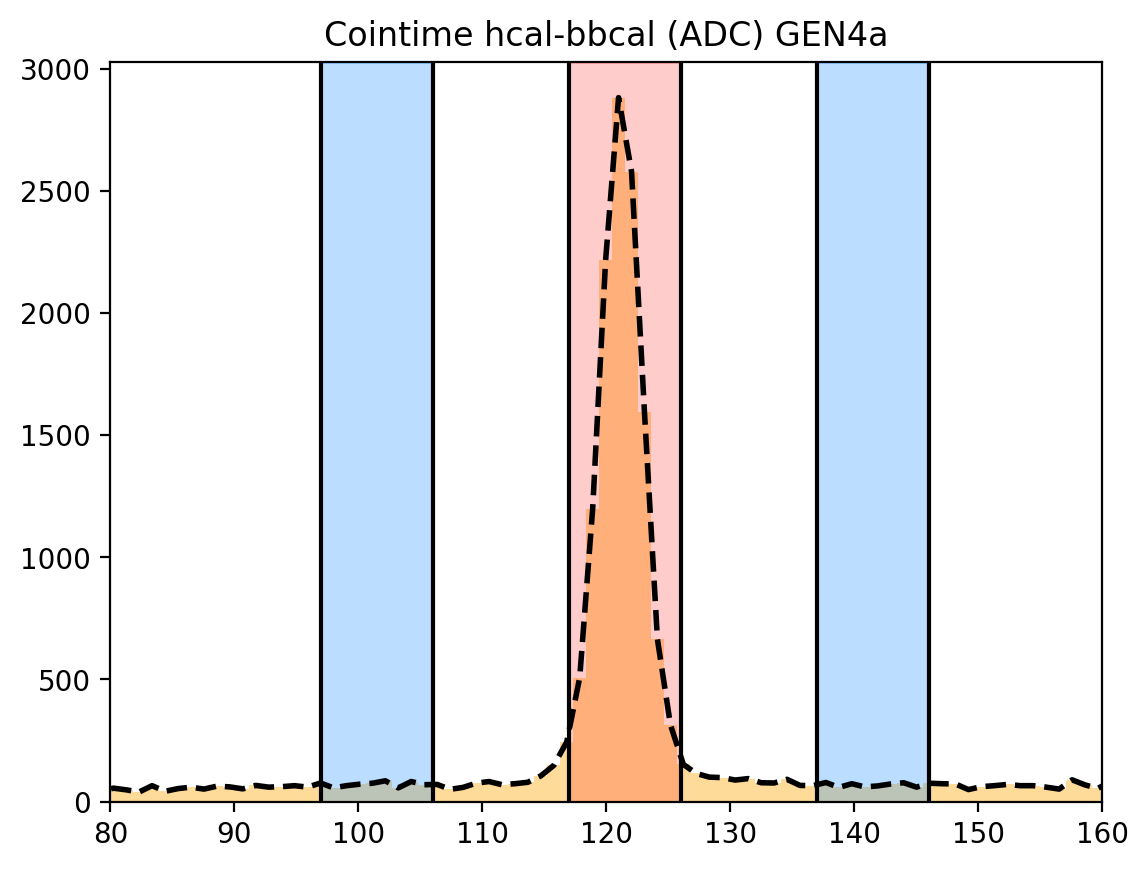

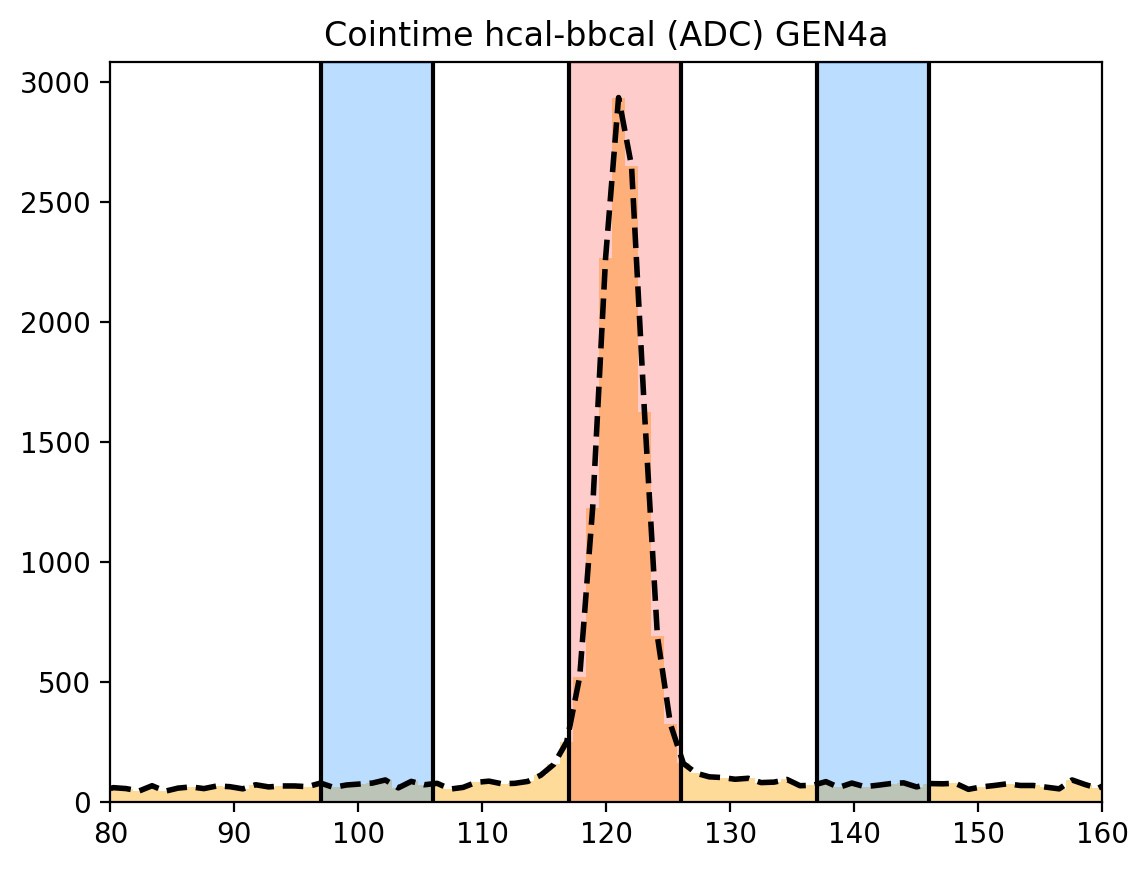

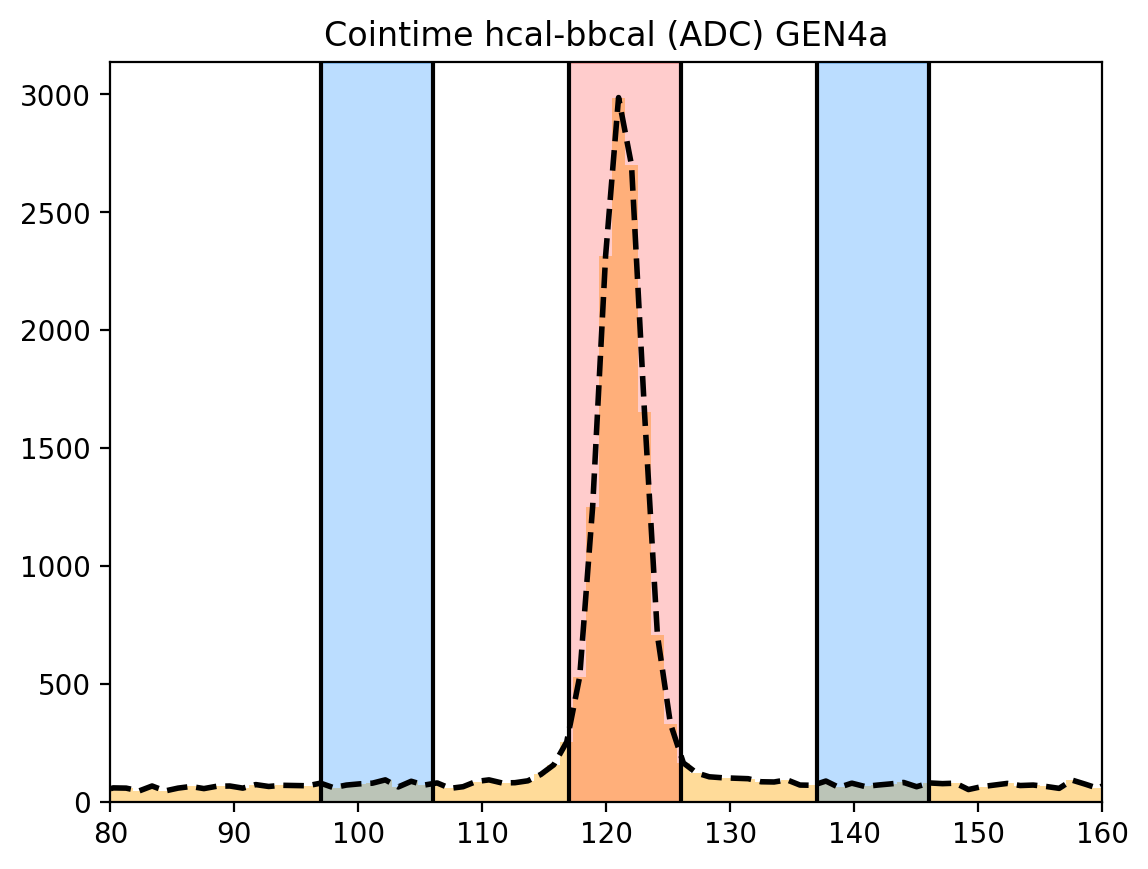

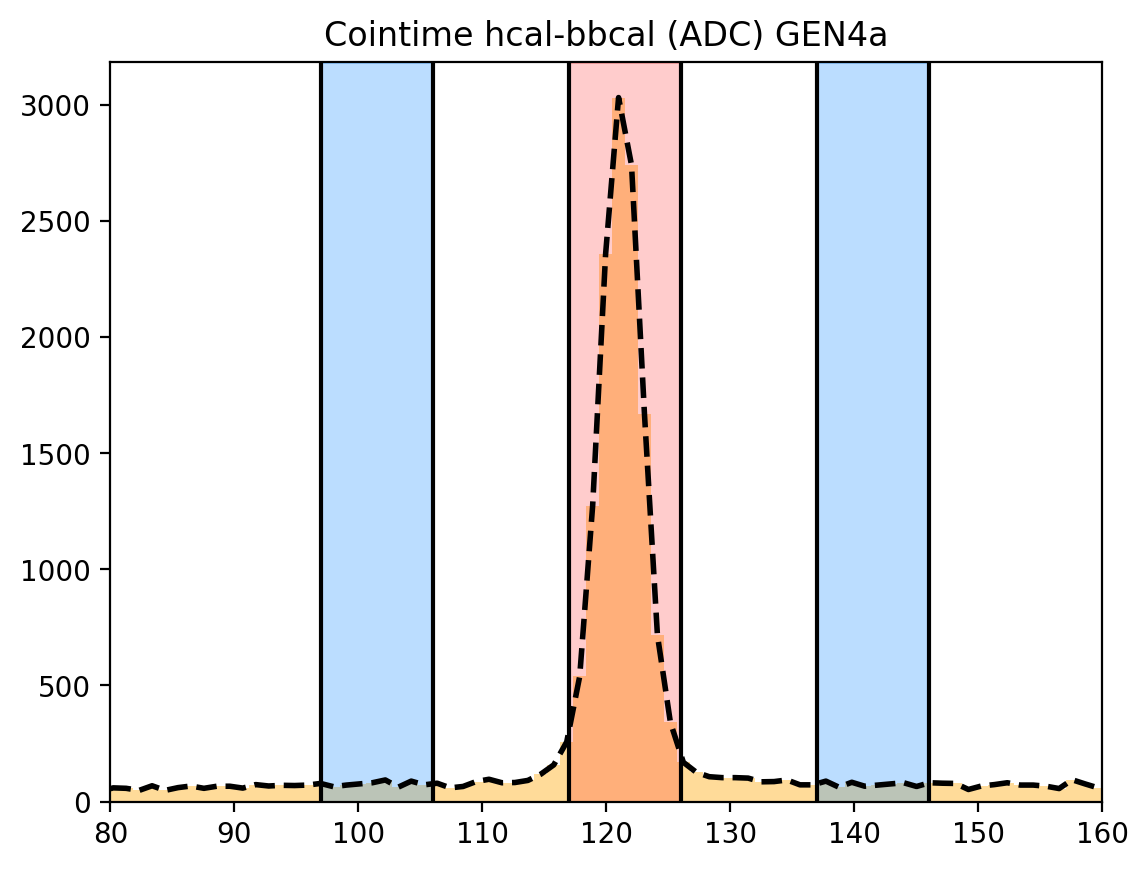

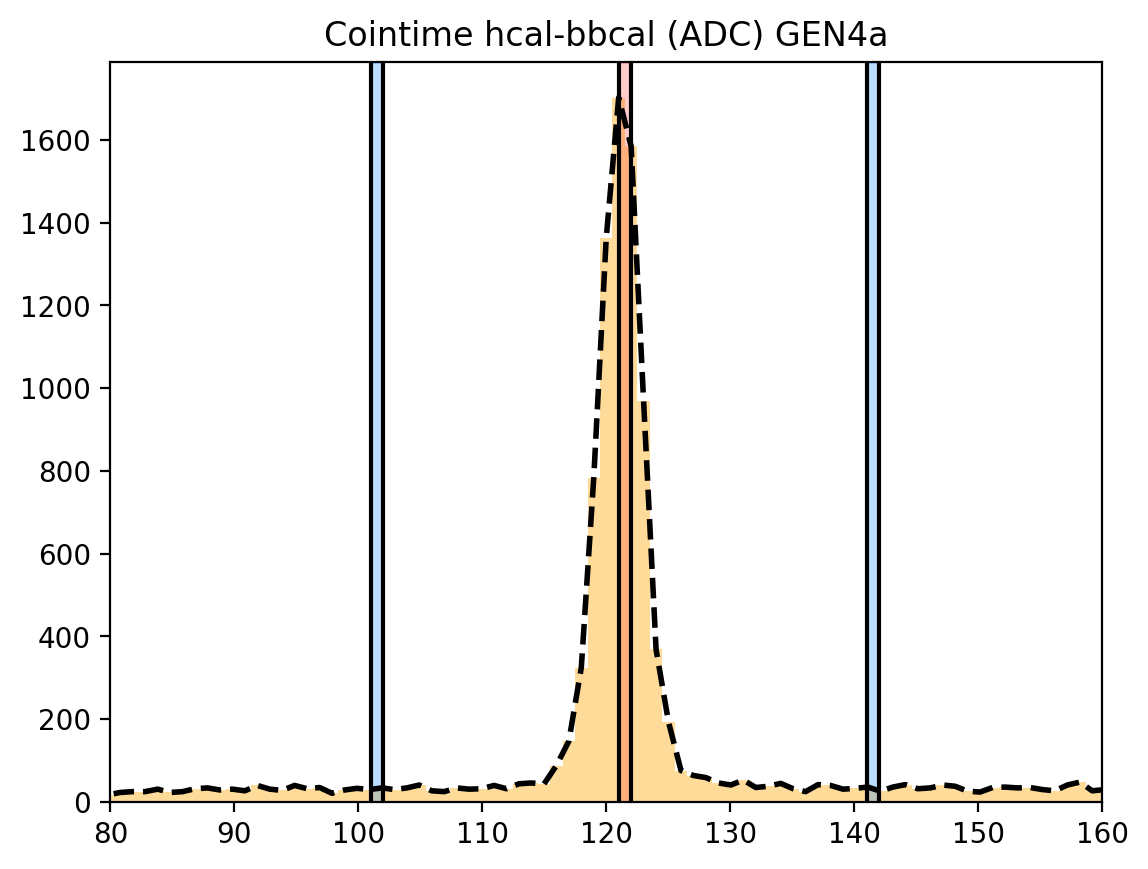

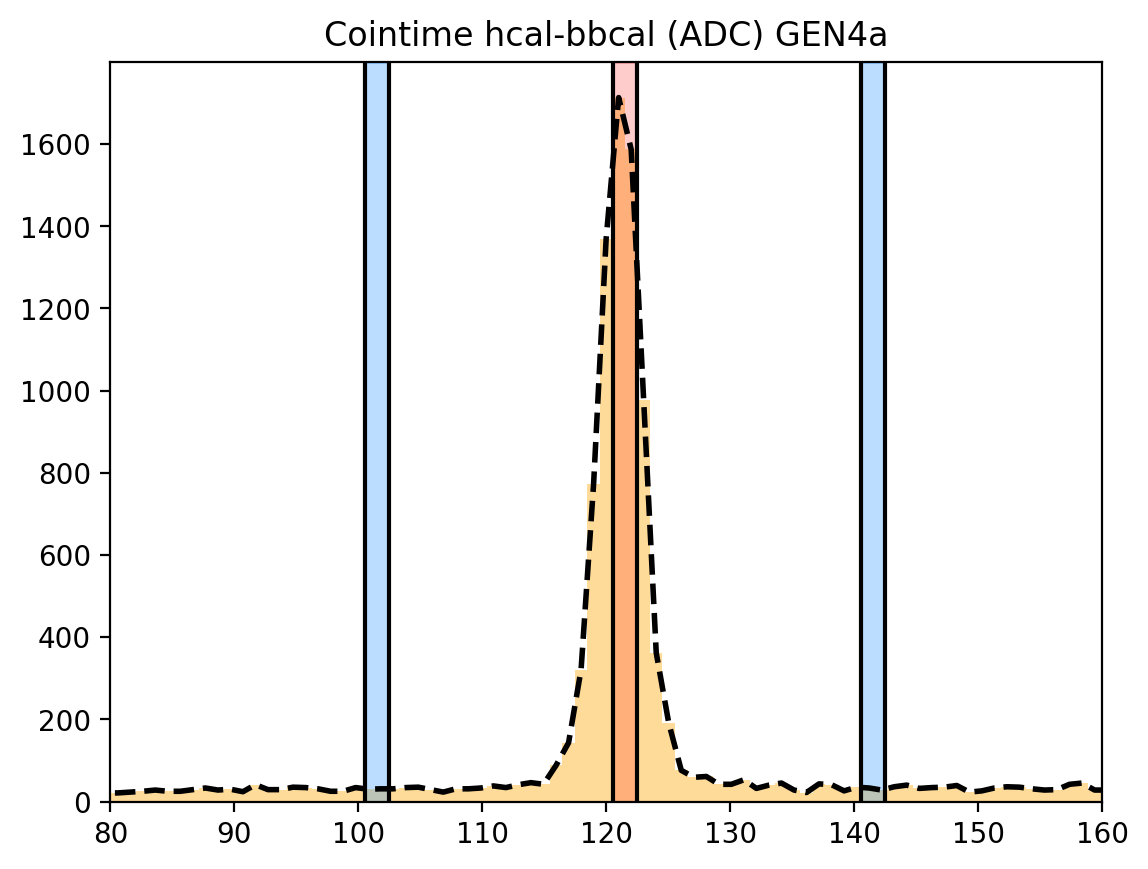

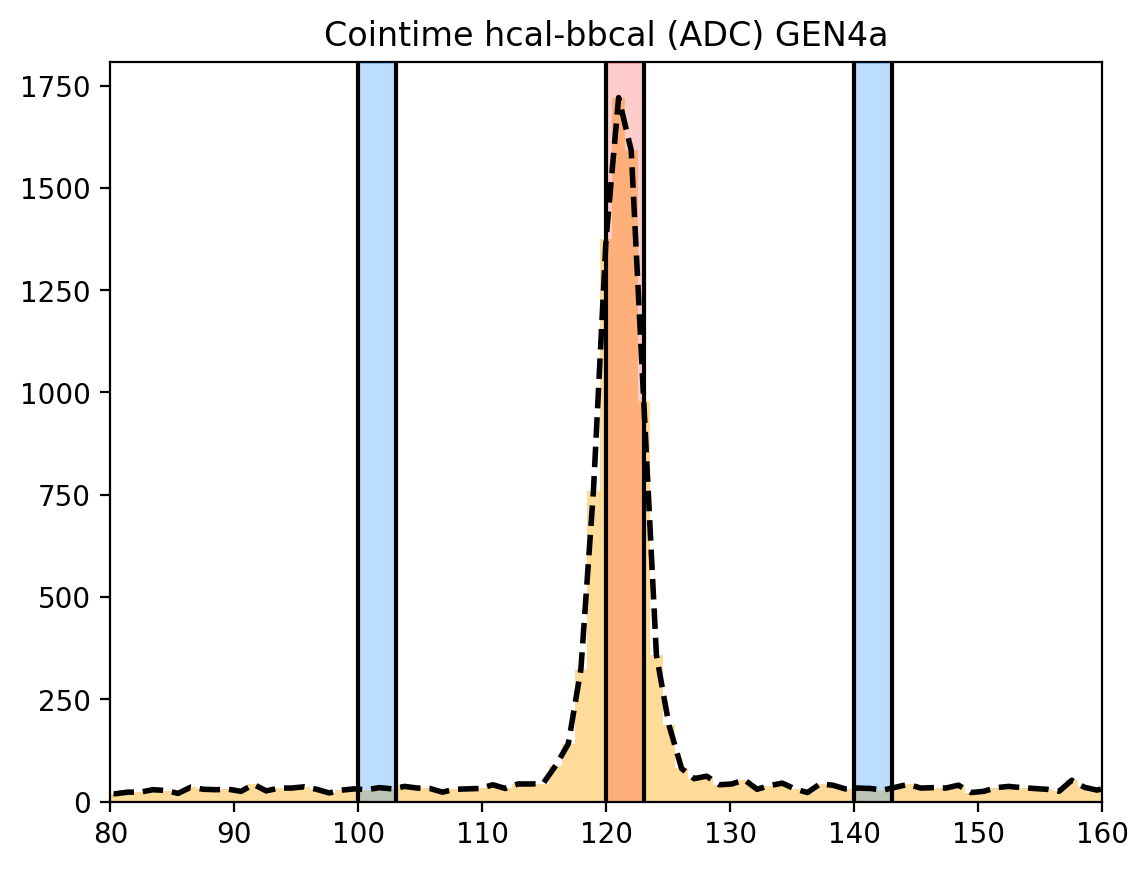

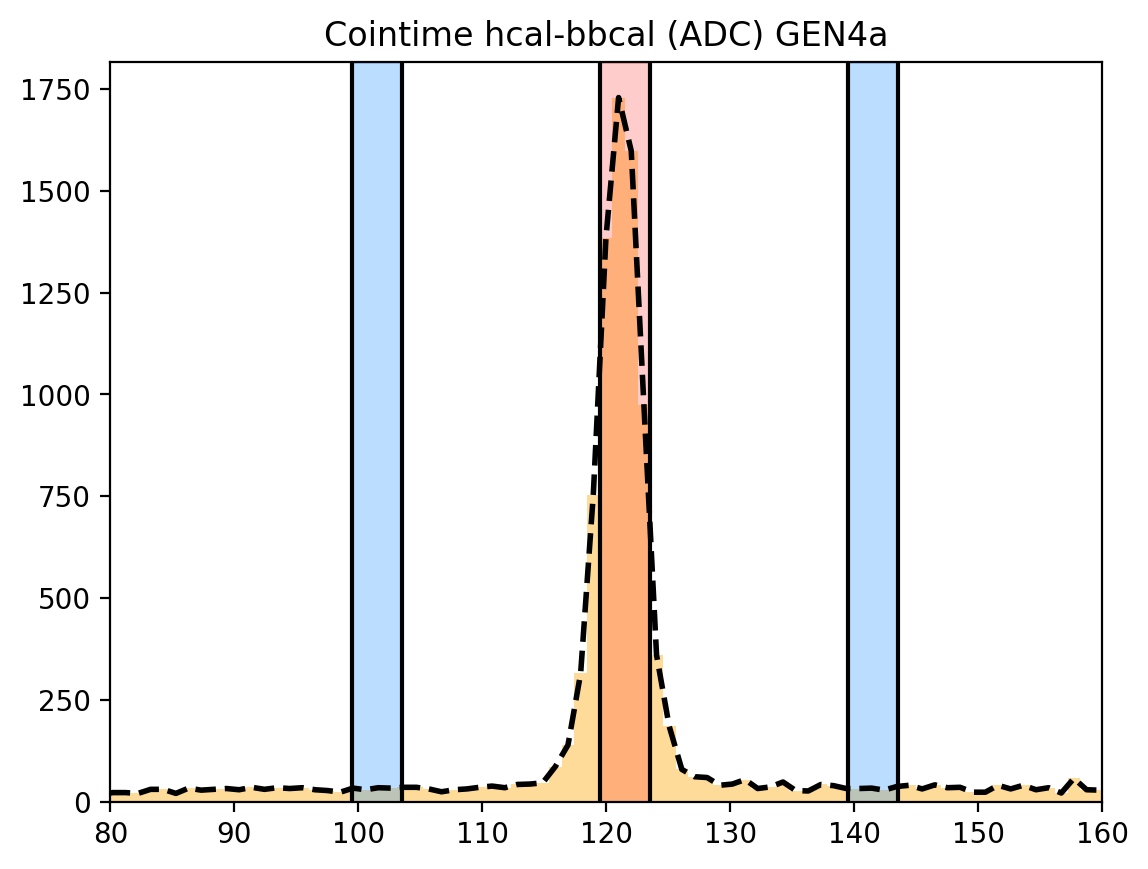

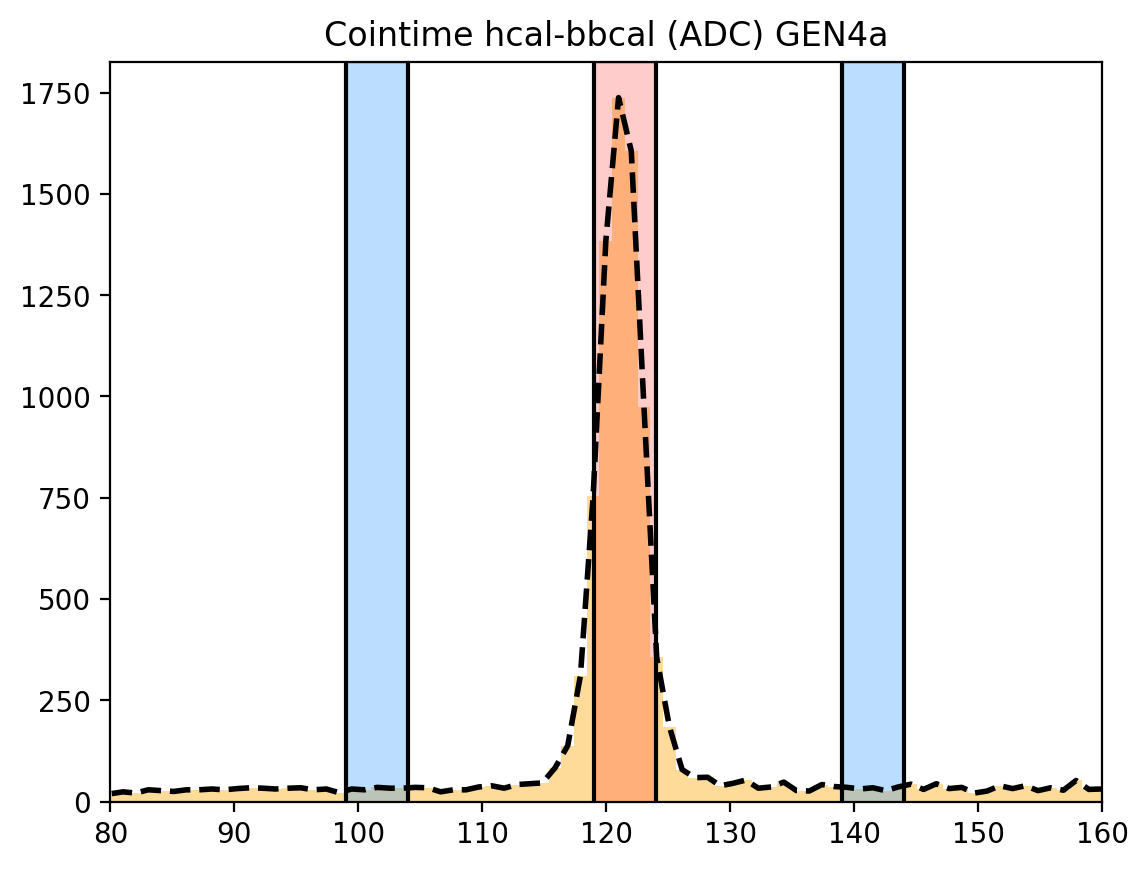

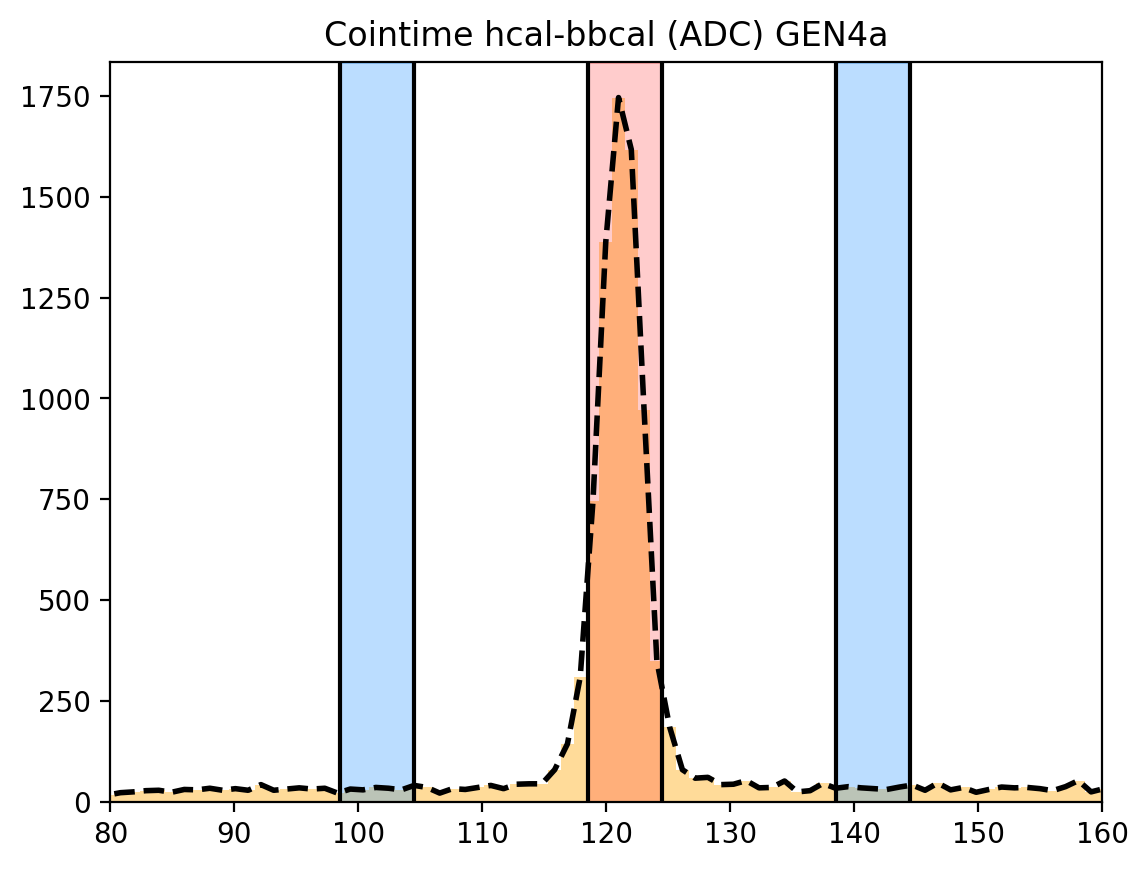

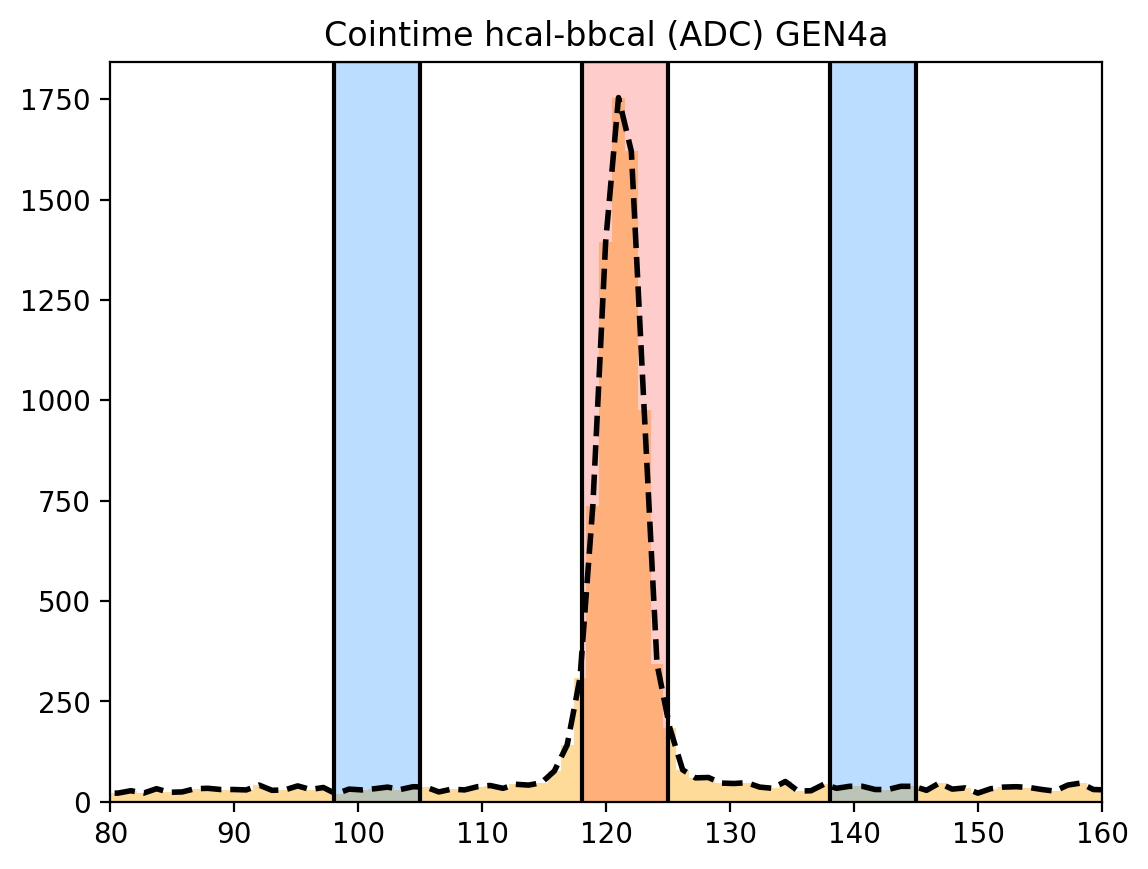

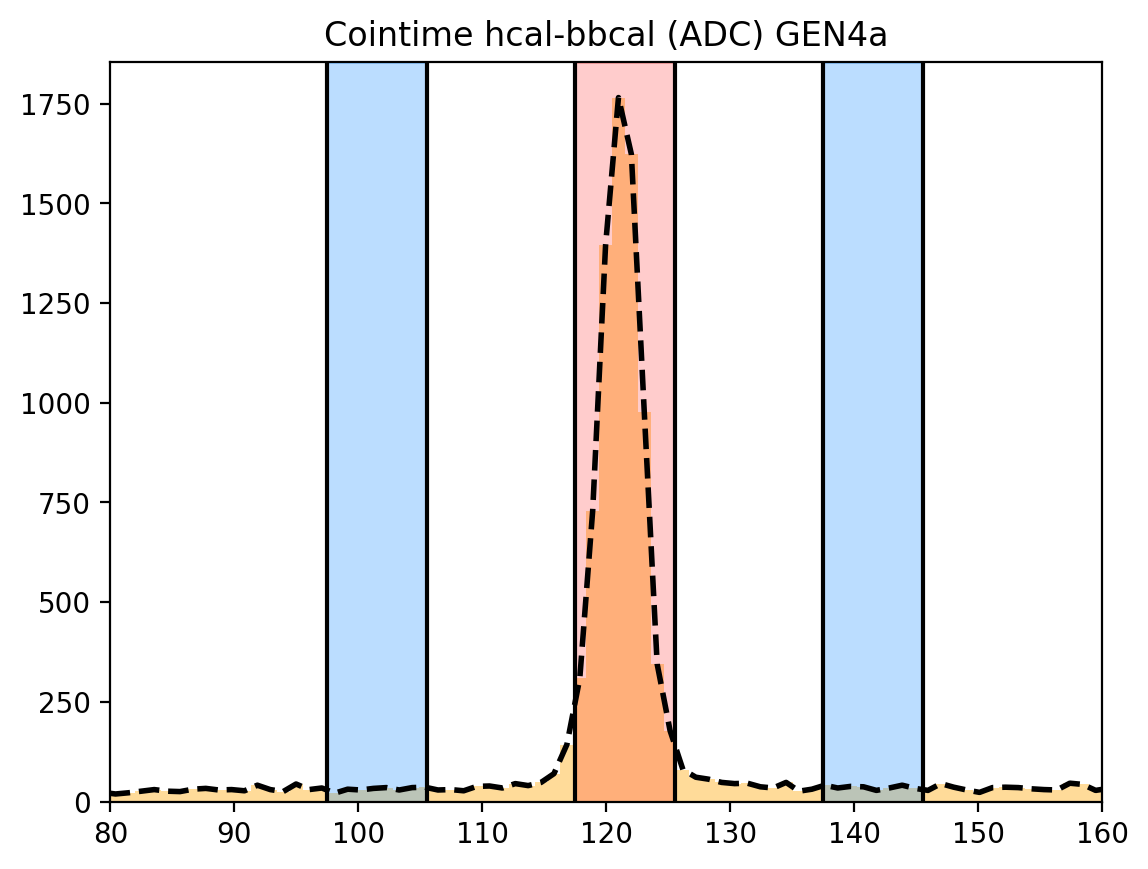

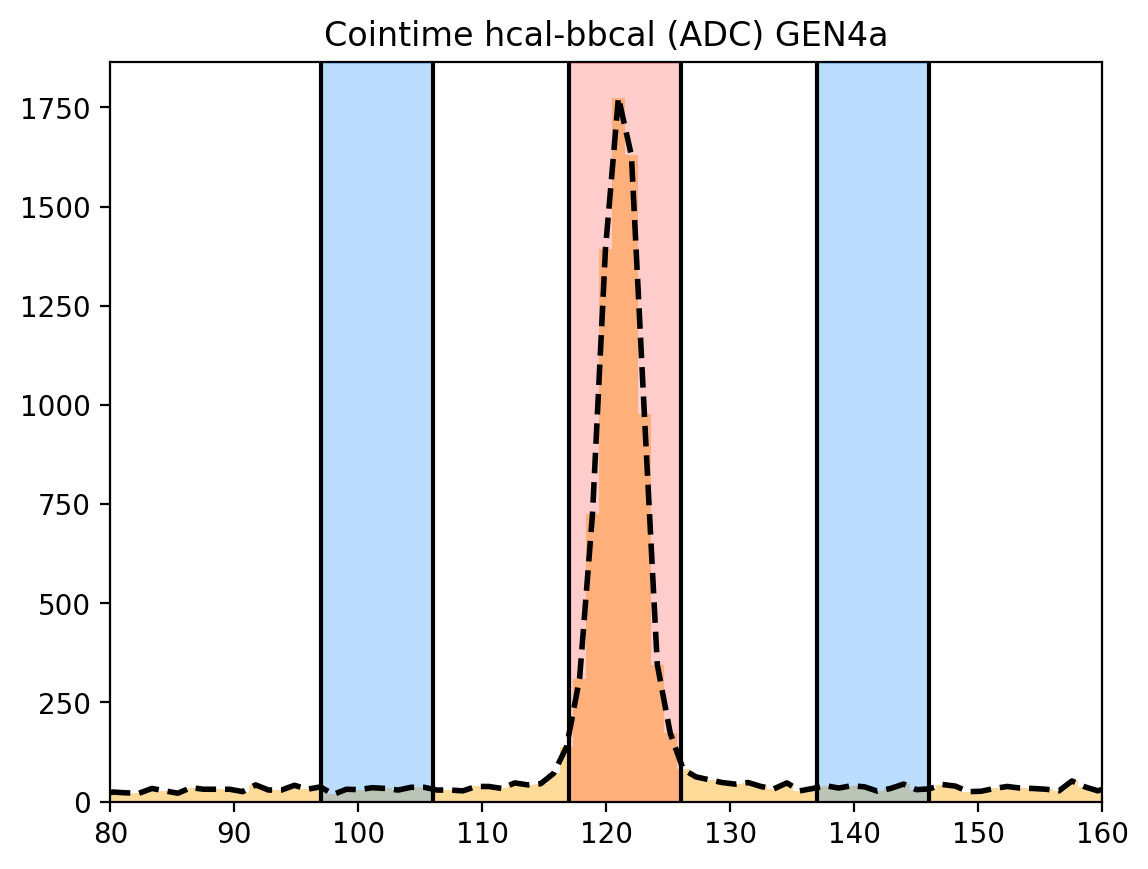

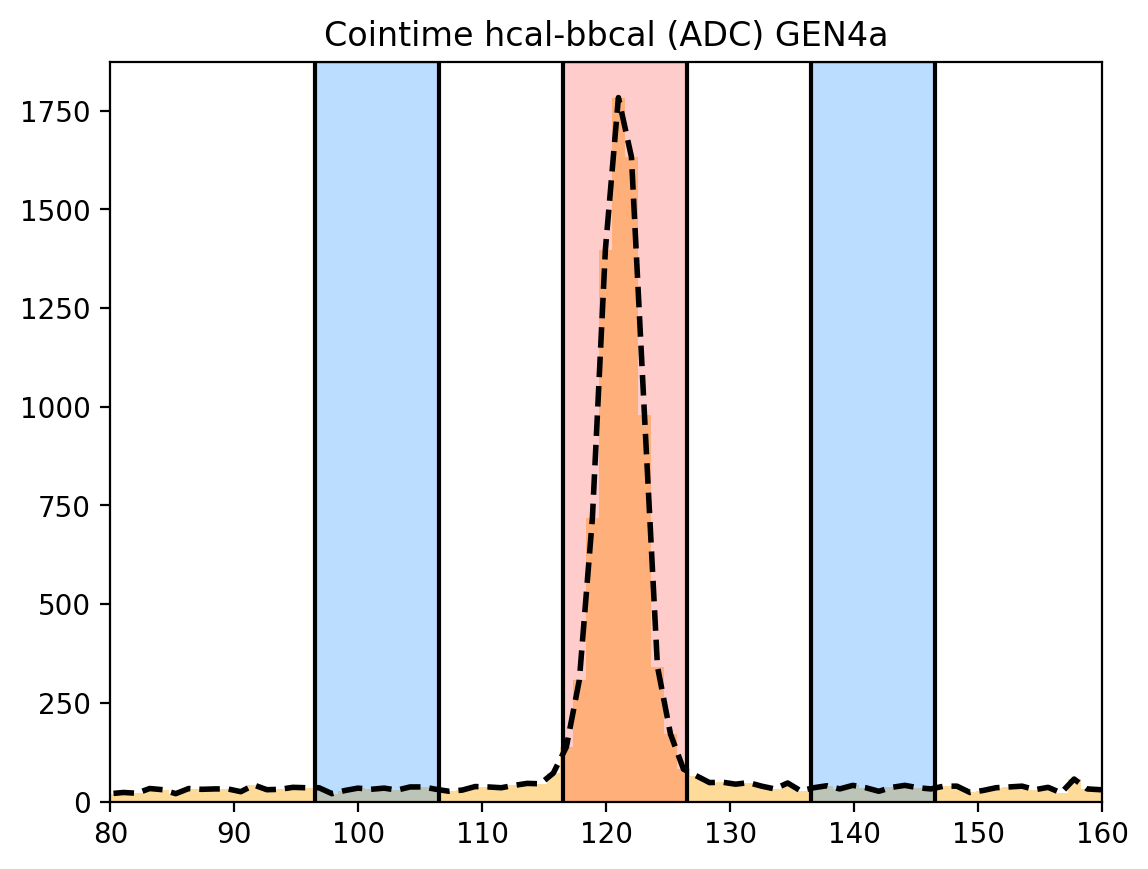

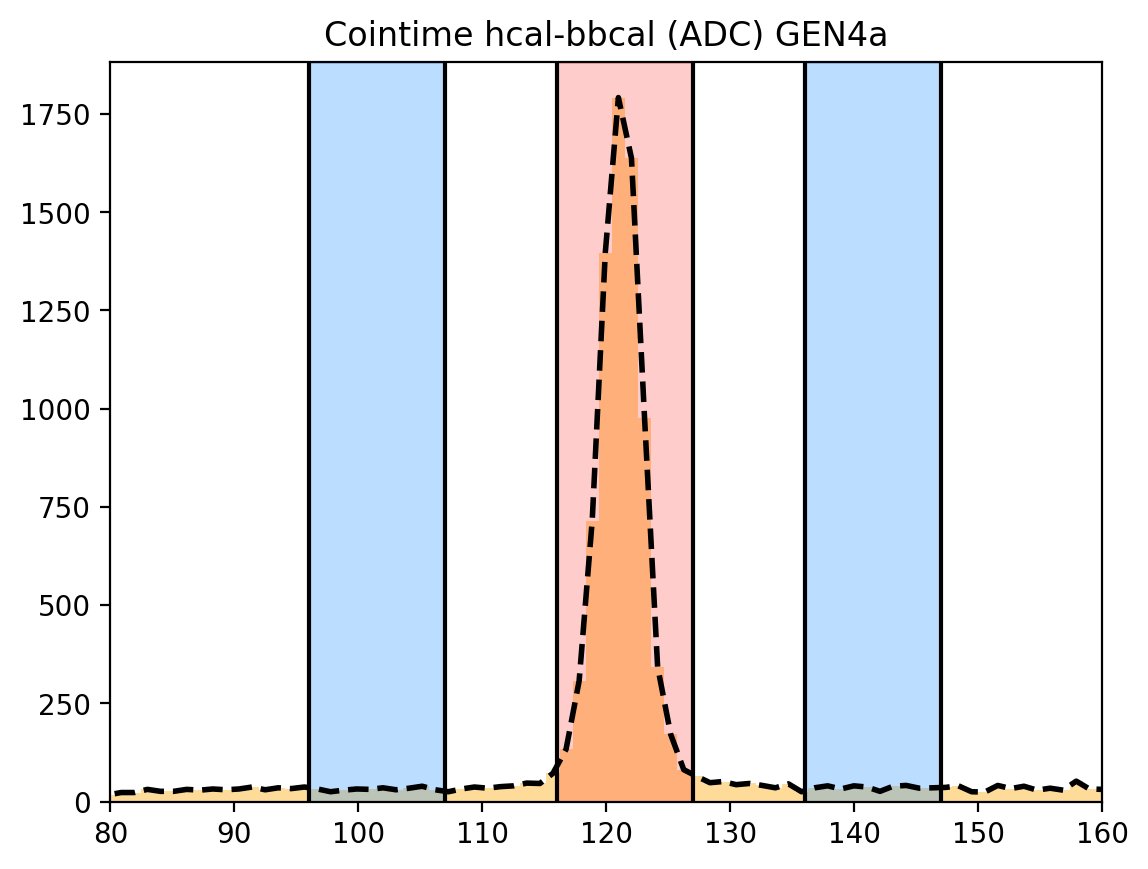

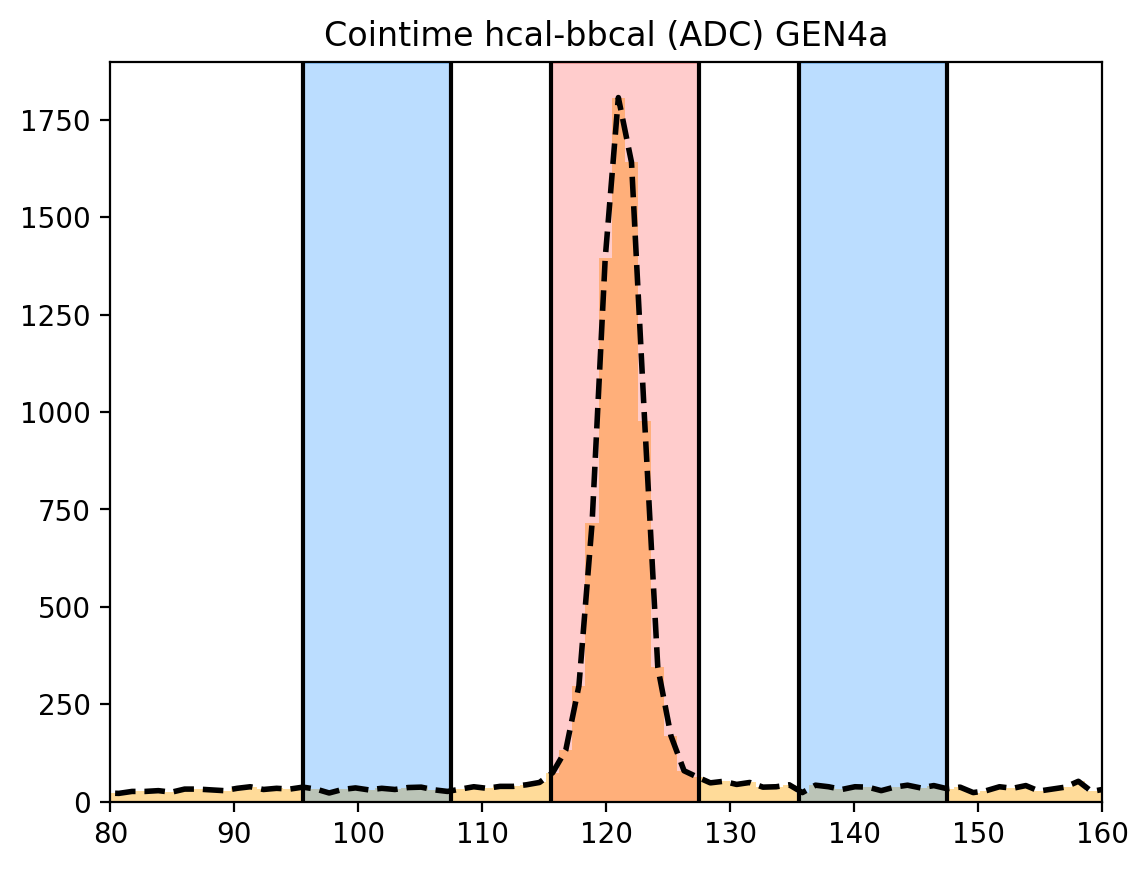

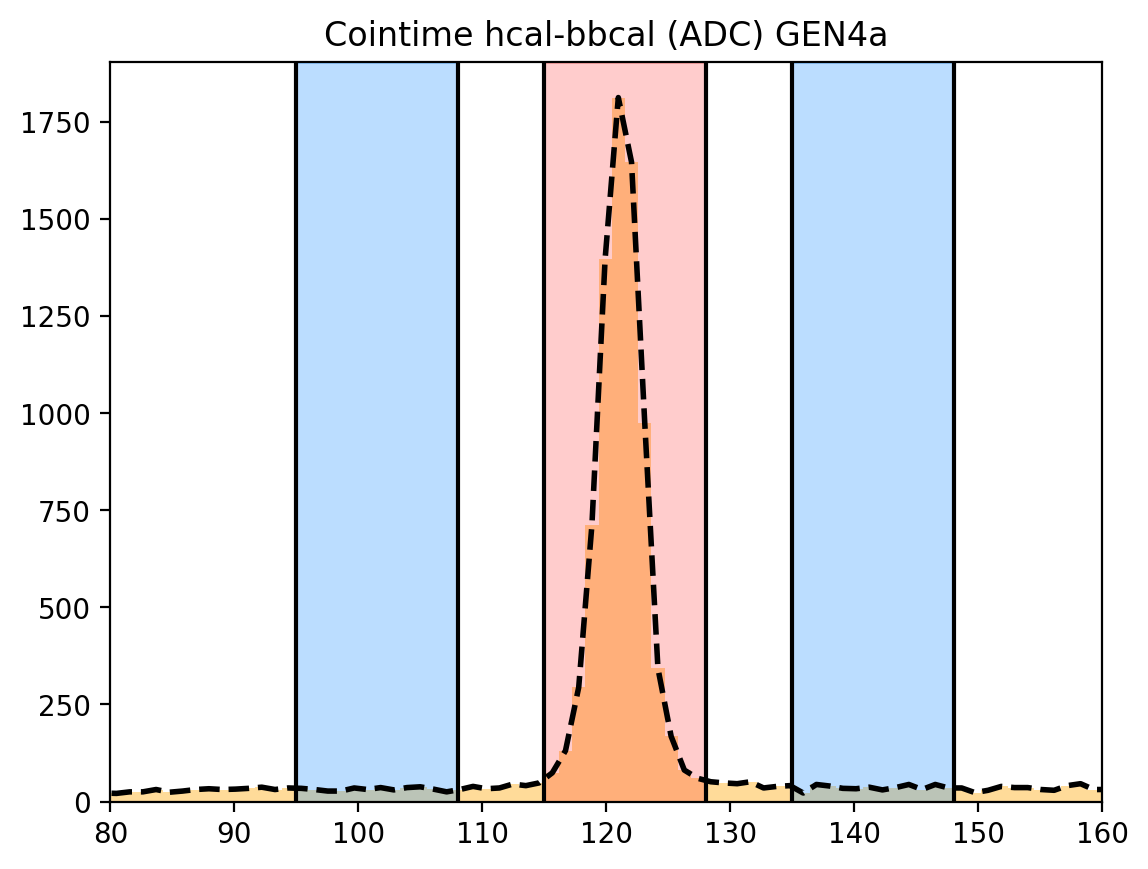

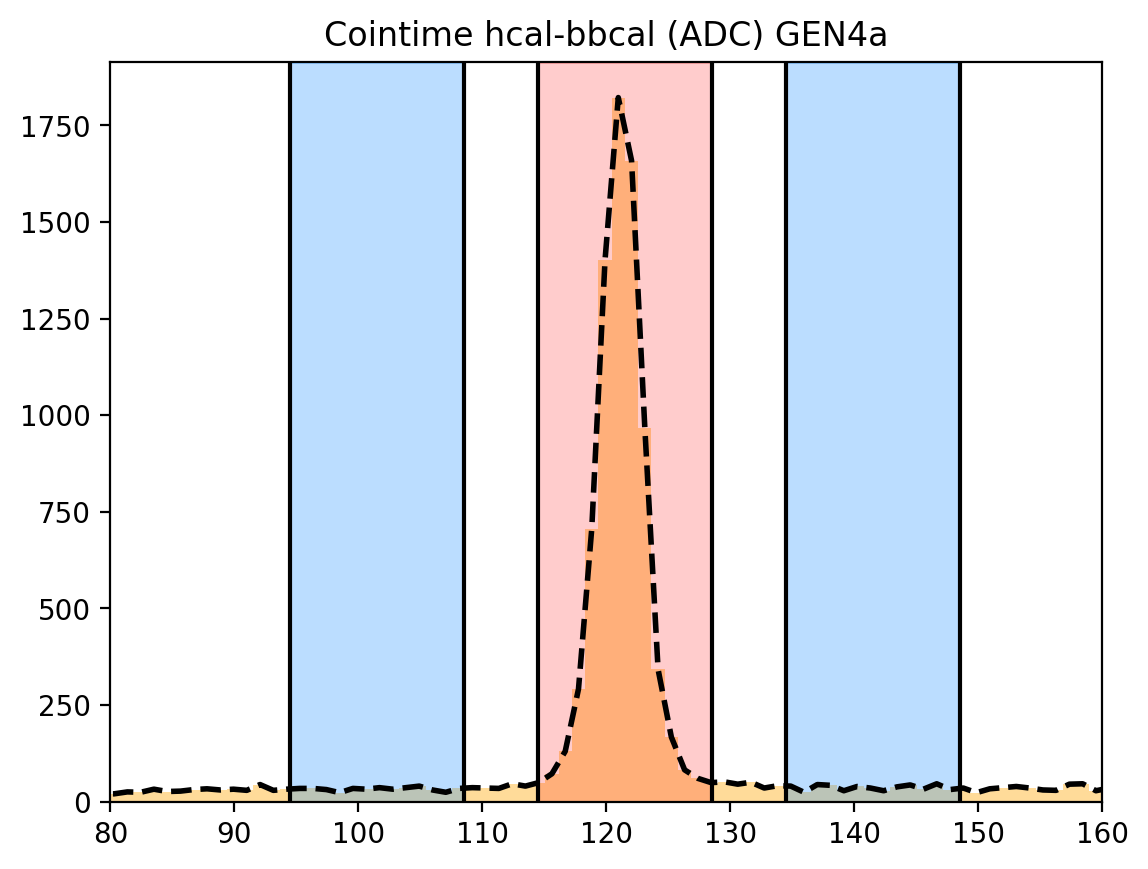

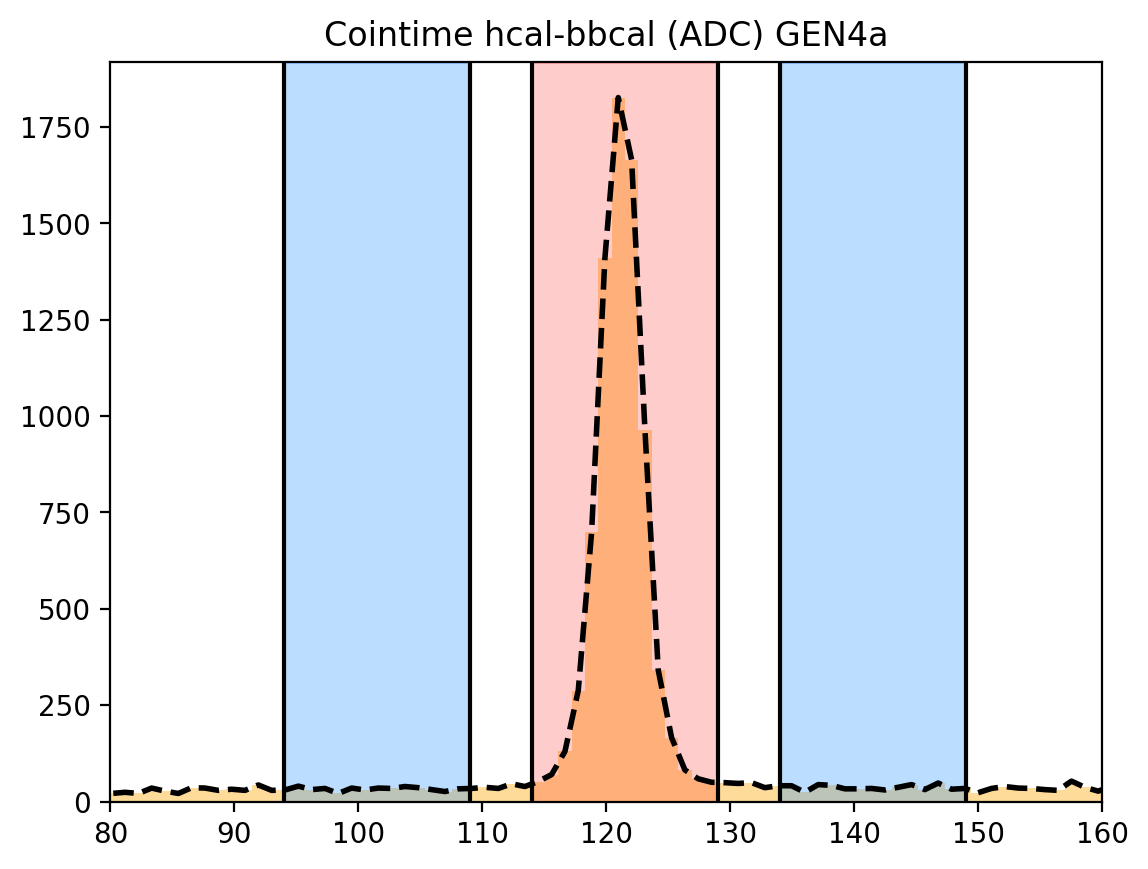

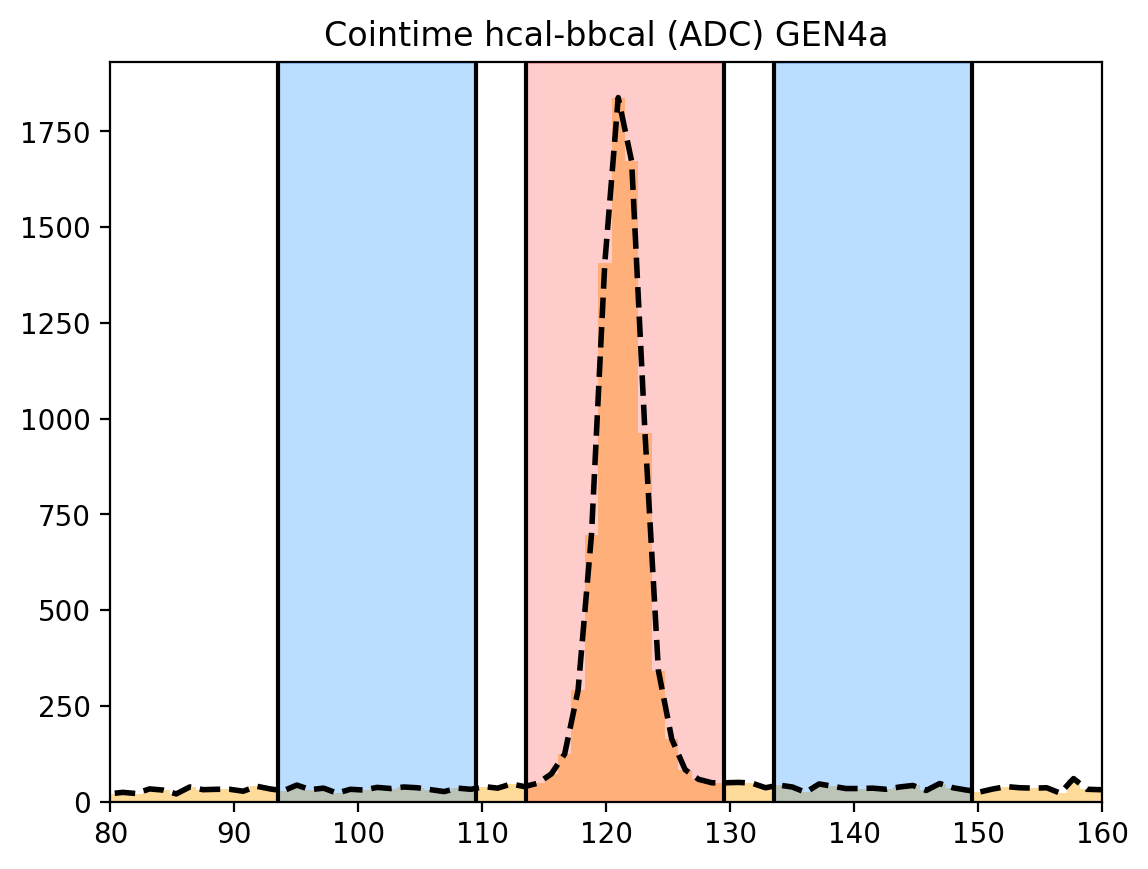

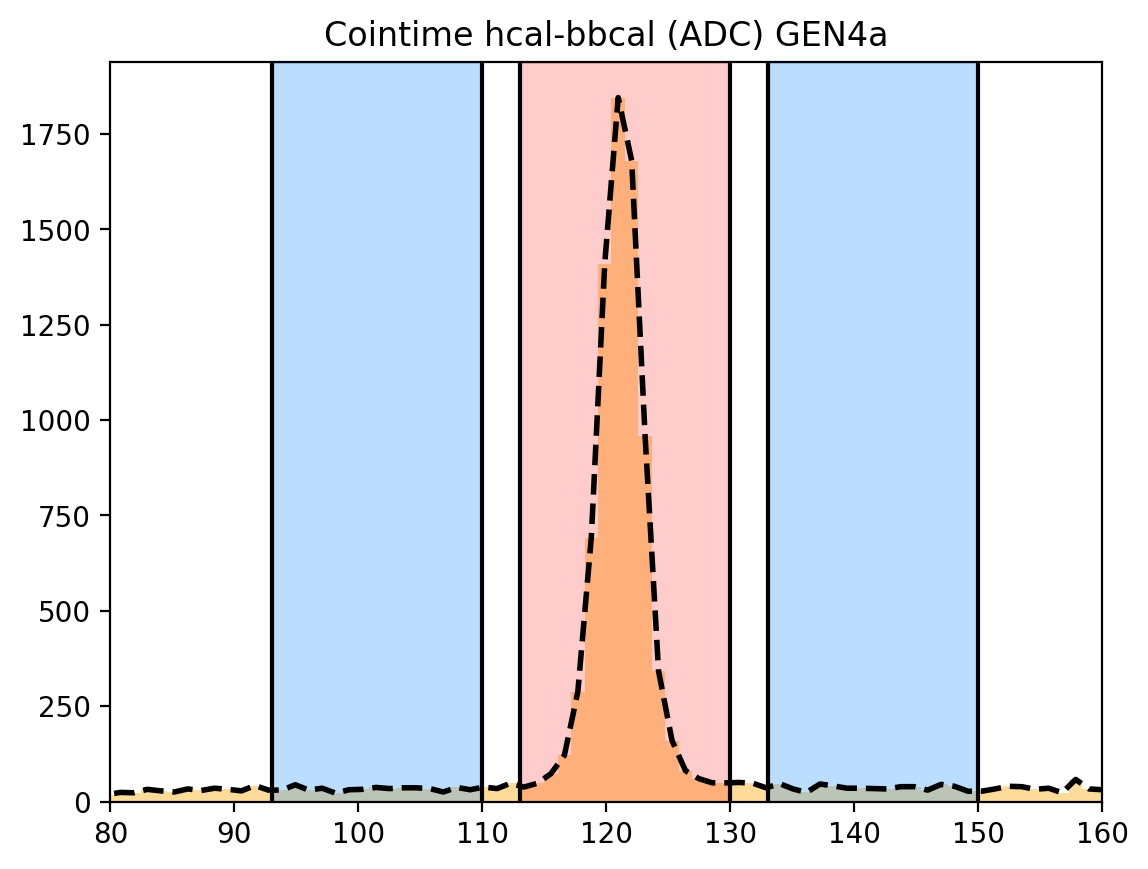

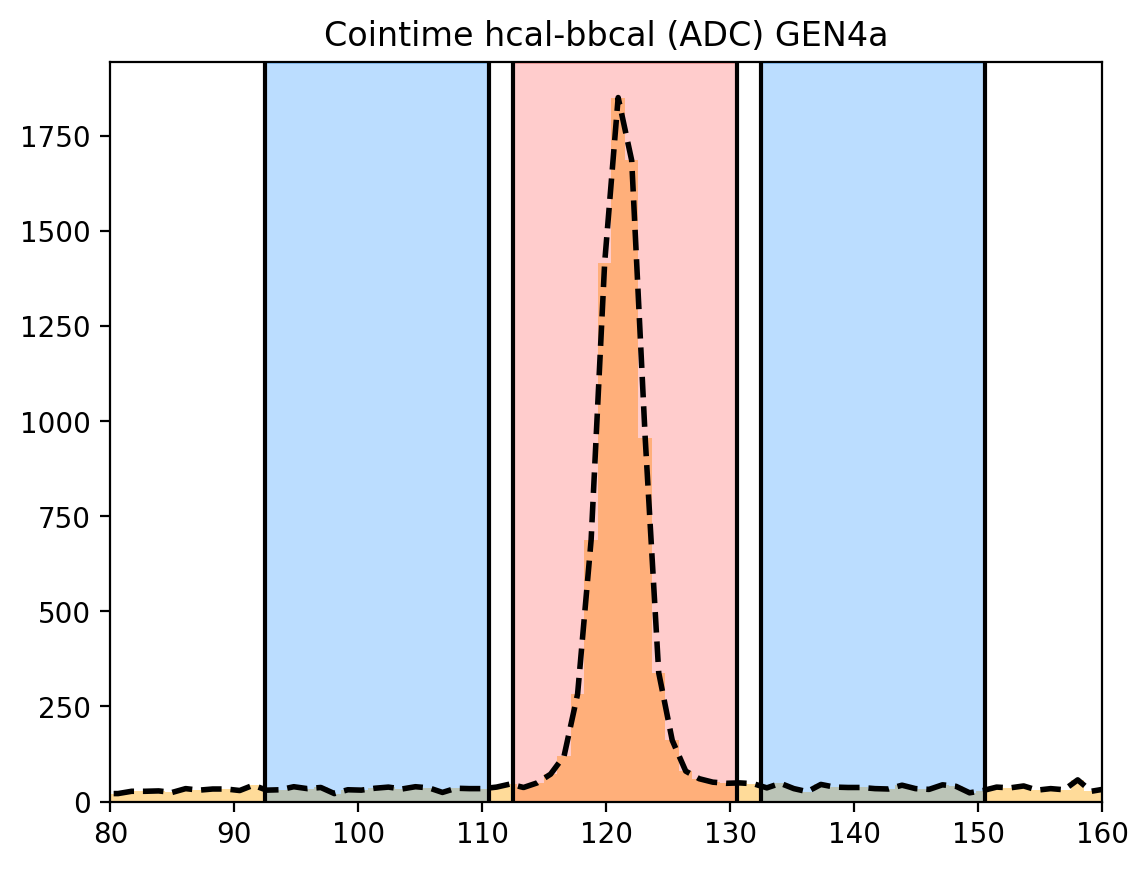

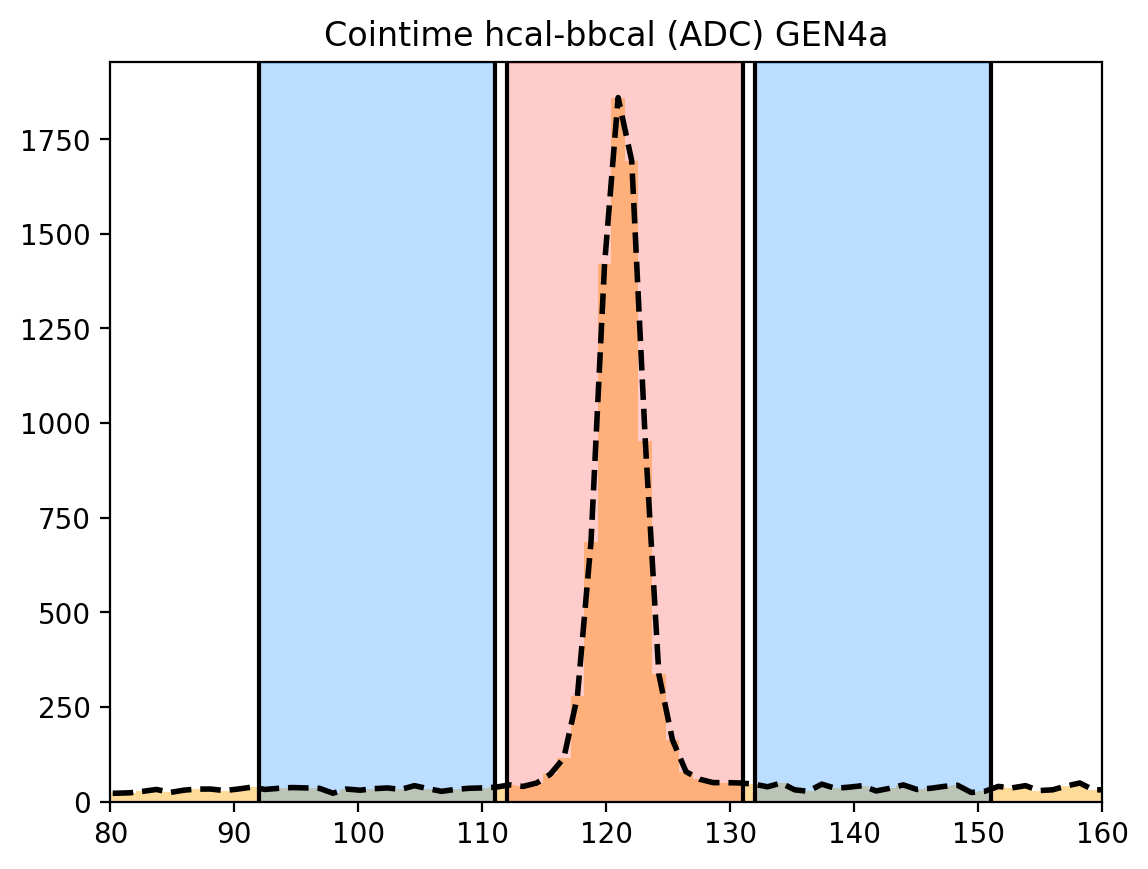

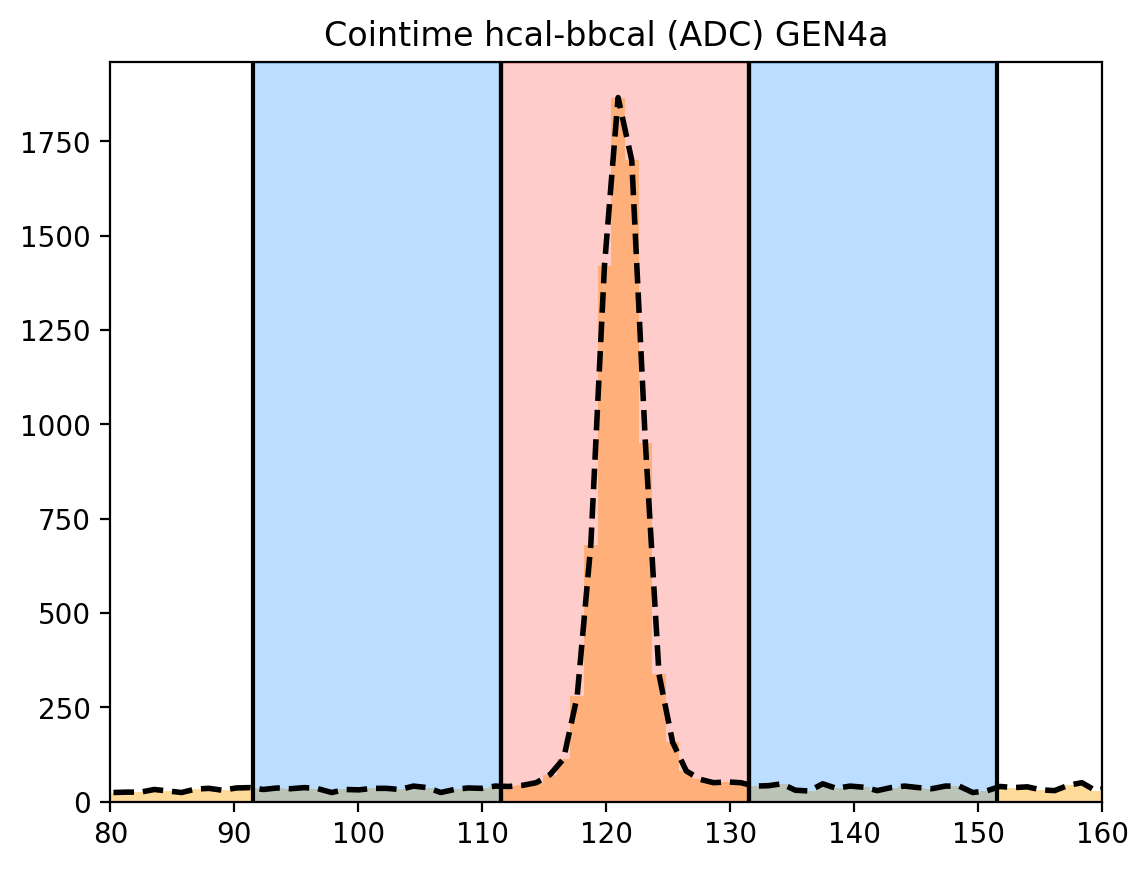

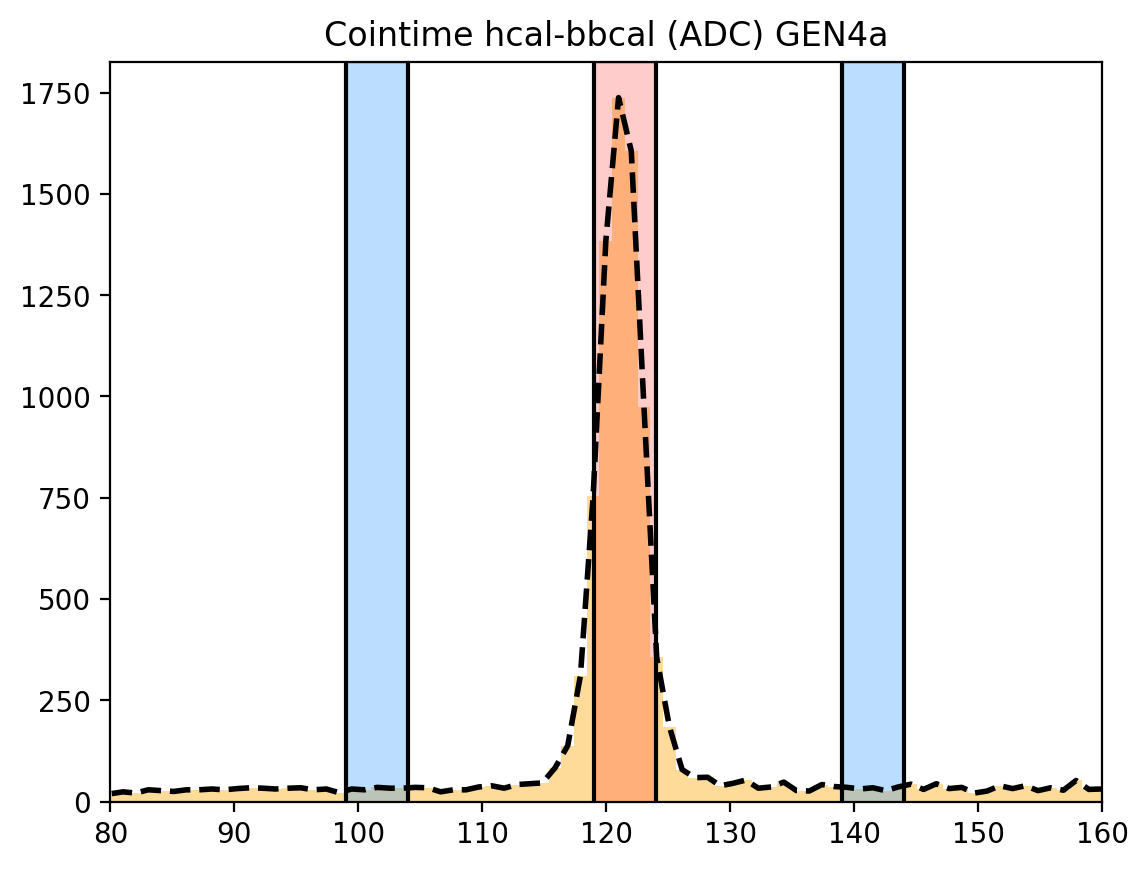

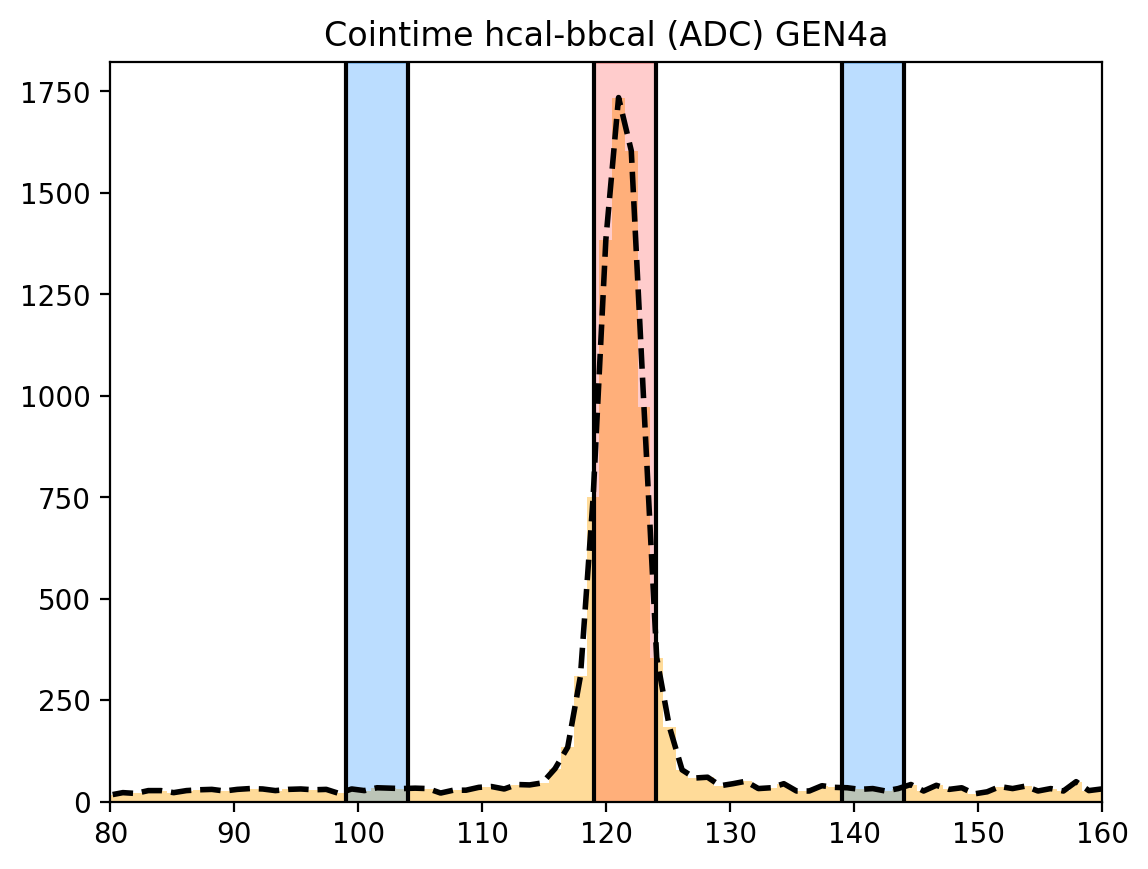

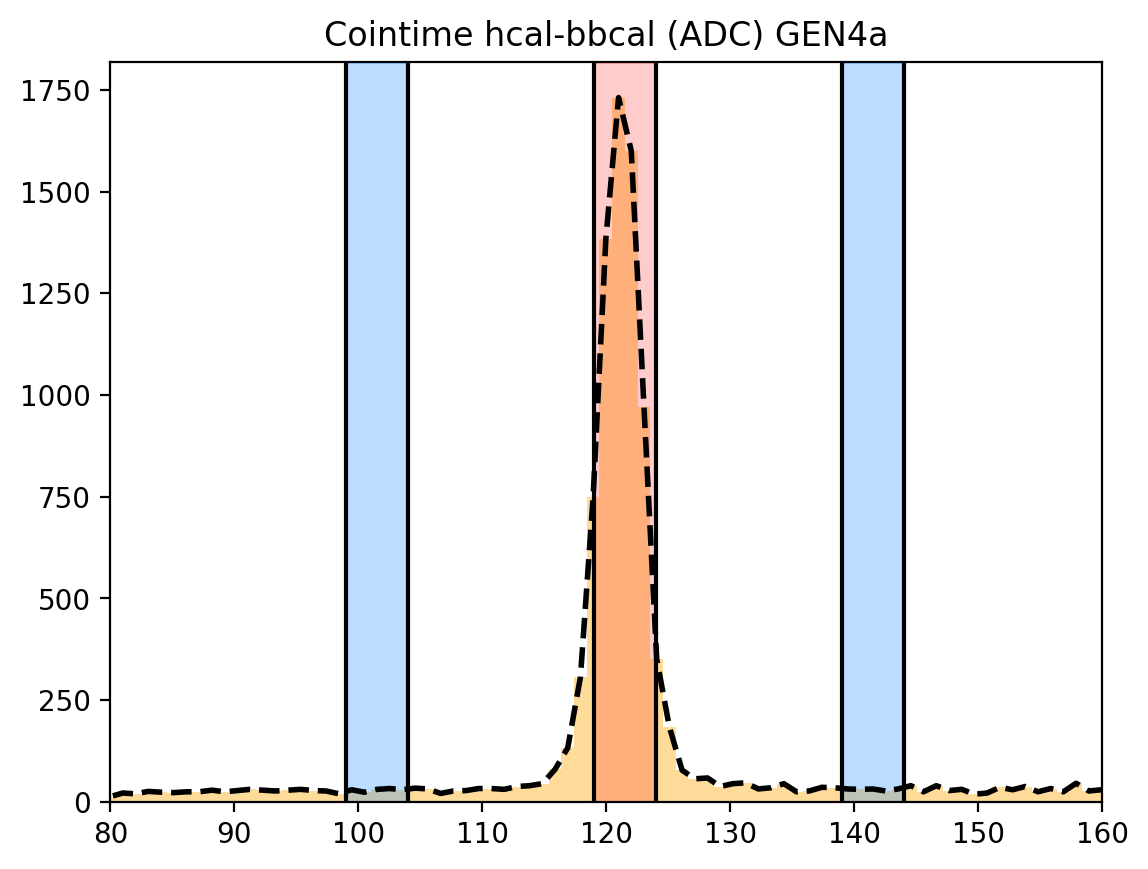

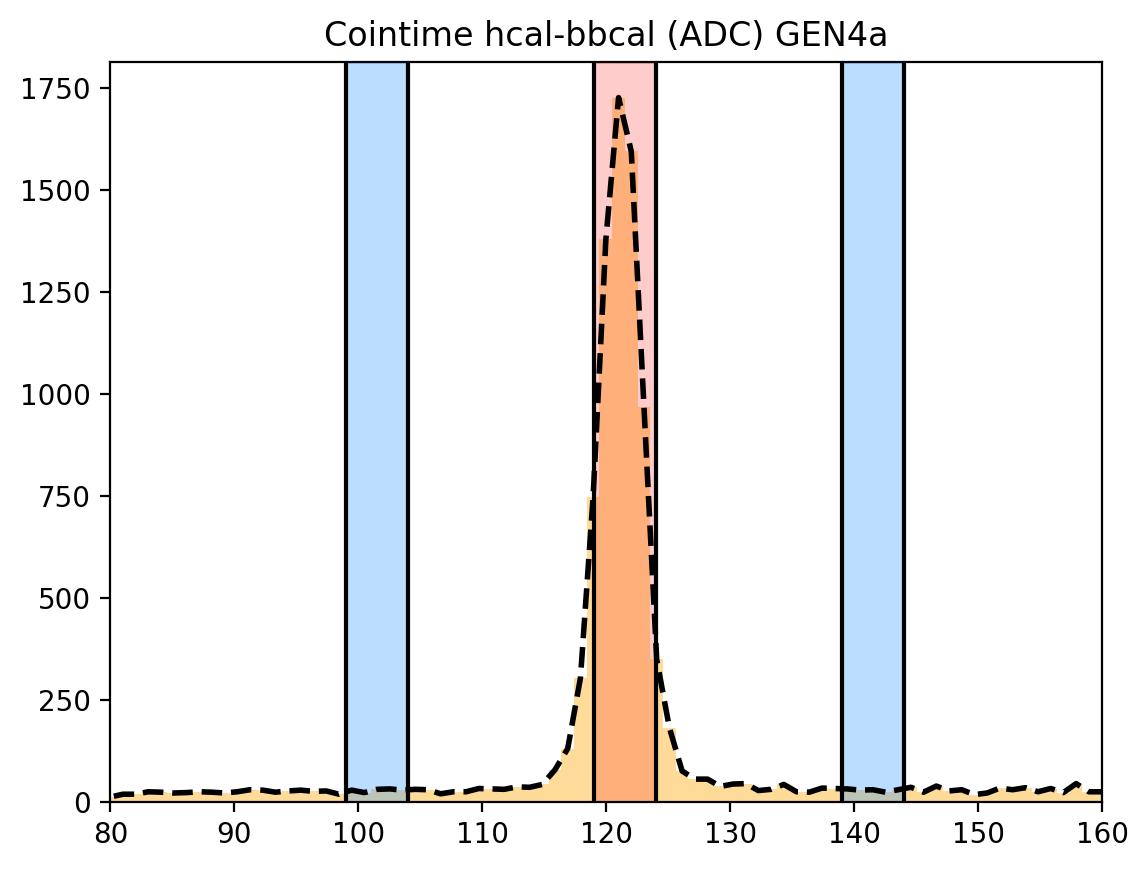

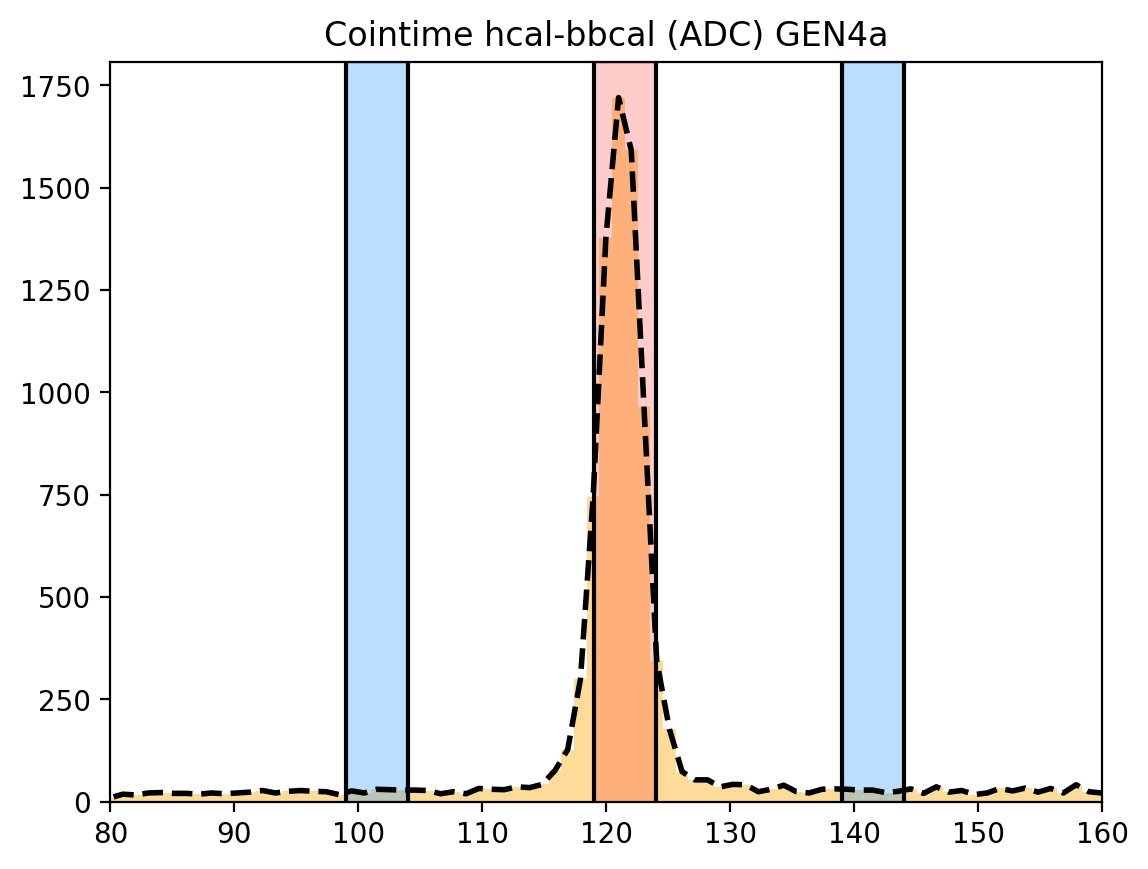

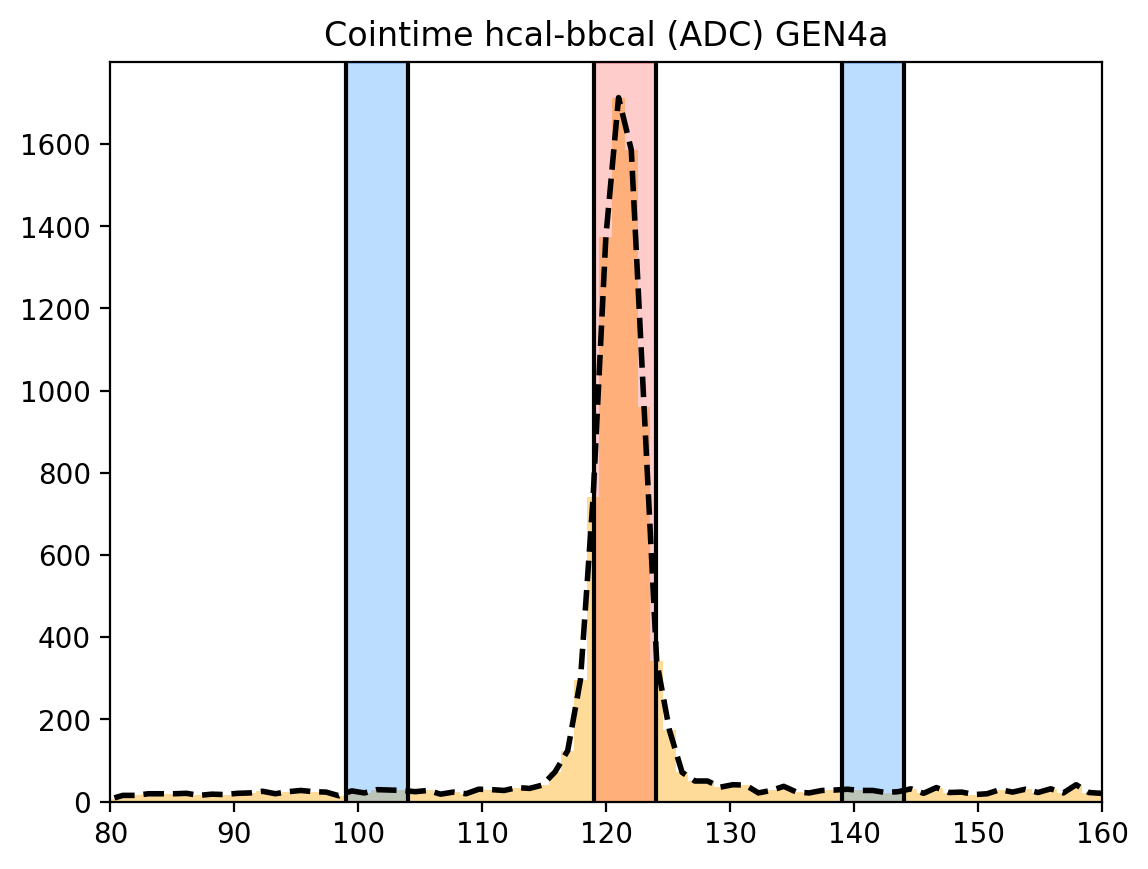

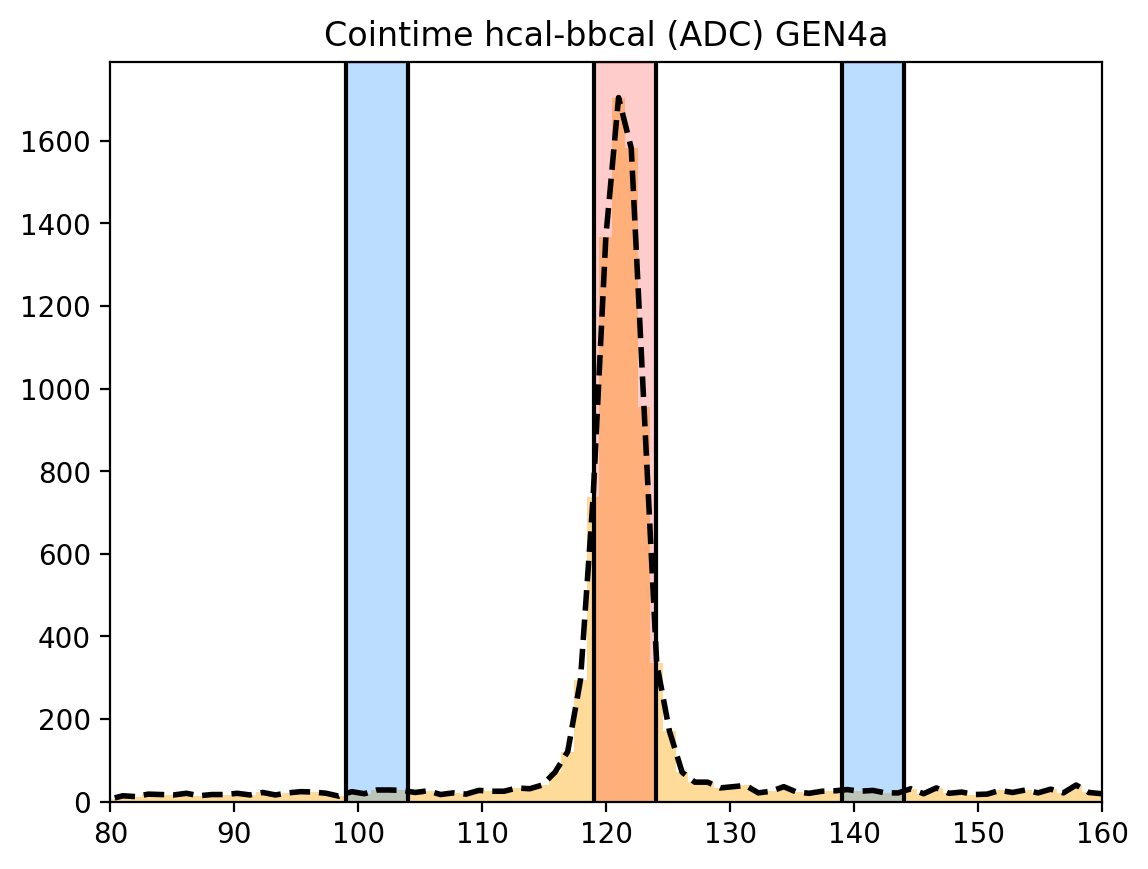

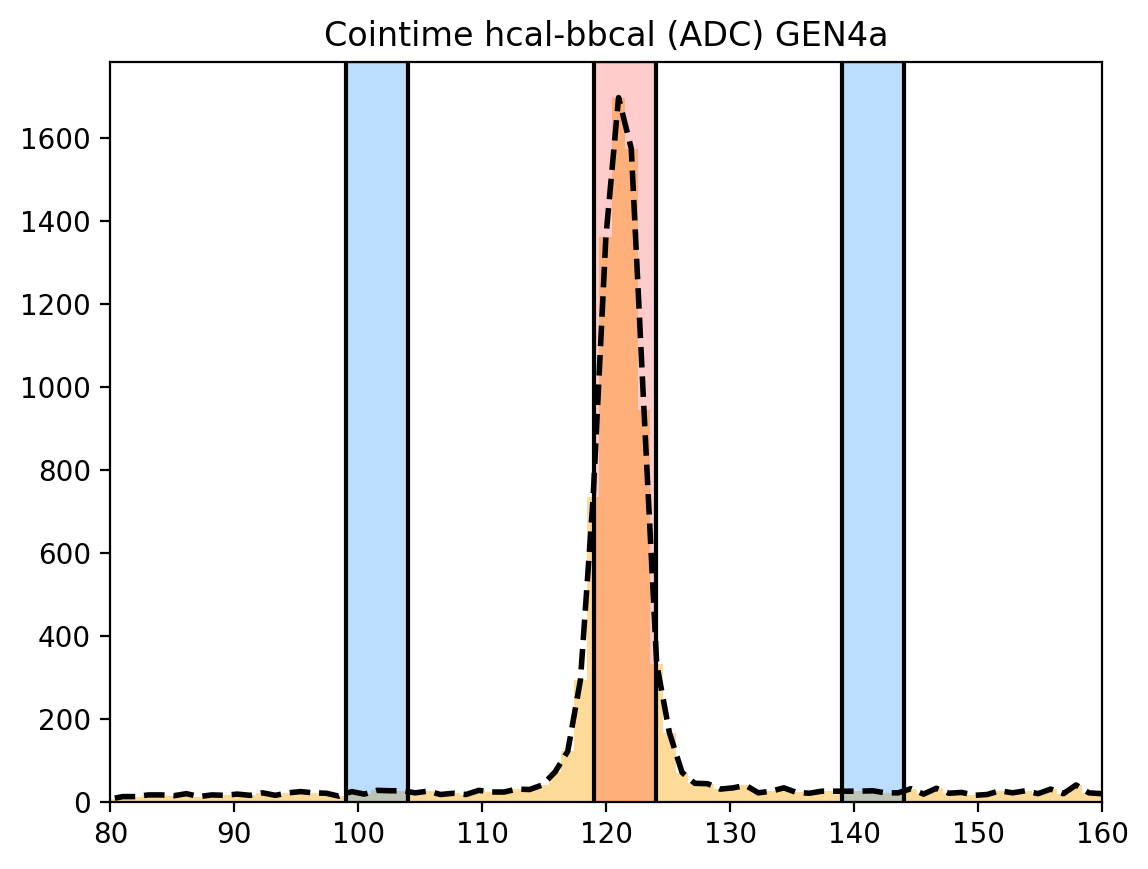

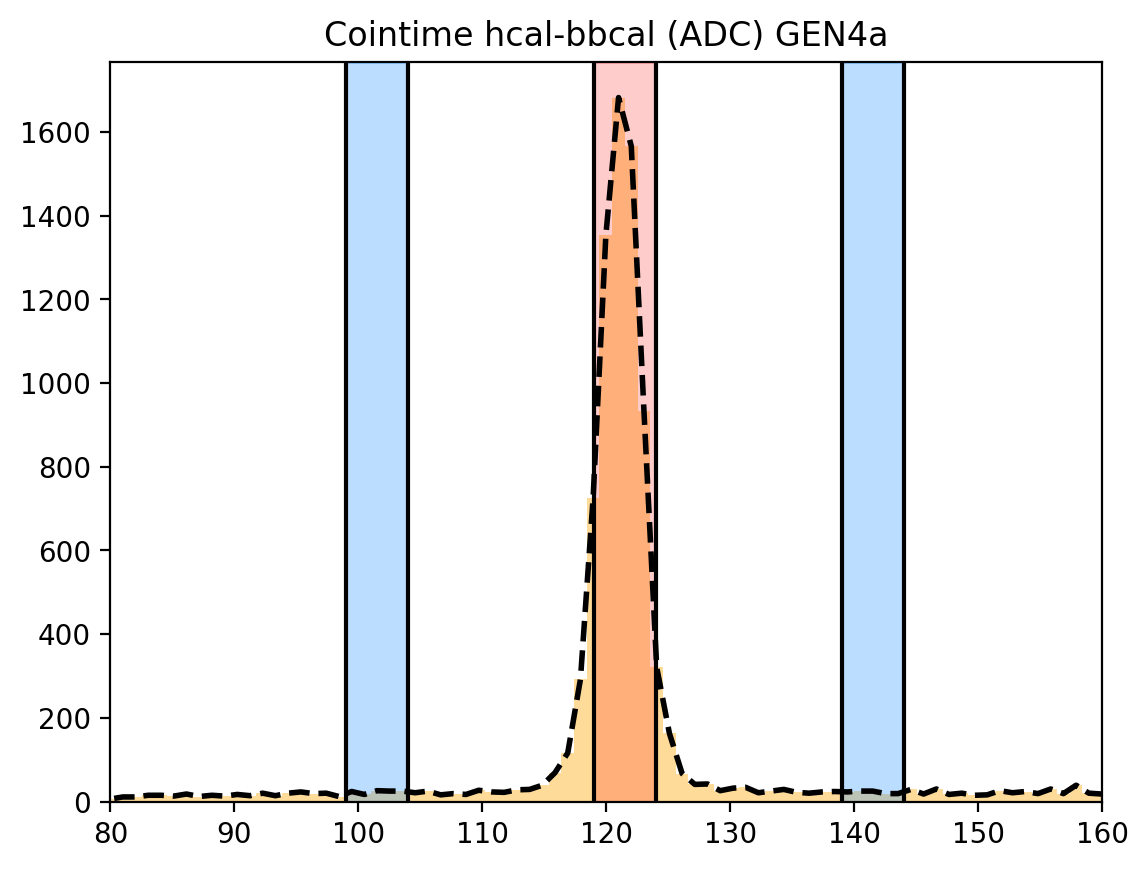

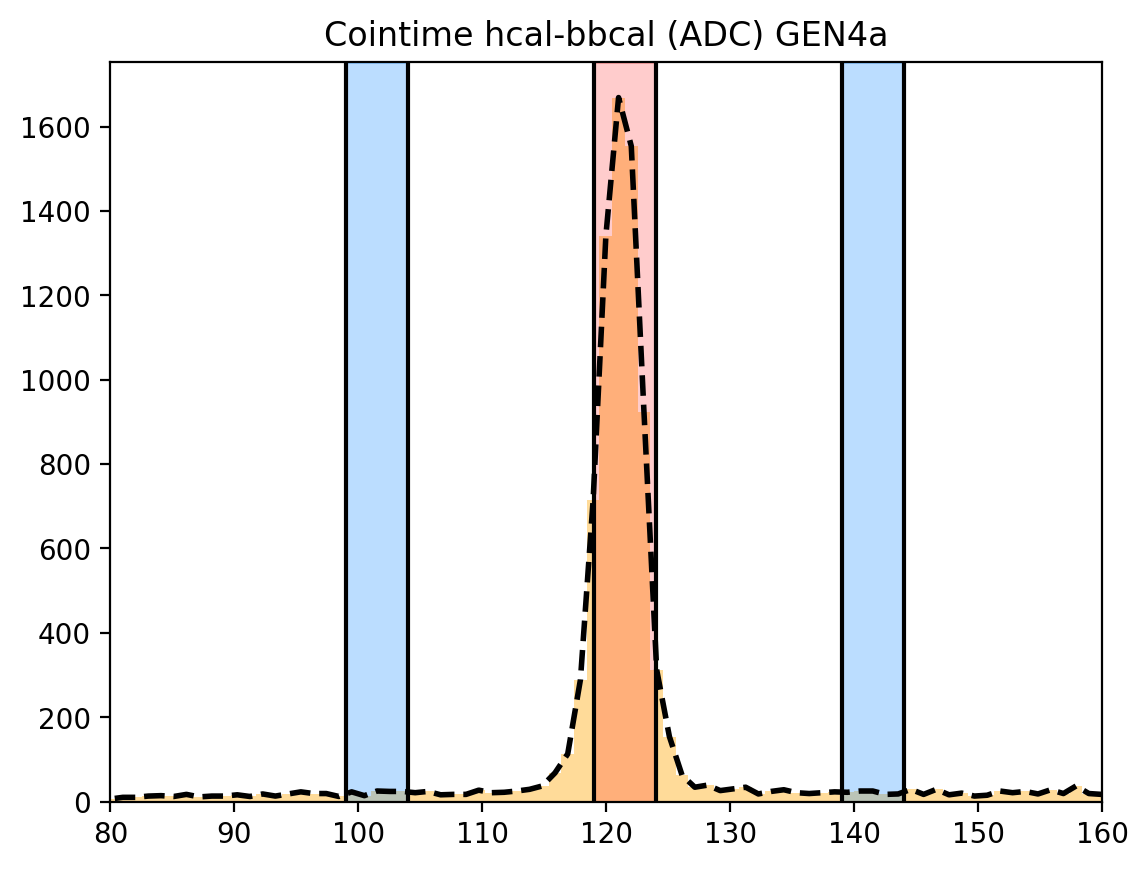

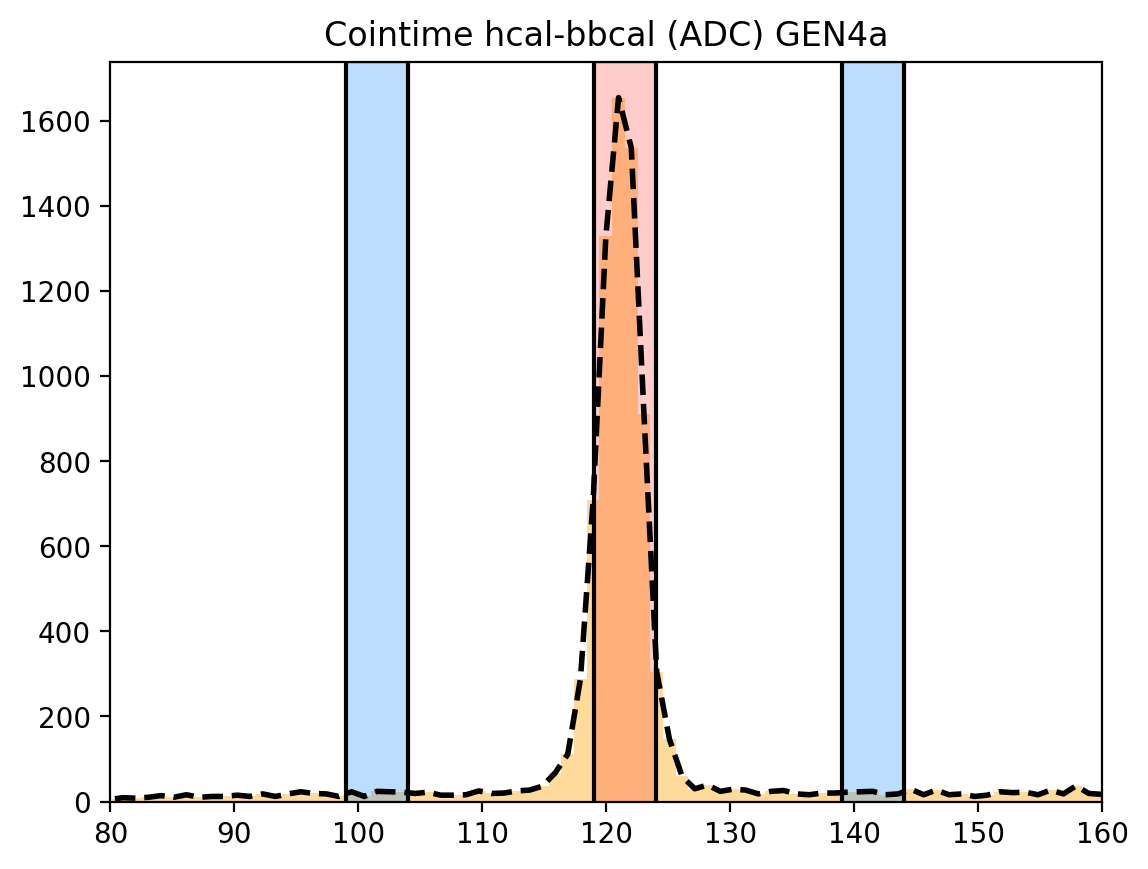

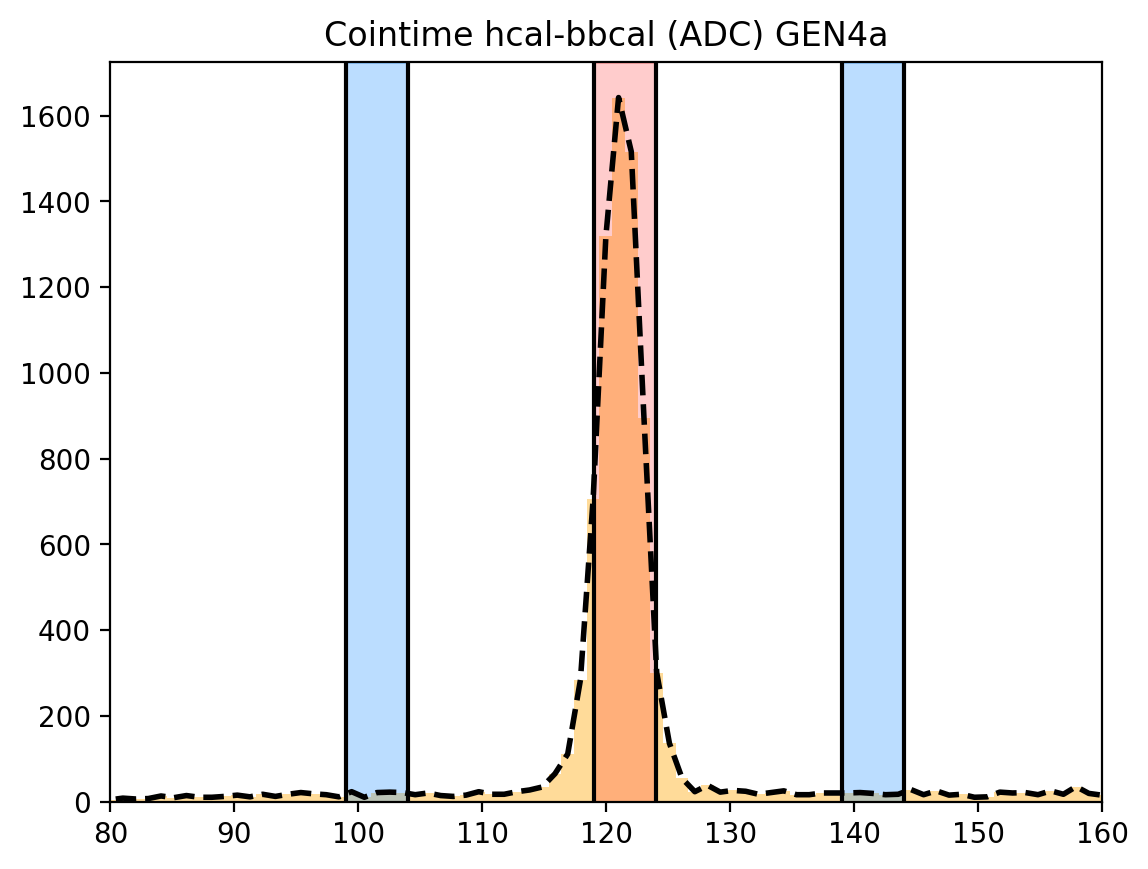

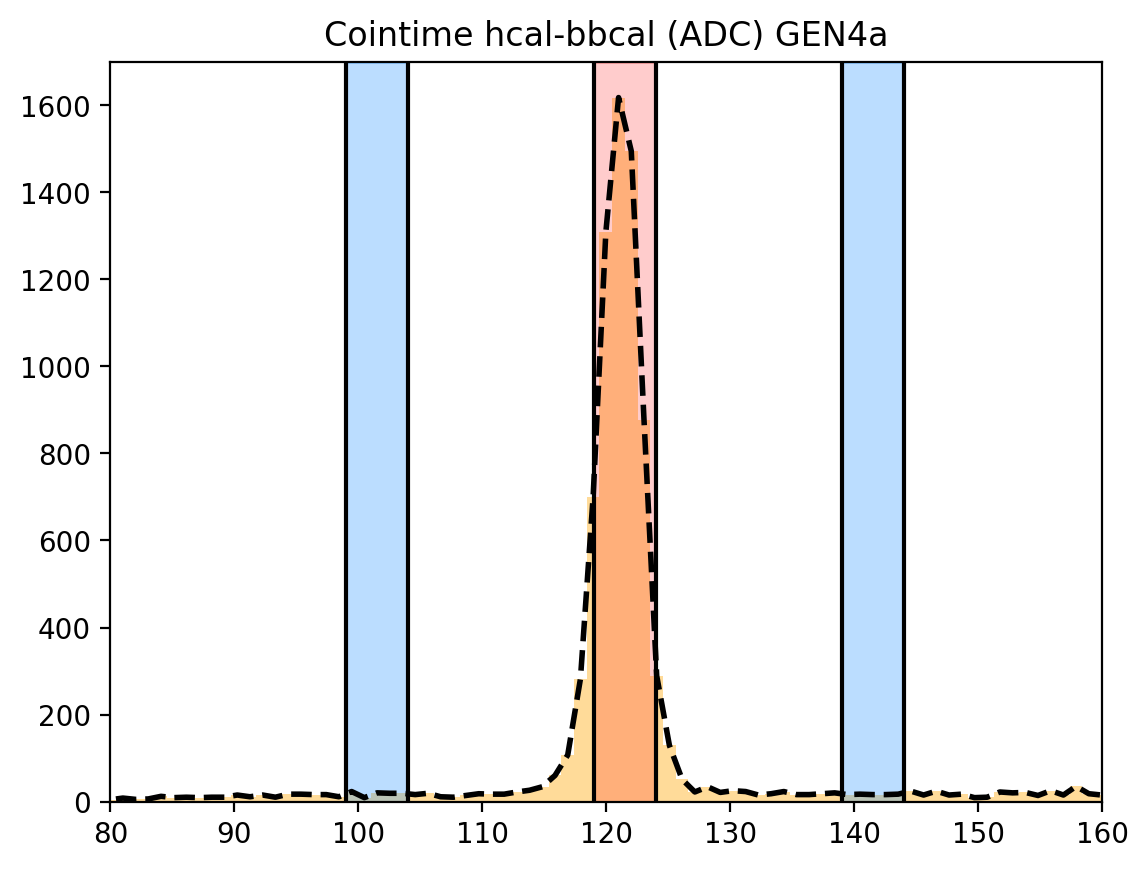

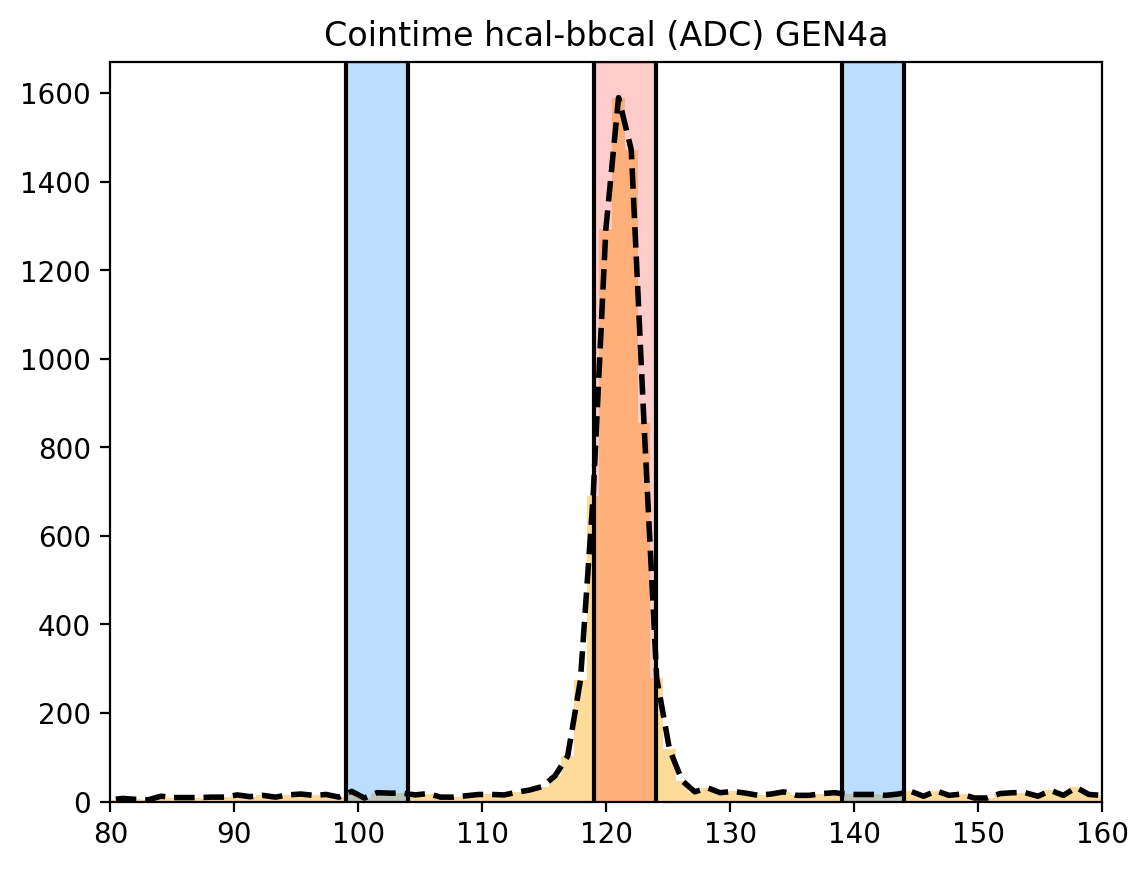

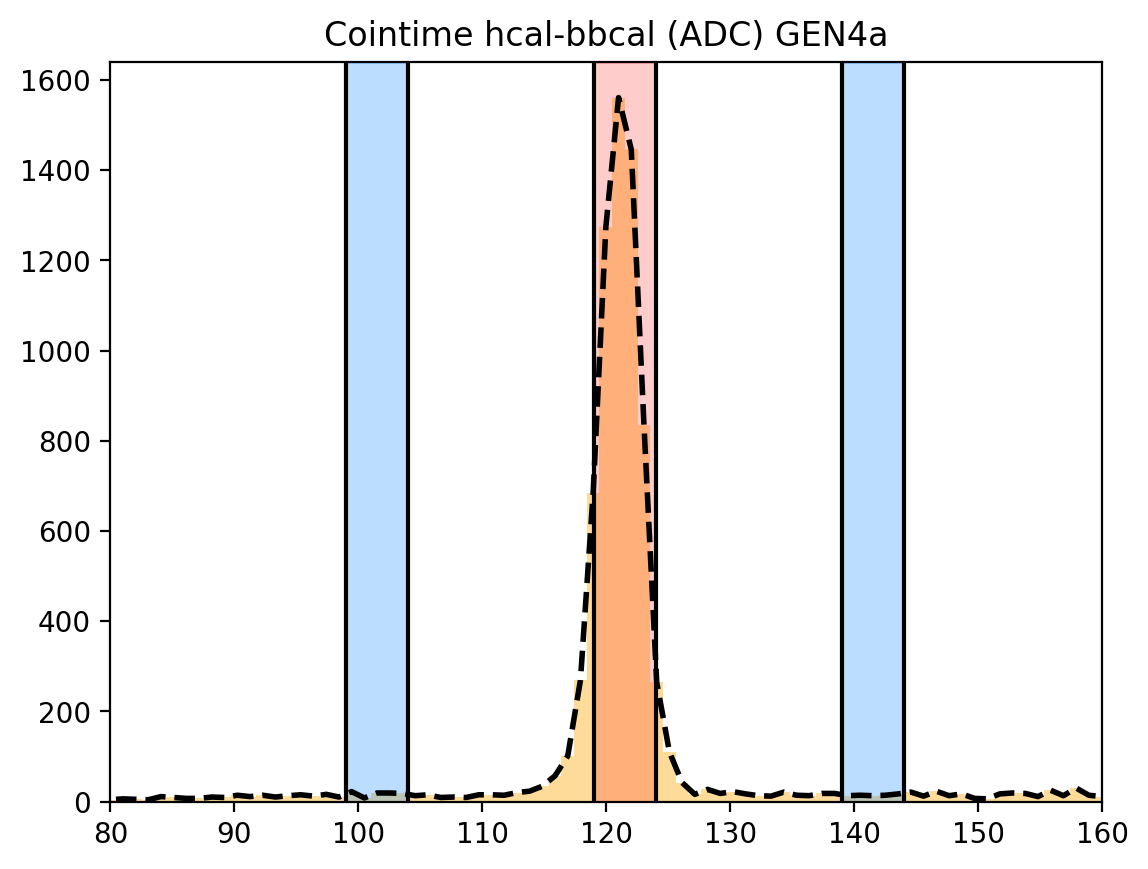

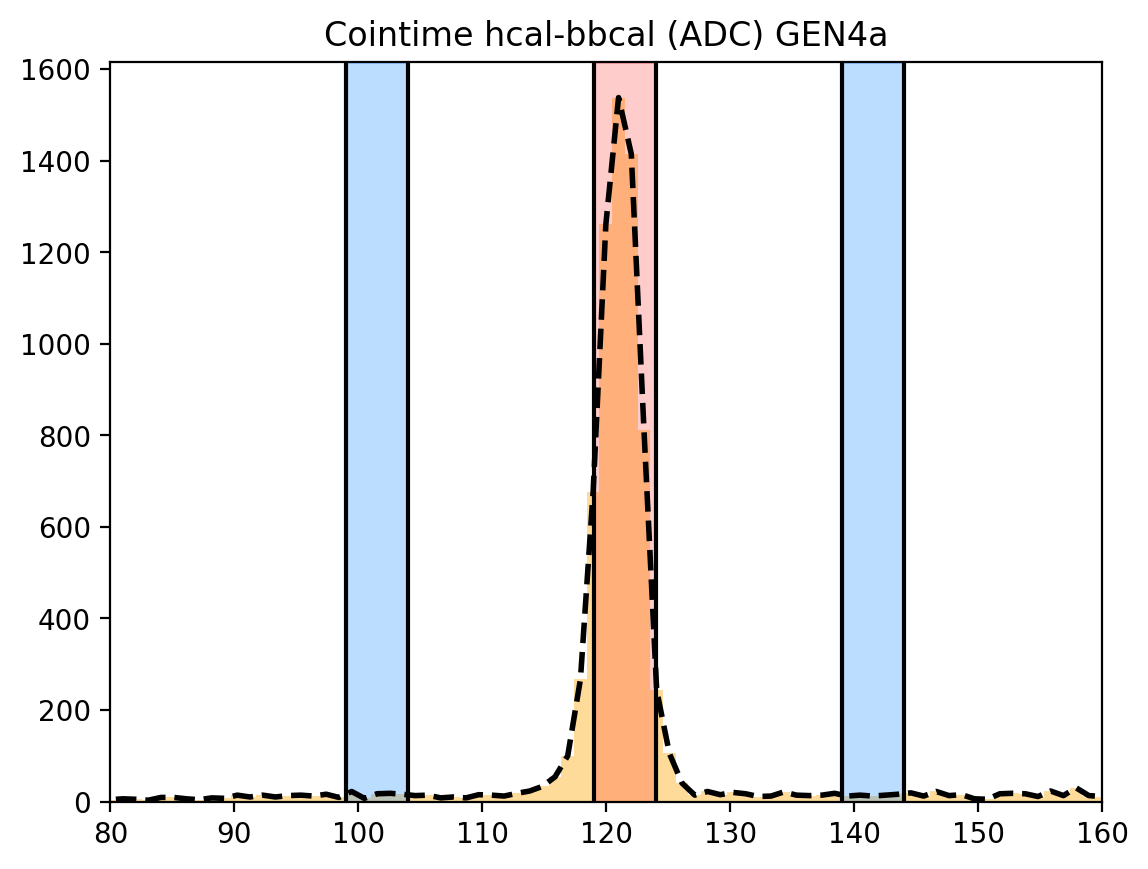

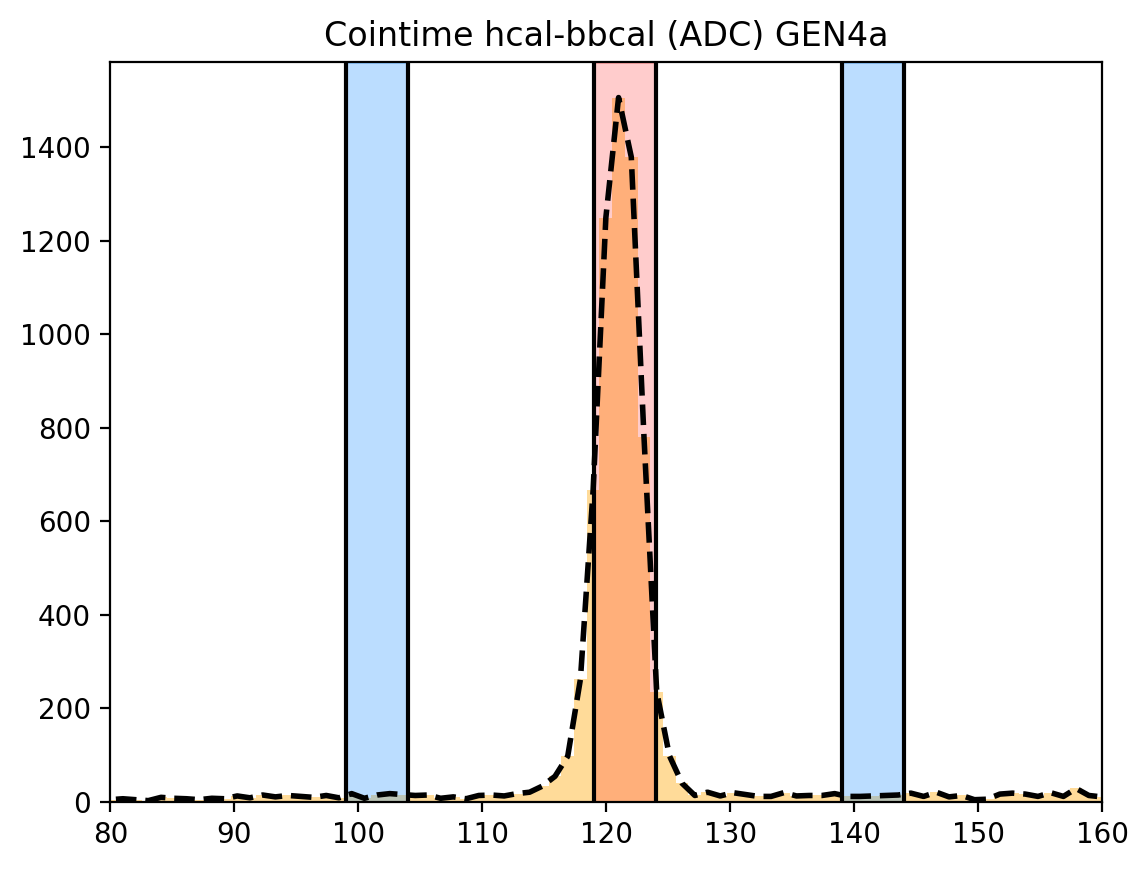

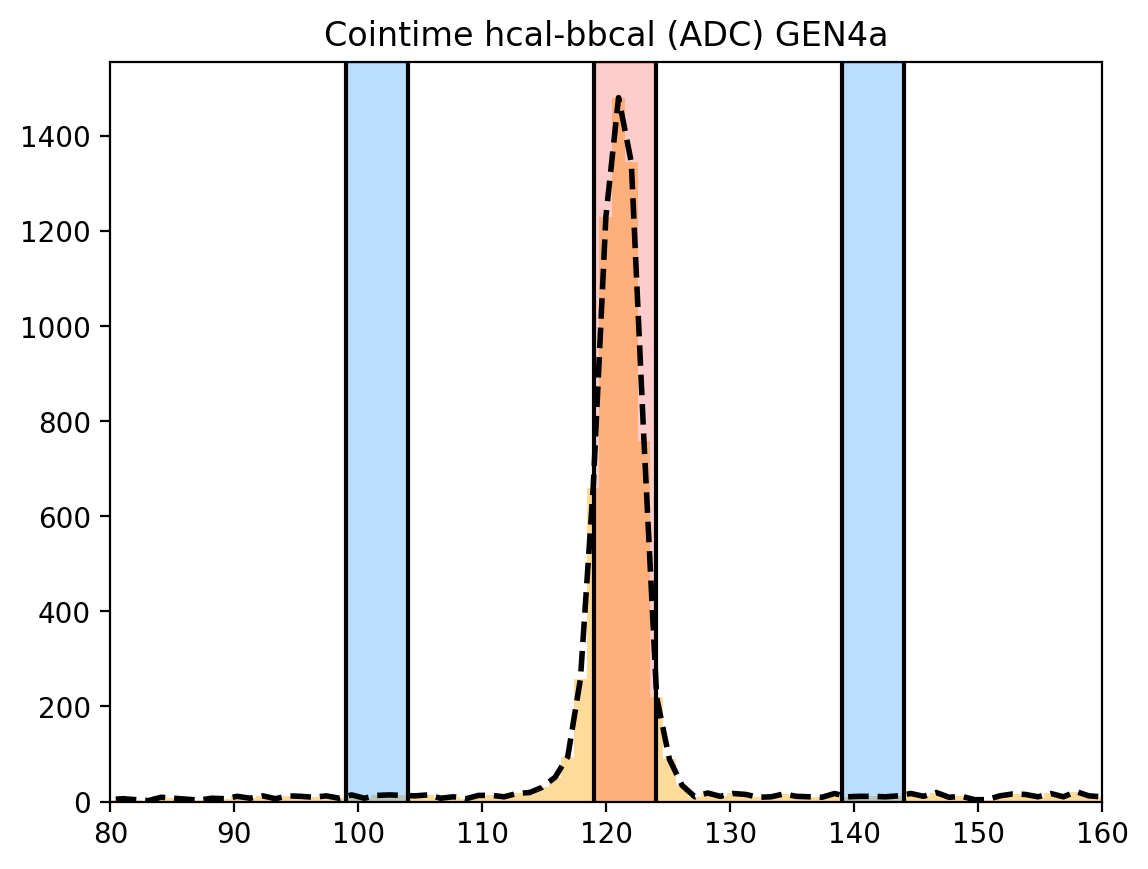

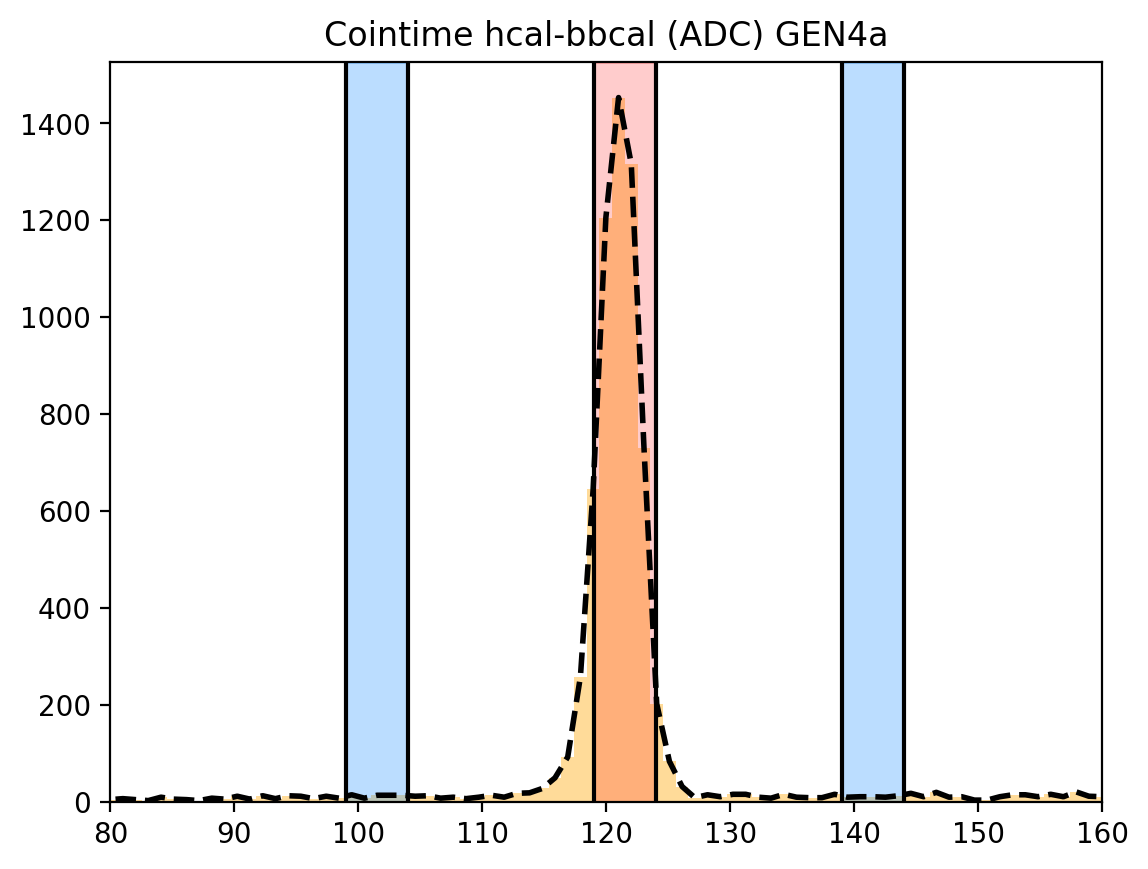

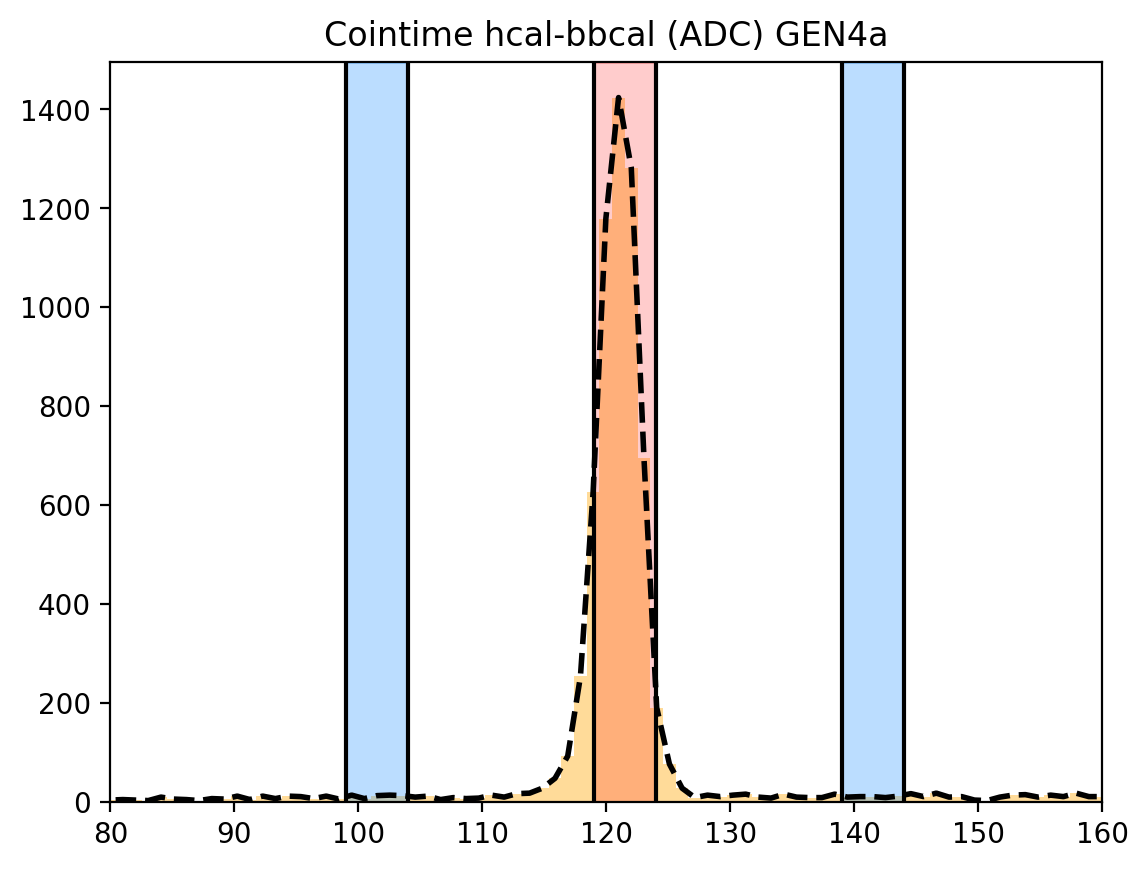

In [47]:
gen=[]
gensys=[]
genstat=[]
araw=[]
arawerror=[]
aphysstaterror=[]
aphyssyserror=[]
cutindex=[]



stepsize=20
print("Starting W2")
for i in range(0,stepsize):
    #print(i)
    try: _,_,stats1,_=DoItAll(.87-i/wscale*2,.88+i/wscale,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin,False,False)
    except:
        continue
    cutindex.append(i)
    A=stats1['GE/GM * muN']
    B=stats1['GE/GM_stat_error']
    C=stats1['GE/GM_sys_error']
    D=stats1['A_raw']
    E=stats1['A_raw_rel_error']
    F=stats1["A_phys_rel_sys_error"]
    G=stats1["A_phys_rel_sat_error"]
    gen.append(A)
    gensys.append(C)
    genstat.append(B)
    araw.append(D)
    arawerror.append(E)
    aphysstaterror.append(G)
    aphyssyserror.append(F)
print("Starting dx")
for i in range(0,stepsize):
    #print(i)
    try: _,_,stats2,_=DoItAll(.87-12/wscale*2,.88+12/wscale,coinmin,coinmax,dymin,dymax,-.1-i/dxscale,.1+i/dxscale,hcalmin,False,False)
    except:
        continue
    cutindex.append(stepsize+i)
    A=stats2['GE/GM * muN']
    B=stats2['GE/GM_stat_error']
    C=stats2['GE/GM_sys_error']
    D=stats2['A_raw']
    E=stats2['A_raw_rel_error']
    F=stats2["A_phys_rel_sys_error"]
    G=stats2["A_phys_rel_sat_error"]
    gen.append(A)
    gensys.append(C)
    genstat.append(B)
    araw.append(D)
    arawerror.append(E)
    aphysstaterror.append(G)
    aphyssyserror.append(F)
print("Starting dy")
for i in range(0,stepsize):
    #print(i)
    try: _,_,stats3,_=DoItAll(.87-12/wscale*2,.88+12/wscale,coinmin,coinmax,-.1-i/dyscale,.1+i/dyscale,-.1-8/dxscale,.1+8/dxscale,hcalmin,False,False)
    except:
        continue
    cutindex.append(2*stepsize+i)
    A=stats3['GE/GM * muN']
    B=stats3['GE/GM_stat_error']
    C=stats3['GE/GM_sys_error']
    D=stats3['A_raw']
    E=stats3['A_raw_rel_error']
    F=stats3["A_phys_rel_sys_error"]
    G=stats3["A_phys_rel_sat_error"]
    gen.append(A)
    gensys.append(C)
    genstat.append(B)
    araw.append(D)
    arawerror.append(E)
    aphysstaterror.append(G)
    aphyssyserror.append(F)
print("starting coin")
for i in range(0,stepsize):
    #print(i)
    try: _,_,stats4,_=DoItAll(.87-12/wscale*2,.88+12/wscale,coinmin+4-i/2,coinmax-4+i/2,-.1-6/dyscale,.1+6/dyscale,-.1-8/dxscale,.1+8/dxscale,hcalmin,False,False)
    except:
        continue
    cutindex.append(3*stepsize+i)
    A=stats4['GE/GM * muN']
    B=stats4['GE/GM_stat_error']
    C=stats4['GE/GM_sys_error']
    D=stats4['A_raw']
    E=stats4['A_raw_rel_error']
    F=stats4["A_phys_rel_sys_error"]
    G=stats4["A_phys_rel_sat_error"]
    gen.append(A)
    gensys.append(C)
    genstat.append(B)
    araw.append(D)
    arawerror.append(E)
    aphysstaterror.append(G)
    aphyssyserror.append(F)
print("starting hcale")
for i in range(0,stepsize):
    #print(i)
    try: _,_,stats4,_=DoItAll(.87-12/wscale*2,.88+12/wscale,coinmin+2,coinmax-2,-.1-6/dyscale,.1+6/dyscale,-.1-8/dxscale,.1+8/dxscale,hcalmin+i/hcalscale,False,False)
    except:
        continue
    cutindex.append(4*stepsize+i)
    A=stats4['GE/GM * muN']
    B=stats4['GE/GM_stat_error']
    C=stats4['GE/GM_sys_error']
    D=stats4['A_raw']
    E=stats4['A_raw_rel_error']
    F=stats4["A_phys_rel_sys_error"]
    G=stats4["A_phys_rel_sat_error"]
    gen.append(A)
    gensys.append(C)
    genstat.append(B)
    araw.append(D)
    arawerror.append(E)
    aphysstaterror.append(G)
    aphyssyserror.append(F)
    
   

In [48]:
gen_error=np.sqrt(np.array(genstat)**2+np.array(gensys)**2)

TypeError: only size-1 arrays can be converted to Python scalars

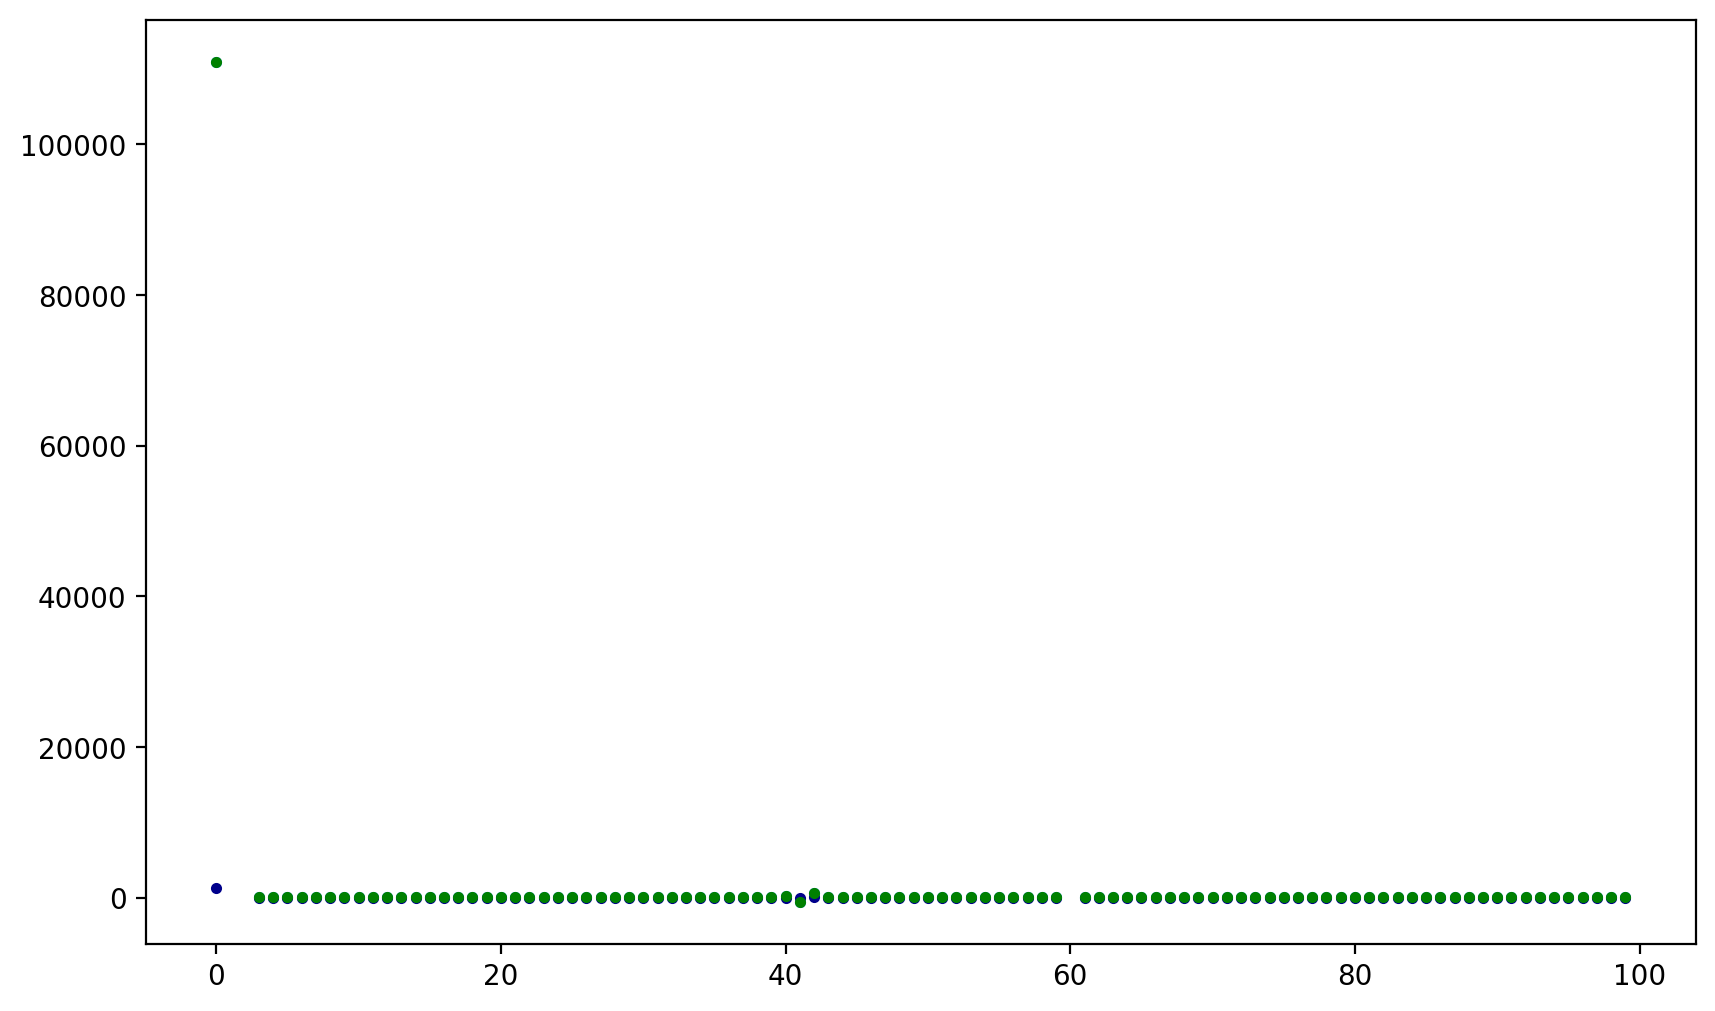

In [49]:
fig, ax1 = plt.subplots(figsize=(10,6), dpi=200)
msize = 15

# Plot aphys errors on the left y-axis
ax1.plot(cutindex, 100*np.array(genstat)/gen, '.', color='dodgerblue', label='Aphys_statE')
ax1.plot(cutindex, 100*np.array(gensys)/gen, '.', color='darkblue', label='Aphys_sys')
ax1.plot(cutindex, 100*(np.array(gensys)**2+np.array(genstat)**2)**(1/2)/gen, '.', color='green', label='Aphys_comb')

RatRel=100*(np.array(gensys)**2+np.array(genstat)**2)**(1/2)/gen
cut1min=np.where(abs(RatRel)==np.min(abs(RatRel[:stepsize])))
cut2min=np.where(abs(RatRel)==np.min(abs(RatRel[stepsize:2*stepsize])))
cut3min=np.where(abs(RatRel)==np.min(abs(RatRel[2*stepsize:3*stepsize])))
cut4min=np.where(abs(RatRel)==np.min(abs(RatRel[3*stepsize:4*stepsize])))
cut5min=np.where(abs(RatRel)==np.min(abs(RatRel[4*stepsize:5*stepsize])))

highlight_indices = [int(cut1min[0]), int(cut2min[0]), int(cut3min[0]), int(cut4min[0]),int(cut5min[0])]
for idx in highlight_indices:
    
    try:
        ax1.plot(cutindex[idx], 100*np.array(genstat)[idx]/gen[idx], '.', color='red', markersize=msize)
        ax1.plot(cutindex[idx], 100*np.array(gensys)[idx]/gen[idx], '.', color='red', markersize=msize)
    except: continue

ax1.set_ylabel("% Error (100*error/aphys)")
ax1.set_xlabel("Cut Index")
ax1.set_ylim(0, 100)
ax1.set_title("GEn/GMn Error with varying cuts")
ax1.axvline(0, color='black', linewidth=1)
ax1.axvline(stepsize, color='black', linewidth=1)
ax1.axvline(2*stepsize, color='black', linewidth=1)
ax1.axvline(3*stepsize, color='black', linewidth=1)
ax1.axvline(4*stepsize, color='black', linewidth=1)
ax1.axvline(5*stepsize, color='black', linewidth=1)

ax1.text(stepsize/2, 16, "W2", ha='center')
ax1.text(2*stepsize - stepsize/2, 16, "dx", ha='center')
ax1.text(3*stepsize - stepsize/2, 16, "dy", ha='center')
ax1.text(4*stepsize - stepsize/2, 16, "coin", ha='center')
ax1.text(5*stepsize - stepsize/2, 16, "hcale", ha='center')

# Create right y-axis
ax2 = ax1.twinx()
ax2.errorbar(cutindex, np.array(gen), gen_error, fmt='o', linestyle='none', color='black', label='GEn/GMn*muN',alpha=.1)
ax2.set_ylabel("GEn/GMn*muN")  # Customize as needed
ax2.set_ylim(0, 1.5)
lines2, labels2 = ax2.get_legend_handles_labels()

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()

ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
#ax1.legend(lines1 , labels1 , loc='upper right')
for i in range(0,len(highlight_indices)):
    print(highlight_indices[i]-i*20)

(0.0, 0.4)

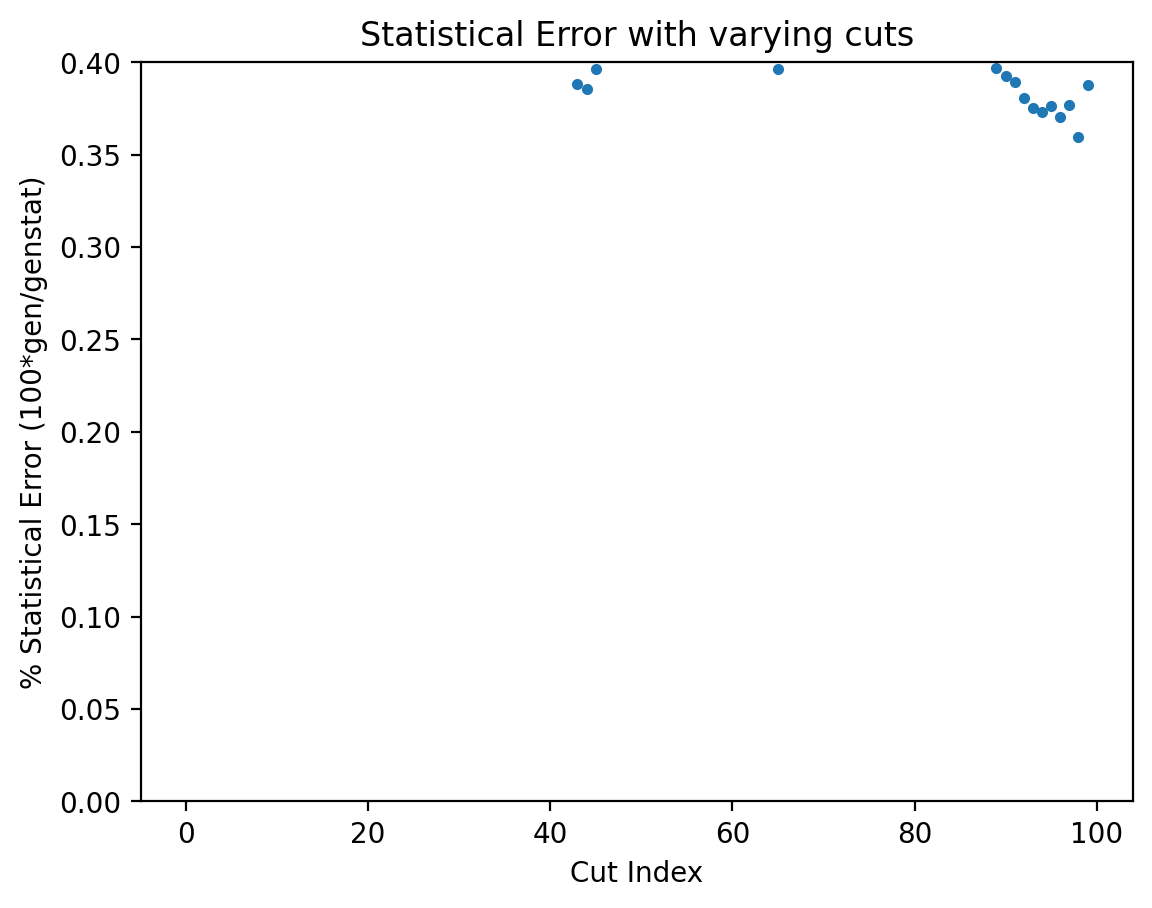

In [113]:
plt.figure(dpi=200)
plt.plot(cutindex,(np.array(genstat)/np.array(gen)),'.')
plt.plot(cutindex[14],(np.array(genstat)/np.array(gen))[14],'.',color='red')
plt.plot(cutindex[13+stepsize],(np.array(genstat)/np.array(gen))[13+stepsize],'.',color='red')
plt.plot(cutindex[16+2*stepsize],(np.array(genstat)/np.array(gen))[16+2*stepsize],'.',color='red')
plt.plot(cutindex[12+3*stepsize],(np.array(genstat)/np.array(gen))[12+3*stepsize],'.',color='red')
plt.ylabel("% Statistical Error (100*gen/genstat)")
plt.title("Statistical Error with varying cuts")
plt.xlabel("Cut Index")
plt.ylim(0,.4)

In [56]:
rel_contribs

{'f_acc': 0.23557359937869005,
 'f_p': 1.4187296110411431,
 'f_inelastic': 37.66093665973872,
 'f_N2': 0.0455403379149751,
 'A_acc': 4.663487153299744,
 'A_p': 6.703861183096754e-05,
 'A_inelastic': 0.9748722212456826,
 'P': 55.00079337876922}

In [57]:
GEGM=statdict['GE/GM * muN']
GEGMstat=statdict['GE/GM_stat_error']
GEGMsys=statdict['GE/GM_sys_error']

In [58]:
GEGME=np.sqrt(GEGMstat**2+GEGMsys**2)

In [59]:
GEN2Data = {
    'Q2': [Q2_avg],
    'ExpName': ['GEn-II'],
    'R': [GEGM ],
    'R_err': [GEGME],
    'GEn': [0],   # assuming GEn and GEn_err are present in the file
    'GEn_err': [0]
}

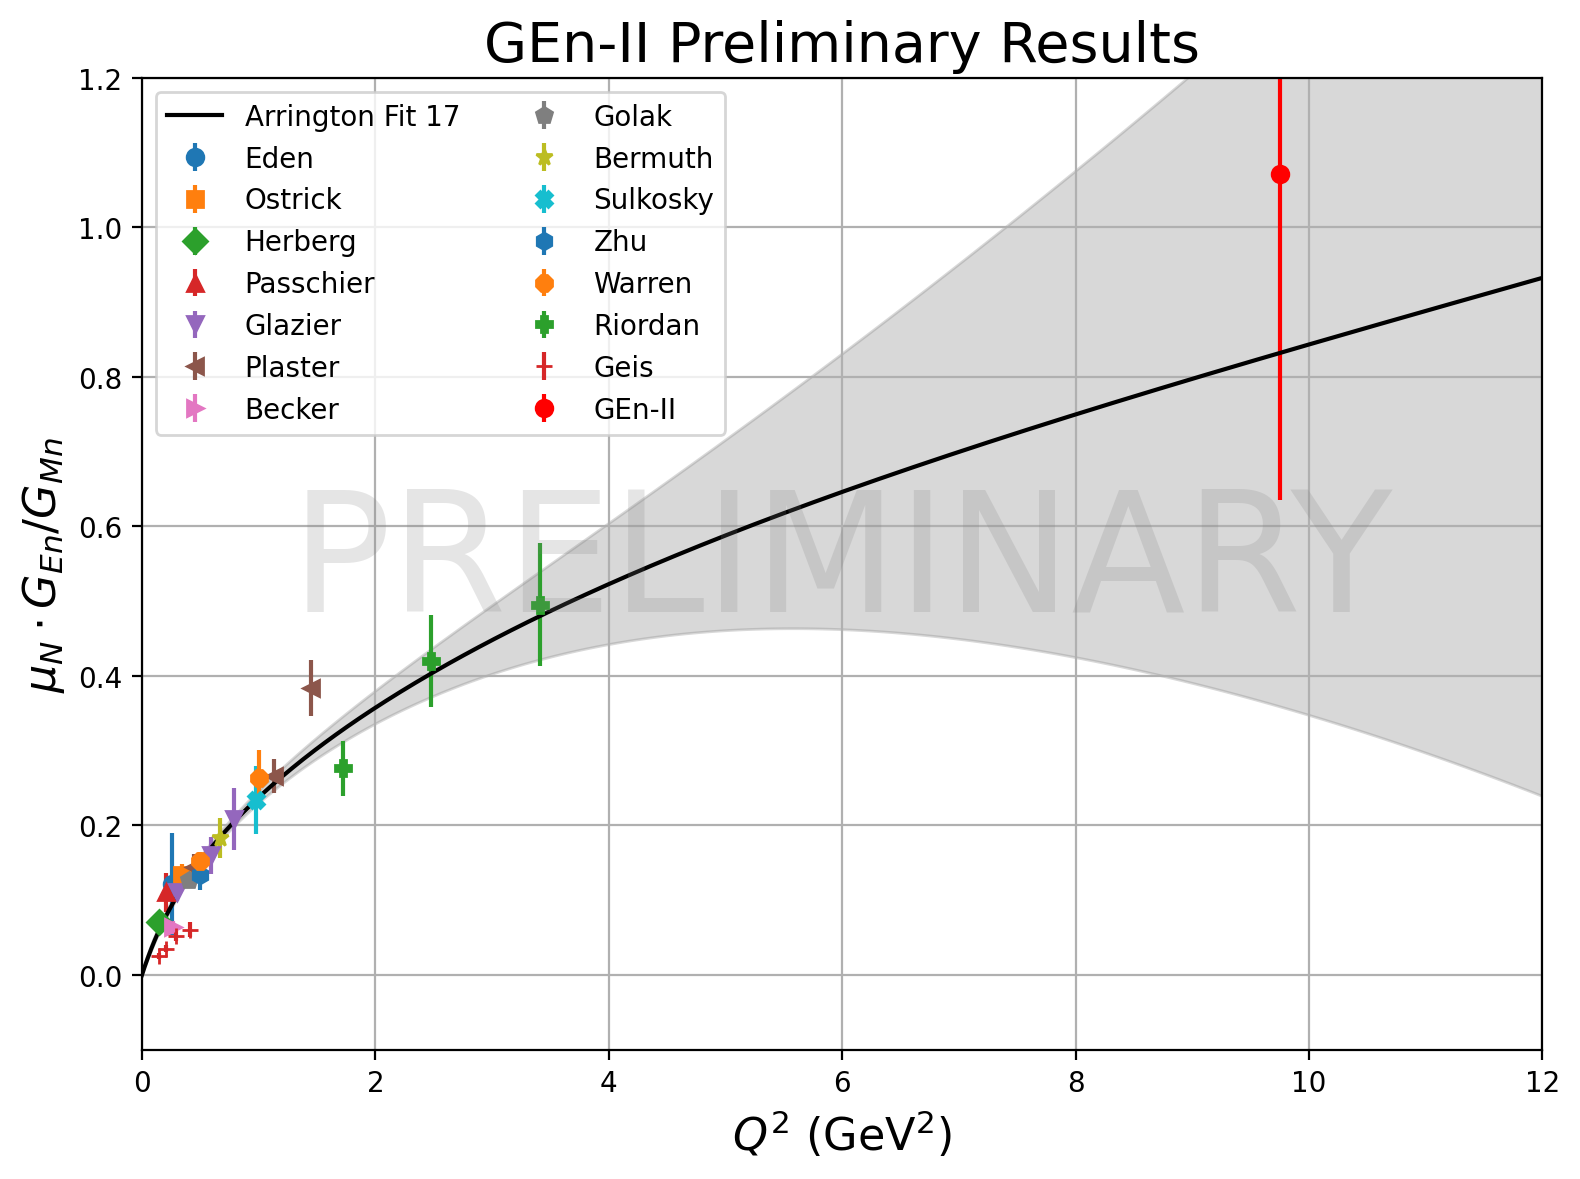

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GETFF import Function_GETFF  # Assuming you have this imported somewhere

# Load theory Q2 and GEn/GD ratio
GEntheory = np.transpose(np.loadtxt('../DB/neutron_lookup.dat'))
Q2t = np.sort(GEntheory[0])

# Calculate GE/GM and uncertainties using GETFF
GEGD, GEGDE, GMGD, GMGDE = [], [], [], []
for q2 in Q2t:
    GEGD.append(Function_GETFF(3, q2)[0])
    GEGDE.append(Function_GETFF(3, q2)[1])
    GMGD.append(Function_GETFF(4, q2)[0])
    GMGDE.append(Function_GETFF(4, q2)[1])

GEGD = np.array(GEGD)
GEGDE = np.array(GEGDE)
GMGD = np.array(GMGD)
GMGDE = np.array(GMGDE)

# Error propagation: GE/GM with uncertainty
def eprop(GE, GEE, GM, GMM):
    R = GE / GM
    fractional_error = np.sqrt((GEE / GE)**2 + (GMM / GM)**2)
    return R, R * fractional_error

RatFit, RatFitE = eprop(GEGD, GEGDE, GMGD, GMGDE)

# Load world data
df = pd.read_csv("../DB/GEn_World_Data.csv")
mu_n = 1.91

# Setup plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=200)
marker_styles = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X', 'h', '8', 'P', '+', 'x', '|', '_']
experiments = df["Experiment"].unique()
markers = {exp: marker_styles[i % len(marker_styles)] for i, exp in enumerate(experiments)}

# Plot world data
for exp in experiments:
    subset = df[df["Experiment"] == exp]
    ax.errorbar(subset["Q2"], mu_n * subset["GEn"] / subset["GMn"],
                subset["RatE"], fmt=markers[exp], label=exp)
plt.errorbar(GEN2Data['Q2'],GEN2Data['R'],GEN2Data['R_err'],fmt='o',color='red',label='GEn-II')

# Plot fit and shaded error band
ax.plot(Q2t, RatFit, color='black', label='Arrington Fit 17')
ax.fill_between(Q2t, RatFit - RatFitE, RatFit + RatFitE, color='gray', alpha=0.3)

# Watermark and labels
ax.text(0.5, 0.5, 'PRELIMINARY', fontsize=60, color='gray',
        ha='center', va='center', alpha=0.2, transform=ax.transAxes)

ax.set_xlim(0, 12)
ax.set_ylim(-0.1, 1.2)
ax.grid(True)
ax.set_xlabel('$Q^2$ (GeV$^2$)', fontsize=16)
ax.set_ylabel(r'$\mu_N \cdot G_{En} / G_{Mn}$', fontsize=16)
ax.set_title('GEn-II Preliminary Results', fontsize=20)
ax.legend(loc='upper left', fontsize=10, ncol=2)
#plt.yscale("log")
plt.tight_layout()
plt.savefig("PrelimResults.pdf")
plt.show()


In [109]:
with open("kin4results.txt",'w') as f:
    for i,key in enumerate(statdict):
        if i<4:
            f.write(key+","+f"{statdict[key]:.0f}\n")
        else:
            f.write(key+","+f"{statdict[key]:.4f}\n")